## Sequential LSTM and Convolution
## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7610928397889325006
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7033235047
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12477033183013152642
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import datetime
print(datetime.datetime.now())

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

2019-10-09 03:44:02.347089
python: 3.5.2 (default, Jul 10 2019, 11:58:48) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_reinject_output_1-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_input = Input(shape=(1, 3)) 

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    dense_1_outputs = dense_1(decoder_outputs_1)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = outputs
    states = [dh1, dc1]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 3)         0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 64), (None,  17664       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, 1, 64), (Non 17664       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

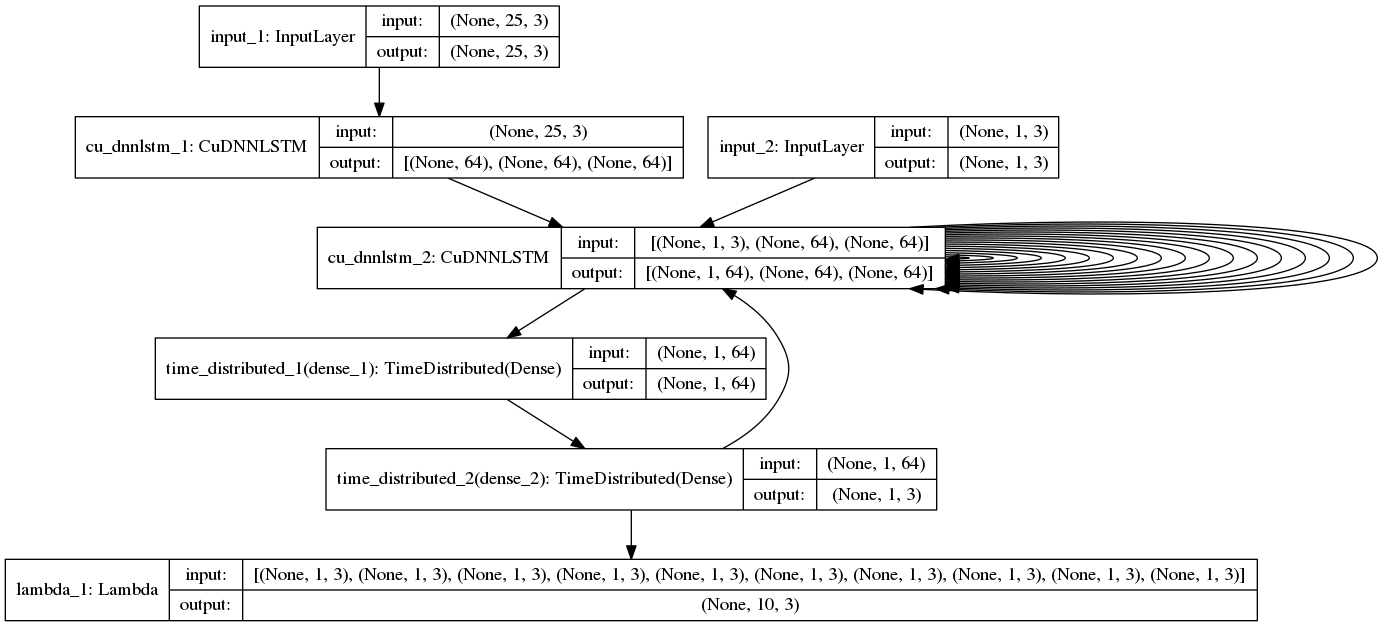

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

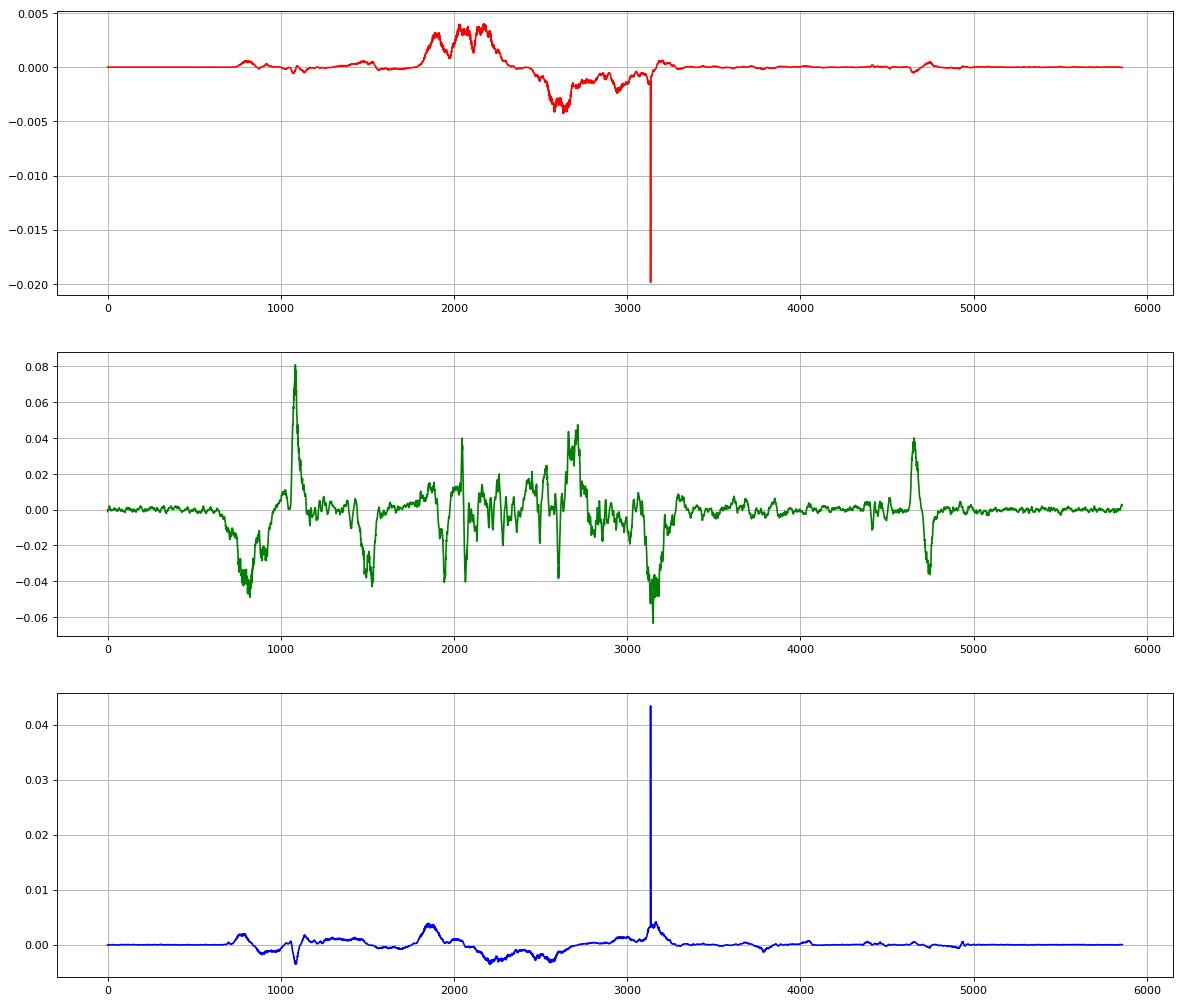

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 11:10 - loss: 0.0703 - rmse: 0.1837

  3/542 [..............................] - ETA: 3:52 - loss: 0.0750 - rmse: 0.1945 

  6/542 [..............................] - ETA: 2:02 - loss: 0.0756 - rmse: 0.1923

  8/542 [..............................] - ETA: 1:34 - loss: 0.0740 - rmse: 0.1906

 10/542 [..............................] - ETA: 1:21 - loss: 0.0786 - rmse: 0.2046

 11/542 [..............................] - ETA: 1:19 - loss: 0.0809 - rmse: 0.2082

 13/542 [..............................] - ETA: 1:10 - loss: 0.0843 - rmse: 0.2135

 15/542 [..............................] - ETA: 1:03 - loss: 0.0820 - rmse: 0.2089

 17/542 [..............................] - ETA: 57s - loss: 0.0786 - rmse: 0.1992 

 19/542 [>.............................] - ETA: 53s - loss: 0.0774 - rmse: 0.1970

 21/542 [>.............................] - ETA: 50s - loss: 0.0736 - rmse: 0.1893

 23/542 [>.............................] - ETA: 47s - loss: 0.0739 - rmse: 0.1921

 25/542 [>.............................] - ETA: 44s - loss: 0.0718 - rmse: 0.1859

 27/542 [>.............................] - ETA: 42s - loss: 0.0749 - rmse: 0.1938

 29/542 [>.............................] - ETA: 40s - loss: 0.0736 - rmse: 0.1917

 31/542 [>.............................] - ETA: 39s - loss: 0.0719 - rmse: 0.1881

 33/542 [>.............................] - ETA: 38s - loss: 0.0722 - rmse: 0.1896

 35/542 [>.............................] - ETA: 36s - loss: 0.0712 - rmse: 0.1868

 37/542 [=>............................] - ETA: 35s - loss: 0.0704 - rmse: 0.1832

 39/542 [=>............................] - ETA: 34s - loss: 0.0679 - rmse: 0.1770

 41/542 [=>............................] - ETA: 33s - loss: 0.0674 - rmse: 0.1767

 43/542 [=>............................] - ETA: 32s - loss: 0.0689 - rmse: 0.1801

 45/542 [=>............................] - ETA: 32s - loss: 0.0689 - rmse: 0.1801

 47/542 [=>............................] - ETA: 31s - loss: 0.0677 - rmse: 0.1784

 49/542 [=>............................] - ETA: 30s - loss: 0.0690 - rmse: 0.1823

 51/542 [=>............................] - ETA: 30s - loss: 0.0689 - rmse: 0.1828

 53/542 [=>............................] - ETA: 29s - loss: 0.0674 - rmse: 0.1789

 55/542 [==>...........................] - ETA: 28s - loss: 0.0685 - rmse: 0.1804

 57/542 [==>...........................] - ETA: 28s - loss: 0.0684 - rmse: 0.1798

 59/542 [==>...........................] - ETA: 27s - loss: 0.0682 - rmse: 0.1809

 61/542 [==>...........................] - ETA: 27s - loss: 0.0670 - rmse: 0.1776

 63/542 [==>...........................] - ETA: 26s - loss: 0.0670 - rmse: 0.1779

 65/542 [==>...........................] - ETA: 26s - loss: 0.0665 - rmse: 0.1771

 67/542 [==>...........................] - ETA: 26s - loss: 0.0662 - rmse: 0.1763

 69/542 [==>...........................] - ETA: 25s - loss: 0.0659 - rmse: 0.1749

 71/542 [==>...........................] - ETA: 25s - loss: 0.0656 - rmse: 0.1739

 73/542 [===>..........................] - ETA: 25s - loss: 0.0662 - rmse: 0.1756

 75/542 [===>..........................] - ETA: 24s - loss: 0.0665 - rmse: 0.1761

 77/542 [===>..........................] - ETA: 24s - loss: 0.0661 - rmse: 0.1761

 79/542 [===>..........................] - ETA: 24s - loss: 0.0657 - rmse: 0.1749

 81/542 [===>..........................] - ETA: 23s - loss: 0.0660 - rmse: 0.1755

 83/542 [===>..........................] - ETA: 23s - loss: 0.0662 - rmse: 0.1763

 85/542 [===>..........................] - ETA: 23s - loss: 0.0655 - rmse: 0.1740

 87/542 [===>..........................] - ETA: 23s - loss: 0.0654 - rmse: 0.1736

 89/542 [===>..........................] - ETA: 22s - loss: 0.0657 - rmse: 0.1742

 91/542 [====>.........................] - ETA: 22s - loss: 0.0655 - rmse: 0.1740

 93/542 [====>.........................] - ETA: 22s - loss: 0.0650 - rmse: 0.1735

 95/542 [====>.........................] - ETA: 22s - loss: 0.0651 - rmse: 0.1734

 97/542 [====>.........................] - ETA: 22s - loss: 0.0654 - rmse: 0.1739

 99/542 [====>.........................] - ETA: 21s - loss: 0.0653 - rmse: 0.1738

101/542 [====>.........................] - ETA: 21s - loss: 0.0647 - rmse: 0.1721

103/542 [====>.........................] - ETA: 21s - loss: 0.0648 - rmse: 0.1723

105/542 [====>.........................] - ETA: 21s - loss: 0.0645 - rmse: 0.1716

107/542 [====>.........................] - ETA: 21s - loss: 0.0646 - rmse: 0.1716

109/542 [=====>........................] - ETA: 20s - loss: 0.0650 - rmse: 0.1730

111/542 [=====>........................] - ETA: 20s - loss: 0.0643 - rmse: 0.1711

113/542 [=====>........................] - ETA: 20s - loss: 0.0642 - rmse: 0.1710

115/542 [=====>........................] - ETA: 20s - loss: 0.0644 - rmse: 0.1716

117/542 [=====>........................] - ETA: 20s - loss: 0.0641 - rmse: 0.1712

119/542 [=====>........................] - ETA: 20s - loss: 0.0640 - rmse: 0.1709

121/542 [=====>........................] - ETA: 19s - loss: 0.0636 - rmse: 0.1698

123/542 [=====>........................] - ETA: 19s - loss: 0.0641 - rmse: 0.1715

125/542 [=====>........................] - ETA: 19s - loss: 0.0646 - rmse: 0.1733

127/542 [======>.......................] - ETA: 19s - loss: 0.0646 - rmse: 0.1729

129/542 [======>.......................] - ETA: 19s - loss: 0.0644 - rmse: 0.1723

131/542 [======>.......................] - ETA: 19s - loss: 0.0642 - rmse: 0.1720

133/542 [======>.......................] - ETA: 18s - loss: 0.0642 - rmse: 0.1725

135/542 [======>.......................] - ETA: 18s - loss: 0.0638 - rmse: 0.1714

137/542 [======>.......................] - ETA: 18s - loss: 0.0645 - rmse: 0.1728

139/542 [======>.......................] - ETA: 18s - loss: 0.0643 - rmse: 0.1728

141/542 [======>.......................] - ETA: 18s - loss: 0.0643 - rmse: 0.1731

143/542 [======>.......................] - ETA: 18s - loss: 0.0637 - rmse: 0.1713

145/542 [=======>......................] - ETA: 18s - loss: 0.0638 - rmse: 0.1715

147/542 [=======>......................] - ETA: 17s - loss: 0.0634 - rmse: 0.1706

149/542 [=======>......................] - ETA: 17s - loss: 0.0636 - rmse: 0.1721

151/542 [=======>......................] - ETA: 17s - loss: 0.0638 - rmse: 0.1725

153/542 [=======>......................] - ETA: 17s - loss: 0.0639 - rmse: 0.1727

155/542 [=======>......................] - ETA: 17s - loss: 0.0638 - rmse: 0.1723

157/542 [=======>......................] - ETA: 17s - loss: 0.0638 - rmse: 0.1727

159/542 [=======>......................] - ETA: 17s - loss: 0.0641 - rmse: 0.1734

161/542 [=======>......................] - ETA: 17s - loss: 0.0644 - rmse: 0.1738

163/542 [========>.....................] - ETA: 16s - loss: 0.0644 - rmse: 0.1738

165/542 [========>.....................] - ETA: 16s - loss: 0.0645 - rmse: 0.1741

167/542 [========>.....................] - ETA: 16s - loss: 0.0644 - rmse: 0.1739

169/542 [========>.....................] - ETA: 16s - loss: 0.0644 - rmse: 0.1741

171/542 [========>.....................] - ETA: 16s - loss: 0.0643 - rmse: 0.1737

173/542 [========>.....................] - ETA: 16s - loss: 0.0639 - rmse: 0.1726

175/542 [========>.....................] - ETA: 16s - loss: 0.0640 - rmse: 0.1724

177/542 [========>.....................] - ETA: 16s - loss: 0.0635 - rmse: 0.1713

179/542 [========>.....................] - ETA: 15s - loss: 0.0634 - rmse: 0.1710

181/542 [=========>....................] - ETA: 15s - loss: 0.0630 - rmse: 0.1700

183/542 [=========>....................] - ETA: 15s - loss: 0.0627 - rmse: 0.1692

185/542 [=========>....................] - ETA: 15s - loss: 0.0622 - rmse: 0.1682

187/542 [=========>....................] - ETA: 15s - loss: 0.0620 - rmse: 0.1677

189/542 [=========>....................] - ETA: 15s - loss: 0.0619 - rmse: 0.1672

191/542 [=========>....................] - ETA: 15s - loss: 0.0619 - rmse: 0.1671

193/542 [=========>....................] - ETA: 15s - loss: 0.0621 - rmse: 0.1672

195/542 [=========>....................] - ETA: 15s - loss: 0.0620 - rmse: 0.1672

197/542 [=========>....................] - ETA: 14s - loss: 0.0618 - rmse: 0.1674

199/542 [==========>...................] - ETA: 14s - loss: 0.0614 - rmse: 0.1664

201/542 [==========>...................] - ETA: 14s - loss: 0.0613 - rmse: 0.1662

203/542 [==========>...................] - ETA: 14s - loss: 0.0616 - rmse: 0.1669

205/542 [==========>...................] - ETA: 14s - loss: 0.0617 - rmse: 0.1674

207/542 [==========>...................] - ETA: 14s - loss: 0.0616 - rmse: 0.1669

209/542 [==========>...................] - ETA: 14s - loss: 0.0611 - rmse: 0.1656

211/542 [==========>...................] - ETA: 14s - loss: 0.0610 - rmse: 0.1653

213/542 [==========>...................] - ETA: 14s - loss: 0.0614 - rmse: 0.1663

215/542 [==========>...................] - ETA: 13s - loss: 0.0616 - rmse: 0.1667

217/542 [===========>..................] - ETA: 13s - loss: 0.0614 - rmse: 0.1667

219/542 [===========>..................] - ETA: 13s - loss: 0.0613 - rmse: 0.1664

221/542 [===========>..................] - ETA: 13s - loss: 0.0614 - rmse: 0.1667

223/542 [===========>..................] - ETA: 13s - loss: 0.0615 - rmse: 0.1667

225/542 [===========>..................] - ETA: 13s - loss: 0.0615 - rmse: 0.1666

227/542 [===========>..................] - ETA: 13s - loss: 0.0616 - rmse: 0.1669

229/542 [===========>..................] - ETA: 13s - loss: 0.0615 - rmse: 0.1666

231/542 [===========>..................] - ETA: 13s - loss: 0.0615 - rmse: 0.1664

233/542 [===========>..................] - ETA: 13s - loss: 0.0616 - rmse: 0.1667

235/542 [============>.................] - ETA: 12s - loss: 0.0615 - rmse: 0.1665

237/542 [============>.................] - ETA: 12s - loss: 0.0616 - rmse: 0.1666

239/542 [============>.................] - ETA: 12s - loss: 0.0617 - rmse: 0.1670

241/542 [============>.................] - ETA: 12s - loss: 0.0617 - rmse: 0.1672

243/542 [============>.................] - ETA: 12s - loss: 0.0618 - rmse: 0.1676

245/542 [============>.................] - ETA: 12s - loss: 0.0619 - rmse: 0.1679

247/542 [============>.................] - ETA: 12s - loss: 0.0619 - rmse: 0.1679

249/542 [============>.................] - ETA: 12s - loss: 0.0620 - rmse: 0.1683

251/542 [============>.................] - ETA: 12s - loss: 0.0620 - rmse: 0.1682

253/542 [=============>................] - ETA: 12s - loss: 0.0618 - rmse: 0.1679

255/542 [=============>................] - ETA: 12s - loss: 0.0619 - rmse: 0.1682

257/542 [=============>................] - ETA: 11s - loss: 0.0618 - rmse: 0.1683

259/542 [=============>................] - ETA: 11s - loss: 0.0619 - rmse: 0.1686

261/542 [=============>................] - ETA: 11s - loss: 0.0619 - rmse: 0.1685

263/542 [=============>................] - ETA: 11s - loss: 0.0618 - rmse: 0.1682

265/542 [=============>................] - ETA: 11s - loss: 0.0616 - rmse: 0.1677

267/542 [=============>................] - ETA: 11s - loss: 0.0617 - rmse: 0.1680

269/542 [=============>................] - ETA: 11s - loss: 0.0617 - rmse: 0.1681

271/542 [==============>...............] - ETA: 11s - loss: 0.0619 - rmse: 0.1684

273/542 [==============>...............] - ETA: 11s - loss: 0.0620 - rmse: 0.1689

275/542 [==============>...............] - ETA: 11s - loss: 0.0621 - rmse: 0.1690

277/542 [==============>...............] - ETA: 10s - loss: 0.0620 - rmse: 0.1689

279/542 [==============>...............] - ETA: 10s - loss: 0.0617 - rmse: 0.1682

281/542 [==============>...............] - ETA: 10s - loss: 0.0617 - rmse: 0.1682

283/542 [==============>...............] - ETA: 10s - loss: 0.0617 - rmse: 0.1683

285/542 [==============>...............] - ETA: 10s - loss: 0.0616 - rmse: 0.1680

287/542 [==============>...............] - ETA: 10s - loss: 0.0616 - rmse: 0.1679

289/542 [==============>...............] - ETA: 10s - loss: 0.0615 - rmse: 0.1680

291/542 [===============>..............] - ETA: 10s - loss: 0.0615 - rmse: 0.1680

293/542 [===============>..............] - ETA: 10s - loss: 0.0614 - rmse: 0.1681

295/542 [===============>..............] - ETA: 10s - loss: 0.0615 - rmse: 0.1680

297/542 [===============>..............] - ETA: 10s - loss: 0.0615 - rmse: 0.1679

299/542 [===============>..............] - ETA: 9s - loss: 0.0614 - rmse: 0.1677 

301/542 [===============>..............] - ETA: 9s - loss: 0.0618 - rmse: 0.1687

303/542 [===============>..............] - ETA: 9s - loss: 0.0616 - rmse: 0.1683

305/542 [===============>..............] - ETA: 9s - loss: 0.0619 - rmse: 0.1687

307/542 [===============>..............] - ETA: 9s - loss: 0.0619 - rmse: 0.1687

309/542 [================>.............] - ETA: 9s - loss: 0.0620 - rmse: 0.1688

311/542 [================>.............] - ETA: 9s - loss: 0.0621 - rmse: 0.1693

313/542 [================>.............] - ETA: 9s - loss: 0.0620 - rmse: 0.1689

315/542 [================>.............] - ETA: 9s - loss: 0.0620 - rmse: 0.1689

317/542 [================>.............] - ETA: 9s - loss: 0.0620 - rmse: 0.1689

319/542 [================>.............] - ETA: 9s - loss: 0.0620 - rmse: 0.1690

321/542 [================>.............] - ETA: 8s - loss: 0.0622 - rmse: 0.1694

323/542 [================>.............] - ETA: 8s - loss: 0.0621 - rmse: 0.1693

325/542 [================>.............] - ETA: 8s - loss: 0.0621 - rmse: 0.1694

327/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1699

329/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1699

331/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1699

333/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1697

335/542 [=================>............] - ETA: 8s - loss: 0.0622 - rmse: 0.1696

337/542 [=================>............] - ETA: 8s - loss: 0.0622 - rmse: 0.1697

339/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1700

341/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1701

343/542 [=================>............] - ETA: 8s - loss: 0.0623 - rmse: 0.1701

345/542 [==================>...........] - ETA: 7s - loss: 0.0623 - rmse: 0.1697

347/542 [==================>...........] - ETA: 7s - loss: 0.0625 - rmse: 0.1702

349/542 [==================>...........] - ETA: 7s - loss: 0.0624 - rmse: 0.1699

351/542 [==================>...........] - ETA: 7s - loss: 0.0625 - rmse: 0.1701

353/542 [==================>...........] - ETA: 7s - loss: 0.0625 - rmse: 0.1702

355/542 [==================>...........] - ETA: 7s - loss: 0.0623 - rmse: 0.1698

357/542 [==================>...........] - ETA: 7s - loss: 0.0622 - rmse: 0.1694

359/542 [==================>...........] - ETA: 7s - loss: 0.0621 - rmse: 0.1690

361/542 [==================>...........] - ETA: 7s - loss: 0.0620 - rmse: 0.1691

363/542 [===================>..........] - ETA: 7s - loss: 0.0619 - rmse: 0.1686

365/542 [===================>..........] - ETA: 7s - loss: 0.0619 - rmse: 0.1685

367/542 [===================>..........] - ETA: 7s - loss: 0.0621 - rmse: 0.1690

369/542 [===================>..........] - ETA: 6s - loss: 0.0621 - rmse: 0.1692

371/542 [===================>..........] - ETA: 6s - loss: 0.0621 - rmse: 0.1690

373/542 [===================>..........] - ETA: 6s - loss: 0.0620 - rmse: 0.1688

375/542 [===================>..........] - ETA: 6s - loss: 0.0619 - rmse: 0.1687

377/542 [===================>..........] - ETA: 6s - loss: 0.0619 - rmse: 0.1686

379/542 [===================>..........] - ETA: 6s - loss: 0.0619 - rmse: 0.1686

381/542 [====================>.........] - ETA: 6s - loss: 0.0617 - rmse: 0.1681

383/542 [====================>.........] - ETA: 6s - loss: 0.0617 - rmse: 0.1682

385/542 [====================>.........] - ETA: 6s - loss: 0.0616 - rmse: 0.1680

387/542 [====================>.........] - ETA: 6s - loss: 0.0615 - rmse: 0.1677

389/542 [====================>.........] - ETA: 6s - loss: 0.0613 - rmse: 0.1672

391/542 [====================>.........] - ETA: 6s - loss: 0.0613 - rmse: 0.1671

393/542 [====================>.........] - ETA: 5s - loss: 0.0612 - rmse: 0.1667

395/542 [====================>.........] - ETA: 5s - loss: 0.0612 - rmse: 0.1670

397/542 [====================>.........] - ETA: 5s - loss: 0.0612 - rmse: 0.1670

399/542 [=====================>........] - ETA: 5s - loss: 0.0612 - rmse: 0.1671

401/542 [=====================>........] - ETA: 5s - loss: 0.0612 - rmse: 0.1671

404/542 [=====================>........] - ETA: 5s - loss: 0.0611 - rmse: 0.1670

406/542 [=====================>........] - ETA: 5s - loss: 0.0612 - rmse: 0.1673

408/542 [=====================>........] - ETA: 5s - loss: 0.0612 - rmse: 0.1671

410/542 [=====================>........] - ETA: 5s - loss: 0.0612 - rmse: 0.1671

412/542 [=====================>........] - ETA: 5s - loss: 0.0611 - rmse: 0.1669

414/542 [=====================>........] - ETA: 5s - loss: 0.0612 - rmse: 0.1669

416/542 [======================>.......] - ETA: 5s - loss: 0.0613 - rmse: 0.1674

418/542 [======================>.......] - ETA: 4s - loss: 0.0616 - rmse: 0.1678

420/542 [======================>.......] - ETA: 4s - loss: 0.0615 - rmse: 0.1678

422/542 [======================>.......] - ETA: 4s - loss: 0.0614 - rmse: 0.1676

424/542 [======================>.......] - ETA: 4s - loss: 0.0613 - rmse: 0.1673

426/542 [======================>.......] - ETA: 4s - loss: 0.0613 - rmse: 0.1673

428/542 [======================>.......] - ETA: 4s - loss: 0.0613 - rmse: 0.1671

430/542 [======================>.......] - ETA: 4s - loss: 0.0613 - rmse: 0.1672

432/542 [======================>.......] - ETA: 4s - loss: 0.0613 - rmse: 0.1671

434/542 [=======================>......] - ETA: 4s - loss: 0.0611 - rmse: 0.1667

436/542 [=======================>......] - ETA: 4s - loss: 0.0612 - rmse: 0.1667

438/542 [=======================>......] - ETA: 4s - loss: 0.0612 - rmse: 0.1667

440/542 [=======================>......] - ETA: 4s - loss: 0.0612 - rmse: 0.1668

442/542 [=======================>......] - ETA: 3s - loss: 0.0611 - rmse: 0.1664

444/542 [=======================>......] - ETA: 3s - loss: 0.0610 - rmse: 0.1664

446/542 [=======================>......] - ETA: 3s - loss: 0.0609 - rmse: 0.1662

448/542 [=======================>......] - ETA: 3s - loss: 0.0609 - rmse: 0.1661

450/542 [=======================>......] - ETA: 3s - loss: 0.0609 - rmse: 0.1661

452/542 [========================>.....] - ETA: 3s - loss: 0.0609 - rmse: 0.1660

454/542 [========================>.....] - ETA: 3s - loss: 0.0608 - rmse: 0.1659

456/542 [========================>.....] - ETA: 3s - loss: 0.0608 - rmse: 0.1659

458/542 [========================>.....] - ETA: 3s - loss: 0.0609 - rmse: 0.1659

460/542 [========================>.....] - ETA: 3s - loss: 0.0608 - rmse: 0.1660

462/542 [========================>.....] - ETA: 3s - loss: 0.0609 - rmse: 0.1662

464/542 [========================>.....] - ETA: 3s - loss: 0.0609 - rmse: 0.1661

466/542 [========================>.....] - ETA: 2s - loss: 0.0609 - rmse: 0.1662

468/542 [========================>.....] - ETA: 2s - loss: 0.0607 - rmse: 0.1657

470/542 [=========================>....] - ETA: 2s - loss: 0.0607 - rmse: 0.1658

472/542 [=========================>....] - ETA: 2s - loss: 0.0606 - rmse: 0.1657

474/542 [=========================>....] - ETA: 2s - loss: 0.0606 - rmse: 0.1659

476/542 [=========================>....] - ETA: 2s - loss: 0.0608 - rmse: 0.1664

478/542 [=========================>....] - ETA: 2s - loss: 0.0608 - rmse: 0.1664

480/542 [=========================>....] - ETA: 2s - loss: 0.0608 - rmse: 0.1663

482/542 [=========================>....] - ETA: 2s - loss: 0.0609 - rmse: 0.1666

484/542 [=========================>....] - ETA: 2s - loss: 0.0610 - rmse: 0.1669

486/542 [=========================>....] - ETA: 2s - loss: 0.0610 - rmse: 0.1669

488/542 [==========================>...] - ETA: 2s - loss: 0.0610 - rmse: 0.1668

490/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1665

492/542 [==========================>...] - ETA: 1s - loss: 0.0609 - rmse: 0.1665

494/542 [==========================>...] - ETA: 1s - loss: 0.0609 - rmse: 0.1666

496/542 [==========================>...] - ETA: 1s - loss: 0.0609 - rmse: 0.1666

498/542 [==========================>...] - ETA: 1s - loss: 0.0609 - rmse: 0.1667

500/542 [==========================>...] - ETA: 1s - loss: 0.0610 - rmse: 0.1670

502/542 [==========================>...] - ETA: 1s - loss: 0.0610 - rmse: 0.1668

504/542 [==========================>...] - ETA: 1s - loss: 0.0609 - rmse: 0.1666

506/542 [===========================>..] - ETA: 1s - loss: 0.0609 - rmse: 0.1664

508/542 [===========================>..] - ETA: 1s - loss: 0.0608 - rmse: 0.1663

510/542 [===========================>..] - ETA: 1s - loss: 0.0609 - rmse: 0.1664

512/542 [===========================>..] - ETA: 1s - loss: 0.0609 - rmse: 0.1665

514/542 [===========================>..] - ETA: 1s - loss: 0.0609 - rmse: 0.1667

516/542 [===========================>..] - ETA: 1s - loss: 0.0610 - rmse: 0.1668

518/542 [===========================>..] - ETA: 0s - loss: 0.0610 - rmse: 0.1669

520/542 [===========================>..] - ETA: 0s - loss: 0.0609 - rmse: 0.1667

522/542 [===========================>..] - ETA: 0s - loss: 0.0608 - rmse: 0.1664

524/542 [============================>.] - ETA: 0s - loss: 0.0609 - rmse: 0.1664

526/542 [============================>.] - ETA: 0s - loss: 0.0610 - rmse: 0.1666

528/542 [============================>.] - ETA: 0s - loss: 0.0609 - rmse: 0.1665

530/542 [============================>.] - ETA: 0s - loss: 0.0609 - rmse: 0.1666

532/542 [============================>.] - ETA: 0s - loss: 0.0611 - rmse: 0.1670

534/542 [============================>.] - ETA: 0s - loss: 0.0611 - rmse: 0.1670

536/542 [============================>.] - ETA: 0s - loss: 0.0610 - rmse: 0.1669

538/542 [============================>.] - ETA: 0s - loss: 0.0610 - rmse: 0.1668

540/542 [============================>.] - ETA: 0s - loss: 0.0610 - rmse: 0.1668

542/542 [==============================] - 27s 49ms/step - loss: 0.0609 - rmse: 0.1665 - val_loss: 0.0645 - val_rmse: 0.1817


Epoch 2/150
  1/542 [..............................] - ETA: 12s - loss: 0.0688 - rmse: 0.1850

/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

  3/542 [..............................] - ETA: 13s - loss: 0.0523 - rmse: 0.1382

  5/542 [..............................] - ETA: 13s - loss: 0.0486 - rmse: 0.1299

  7/542 [..............................] - ETA: 14s - loss: 0.0518 - rmse: 0.1386

  9/542 [..............................] - ETA: 14s - loss: 0.0499 - rmse: 0.1356

 11/542 [..............................] - ETA: 14s - loss: 0.0523 - rmse: 0.1407

 13/542 [..............................] - ETA: 14s - loss: 0.0502 - rmse: 0.1350

 14/542 [..............................] - ETA: 16s - loss: 0.0546 - rmse: 0.1452

 15/542 [..............................] - ETA: 20s - loss: 0.0552 - rmse: 0.1456

 16/542 [..............................] - ETA: 22s - loss: 0.0539 - rmse: 0.1431

 17/542 [..............................] - ETA: 25s - loss: 0.0565 - rmse: 0.1507

 18/542 [..............................] - ETA: 28s - loss: 0.0551 - rmse: 0.1469

 19/542 [>.............................] - ETA: 30s - loss: 0.0542 - rmse: 0.1445

 20/542 [>.............................] - ETA: 33s - loss: 0.0521 - rmse: 0.1390

 22/542 [>.............................] - ETA: 31s - loss: 0.0534 - rmse: 0.1419

 24/542 [>.............................] - ETA: 30s - loss: 0.0516 - rmse: 0.1400

 26/542 [>.............................] - ETA: 29s - loss: 0.0516 - rmse: 0.1395

 28/542 [>.............................] - ETA: 28s - loss: 0.0504 - rmse: 0.1379

 30/542 [>.............................] - ETA: 27s - loss: 0.0513 - rmse: 0.1392

 32/542 [>.............................] - ETA: 27s - loss: 0.0542 - rmse: 0.1462

 34/542 [>.............................] - ETA: 26s - loss: 0.0544 - rmse: 0.1457

 36/542 [>.............................] - ETA: 26s - loss: 0.0535 - rmse: 0.1435

 38/542 [=>............................] - ETA: 25s - loss: 0.0533 - rmse: 0.1443

 40/542 [=>............................] - ETA: 25s - loss: 0.0547 - rmse: 0.1486

 42/542 [=>............................] - ETA: 24s - loss: 0.0561 - rmse: 0.1526

 44/542 [=>............................] - ETA: 24s - loss: 0.0554 - rmse: 0.1504

 46/542 [=>............................] - ETA: 23s - loss: 0.0544 - rmse: 0.1476

 48/542 [=>............................] - ETA: 23s - loss: 0.0539 - rmse: 0.1464

 50/542 [=>............................] - ETA: 23s - loss: 0.0557 - rmse: 0.1508

 52/542 [=>............................] - ETA: 22s - loss: 0.0549 - rmse: 0.1499

 54/542 [=>............................] - ETA: 22s - loss: 0.0548 - rmse: 0.1507

 56/542 [==>...........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1531

 58/542 [==>...........................] - ETA: 21s - loss: 0.0565 - rmse: 0.1541

 60/542 [==>...........................] - ETA: 21s - loss: 0.0550 - rmse: 0.1501

 62/542 [==>...........................] - ETA: 21s - loss: 0.0547 - rmse: 0.1491

 64/542 [==>...........................] - ETA: 21s - loss: 0.0556 - rmse: 0.1515

 66/542 [==>...........................] - ETA: 21s - loss: 0.0556 - rmse: 0.1520

 68/542 [==>...........................] - ETA: 20s - loss: 0.0562 - rmse: 0.1532

 70/542 [==>...........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1519

 72/542 [==>...........................] - ETA: 20s - loss: 0.0559 - rmse: 0.1531

 74/542 [===>..........................] - ETA: 20s - loss: 0.0562 - rmse: 0.1541

 76/542 [===>..........................] - ETA: 20s - loss: 0.0558 - rmse: 0.1527

 78/542 [===>..........................] - ETA: 19s - loss: 0.0554 - rmse: 0.1531

 80/542 [===>..........................] - ETA: 19s - loss: 0.0556 - rmse: 0.1532

 82/542 [===>..........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1550

 84/542 [===>..........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1549

 86/542 [===>..........................] - ETA: 19s - loss: 0.0556 - rmse: 0.1535

 88/542 [===>..........................] - ETA: 19s - loss: 0.0559 - rmse: 0.1551

 90/542 [===>..........................] - ETA: 19s - loss: 0.0555 - rmse: 0.1538

 92/542 [====>.........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1538

 94/542 [====>.........................] - ETA: 18s - loss: 0.0555 - rmse: 0.1544

 96/542 [====>.........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1534

 98/542 [====>.........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1529

100/542 [====>.........................] - ETA: 18s - loss: 0.0547 - rmse: 0.1515

102/542 [====>.........................] - ETA: 18s - loss: 0.0547 - rmse: 0.1512

104/542 [====>.........................] - ETA: 18s - loss: 0.0547 - rmse: 0.1511

106/542 [====>.........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1523

108/542 [====>.........................] - ETA: 17s - loss: 0.0552 - rmse: 0.1519

110/542 [=====>........................] - ETA: 17s - loss: 0.0552 - rmse: 0.1515

112/542 [=====>........................] - ETA: 17s - loss: 0.0550 - rmse: 0.1512

114/542 [=====>........................] - ETA: 17s - loss: 0.0557 - rmse: 0.1534

116/542 [=====>........................] - ETA: 17s - loss: 0.0561 - rmse: 0.1544

118/542 [=====>........................] - ETA: 17s - loss: 0.0563 - rmse: 0.1545

120/542 [=====>........................] - ETA: 17s - loss: 0.0562 - rmse: 0.1544

122/542 [=====>........................] - ETA: 17s - loss: 0.0566 - rmse: 0.1552

124/542 [=====>........................] - ETA: 16s - loss: 0.0565 - rmse: 0.1549

126/542 [=====>........................] - ETA: 16s - loss: 0.0565 - rmse: 0.1554

128/542 [======>.......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1554

130/542 [======>.......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1546

132/542 [======>.......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1554

134/542 [======>.......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1559

136/542 [======>.......................] - ETA: 16s - loss: 0.0572 - rmse: 0.1576

138/542 [======>.......................] - ETA: 16s - loss: 0.0572 - rmse: 0.1576

140/542 [======>.......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1566

142/542 [======>.......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1582

144/542 [======>.......................] - ETA: 15s - loss: 0.0573 - rmse: 0.1581

146/542 [=======>......................] - ETA: 15s - loss: 0.0576 - rmse: 0.1595

148/542 [=======>......................] - ETA: 15s - loss: 0.0575 - rmse: 0.1594

150/542 [=======>......................] - ETA: 15s - loss: 0.0585 - rmse: 0.1618

152/542 [=======>......................] - ETA: 15s - loss: 0.0589 - rmse: 0.1629

154/542 [=======>......................] - ETA: 15s - loss: 0.0590 - rmse: 0.1635

156/542 [=======>......................] - ETA: 15s - loss: 0.0586 - rmse: 0.1625

158/542 [=======>......................] - ETA: 15s - loss: 0.0590 - rmse: 0.1634

160/542 [=======>......................] - ETA: 15s - loss: 0.0589 - rmse: 0.1633

162/542 [=======>......................] - ETA: 15s - loss: 0.0591 - rmse: 0.1638

164/542 [========>.....................] - ETA: 14s - loss: 0.0590 - rmse: 0.1634

166/542 [========>.....................] - ETA: 14s - loss: 0.0594 - rmse: 0.1638

168/542 [========>.....................] - ETA: 14s - loss: 0.0595 - rmse: 0.1643

170/542 [========>.....................] - ETA: 14s - loss: 0.0597 - rmse: 0.1649

172/542 [========>.....................] - ETA: 14s - loss: 0.0601 - rmse: 0.1666

174/542 [========>.....................] - ETA: 14s - loss: 0.0599 - rmse: 0.1661

176/542 [========>.....................] - ETA: 14s - loss: 0.0598 - rmse: 0.1659

178/542 [========>.....................] - ETA: 14s - loss: 0.0597 - rmse: 0.1657

180/542 [========>.....................] - ETA: 14s - loss: 0.0598 - rmse: 0.1658

182/542 [=========>....................] - ETA: 14s - loss: 0.0597 - rmse: 0.1655

184/542 [=========>....................] - ETA: 13s - loss: 0.0599 - rmse: 0.1657

185/542 [=========>....................] - ETA: 13s - loss: 0.0598 - rmse: 0.1656

187/542 [=========>....................] - ETA: 13s - loss: 0.0597 - rmse: 0.1653

189/542 [=========>....................] - ETA: 13s - loss: 0.0596 - rmse: 0.1654

191/542 [=========>....................] - ETA: 13s - loss: 0.0596 - rmse: 0.1652

193/542 [=========>....................] - ETA: 13s - loss: 0.0598 - rmse: 0.1661

195/542 [=========>....................] - ETA: 13s - loss: 0.0600 - rmse: 0.1661

197/542 [=========>....................] - ETA: 13s - loss: 0.0602 - rmse: 0.1666

199/542 [==========>...................] - ETA: 13s - loss: 0.0601 - rmse: 0.1664

201/542 [==========>...................] - ETA: 13s - loss: 0.0602 - rmse: 0.1668

203/542 [==========>...................] - ETA: 13s - loss: 0.0601 - rmse: 0.1666

205/542 [==========>...................] - ETA: 13s - loss: 0.0601 - rmse: 0.1667

207/542 [==========>...................] - ETA: 12s - loss: 0.0604 - rmse: 0.1677

209/542 [==========>...................] - ETA: 12s - loss: 0.0602 - rmse: 0.1674

211/542 [==========>...................] - ETA: 12s - loss: 0.0600 - rmse: 0.1666

213/542 [==========>...................] - ETA: 12s - loss: 0.0601 - rmse: 0.1669

215/542 [==========>...................] - ETA: 12s - loss: 0.0602 - rmse: 0.1670

217/542 [===========>..................] - ETA: 12s - loss: 0.0598 - rmse: 0.1661

219/542 [===========>..................] - ETA: 12s - loss: 0.0599 - rmse: 0.1662

221/542 [===========>..................] - ETA: 12s - loss: 0.0597 - rmse: 0.1654

223/542 [===========>..................] - ETA: 12s - loss: 0.0596 - rmse: 0.1653

225/542 [===========>..................] - ETA: 12s - loss: 0.0594 - rmse: 0.1646

227/542 [===========>..................] - ETA: 12s - loss: 0.0596 - rmse: 0.1651

229/542 [===========>..................] - ETA: 12s - loss: 0.0597 - rmse: 0.1653

231/542 [===========>..................] - ETA: 11s - loss: 0.0599 - rmse: 0.1658

233/542 [===========>..................] - ETA: 11s - loss: 0.0596 - rmse: 0.1653

235/542 [============>.................] - ETA: 11s - loss: 0.0598 - rmse: 0.1658

237/542 [============>.................] - ETA: 11s - loss: 0.0597 - rmse: 0.1654

239/542 [============>.................] - ETA: 11s - loss: 0.0599 - rmse: 0.1660

241/542 [============>.................] - ETA: 11s - loss: 0.0597 - rmse: 0.1655

243/542 [============>.................] - ETA: 11s - loss: 0.0596 - rmse: 0.1654

245/542 [============>.................] - ETA: 11s - loss: 0.0596 - rmse: 0.1651

247/542 [============>.................] - ETA: 11s - loss: 0.0596 - rmse: 0.1651

249/542 [============>.................] - ETA: 11s - loss: 0.0597 - rmse: 0.1655

251/542 [============>.................] - ETA: 11s - loss: 0.0600 - rmse: 0.1662

253/542 [=============>................] - ETA: 11s - loss: 0.0600 - rmse: 0.1661

255/542 [=============>................] - ETA: 10s - loss: 0.0599 - rmse: 0.1659

257/542 [=============>................] - ETA: 10s - loss: 0.0596 - rmse: 0.1652

259/542 [=============>................] - ETA: 10s - loss: 0.0598 - rmse: 0.1657

261/542 [=============>................] - ETA: 10s - loss: 0.0598 - rmse: 0.1657

263/542 [=============>................] - ETA: 10s - loss: 0.0598 - rmse: 0.1655

266/542 [=============>................] - ETA: 10s - loss: 0.0594 - rmse: 0.1649

268/542 [=============>................] - ETA: 10s - loss: 0.0595 - rmse: 0.1650

270/542 [=============>................] - ETA: 10s - loss: 0.0595 - rmse: 0.1650

272/542 [==============>...............] - ETA: 10s - loss: 0.0593 - rmse: 0.1645

274/542 [==============>...............] - ETA: 10s - loss: 0.0591 - rmse: 0.1639

276/542 [==============>...............] - ETA: 10s - loss: 0.0591 - rmse: 0.1637

278/542 [==============>...............] - ETA: 10s - loss: 0.0590 - rmse: 0.1636

280/542 [==============>...............] - ETA: 9s - loss: 0.0590 - rmse: 0.1634 

282/542 [==============>...............] - ETA: 9s - loss: 0.0591 - rmse: 0.1635

284/542 [==============>...............] - ETA: 9s - loss: 0.0591 - rmse: 0.1636

286/542 [==============>...............] - ETA: 9s - loss: 0.0590 - rmse: 0.1633

288/542 [==============>...............] - ETA: 9s - loss: 0.0589 - rmse: 0.1632

290/542 [===============>..............] - ETA: 9s - loss: 0.0589 - rmse: 0.1631

292/542 [===============>..............] - ETA: 9s - loss: 0.0588 - rmse: 0.1627

294/542 [===============>..............] - ETA: 9s - loss: 0.0588 - rmse: 0.1627

296/542 [===============>..............] - ETA: 9s - loss: 0.0587 - rmse: 0.1623

298/542 [===============>..............] - ETA: 9s - loss: 0.0588 - rmse: 0.1626

300/542 [===============>..............] - ETA: 9s - loss: 0.0589 - rmse: 0.1630

302/542 [===============>..............] - ETA: 9s - loss: 0.0589 - rmse: 0.1629

304/542 [===============>..............] - ETA: 9s - loss: 0.0588 - rmse: 0.1625

306/542 [===============>..............] - ETA: 8s - loss: 0.0591 - rmse: 0.1630

308/542 [================>.............] - ETA: 8s - loss: 0.0589 - rmse: 0.1624

310/542 [================>.............] - ETA: 8s - loss: 0.0586 - rmse: 0.1620

312/542 [================>.............] - ETA: 8s - loss: 0.0585 - rmse: 0.1616

314/542 [================>.............] - ETA: 8s - loss: 0.0584 - rmse: 0.1615

316/542 [================>.............] - ETA: 8s - loss: 0.0583 - rmse: 0.1611

318/542 [================>.............] - ETA: 8s - loss: 0.0584 - rmse: 0.1613

320/542 [================>.............] - ETA: 8s - loss: 0.0583 - rmse: 0.1612

322/542 [================>.............] - ETA: 8s - loss: 0.0582 - rmse: 0.1609

324/542 [================>.............] - ETA: 8s - loss: 0.0581 - rmse: 0.1606

326/542 [=================>............] - ETA: 8s - loss: 0.0581 - rmse: 0.1607

328/542 [=================>............] - ETA: 8s - loss: 0.0582 - rmse: 0.1609

330/542 [=================>............] - ETA: 8s - loss: 0.0580 - rmse: 0.1604

332/542 [=================>............] - ETA: 7s - loss: 0.0581 - rmse: 0.1605

334/542 [=================>............] - ETA: 7s - loss: 0.0580 - rmse: 0.1602

336/542 [=================>............] - ETA: 7s - loss: 0.0579 - rmse: 0.1601

338/542 [=================>............] - ETA: 7s - loss: 0.0579 - rmse: 0.1600

340/542 [=================>............] - ETA: 7s - loss: 0.0581 - rmse: 0.1605

342/542 [=================>............] - ETA: 7s - loss: 0.0581 - rmse: 0.1605

344/542 [==================>...........] - ETA: 7s - loss: 0.0582 - rmse: 0.1608

346/542 [==================>...........] - ETA: 7s - loss: 0.0582 - rmse: 0.1609

348/542 [==================>...........] - ETA: 7s - loss: 0.0581 - rmse: 0.1608

350/542 [==================>...........] - ETA: 7s - loss: 0.0582 - rmse: 0.1611

352/542 [==================>...........] - ETA: 7s - loss: 0.0580 - rmse: 0.1608

354/542 [==================>...........] - ETA: 7s - loss: 0.0581 - rmse: 0.1609

356/542 [==================>...........] - ETA: 7s - loss: 0.0581 - rmse: 0.1610

358/542 [==================>...........] - ETA: 6s - loss: 0.0580 - rmse: 0.1607

360/542 [==================>...........] - ETA: 6s - loss: 0.0581 - rmse: 0.1609

362/542 [===================>..........] - ETA: 6s - loss: 0.0580 - rmse: 0.1607

364/542 [===================>..........] - ETA: 6s - loss: 0.0580 - rmse: 0.1608

366/542 [===================>..........] - ETA: 6s - loss: 0.0579 - rmse: 0.1605

368/542 [===================>..........] - ETA: 6s - loss: 0.0581 - rmse: 0.1611

370/542 [===================>..........] - ETA: 6s - loss: 0.0582 - rmse: 0.1613

372/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1617

374/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1617

376/542 [===================>..........] - ETA: 6s - loss: 0.0582 - rmse: 0.1614

378/542 [===================>..........] - ETA: 6s - loss: 0.0582 - rmse: 0.1613

380/542 [====================>.........] - ETA: 6s - loss: 0.0581 - rmse: 0.1613

382/542 [====================>.........] - ETA: 6s - loss: 0.0581 - rmse: 0.1613

384/542 [====================>.........] - ETA: 5s - loss: 0.0581 - rmse: 0.1612

386/542 [====================>.........] - ETA: 5s - loss: 0.0581 - rmse: 0.1613

388/542 [====================>.........] - ETA: 5s - loss: 0.0581 - rmse: 0.1613

390/542 [====================>.........] - ETA: 5s - loss: 0.0580 - rmse: 0.1609

392/542 [====================>.........] - ETA: 5s - loss: 0.0580 - rmse: 0.1610

394/542 [====================>.........] - ETA: 5s - loss: 0.0580 - rmse: 0.1612

396/542 [====================>.........] - ETA: 5s - loss: 0.0580 - rmse: 0.1610

398/542 [=====================>........] - ETA: 5s - loss: 0.0579 - rmse: 0.1609

400/542 [=====================>........] - ETA: 5s - loss: 0.0581 - rmse: 0.1614

402/542 [=====================>........] - ETA: 5s - loss: 0.0581 - rmse: 0.1614

404/542 [=====================>........] - ETA: 5s - loss: 0.0581 - rmse: 0.1615

406/542 [=====================>........] - ETA: 5s - loss: 0.0581 - rmse: 0.1615

408/542 [=====================>........] - ETA: 5s - loss: 0.0579 - rmse: 0.1612

410/542 [=====================>........] - ETA: 4s - loss: 0.0580 - rmse: 0.1613

412/542 [=====================>........] - ETA: 4s - loss: 0.0581 - rmse: 0.1616

414/542 [=====================>........] - ETA: 4s - loss: 0.0581 - rmse: 0.1615

416/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1612

418/542 [======================>.......] - ETA: 4s - loss: 0.0579 - rmse: 0.1610

420/542 [======================>.......] - ETA: 4s - loss: 0.0579 - rmse: 0.1608

422/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1610

424/542 [======================>.......] - ETA: 4s - loss: 0.0579 - rmse: 0.1609

426/542 [======================>.......] - ETA: 4s - loss: 0.0578 - rmse: 0.1606

428/542 [======================>.......] - ETA: 4s - loss: 0.0578 - rmse: 0.1606

430/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1611

432/542 [======================>.......] - ETA: 4s - loss: 0.0579 - rmse: 0.1607

434/542 [=======================>......] - ETA: 4s - loss: 0.0578 - rmse: 0.1604

436/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1606

438/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1606

440/542 [=======================>......] - ETA: 3s - loss: 0.0577 - rmse: 0.1603

442/542 [=======================>......] - ETA: 3s - loss: 0.0577 - rmse: 0.1605

444/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1607

446/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1609

448/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1609

450/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1607

452/542 [========================>.....] - ETA: 3s - loss: 0.0578 - rmse: 0.1610

454/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1613

456/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1613

458/542 [========================>.....] - ETA: 3s - loss: 0.0580 - rmse: 0.1615

460/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1613

462/542 [========================>.....] - ETA: 2s - loss: 0.0579 - rmse: 0.1611

464/542 [========================>.....] - ETA: 2s - loss: 0.0579 - rmse: 0.1611

466/542 [========================>.....] - ETA: 2s - loss: 0.0579 - rmse: 0.1612

468/542 [========================>.....] - ETA: 2s - loss: 0.0579 - rmse: 0.1610

470/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1610

472/542 [=========================>....] - ETA: 2s - loss: 0.0581 - rmse: 0.1614

474/542 [=========================>....] - ETA: 2s - loss: 0.0581 - rmse: 0.1614

476/542 [=========================>....] - ETA: 2s - loss: 0.0581 - rmse: 0.1616

478/542 [=========================>....] - ETA: 2s - loss: 0.0582 - rmse: 0.1619

480/542 [=========================>....] - ETA: 2s - loss: 0.0582 - rmse: 0.1620

482/542 [=========================>....] - ETA: 2s - loss: 0.0582 - rmse: 0.1621

484/542 [=========================>....] - ETA: 2s - loss: 0.0583 - rmse: 0.1622

486/542 [=========================>....] - ETA: 2s - loss: 0.0582 - rmse: 0.1618

488/542 [==========================>...] - ETA: 2s - loss: 0.0581 - rmse: 0.1617

490/542 [==========================>...] - ETA: 1s - loss: 0.0581 - rmse: 0.1618

492/542 [==========================>...] - ETA: 1s - loss: 0.0581 - rmse: 0.1617

494/542 [==========================>...] - ETA: 1s - loss: 0.0580 - rmse: 0.1613

496/542 [==========================>...] - ETA: 1s - loss: 0.0580 - rmse: 0.1613

498/542 [==========================>...] - ETA: 1s - loss: 0.0580 - rmse: 0.1614

500/542 [==========================>...] - ETA: 1s - loss: 0.0582 - rmse: 0.1618

502/542 [==========================>...] - ETA: 1s - loss: 0.0582 - rmse: 0.1617

504/542 [==========================>...] - ETA: 1s - loss: 0.0583 - rmse: 0.1619

506/542 [===========================>..] - ETA: 1s - loss: 0.0583 - rmse: 0.1621

508/542 [===========================>..] - ETA: 1s - loss: 0.0584 - rmse: 0.1622

510/542 [===========================>..] - ETA: 1s - loss: 0.0584 - rmse: 0.1622

512/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1624

514/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1625

516/542 [===========================>..] - ETA: 0s - loss: 0.0584 - rmse: 0.1623

518/542 [===========================>..] - ETA: 0s - loss: 0.0583 - rmse: 0.1621

520/542 [===========================>..] - ETA: 0s - loss: 0.0583 - rmse: 0.1620

522/542 [===========================>..] - ETA: 0s - loss: 0.0583 - rmse: 0.1621

524/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1619

526/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1620

528/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1619

530/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1620

532/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1620

534/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1622

536/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1620

538/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1617

540/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1622

542/542 [==============================] - 26s 48ms/step - loss: 0.0584 - rmse: 0.1624 - val_loss: 0.0617 - val_rmse: 0.1799


Epoch 3/150
  1/542 [..............................] - ETA: 17s - loss: 0.0568 - rmse: 0.1847

  3/542 [..............................] - ETA: 15s - loss: 0.0865 - rmse: 0.2709

  5/542 [..............................] - ETA: 14s - loss: 0.0799 - rmse: 0.2351

  7/542 [..............................] - ETA: 14s - loss: 0.0763 - rmse: 0.2267

  9/542 [..............................] - ETA: 14s - loss: 0.0754 - rmse: 0.2171

 11/542 [..............................] - ETA: 14s - loss: 0.0720 - rmse: 0.2054

 13/542 [..............................] - ETA: 14s - loss: 0.0705 - rmse: 0.2036

 14/542 [..............................] - ETA: 18s - loss: 0.0688 - rmse: 0.1992

 15/542 [..............................] - ETA: 22s - loss: 0.0676 - rmse: 0.1950

 16/542 [..............................] - ETA: 25s - loss: 0.0654 - rmse: 0.1886

 17/542 [..............................] - ETA: 27s - loss: 0.0649 - rmse: 0.1878

 18/542 [..............................] - ETA: 29s - loss: 0.0636 - rmse: 0.1832

 19/542 [>.............................] - ETA: 31s - loss: 0.0632 - rmse: 0.1805

 20/542 [>.............................] - ETA: 33s - loss: 0.0620 - rmse: 0.1801

 21/542 [>.............................] - ETA: 34s - loss: 0.0608 - rmse: 0.1773

 22/542 [>.............................] - ETA: 35s - loss: 0.0605 - rmse: 0.1758

 24/542 [>.............................] - ETA: 34s - loss: 0.0634 - rmse: 0.1827

 26/542 [>.............................] - ETA: 33s - loss: 0.0649 - rmse: 0.1857

 28/542 [>.............................] - ETA: 32s - loss: 0.0658 - rmse: 0.1863

 30/542 [>.............................] - ETA: 31s - loss: 0.0657 - rmse: 0.1841

 32/542 [>.............................] - ETA: 30s - loss: 0.0667 - rmse: 0.1861

 34/542 [>.............................] - ETA: 29s - loss: 0.0674 - rmse: 0.1870

 36/542 [>.............................] - ETA: 28s - loss: 0.0670 - rmse: 0.1855

 38/542 [=>............................] - ETA: 27s - loss: 0.0663 - rmse: 0.1846

 40/542 [=>............................] - ETA: 27s - loss: 0.0656 - rmse: 0.1822

 42/542 [=>............................] - ETA: 26s - loss: 0.0661 - rmse: 0.1827

 44/542 [=>............................] - ETA: 26s - loss: 0.0653 - rmse: 0.1805

 46/542 [=>............................] - ETA: 25s - loss: 0.0659 - rmse: 0.1833

 48/542 [=>............................] - ETA: 25s - loss: 0.0657 - rmse: 0.1825

 50/542 [=>............................] - ETA: 25s - loss: 0.0648 - rmse: 0.1796

 52/542 [=>............................] - ETA: 24s - loss: 0.0643 - rmse: 0.1787

 54/542 [=>............................] - ETA: 24s - loss: 0.0640 - rmse: 0.1784

 56/542 [==>...........................] - ETA: 24s - loss: 0.0630 - rmse: 0.1759

 58/542 [==>...........................] - ETA: 23s - loss: 0.0632 - rmse: 0.1762

 60/542 [==>...........................] - ETA: 23s - loss: 0.0644 - rmse: 0.1795

 62/542 [==>...........................] - ETA: 23s - loss: 0.0633 - rmse: 0.1763

 64/542 [==>...........................] - ETA: 22s - loss: 0.0617 - rmse: 0.1718

 66/542 [==>...........................] - ETA: 22s - loss: 0.0619 - rmse: 0.1724

 68/542 [==>...........................] - ETA: 22s - loss: 0.0633 - rmse: 0.1758

 70/542 [==>...........................] - ETA: 22s - loss: 0.0627 - rmse: 0.1737

 73/542 [===>..........................] - ETA: 21s - loss: 0.0628 - rmse: 0.1726

 75/542 [===>..........................] - ETA: 21s - loss: 0.0629 - rmse: 0.1729

 77/542 [===>..........................] - ETA: 21s - loss: 0.0626 - rmse: 0.1717

 79/542 [===>..........................] - ETA: 20s - loss: 0.0625 - rmse: 0.1712

 81/542 [===>..........................] - ETA: 20s - loss: 0.0625 - rmse: 0.1709

 83/542 [===>..........................] - ETA: 20s - loss: 0.0629 - rmse: 0.1718

 85/542 [===>..........................] - ETA: 20s - loss: 0.0631 - rmse: 0.1724

 87/542 [===>..........................] - ETA: 20s - loss: 0.0624 - rmse: 0.1707

 89/542 [===>..........................] - ETA: 19s - loss: 0.0625 - rmse: 0.1707

 91/542 [====>.........................] - ETA: 19s - loss: 0.0619 - rmse: 0.1693

 93/542 [====>.........................] - ETA: 19s - loss: 0.0623 - rmse: 0.1702

 95/542 [====>.........................] - ETA: 19s - loss: 0.0618 - rmse: 0.1686

 97/542 [====>.........................] - ETA: 19s - loss: 0.0610 - rmse: 0.1671

 99/542 [====>.........................] - ETA: 19s - loss: 0.0612 - rmse: 0.1680

101/542 [====>.........................] - ETA: 19s - loss: 0.0611 - rmse: 0.1674

103/542 [====>.........................] - ETA: 18s - loss: 0.0616 - rmse: 0.1683

105/542 [====>.........................] - ETA: 18s - loss: 0.0615 - rmse: 0.1678

107/542 [====>.........................] - ETA: 18s - loss: 0.0612 - rmse: 0.1673

109/542 [=====>........................] - ETA: 18s - loss: 0.0615 - rmse: 0.1683

111/542 [=====>........................] - ETA: 18s - loss: 0.0611 - rmse: 0.1672

113/542 [=====>........................] - ETA: 18s - loss: 0.0607 - rmse: 0.1657

115/542 [=====>........................] - ETA: 18s - loss: 0.0605 - rmse: 0.1652

117/542 [=====>........................] - ETA: 18s - loss: 0.0606 - rmse: 0.1657

119/542 [=====>........................] - ETA: 17s - loss: 0.0601 - rmse: 0.1641

121/542 [=====>........................] - ETA: 17s - loss: 0.0603 - rmse: 0.1647

123/542 [=====>........................] - ETA: 17s - loss: 0.0607 - rmse: 0.1659

125/542 [=====>........................] - ETA: 17s - loss: 0.0607 - rmse: 0.1654

127/542 [======>.......................] - ETA: 17s - loss: 0.0607 - rmse: 0.1659

129/542 [======>.......................] - ETA: 17s - loss: 0.0607 - rmse: 0.1659

131/542 [======>.......................] - ETA: 17s - loss: 0.0612 - rmse: 0.1672

133/542 [======>.......................] - ETA: 17s - loss: 0.0609 - rmse: 0.1664

135/542 [======>.......................] - ETA: 16s - loss: 0.0609 - rmse: 0.1662

137/542 [======>.......................] - ETA: 16s - loss: 0.0608 - rmse: 0.1661

139/542 [======>.......................] - ETA: 16s - loss: 0.0607 - rmse: 0.1655

141/542 [======>.......................] - ETA: 16s - loss: 0.0610 - rmse: 0.1664

143/542 [======>.......................] - ETA: 16s - loss: 0.0607 - rmse: 0.1660

145/542 [=======>......................] - ETA: 16s - loss: 0.0604 - rmse: 0.1649

147/542 [=======>......................] - ETA: 16s - loss: 0.0602 - rmse: 0.1645

149/542 [=======>......................] - ETA: 16s - loss: 0.0599 - rmse: 0.1639

151/542 [=======>......................] - ETA: 16s - loss: 0.0600 - rmse: 0.1642

153/542 [=======>......................] - ETA: 15s - loss: 0.0599 - rmse: 0.1642

155/542 [=======>......................] - ETA: 15s - loss: 0.0595 - rmse: 0.1630

157/542 [=======>......................] - ETA: 15s - loss: 0.0597 - rmse: 0.1636

159/542 [=======>......................] - ETA: 15s - loss: 0.0594 - rmse: 0.1626

161/542 [=======>......................] - ETA: 15s - loss: 0.0590 - rmse: 0.1616

163/542 [========>.....................] - ETA: 15s - loss: 0.0588 - rmse: 0.1613

165/542 [========>.....................] - ETA: 15s - loss: 0.0588 - rmse: 0.1610

167/542 [========>.....................] - ETA: 15s - loss: 0.0586 - rmse: 0.1605

169/542 [========>.....................] - ETA: 15s - loss: 0.0590 - rmse: 0.1620

171/542 [========>.....................] - ETA: 14s - loss: 0.0587 - rmse: 0.1612

173/542 [========>.....................] - ETA: 14s - loss: 0.0584 - rmse: 0.1606

175/542 [========>.....................] - ETA: 14s - loss: 0.0585 - rmse: 0.1609

177/542 [========>.....................] - ETA: 14s - loss: 0.0589 - rmse: 0.1621

179/542 [========>.....................] - ETA: 14s - loss: 0.0588 - rmse: 0.1620

181/542 [=========>....................] - ETA: 14s - loss: 0.0588 - rmse: 0.1621

183/542 [=========>....................] - ETA: 14s - loss: 0.0587 - rmse: 0.1619

185/542 [=========>....................] - ETA: 14s - loss: 0.0591 - rmse: 0.1627

187/542 [=========>....................] - ETA: 14s - loss: 0.0592 - rmse: 0.1631

189/542 [=========>....................] - ETA: 14s - loss: 0.0590 - rmse: 0.1626

191/542 [=========>....................] - ETA: 14s - loss: 0.0594 - rmse: 0.1635

193/542 [=========>....................] - ETA: 13s - loss: 0.0591 - rmse: 0.1632

195/542 [=========>....................] - ETA: 13s - loss: 0.0590 - rmse: 0.1631

197/542 [=========>....................] - ETA: 13s - loss: 0.0588 - rmse: 0.1626

199/542 [==========>...................] - ETA: 13s - loss: 0.0585 - rmse: 0.1618

201/542 [==========>...................] - ETA: 13s - loss: 0.0584 - rmse: 0.1616

203/542 [==========>...................] - ETA: 13s - loss: 0.0583 - rmse: 0.1614

205/542 [==========>...................] - ETA: 13s - loss: 0.0583 - rmse: 0.1612

207/542 [==========>...................] - ETA: 13s - loss: 0.0586 - rmse: 0.1620

209/542 [==========>...................] - ETA: 13s - loss: 0.0585 - rmse: 0.1618

211/542 [==========>...................] - ETA: 13s - loss: 0.0583 - rmse: 0.1610

213/542 [==========>...................] - ETA: 13s - loss: 0.0581 - rmse: 0.1607

215/542 [==========>...................] - ETA: 12s - loss: 0.0583 - rmse: 0.1616

217/542 [===========>..................] - ETA: 12s - loss: 0.0585 - rmse: 0.1618

219/542 [===========>..................] - ETA: 12s - loss: 0.0583 - rmse: 0.1614

221/542 [===========>..................] - ETA: 12s - loss: 0.0583 - rmse: 0.1615

223/542 [===========>..................] - ETA: 12s - loss: 0.0584 - rmse: 0.1617

225/542 [===========>..................] - ETA: 12s - loss: 0.0587 - rmse: 0.1624

227/542 [===========>..................] - ETA: 12s - loss: 0.0588 - rmse: 0.1630

229/542 [===========>..................] - ETA: 12s - loss: 0.0589 - rmse: 0.1631

231/542 [===========>..................] - ETA: 12s - loss: 0.0590 - rmse: 0.1634

233/542 [===========>..................] - ETA: 12s - loss: 0.0595 - rmse: 0.1643

235/542 [============>.................] - ETA: 12s - loss: 0.0598 - rmse: 0.1652

237/542 [============>.................] - ETA: 11s - loss: 0.0598 - rmse: 0.1653

239/542 [============>.................] - ETA: 11s - loss: 0.0595 - rmse: 0.1644

241/542 [============>.................] - ETA: 11s - loss: 0.0597 - rmse: 0.1651

243/542 [============>.................] - ETA: 11s - loss: 0.0597 - rmse: 0.1651

245/542 [============>.................] - ETA: 11s - loss: 0.0596 - rmse: 0.1648

247/542 [============>.................] - ETA: 11s - loss: 0.0595 - rmse: 0.1648

249/542 [============>.................] - ETA: 11s - loss: 0.0594 - rmse: 0.1642

251/542 [============>.................] - ETA: 11s - loss: 0.0594 - rmse: 0.1641

253/542 [=============>................] - ETA: 11s - loss: 0.0595 - rmse: 0.1643

255/542 [=============>................] - ETA: 11s - loss: 0.0596 - rmse: 0.1644

257/542 [=============>................] - ETA: 11s - loss: 0.0594 - rmse: 0.1638

259/542 [=============>................] - ETA: 11s - loss: 0.0593 - rmse: 0.1634

261/542 [=============>................] - ETA: 10s - loss: 0.0592 - rmse: 0.1632

263/542 [=============>................] - ETA: 10s - loss: 0.0592 - rmse: 0.1633

265/542 [=============>................] - ETA: 10s - loss: 0.0590 - rmse: 0.1630

267/542 [=============>................] - ETA: 10s - loss: 0.0591 - rmse: 0.1634

269/542 [=============>................] - ETA: 10s - loss: 0.0590 - rmse: 0.1634

271/542 [==============>...............] - ETA: 10s - loss: 0.0589 - rmse: 0.1629

273/542 [==============>...............] - ETA: 10s - loss: 0.0590 - rmse: 0.1634

275/542 [==============>...............] - ETA: 10s - loss: 0.0589 - rmse: 0.1635

277/542 [==============>...............] - ETA: 10s - loss: 0.0592 - rmse: 0.1638

279/542 [==============>...............] - ETA: 10s - loss: 0.0592 - rmse: 0.1640

281/542 [==============>...............] - ETA: 10s - loss: 0.0593 - rmse: 0.1641

283/542 [==============>...............] - ETA: 10s - loss: 0.0593 - rmse: 0.1642

285/542 [==============>...............] - ETA: 10s - loss: 0.0595 - rmse: 0.1648

287/542 [==============>...............] - ETA: 9s - loss: 0.0595 - rmse: 0.1649 

289/542 [==============>...............] - ETA: 9s - loss: 0.0597 - rmse: 0.1654

291/542 [===============>..............] - ETA: 9s - loss: 0.0596 - rmse: 0.1651

293/542 [===============>..............] - ETA: 9s - loss: 0.0597 - rmse: 0.1656

295/542 [===============>..............] - ETA: 9s - loss: 0.0596 - rmse: 0.1652

297/542 [===============>..............] - ETA: 9s - loss: 0.0597 - rmse: 0.1653

299/542 [===============>..............] - ETA: 9s - loss: 0.0597 - rmse: 0.1653

301/542 [===============>..............] - ETA: 9s - loss: 0.0597 - rmse: 0.1652

303/542 [===============>..............] - ETA: 9s - loss: 0.0597 - rmse: 0.1654

305/542 [===============>..............] - ETA: 9s - loss: 0.0596 - rmse: 0.1653

307/542 [===============>..............] - ETA: 9s - loss: 0.0598 - rmse: 0.1658

309/542 [================>.............] - ETA: 9s - loss: 0.0598 - rmse: 0.1657

311/542 [================>.............] - ETA: 8s - loss: 0.0597 - rmse: 0.1656

313/542 [================>.............] - ETA: 8s - loss: 0.0596 - rmse: 0.1653

315/542 [================>.............] - ETA: 8s - loss: 0.0593 - rmse: 0.1645

317/542 [================>.............] - ETA: 8s - loss: 0.0594 - rmse: 0.1645

319/542 [================>.............] - ETA: 8s - loss: 0.0592 - rmse: 0.1641

321/542 [================>.............] - ETA: 8s - loss: 0.0591 - rmse: 0.1637

323/542 [================>.............] - ETA: 8s - loss: 0.0591 - rmse: 0.1636

325/542 [================>.............] - ETA: 8s - loss: 0.0589 - rmse: 0.1633

327/542 [=================>............] - ETA: 8s - loss: 0.0589 - rmse: 0.1631

329/542 [=================>............] - ETA: 8s - loss: 0.0588 - rmse: 0.1630

331/542 [=================>............] - ETA: 8s - loss: 0.0588 - rmse: 0.1630

333/542 [=================>............] - ETA: 8s - loss: 0.0588 - rmse: 0.1630

335/542 [=================>............] - ETA: 7s - loss: 0.0588 - rmse: 0.1629

337/542 [=================>............] - ETA: 7s - loss: 0.0586 - rmse: 0.1625

339/542 [=================>............] - ETA: 7s - loss: 0.0586 - rmse: 0.1623

341/542 [=================>............] - ETA: 7s - loss: 0.0586 - rmse: 0.1623

343/542 [=================>............] - ETA: 7s - loss: 0.0585 - rmse: 0.1621

345/542 [==================>...........] - ETA: 7s - loss: 0.0587 - rmse: 0.1628

347/542 [==================>...........] - ETA: 7s - loss: 0.0586 - rmse: 0.1625

349/542 [==================>...........] - ETA: 7s - loss: 0.0588 - rmse: 0.1629

351/542 [==================>...........] - ETA: 7s - loss: 0.0588 - rmse: 0.1629

353/542 [==================>...........] - ETA: 7s - loss: 0.0587 - rmse: 0.1626

355/542 [==================>...........] - ETA: 7s - loss: 0.0587 - rmse: 0.1626

357/542 [==================>...........] - ETA: 7s - loss: 0.0587 - rmse: 0.1626

359/542 [==================>...........] - ETA: 7s - loss: 0.0585 - rmse: 0.1622

361/542 [==================>...........] - ETA: 6s - loss: 0.0585 - rmse: 0.1620

363/542 [===================>..........] - ETA: 6s - loss: 0.0586 - rmse: 0.1622

365/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1617

367/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1620

369/542 [===================>..........] - ETA: 6s - loss: 0.0585 - rmse: 0.1622

371/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1619

373/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1617

375/542 [===================>..........] - ETA: 6s - loss: 0.0583 - rmse: 0.1619

377/542 [===================>..........] - ETA: 6s - loss: 0.0585 - rmse: 0.1621

379/542 [===================>..........] - ETA: 6s - loss: 0.0585 - rmse: 0.1626

381/542 [====================>.........] - ETA: 6s - loss: 0.0584 - rmse: 0.1622

383/542 [====================>.........] - ETA: 6s - loss: 0.0584 - rmse: 0.1623

385/542 [====================>.........] - ETA: 6s - loss: 0.0585 - rmse: 0.1625

387/542 [====================>.........] - ETA: 5s - loss: 0.0584 - rmse: 0.1622

389/542 [====================>.........] - ETA: 5s - loss: 0.0584 - rmse: 0.1622

391/542 [====================>.........] - ETA: 5s - loss: 0.0584 - rmse: 0.1622

393/542 [====================>.........] - ETA: 5s - loss: 0.0583 - rmse: 0.1619

395/542 [====================>.........] - ETA: 5s - loss: 0.0581 - rmse: 0.1615

397/542 [====================>.........] - ETA: 5s - loss: 0.0580 - rmse: 0.1611

399/542 [=====================>........] - ETA: 5s - loss: 0.0580 - rmse: 0.1611

401/542 [=====================>........] - ETA: 5s - loss: 0.0579 - rmse: 0.1610

403/542 [=====================>........] - ETA: 5s - loss: 0.0578 - rmse: 0.1609

405/542 [=====================>........] - ETA: 5s - loss: 0.0580 - rmse: 0.1612

407/542 [=====================>........] - ETA: 5s - loss: 0.0580 - rmse: 0.1614

409/542 [=====================>........] - ETA: 5s - loss: 0.0581 - rmse: 0.1617

411/542 [=====================>........] - ETA: 5s - loss: 0.0580 - rmse: 0.1615

413/542 [=====================>........] - ETA: 4s - loss: 0.0580 - rmse: 0.1614

415/542 [=====================>........] - ETA: 4s - loss: 0.0580 - rmse: 0.1614

417/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1614

419/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1613

421/542 [======================>.......] - ETA: 4s - loss: 0.0581 - rmse: 0.1616

423/542 [======================>.......] - ETA: 4s - loss: 0.0581 - rmse: 0.1617

425/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1616

427/542 [======================>.......] - ETA: 4s - loss: 0.0581 - rmse: 0.1617

429/542 [======================>.......] - ETA: 4s - loss: 0.0579 - rmse: 0.1616

431/542 [======================>.......] - ETA: 4s - loss: 0.0580 - rmse: 0.1617

433/542 [======================>.......] - ETA: 4s - loss: 0.0582 - rmse: 0.1621

435/542 [=======================>......] - ETA: 4s - loss: 0.0581 - rmse: 0.1619

437/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1618

439/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1619

441/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

443/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1619

445/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

447/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

449/542 [=======================>......] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

451/542 [=======================>......] - ETA: 3s - loss: 0.0580 - rmse: 0.1617

453/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

455/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

457/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1623

459/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1620

461/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1622

463/542 [========================>.....] - ETA: 3s - loss: 0.0580 - rmse: 0.1619

465/542 [========================>.....] - ETA: 2s - loss: 0.0579 - rmse: 0.1616

467/542 [========================>.....] - ETA: 2s - loss: 0.0579 - rmse: 0.1615

469/542 [========================>.....] - ETA: 2s - loss: 0.0578 - rmse: 0.1612

471/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1613

473/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1614

475/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1611

477/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1612

479/542 [=========================>....] - ETA: 2s - loss: 0.0580 - rmse: 0.1616

481/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1613

483/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1615

485/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1615

487/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1616

489/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1614

491/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1615

493/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1616

495/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1615

497/542 [==========================>...] - ETA: 1s - loss: 0.0577 - rmse: 0.1618

499/542 [==========================>...] - ETA: 1s - loss: 0.0577 - rmse: 0.1618

501/542 [==========================>...] - ETA: 1s - loss: 0.0579 - rmse: 0.1621

503/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1620

505/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1620

507/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1618

509/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1620

511/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1620

513/542 [===========================>..] - ETA: 1s - loss: 0.0580 - rmse: 0.1623

515/542 [===========================>..] - ETA: 1s - loss: 0.0580 - rmse: 0.1623

517/542 [===========================>..] - ETA: 0s - loss: 0.0581 - rmse: 0.1627

519/542 [===========================>..] - ETA: 0s - loss: 0.0581 - rmse: 0.1626

521/542 [===========================>..] - ETA: 0s - loss: 0.0580 - rmse: 0.1624

523/542 [===========================>..] - ETA: 0s - loss: 0.0580 - rmse: 0.1623

525/542 [============================>.] - ETA: 0s - loss: 0.0581 - rmse: 0.1625

527/542 [============================>.] - ETA: 0s - loss: 0.0580 - rmse: 0.1623

529/542 [============================>.] - ETA: 0s - loss: 0.0580 - rmse: 0.1622

531/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1621

533/542 [============================>.] - ETA: 0s - loss: 0.0580 - rmse: 0.1622

535/542 [============================>.] - ETA: 0s - loss: 0.0580 - rmse: 0.1622

537/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1618

539/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1616

541/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1614

542/542 [==============================] - 26s 48ms/step - loss: 0.0577 - rmse: 0.1614 - val_loss: 0.0612 - val_rmse: 0.1797


Epoch 4/150
  1/542 [..............................] - ETA: 13s - loss: 0.0353 - rmse: 0.1049

  3/542 [..............................] - ETA: 14s - loss: 0.0407 - rmse: 0.1502

  5/542 [..............................] - ETA: 14s - loss: 0.0499 - rmse: 0.1600

  7/542 [..............................] - ETA: 14s - loss: 0.0448 - rmse: 0.1363

 10/542 [..............................] - ETA: 14s - loss: 0.0591 - rmse: 0.1686

 12/542 [..............................] - ETA: 14s - loss: 0.0661 - rmse: 0.1854

 14/542 [..............................] - ETA: 16s - loss: 0.0668 - rmse: 0.1852

 15/542 [..............................] - ETA: 20s - loss: 0.0642 - rmse: 0.1784

 16/542 [..............................] - ETA: 23s - loss: 0.0651 - rmse: 0.1805

 17/542 [..............................] - ETA: 26s - loss: 0.0655 - rmse: 0.1819

 18/542 [..............................] - ETA: 29s - loss: 0.0648 - rmse: 0.1796

 19/542 [>.............................] - ETA: 30s - loss: 0.0651 - rmse: 0.1798

 20/542 [>.............................] - ETA: 33s - loss: 0.0642 - rmse: 0.1773

 21/542 [>.............................] - ETA: 33s - loss: 0.0643 - rmse: 0.1768

 22/542 [>.............................] - ETA: 34s - loss: 0.0652 - rmse: 0.1789

 23/542 [>.............................] - ETA: 35s - loss: 0.0649 - rmse: 0.1792

 25/542 [>.............................] - ETA: 34s - loss: 0.0623 - rmse: 0.1720

 27/542 [>.............................] - ETA: 33s - loss: 0.0616 - rmse: 0.1707

 29/542 [>.............................] - ETA: 32s - loss: 0.0620 - rmse: 0.1707

 31/542 [>.............................] - ETA: 31s - loss: 0.0611 - rmse: 0.1700

 33/542 [>.............................] - ETA: 30s - loss: 0.0597 - rmse: 0.1658

 35/542 [>.............................] - ETA: 29s - loss: 0.0579 - rmse: 0.1599

 37/542 [=>............................] - ETA: 28s - loss: 0.0570 - rmse: 0.1578

 39/542 [=>............................] - ETA: 28s - loss: 0.0570 - rmse: 0.1586

 41/542 [=>............................] - ETA: 27s - loss: 0.0570 - rmse: 0.1584

 43/542 [=>............................] - ETA: 27s - loss: 0.0576 - rmse: 0.1594

 45/542 [=>............................] - ETA: 26s - loss: 0.0573 - rmse: 0.1590

 47/542 [=>............................] - ETA: 26s - loss: 0.0578 - rmse: 0.1593

 49/542 [=>............................] - ETA: 25s - loss: 0.0572 - rmse: 0.1577

 51/542 [=>............................] - ETA: 25s - loss: 0.0575 - rmse: 0.1577

 53/542 [=>............................] - ETA: 24s - loss: 0.0574 - rmse: 0.1565

 55/542 [==>...........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1558

 57/542 [==>...........................] - ETA: 23s - loss: 0.0581 - rmse: 0.1584

 59/542 [==>...........................] - ETA: 23s - loss: 0.0588 - rmse: 0.1608

 61/542 [==>...........................] - ETA: 23s - loss: 0.0583 - rmse: 0.1595

 63/542 [==>...........................] - ETA: 23s - loss: 0.0589 - rmse: 0.1605

 65/542 [==>...........................] - ETA: 22s - loss: 0.0596 - rmse: 0.1617

 67/542 [==>...........................] - ETA: 22s - loss: 0.0599 - rmse: 0.1637

 69/542 [==>...........................] - ETA: 22s - loss: 0.0601 - rmse: 0.1636

 71/542 [==>...........................] - ETA: 22s - loss: 0.0594 - rmse: 0.1619

 73/542 [===>..........................] - ETA: 21s - loss: 0.0592 - rmse: 0.1612

 75/542 [===>..........................] - ETA: 21s - loss: 0.0584 - rmse: 0.1589

 77/542 [===>..........................] - ETA: 21s - loss: 0.0583 - rmse: 0.1586

 79/542 [===>..........................] - ETA: 21s - loss: 0.0586 - rmse: 0.1599

 81/542 [===>..........................] - ETA: 20s - loss: 0.0588 - rmse: 0.1605

 83/542 [===>..........................] - ETA: 20s - loss: 0.0589 - rmse: 0.1612

 85/542 [===>..........................] - ETA: 20s - loss: 0.0589 - rmse: 0.1615

 87/542 [===>..........................] - ETA: 20s - loss: 0.0589 - rmse: 0.1619

 89/542 [===>..........................] - ETA: 20s - loss: 0.0585 - rmse: 0.1614

 91/542 [====>.........................] - ETA: 20s - loss: 0.0590 - rmse: 0.1638

 93/542 [====>.........................] - ETA: 19s - loss: 0.0589 - rmse: 0.1636

 95/542 [====>.........................] - ETA: 19s - loss: 0.0595 - rmse: 0.1659

 97/542 [====>.........................] - ETA: 19s - loss: 0.0596 - rmse: 0.1660

 99/542 [====>.........................] - ETA: 19s - loss: 0.0593 - rmse: 0.1655

101/542 [====>.........................] - ETA: 19s - loss: 0.0590 - rmse: 0.1644

103/542 [====>.........................] - ETA: 19s - loss: 0.0586 - rmse: 0.1631

105/542 [====>.........................] - ETA: 19s - loss: 0.0589 - rmse: 0.1643

107/542 [====>.........................] - ETA: 18s - loss: 0.0583 - rmse: 0.1626

109/542 [=====>........................] - ETA: 18s - loss: 0.0580 - rmse: 0.1621

111/542 [=====>........................] - ETA: 18s - loss: 0.0582 - rmse: 0.1628

113/542 [=====>........................] - ETA: 18s - loss: 0.0581 - rmse: 0.1623

115/542 [=====>........................] - ETA: 18s - loss: 0.0576 - rmse: 0.1608

117/542 [=====>........................] - ETA: 18s - loss: 0.0574 - rmse: 0.1601

119/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1579

121/542 [=====>........................] - ETA: 17s - loss: 0.0568 - rmse: 0.1584

123/542 [=====>........................] - ETA: 17s - loss: 0.0567 - rmse: 0.1578

125/542 [=====>........................] - ETA: 17s - loss: 0.0570 - rmse: 0.1587

127/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1593

129/542 [======>.......................] - ETA: 17s - loss: 0.0571 - rmse: 0.1589

131/542 [======>.......................] - ETA: 17s - loss: 0.0566 - rmse: 0.1575

133/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1578

135/542 [======>.......................] - ETA: 17s - loss: 0.0566 - rmse: 0.1574

137/542 [======>.......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1569

139/542 [======>.......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1573

141/542 [======>.......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1579

143/542 [======>.......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1574

145/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1580

147/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1589

149/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1593

151/542 [=======>......................] - ETA: 16s - loss: 0.0569 - rmse: 0.1597

153/542 [=======>......................] - ETA: 16s - loss: 0.0569 - rmse: 0.1595

155/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1589

157/542 [=======>......................] - ETA: 15s - loss: 0.0568 - rmse: 0.1598

159/542 [=======>......................] - ETA: 15s - loss: 0.0568 - rmse: 0.1596

161/542 [=======>......................] - ETA: 15s - loss: 0.0566 - rmse: 0.1593

163/542 [========>.....................] - ETA: 15s - loss: 0.0571 - rmse: 0.1606

165/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1607

167/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1611

169/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1613

171/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1603

173/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1603

175/542 [========>.....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1602

177/542 [========>.....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1606

179/542 [========>.....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1602

181/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1605

183/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1608

185/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1605

187/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1614

189/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1606

191/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1606

193/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1597

195/542 [=========>....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1598

197/542 [=========>....................] - ETA: 13s - loss: 0.0564 - rmse: 0.1587

199/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1590

201/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1589

203/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1588

205/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1590

207/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1587

209/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1587

211/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1583

213/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1582

215/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1581

217/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1581

219/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1585

221/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1588

223/542 [===========>..................] - ETA: 12s - loss: 0.0569 - rmse: 0.1595

225/542 [===========>..................] - ETA: 12s - loss: 0.0569 - rmse: 0.1597

227/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1609

229/542 [===========>..................] - ETA: 12s - loss: 0.0570 - rmse: 0.1603

231/542 [===========>..................] - ETA: 12s - loss: 0.0572 - rmse: 0.1605

233/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1605

235/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1601

237/542 [============>.................] - ETA: 12s - loss: 0.0571 - rmse: 0.1606

239/542 [============>.................] - ETA: 12s - loss: 0.0574 - rmse: 0.1609

241/542 [============>.................] - ETA: 11s - loss: 0.0577 - rmse: 0.1617

243/542 [============>.................]

 - ETA: 11s - loss: 0.0580 - rmse: 0.1625

245/542 [============>.................] - ETA: 11s - loss: 0.0581 - rmse: 0.1628

247/542 [============>.................] - ETA: 11s - loss: 0.0581 - rmse: 0.1630

249/542 [============>.................] - ETA: 11s - loss: 0.0579 - rmse: 0.1622

251/542 [============>.................] - ETA: 11s - loss: 0.0579 - rmse: 0.1622

253/542 [=============>................] - ETA: 11s - loss: 0.0578 - rmse: 0.1620

255/542 [=============>................] - ETA: 11s - loss: 0.0578 - rmse: 0.1618

257/542 [=============>................] - ETA: 11s - loss: 0.0577 - rmse: 0.1615

259/542 [=============>................] - ETA: 11s - loss: 0.0580 - rmse: 0.1621

261/542 [=============>................] - ETA: 11s - loss: 0.0580 - rmse: 0.1623

263/542 [=============>................] - ETA: 10s - loss: 0.0579 - rmse: 0.1622

265/542 [=============>................] - ETA: 10s - loss: 0.0579 - rmse: 0.1622

267/542 [=============>................] - ETA: 10s - loss: 0.0578 - rmse: 0.1620

269/542 [=============>................] - ETA: 10s - loss: 0.0581 - rmse: 0.1627

271/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1626

273/542 [==============>...............] - ETA: 10s - loss: 0.0579 - rmse: 0.1625

275/542 [==============>...............] - ETA: 10s - loss: 0.0579 - rmse: 0.1623

277/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1625

279/542 [==============>...............] - ETA: 10s - loss: 0.0583 - rmse: 0.1629

281/542 [==============>...............] - ETA: 10s - loss: 0.0583 - rmse: 0.1630

283/542 [==============>...............] - ETA: 10s - loss: 0.0582 - rmse: 0.1625

285/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1625

287/542 [==============>...............] - ETA: 9s - loss: 0.0582 - rmse: 0.1626 

289/542 [==============>...............] - ETA: 9s - loss: 0.0581 - rmse: 0.1624

291/542 [===============>..............] - ETA: 9s - loss: 0.0581 - rmse: 0.1624

293/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1621

295/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1621

297/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1623

299/542 [===============>..............] - ETA: 9s - loss: 0.0581 - rmse: 0.1623

301/542 [===============>..............] - ETA: 9s - loss: 0.0582 - rmse: 0.1625

303/542 [===============>..............] - ETA: 9s - loss: 0.0582 - rmse: 0.1625

305/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1623

307/542 [===============>..............] - ETA: 9s - loss: 0.0579 - rmse: 0.1619

309/542 [================>.............] - ETA: 9s - loss: 0.0578 - rmse: 0.1618

311/542 [================>.............] - ETA: 8s - loss: 0.0579 - rmse: 0.1622

313/542 [================>.............] - ETA: 8s - loss: 0.0581 - rmse: 0.1626

315/542 [================>.............] - ETA: 8s - loss: 0.0582 - rmse: 0.1628

317/542 [================>.............] - ETA: 8s - loss: 0.0583 - rmse: 0.1630

319/542 [================>.............] - ETA: 8s - loss: 0.0582 - rmse: 0.1629

321/542 [================>.............] - ETA: 8s - loss: 0.0581 - rmse: 0.1626

323/542 [================>.............] - ETA: 8s - loss: 0.0579 - rmse: 0.1619

325/542 [================>.............] - ETA: 8s - loss: 0.0578 - rmse: 0.1618

327/542 [=================>............] - ETA: 8s - loss: 0.0578 - rmse: 0.1616

329/542 [=================>............] - ETA: 8s - loss: 0.0576 - rmse: 0.1612

331/542 [=================>............] - ETA: 8s - loss: 0.0578 - rmse: 0.1616

333/542 [=================>............] - ETA: 8s - loss: 0.0577 - rmse: 0.1615

335/542 [=================>............] - ETA: 8s - loss: 0.0580 - rmse: 0.1621

337/542 [=================>............] - ETA: 7s - loss: 0.0581 - rmse: 0.1624

339/542 [=================>............] - ETA: 7s - loss: 0.0580 - rmse: 0.1618

341/542 [=================>............] - ETA: 7s - loss: 0.0579 - rmse: 0.1616

343/542 [=================>............] - ETA: 7s - loss: 0.0577 - rmse: 0.1611

345/542 [==================>...........] - ETA: 7s - loss: 0.0577 - rmse: 0.1609

347/542 [==================>...........] - ETA: 7s - loss: 0.0575 - rmse: 0.1605

349/542 [==================>...........] - ETA: 7s - loss: 0.0575 - rmse: 0.1604

351/542 [==================>...........] - ETA: 7s - loss: 0.0575 - rmse: 0.1604

353/542 [==================>...........] - ETA: 7s - loss: 0.0577 - rmse: 0.1608

355/542 [==================>...........] - ETA: 7s - loss: 0.0579 - rmse: 0.1614

357/542 [==================>...........] - ETA: 7s - loss: 0.0578 - rmse: 0.1613

359/542 [==================>...........] - ETA: 7s - loss: 0.0578 - rmse: 0.1612

361/542 [==================>...........] - ETA: 6s - loss: 0.0577 - rmse: 0.1611

363/542 [===================>..........] - ETA: 6s - loss: 0.0576 - rmse: 0.1606

365/542 [===================>..........] - ETA: 6s - loss: 0.0575 - rmse: 0.1605

367/542 [===================>..........] - ETA: 6s - loss: 0.0576 - rmse: 0.1606

369/542 [===================>..........] - ETA: 6s - loss: 0.0576 - rmse: 0.1606

371/542 [===================>..........] - ETA: 6s - loss: 0.0576 - rmse: 0.1607

373/542 [===================>..........] - ETA: 6s - loss: 0.0576 - rmse: 0.1605

375/542 [===================>..........] - ETA: 6s - loss: 0.0575 - rmse: 0.1604

377/542 [===================>..........] - ETA: 6s - loss: 0.0575 - rmse: 0.1605

379/542 [===================>..........] - ETA: 6s - loss: 0.0575 - rmse: 0.1606

381/542 [====================>.........] - ETA: 6s - loss: 0.0575 - rmse: 0.1605

383/542 [====================>.........] - ETA: 6s - loss: 0.0575 - rmse: 0.1606

385/542 [====================>.........] - ETA: 6s - loss: 0.0574 - rmse: 0.1602

387/542 [====================>.........] - ETA: 5s - loss: 0.0573 - rmse: 0.1602

389/542 [====================>.........] - ETA: 5s - loss: 0.0574 - rmse: 0.1604

391/542 [====================>.........] - ETA: 5s - loss: 0.0572 - rmse: 0.1599

393/542 [====================>.........] - ETA: 5s - loss: 0.0573 - rmse: 0.1601

395/542 [====================>.........] - ETA: 5s - loss: 0.0571 - rmse: 0.1595

397/542 [====================>.........] - ETA: 5s - loss: 0.0571 - rmse: 0.1597

399/542 [=====================>........] - ETA: 5s - loss: 0.0571 - rmse: 0.1598

401/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1600

403/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1604

405/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1604

407/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1604

409/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1606

411/542 [=====================>........] - ETA: 5s - loss: 0.0575 - rmse: 0.1608

413/542 [=====================>........] - ETA: 4s - loss: 0.0575 - rmse: 0.1610

415/542 [=====================>........] - ETA: 4s - loss: 0.0575 - rmse: 0.1609

417/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1609

419/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1608

421/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1609

423/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1610

425/542 [======================>.......] - ETA: 4s - loss: 0.0576 - rmse: 0.1612

427/542 [======================>.......] - ETA: 4s - loss: 0.0576 - rmse: 0.1612

429/542 [======================>.......] - ETA: 4s - loss: 0.0577 - rmse: 0.1614

431/542 [======================>.......] - ETA: 4s - loss: 0.0576 - rmse: 0.1611

433/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1610

435/542 [=======================>......] - ETA: 4s - loss: 0.0575 - rmse: 0.1610

437/542 [=======================>......] - ETA: 4s - loss: 0.0576 - rmse: 0.1612

439/542 [=======================>......] - ETA: 3s - loss: 0.0576 - rmse: 0.1615

441/542 [=======================>......] - ETA: 3s - loss: 0.0576 - rmse: 0.1616

443/542 [=======================>......] - ETA: 3s - loss: 0.0576 - rmse: 0.1615

445/542 [=======================>......] - ETA: 3s - loss: 0.0577 - rmse: 0.1614

447/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1618

449/542 [=======================>......] - ETA: 3s - loss: 0.0578 - rmse: 0.1620

451/542 [=======================>......] - ETA: 3s - loss: 0.0580 - rmse: 0.1625

453/542 [========================>.....] - ETA: 3s - loss: 0.0580 - rmse: 0.1625

455/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1623

457/542 [========================>.....] - ETA: 3s - loss: 0.0578 - rmse: 0.1621

459/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1623

461/542 [========================>.....] - ETA: 3s - loss: 0.0578 - rmse: 0.1621

463/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1622

465/542 [========================>.....] - ETA: 2s - loss: 0.0577 - rmse: 0.1619

467/542 [========================>.....] - ETA: 2s - loss: 0.0577 - rmse: 0.1619

469/542 [========================>.....] - ETA: 2s - loss: 0.0577 - rmse: 0.1618

471/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1619

473/542 [=========================>....] - ETA: 2s - loss: 0.0580 - rmse: 0.1624

475/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1620

477/542 [=========================>....] - ETA: 2s - loss: 0.0580 - rmse: 0.1623

479/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1623

481/542 [=========================>....] - ETA: 2s - loss: 0.0580 - rmse: 0.1623

483/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1621

485/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1622

487/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1620

489/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1617

491/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1614

493/542 [==========================>...] - ETA: 1s - loss: 0.0575 - rmse: 0.1612

495/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1614

497/542 [==========================>...] - ETA: 1s - loss: 0.0577 - rmse: 0.1616

499/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1615

501/542 [==========================>...] - ETA: 1s - loss: 0.0577 - rmse: 0.1616

503/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1614

505/542 [==========================>...] - ETA: 1s - loss: 0.0575 - rmse: 0.1611

507/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1608

509/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1607

511/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1610

513/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1611

515/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1611

517/542 [===========================>..] - ETA: 0s - loss: 0.0574 - rmse: 0.1610

519/542 [===========================>..] - ETA: 0s - loss: 0.0574 - rmse: 0.1610

521/542 [===========================>..] - ETA: 0s - loss: 0.0573 - rmse: 0.1607

523/542 [===========================>..] - ETA: 0s - loss: 0.0573 - rmse: 0.1608

525/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1607

527/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1605

529/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1604

531/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1604

533/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607

535/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1609

537/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1605

539/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1609

541/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1608

542/542 [==============================] - 26s 48ms/step - loss: 0.0573 - rmse: 0.1608 - val_loss: 0.0610 - val_rmse: 0.1784


Epoch 5/150
  1/542 [..............................] - ETA: 13s - loss: 0.0592 - rmse: 0.1388

  3/542 [..............................] - ETA: 14s - loss: 0.0785 - rmse: 0.1975

  5/542 [..............................] - ETA: 15s - loss: 0.0832 - rmse: 0.2189

  7/542 [..............................] - ETA: 15s - loss: 0.0799 - rmse: 0.2140

  9/542 [..............................] - ETA: 15s - loss: 0.0794 - rmse: 0.2086

 11/542 [..............................] - ETA: 14s - loss: 0.0754 - rmse: 0.2009

 13/542 [..............................] - ETA: 14s - loss: 0.0677 - rmse: 0.1812

 14/542 [..............................] - ETA: 18s - loss: 0.0663 - rmse: 0.1756

 15/542 [..............................] - ETA: 22s - loss: 0.0660 - rmse: 0.1735

 16/542 [..............................] - ETA: 26s - loss: 0.0654 - rmse: 0.1732

 17/542 [..............................] - ETA: 28s - loss: 0.0637 - rmse: 0.1685

 18/542 [..............................] - ETA: 31s - loss: 0.0617 - rmse: 0.1641

 19/542 [>.............................] - ETA: 33s - loss: 0.0601 - rmse: 0.1601

 20/542 [>.............................] - ETA: 34s - loss: 0.0596 - rmse: 0.1577

 21/542 [>.............................] - ETA: 37s - loss: 0.0587 - rmse: 0.1567

 22/542 [>.............................] - ETA: 38s - loss: 0.0594 - rmse: 0.1587

 24/542 [>.............................] - ETA: 36s - loss: 0.0569 - rmse: 0.1525

 26/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1517

 28/542 [>.............................] - ETA: 34s - loss: 0.0585 - rmse: 0.1575

 30/542 [>.............................] - ETA: 32s - loss: 0.0583 - rmse: 0.1576

 32/542 [>.............................] - ETA: 31s - loss: 0.0565 - rmse: 0.1529

 34/542 [>.............................] - ETA: 31s - loss: 0.0552 - rmse: 0.1510

 36/542 [>.............................] - ETA: 30s - loss: 0.0560 - rmse: 0.1535

 38/542 [=>............................] - ETA: 29s - loss: 0.0551 - rmse: 0.1525

 40/542 [=>............................] - ETA: 28s - loss: 0.0545 - rmse: 0.1504

 42/542 [=>............................] - ETA: 28s - loss: 0.0548 - rmse: 0.1522

 44/542 [=>............................] - ETA: 27s - loss: 0.0556 - rmse: 0.1541

 46/542 [=>............................] - ETA: 27s - loss: 0.0556 - rmse: 0.1547

 48/542 [=>............................] - ETA: 26s - loss: 0.0559 - rmse: 0.1549

 50/542 [=>............................] - ETA: 26s - loss: 0.0549 - rmse: 0.1518

 52/542 [=>............................] - ETA: 25s - loss: 0.0551 - rmse: 0.1520

 54/542 [=>............................] - ETA: 25s - loss: 0.0560 - rmse: 0.1535

 56/542 [==>...........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1525

 58/542 [==>...........................] - ETA: 24s - loss: 0.0558 - rmse: 0.1533

 60/542 [==>...........................] - ETA: 24s - loss: 0.0553 - rmse: 0.1524

 62/542 [==>...........................] - ETA: 24s - loss: 0.0549 - rmse: 0.1516

 64/542 [==>...........................] - ETA: 23s - loss: 0.0541 - rmse: 0.1490

 66/542 [==>...........................] - ETA: 23s - loss: 0.0543 - rmse: 0.1494

 68/542 [==>...........................] - ETA: 23s - loss: 0.0541 - rmse: 0.1497

 70/542 [==>...........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1509

 72/542 [==>...........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1499

 74/542 [===>..........................] - ETA: 22s - loss: 0.0539 - rmse: 0.1484

 76/542 [===>..........................] - ETA: 22s - loss: 0.0542 - rmse: 0.1485

 77/542 [===>..........................] - ETA: 22s - loss: 0.0542 - rmse: 0.1483

 78/542 [===>..........................] - ETA: 22s - loss: 0.0538 - rmse: 0.1481

 80/542 [===>..........................] - ETA: 21s - loss: 0.0532 - rmse: 0.1460

 82/542 [===>..........................] - ETA: 21s - loss: 0.0535 - rmse: 0.1473

 84/542 [===>..........................] - ETA: 21s - loss: 0.0544 - rmse: 0.1496

 86/542 [===>..........................] - ETA: 21s - loss: 0.0550 - rmse: 0.1515

 88/542 [===>..........................] - ETA: 21s - loss: 0.0550 - rmse: 0.1515

 90/542 [===>..........................] - ETA: 20s - loss: 0.0549 - rmse: 0.1510

 92/542 [====>.........................] - ETA: 20s - loss: 0.0549 - rmse: 0.1517

 94/542 [====>.........................] - ETA: 20s - loss: 0.0546 - rmse: 0.1504

 96/542 [====>.........................] - ETA: 20s - loss: 0.0554 - rmse: 0.1520

 98/542 [====>.........................] - ETA: 20s - loss: 0.0556 - rmse: 0.1526

100/542 [====>.........................] - ETA: 19s - loss: 0.0553 - rmse: 0.1516

102/542 [====>.........................] - ETA: 19s - loss: 0.0553 - rmse: 0.1520

104/542 [====>.........................] - ETA: 19s - loss: 0.0549 - rmse: 0.1508

106/542 [====>.........................] - ETA: 19s - loss: 0.0552 - rmse: 0.1520

108/542 [====>.........................] - ETA: 19s - loss: 0.0546 - rmse: 0.1500

110/542 [=====>........................] - ETA: 19s - loss: 0.0544 - rmse: 0.1496

112/542 [=====>........................] - ETA: 19s - loss: 0.0543 - rmse: 0.1494

114/542 [=====>........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1520

116/542 [=====>........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1524

118/542 [=====>........................] - ETA: 18s - loss: 0.0549 - rmse: 0.1517

120/542 [=====>........................] - ETA: 18s - loss: 0.0549 - rmse: 0.1524

122/542 [=====>........................] - ETA: 18s - loss: 0.0554 - rmse: 0.1535

124/542 [=====>........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1532

126/542 [=====>........................] - ETA: 18s - loss: 0.0555 - rmse: 0.1540

128/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1537

130/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1543

132/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1551

134/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1548

136/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1553

138/542 [======>.......................] - ETA: 17s - loss: 0.0561 - rmse: 0.1564

140/542 [======>.......................] - ETA: 17s - loss: 0.0563 - rmse: 0.1566

142/542 [======>.......................] - ETA: 17s - loss: 0.0561 - rmse: 0.1563

144/542 [======>.......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1569

146/542 [=======>......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1570

148/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1565

150/542 [=======>......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1559

152/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1574

154/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1574

156/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1576

158/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1573

160/542 [=======>......................] - ETA: 16s - loss: 0.0570 - rmse: 0.1584

162/542 [=======>......................] - ETA: 15s - loss: 0.0572 - rmse: 0.1590

164/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1595

166/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1597

168/542 [========>.....................] - ETA: 15s - loss: 0.0570 - rmse: 0.1586

170/542 [========>.....................] - ETA: 15s - loss: 0.0569 - rmse: 0.1581

172/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1574

174/542 [========>.....................] - ETA: 15s - loss: 0.0565 - rmse: 0.1570

176/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1569

178/542 [========>.....................] - ETA: 15s - loss: 0.0569 - rmse: 0.1582

180/542 [========>.....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1585

182/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1582

184/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1586

186/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1590

188/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1587

190/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1592

192/542 [=========>....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1596

194/542 [=========>....................] - ETA: 14s - loss: 0.0580 - rmse: 0.1604

196/542 [=========>....................] - ETA: 14s - loss: 0.0579 - rmse: 0.1601

198/542 [=========>....................] - ETA: 14s - loss: 0.0579 - rmse: 0.1600

200/542 [==========>...................] - ETA: 13s - loss: 0.0581 - rmse: 0.1606

202/542 [==========>...................] - ETA: 13s - loss: 0.0584 - rmse: 0.1611

204/542 [==========>...................] - ETA: 13s - loss: 0.0583 - rmse: 0.1610

206/542 [==========>...................] - ETA: 13s - loss: 0.0584 - rmse: 0.1617

208/542 [==========>...................] - ETA: 13s - loss: 0.0584 - rmse: 0.1617

210/542 [==========>...................] - ETA: 13s - loss: 0.0583 - rmse: 0.1613

212/542 [==========>...................] - ETA: 13s - loss: 0.0582 - rmse: 0.1612

214/542 [==========>...................] - ETA: 13s - loss: 0.0578 - rmse: 0.1600

216/542 [==========>...................] - ETA: 13s - loss: 0.0576 - rmse: 0.1593

218/542 [===========>..................] - ETA: 13s - loss: 0.0577 - rmse: 0.1598

220/542 [===========>..................] - ETA: 13s - loss: 0.0573 - rmse: 0.1586

222/542 [===========>..................] - ETA: 12s - loss: 0.0574 - rmse: 0.1588

224/542 [===========>..................] - ETA: 12s - loss: 0.0574 - rmse: 0.1589

226/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1581

228/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1582

230/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1586

232/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1587

234/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1584

236/542 [============>.................] - ETA: 12s - loss: 0.0573 - rmse: 0.1590

238/542 [============>.................] - ETA: 12s - loss: 0.0571 - rmse: 0.1585

240/542 [============>.................] - ETA: 12s - loss: 0.0572 - rmse: 0.1586

242/542 [============>.................] - ETA: 12s - loss: 0.0573 - rmse: 0.1586

244/542 [============>.................] - ETA: 11s - loss: 0.0570 - rmse: 0.1580

246/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1577

248/542 [============>.................] - ETA: 11s - loss: 0.0566 - rmse: 0.1569

250/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1578

252/542 [============>.................] - ETA: 11s - loss: 0.0571 - rmse: 0.1583

254/542 [=============>................] - ETA: 11s - loss: 0.0575 - rmse: 0.1595

256/542 [=============>................] - ETA: 11s - loss: 0.0574 - rmse: 0.1593

258/542 [=============>................] - ETA: 11s - loss: 0.0572 - rmse: 0.1587

260/542 [=============>................] - ETA: 11s - loss: 0.0572 - rmse: 0.1587

262/542 [=============>................] - ETA: 11s - loss: 0.0572 - rmse: 0.1584

264/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1586

266/542 [=============>................] - ETA: 10s - loss: 0.0571 - rmse: 0.1587

268/542 [=============>................] - ETA: 10s - loss: 0.0571 - rmse: 0.1588

270/542 [=============>................] - ETA: 10s - loss: 0.0573 - rmse: 0.1594

272/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1588

274/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1584

276/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1577

278/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1574

280/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1573

282/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1582

284/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1583

286/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1582

288/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1585

290/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1588 

292/542 [===============>..............] - ETA: 9s - loss: 0.0573 - rmse: 0.1590

294/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1586

296/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1581

298/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1578

300/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1586

302/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1584

304/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1585

306/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1582

308/542 [================>.............] - ETA: 9s - loss: 0.0571 - rmse: 0.1585

310/542 [================>.............] - ETA: 9s - loss: 0.0570 - rmse: 0.1587

312/542 [================>.............] - ETA: 9s - loss: 0.0570 - rmse: 0.1586

314/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1583

317/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1585

319/542 [================>.............] - ETA: 8s - loss: 0.0571 - rmse: 0.1587

321/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1583

323/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1581

325/542 [================>.............] - ETA: 8s - loss: 0.0568 - rmse: 0.1579

327/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1580

329/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1580

331/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1580

333/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1581

335/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1576

337/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1579

339/542 [=================>............] - ETA: 7s - loss: 0.0568 - rmse: 0.1581

341/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1583

343/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1585

345/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1589

347/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1589

349/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1586

351/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1586

353/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1589

355/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1590

357/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1589

359/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1590

361/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1589

363/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1590

365/542 [===================>..........] - ETA: 6s - loss: 0.0571 - rmse: 0.1592

367/542 [===================>..........] - ETA: 6s - loss: 0.0571 - rmse: 0.1593

369/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1589

371/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1587

373/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1589

375/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

377/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1593

379/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1597

381/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1594

383/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1594

385/542 [====================>.........] - ETA: 6s - loss: 0.0570 - rmse: 0.1596

387/542 [====================>.........] - ETA: 5s - loss: 0.0571 - rmse: 0.1598

389/542 [====================>.........] - ETA: 5s - loss: 0.0571 - rmse: 0.1597

391/542 [====================>.........] - ETA: 5s - loss: 0.0571 - rmse: 0.1599

393/542 [====================>.........] - ETA: 5s - loss: 0.0572 - rmse: 0.1601

395/542 [====================>.........] - ETA: 5s - loss: 0.0571 - rmse: 0.1599

397/542 [====================>.........] - ETA: 5s - loss: 0.0572 - rmse: 0.1603

399/542 [=====================>........] - ETA: 5s - loss: 0.0572 - rmse: 0.1603

401/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1605

403/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1607

405/542 [=====================>........] - ETA: 5s - loss: 0.0572 - rmse: 0.1605

407/542 [=====================>........] - ETA: 5s - loss: 0.0572 - rmse: 0.1605

409/542 [=====================>........] - ETA: 5s - loss: 0.0572 - rmse: 0.1603

411/542 [=====================>........] - ETA: 5s - loss: 0.0570 - rmse: 0.1600

413/542 [=====================>........] - ETA: 4s - loss: 0.0571 - rmse: 0.1601

415/542 [=====================>........] - ETA: 4s - loss: 0.0573 - rmse: 0.1606

417/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1608

419/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1606

421/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1606

423/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1604

425/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1602

427/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1600

429/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1603

431/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1603

433/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1603

435/542 [=======================>......] - ETA: 4s - loss: 0.0570 - rmse: 0.1602

437/542 [=======================>......] - ETA: 4s - loss: 0.0571 - rmse: 0.1601

439/542 [=======================>......] - ETA: 3s - loss: 0.0571 - rmse: 0.1602

441/542 [=======================>......] - ETA: 3s - loss: 0.0571 - rmse: 0.1602

443/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1604

445/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1605

447/542 [=======================>......] - ETA: 3s - loss: 0.0571 - rmse: 0.1604

449/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1605

451/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1608

453/542 [========================>.....] - ETA: 3s - loss: 0.0572 - rmse: 0.1608

455/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1608

457/542 [========================>.....] - ETA: 3s - loss: 0.0572 - rmse: 0.1610

459/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1608

461/542 [========================>.....] - ETA: 3s - loss: 0.0570 - rmse: 0.1605

463/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1601

465/542 [========================>.....] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

467/542 [========================>.....] - ETA: 2s - loss: 0.0569 - rmse: 0.1600

469/542 [========================>.....] - ETA: 2s - loss: 0.0569 - rmse: 0.1602

471/542 [=========================>....] - ETA: 2s - loss: 0.0570 - rmse: 0.1602

473/542 [=========================>....] - ETA: 2s - loss: 0.0570 - rmse: 0.1605

475/542 [=========================>....] - ETA: 2s - loss: 0.0570 - rmse: 0.1605

477/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1608

479/542 [=========================>....] - ETA: 2s - loss: 0.0572 - rmse: 0.1609

481/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1605

483/542 [=========================>....] - ETA: 2s - loss: 0.0570 - rmse: 0.1603

485/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1604

487/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1606

489/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1607

491/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1607

493/542 [==========================>...] - ETA: 1s - loss: 0.0572 - rmse: 0.1607

495/542 [==========================>...] - ETA: 1s - loss: 0.0573 - rmse: 0.1608

497/542 [==========================>...] - ETA: 1s - loss: 0.0572 - rmse: 0.1607

499/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1606

501/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1604

503/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1603

505/542 [==========================>...] - ETA: 1s - loss: 0.0570 - rmse: 0.1602

507/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1598

509/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1596

511/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1596

513/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1597

515/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1598

517/542 [===========================>..] - ETA: 0s - loss: 0.0568 - rmse: 0.1598

519/542 [===========================>..] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

521/542 [===========================>..] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

523/542 [===========================>..] - ETA: 0s - loss: 0.0570 - rmse: 0.1603

525/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1604

527/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1602

529/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1601

531/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1601

533/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

535/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1598

537/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

539/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1605

541/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1605

542/542 [==============================] - 26s 48ms/step - loss: 0.0572 - rmse: 0.1608 - val_loss: 0.0607 - val_rmse: 0.1785


Epoch 6/150
  1/542 [..............................] - ETA: 14s - loss: 0.0766 - rmse: 0.2074

  3/542 [..............................] - ETA: 14s - loss: 0.0559 - rmse: 0.1555

  5/542 [..............................] - ETA: 14s - loss: 0.0564 - rmse: 0.1556

  7/542 [..............................] - ETA: 14s - loss: 0.0531 - rmse: 0.1499

  9/542 [..............................] - ETA: 14s - loss: 0.0484 - rmse: 0.1413

 11/542 [..............................] - ETA: 14s - loss: 0.0547 - rmse: 0.1572

 13/542 [..............................] - ETA: 14s - loss: 0.0542 - rmse: 0.1546

 14/542 [..............................] - ETA: 17s - loss: 0.0563 - rmse: 0.1650

 15/542 [..............................] - ETA: 21s - loss: 0.0566 - rmse: 0.1667

 16/542 [..............................] - ETA: 23s - loss: 0.0559 - rmse: 0.1634

 17/542 [..............................] - ETA: 26s - loss: 0.0538 - rmse: 0.1572

 18/542 [..............................] - ETA: 28s - loss: 0.0556 - rmse: 0.1609

 19/542 [>.............................] - ETA: 30s - loss: 0.0552 - rmse: 0.1591

 20/542 [>.............................] - ETA: 32s - loss: 0.0567 - rmse: 0.1636

 21/542 [>.............................] - ETA: 34s - loss: 0.0591 - rmse: 0.1675

 22/542 [>.............................] - ETA: 35s - loss: 0.0600 - rmse: 0.1714

 23/542 [>.............................] - ETA: 35s - loss: 0.0592 - rmse: 0.1690

 25/542 [>.............................] - ETA: 34s - loss: 0.0584 - rmse: 0.1657

 27/542 [>.............................] - ETA: 32s - loss: 0.0575 - rmse: 0.1637

 29/542 [>.............................] - ETA: 31s - loss: 0.0566 - rmse: 0.1608

 31/542 [>.............................] - ETA: 30s - loss: 0.0561 - rmse: 0.1599

 33/542 [>.............................] - ETA: 30s - loss: 0.0549 - rmse: 0.1569

 35/542 [>.............................] - ETA: 29s - loss: 0.0555 - rmse: 0.1589

 37/542 [=>............................] - ETA: 28s - loss: 0.0541 - rmse: 0.1548

 39/542 [=>............................] - ETA: 27s - loss: 0.0553 - rmse: 0.1576

 41/542 [=>............................] - ETA: 27s - loss: 0.0552 - rmse: 0.1573

 43/542 [=>............................] - ETA: 26s - loss: 0.0537 - rmse: 0.1543

 45/542 [=>............................] - ETA: 26s - loss: 0.0540 - rmse: 0.1546

 47/542 [=>............................] - ETA: 25s - loss: 0.0537 - rmse: 0.1536

 49/542 [=>............................] - ETA: 25s - loss: 0.0544 - rmse: 0.1566

 51/542 [=>............................] - ETA: 25s - loss: 0.0544 - rmse: 0.1570

 53/542 [=>............................] - ETA: 24s - loss: 0.0552 - rmse: 0.1593

 55/542 [==>...........................] - ETA: 24s - loss: 0.0547 - rmse: 0.1592

 57/542 [==>...........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1568

 59/542 [==>...........................] - ETA: 23s - loss: 0.0546 - rmse: 0.1589

 61/542 [==>...........................] - ETA: 23s - loss: 0.0550 - rmse: 0.1604

 63/542 [==>...........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1618

 65/542 [==>...........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1618

 67/542 [==>...........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1609

 69/542 [==>...........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1605

 71/542 [==>...........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1607

 73/542 [===>..........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1582

 75/542 [===>..........................] - ETA: 21s - loss: 0.0543 - rmse: 0.1579

 77/542 [===>..........................] - ETA: 21s - loss: 0.0543 - rmse: 0.1589

 79/542 [===>..........................] - ETA: 21s - loss: 0.0544 - rmse: 0.1585

 81/542 [===>..........................] - ETA: 21s - loss: 0.0537 - rmse: 0.1562

 83/542 [===>..........................] - ETA: 20s - loss: 0.0544 - rmse: 0.1579

 85/542 [===>..........................] - ETA: 20s - loss: 0.0536 - rmse: 0.1561

 87/542 [===>..........................] - ETA: 20s - loss: 0.0538 - rmse: 0.1570

 89/542 [===>..........................] - ETA: 20s - loss: 0.0536 - rmse: 0.1562

 91/542 [====>.........................] - ETA: 20s - loss: 0.0536 - rmse: 0.1563

 93/542 [====>.........................] - ETA: 20s - loss: 0.0538 - rmse: 0.1567

 95/542 [====>.........................] - ETA: 19s - loss: 0.0539 - rmse: 0.1567

 97/542 [====>.........................] - ETA: 19s - loss: 0.0536 - rmse: 0.1562

 99/542 [====>.........................] - ETA: 19s - loss: 0.0539 - rmse: 0.1573

101/542 [====>.........................] - ETA: 19s - loss: 0.0538 - rmse: 0.1568

103/542 [====>.........................] - ETA: 19s - loss: 0.0533 - rmse: 0.1551

105/542 [====>.........................] - ETA: 19s - loss: 0.0530 - rmse: 0.1538

107/542 [====>.........................] - ETA: 18s - loss: 0.0538 - rmse: 0.1557

109/542 [=====>........................] - ETA: 18s - loss: 0.0538 - rmse: 0.1556

111/542 [=====>........................] - ETA: 18s - loss: 0.0536 - rmse: 0.1552

113/542 [=====>........................] - ETA: 18s - loss: 0.0538 - rmse: 0.1557

115/542 [=====>........................] - ETA: 18s - loss: 0.0537 - rmse: 0.1554

117/542 [=====>........................] - ETA: 18s - loss: 0.0534 - rmse: 0.1544

119/542 [=====>........................] - ETA: 18s - loss: 0.0534 - rmse: 0.1546

121/542 [=====>........................] - ETA: 18s - loss: 0.0538 - rmse: 0.1559

123/542 [=====>........................] - ETA: 17s - loss: 0.0531 - rmse: 0.1540

125/542 [=====>........................] - ETA: 17s - loss: 0.0539 - rmse: 0.1553

127/542 [======>.......................] - ETA: 17s - loss: 0.0541 - rmse: 0.1558

129/542 [======>.......................] - ETA: 17s - loss: 0.0546 - rmse: 0.1567

131/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1569

133/542 [======>.......................] - ETA: 17s - loss: 0.0552 - rmse: 0.1578

135/542 [======>.......................] - ETA: 17s - loss: 0.0550 - rmse: 0.1575

137/542 [======>.......................] - ETA: 17s - loss: 0.0551 - rmse: 0.1576

139/542 [======>.......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1567

141/542 [======>.......................] - ETA: 16s - loss: 0.0549 - rmse: 0.1571

143/542 [======>.......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1579

145/542 [=======>......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1575

147/542 [=======>......................] - ETA: 16s - loss: 0.0554 - rmse: 0.1580

149/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1580

151/542 [=======>......................] - ETA: 16s - loss: 0.0550 - rmse: 0.1565

153/542 [=======>......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1570

155/542 [=======>......................] - ETA: 15s - loss: 0.0554 - rmse: 0.1574

157/542 [=======>......................] - ETA: 15s - loss: 0.0553 - rmse: 0.1571

159/542 [=======>......................] - ETA: 15s - loss: 0.0552 - rmse: 0.1566

161/542 [=======>......................] - ETA: 15s - loss: 0.0549 - rmse: 0.1562

163/542 [========>.....................] - ETA: 15s - loss: 0.0550 - rmse: 0.1560

165/542 [========>.....................] - ETA: 15s - loss: 0.0547 - rmse: 0.1552

167/542 [========>.....................] - ETA: 15s - loss: 0.0546 - rmse: 0.1547

169/542 [========>.....................] - ETA: 15s - loss: 0.0548 - rmse: 0.1554

171/542 [========>.....................] - ETA: 15s - loss: 0.0548 - rmse: 0.1555

173/542 [========>.....................] - ETA: 15s - loss: 0.0548 - rmse: 0.1556

175/542 [========>.....................] - ETA: 14s - loss: 0.0544 - rmse: 0.1547

177/542 [========>.....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1542

179/542 [========>.....................] - ETA: 14s - loss: 0.0546 - rmse: 0.1551

181/542 [=========>....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1563

183/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1569

185/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1572

187/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1569

189/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1568

191/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1568

193/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

195/542 [=========>....................] - ETA: 13s - loss: 0.0554 - rmse: 0.1567

197/542 [=========>....................] - ETA: 13s - loss: 0.0553 - rmse: 0.1564

199/542 [==========>...................] - ETA: 13s - loss: 0.0554 - rmse: 0.1565

201/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1573

203/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1581

205/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1572

207/542 [==========>...................] - ETA: 13s - loss: 0.0556 - rmse: 0.1573

209/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1580

211/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1575

213/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1564

215/542 [==========>...................] - ETA: 13s - loss: 0.0555 - rmse: 0.1573

217/542 [===========>..................] - ETA: 12s - loss: 0.0555 - rmse: 0.1574

219/542 [===========>..................] - ETA: 12s - loss: 0.0555 - rmse: 0.1575

221/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1587

223/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1580

225/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1590

227/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1586

229/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1581

231/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

233/542 [===========>..................] - ETA: 12s - loss: 0.0556 - rmse: 0.1574

235/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1579

237/542 [============>.................] - ETA: 12s - loss: 0.0560 - rmse: 0.1582

239/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1577

241/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1575

243/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1576

245/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1578

247/542 [============>.................] - ETA: 11s - loss: 0.0564 - rmse: 0.1587

249/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

251/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1595

253/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1597

255/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1596

257/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1603

259/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1603

261/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1605

263/542 [=============>................] - ETA: 10s - loss: 0.0572 - rmse: 0.1607

265/542 [=============>................] - ETA: 10s - loss: 0.0572 - rmse: 0.1607

267/542 [=============>................] - ETA: 10s - loss: 0.0572 - rmse: 0.1607

269/542 [=============>................] - ETA: 10s - loss: 0.0573 - rmse: 0.1610

271/542 [==============>...............] - ETA: 10s - loss: 0.0575 - rmse: 0.1614

273/542 [==============>...............] - ETA: 10s - loss: 0.0574 - rmse: 0.1612

275/542 [==============>...............] - ETA: 10s - loss: 0.0575 - rmse: 0.1614

277/542 [==============>...............] - ETA: 10s - loss: 0.0576 - rmse: 0.1615

279/542 [==============>...............] - ETA: 10s - loss: 0.0576 - rmse: 0.1616

281/542 [==============>...............] - ETA: 10s - loss: 0.0576 - rmse: 0.1615

283/542 [==============>...............] - ETA: 10s - loss: 0.0576 - rmse: 0.1615

285/542 [==============>...............] - ETA: 10s - loss: 0.0576 - rmse: 0.1613

287/542 [==============>...............] - ETA: 9s - loss: 0.0576 - rmse: 0.1612 

289/542 [==============>...............] - ETA: 9s - loss: 0.0574 - rmse: 0.1607

291/542 [===============>..............] - ETA: 9s - loss: 0.0575 - rmse: 0.1610

293/542 [===============>..............] - ETA: 9s - loss: 0.0574 - rmse: 0.1611

295/542 [===============>..............] - ETA: 9s - loss: 0.0574 - rmse: 0.1609

297/542 [===============>..............] - ETA: 9s - loss: 0.0575 - rmse: 0.1610

299/542 [===============>..............] - ETA: 9s - loss: 0.0574 - rmse: 0.1610

301/542 [===============>..............] - ETA: 9s - loss: 0.0574 - rmse: 0.1613

303/542 [===============>..............] - ETA: 9s - loss: 0.0573 - rmse: 0.1610

305/542 [===============>..............] - ETA: 9s - loss: 0.0573 - rmse: 0.1612

307/542 [===============>..............] - ETA: 9s - loss: 0.0574 - rmse: 0.1614

309/542 [================>.............] - ETA: 9s - loss: 0.0573 - rmse: 0.1609

311/542 [================>.............] - ETA: 8s - loss: 0.0572 - rmse: 0.1607

313/542 [================>.............] - ETA: 8s - loss: 0.0573 - rmse: 0.1610

315/542 [================>.............] - ETA: 8s - loss: 0.0572 - rmse: 0.1605

317/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1601

319/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1601

321/542 [================>.............] - ETA: 8s - loss: 0.0571 - rmse: 0.1601

323/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1598

325/542 [================>.............] - ETA: 8s - loss: 0.0568 - rmse: 0.1595

327/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1593

329/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1593

331/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1591

333/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1593

335/542 [=================>............] - ETA: 7s - loss: 0.0570 - rmse: 0.1595

337/542 [=================>............] - ETA: 7s - loss: 0.0571 - rmse: 0.1599

339/542 [=================>............] - ETA: 7s - loss: 0.0571 - rmse: 0.1599

341/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1593

343/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1593

345/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1593

347/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1592

349/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1589

351/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1587

353/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1587

355/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1589

357/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1594

359/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1593

361/542 [==================>...........] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

363/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1588

365/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1587

367/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1582

369/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1581

371/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1580

373/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1579

375/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1578

377/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1577

379/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1576

381/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1577

383/542 [====================>.........] - ETA: 6s - loss: 0.0565 - rmse: 0.1583

385/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1587

387/542 [====================>.........] - ETA: 5s - loss: 0.0567 - rmse: 0.1588

389/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1591

391/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1591

393/542 [====================>.........] - ETA: 5s - loss: 0.0570 - rmse: 0.1596

395/542 [====================>.........] - ETA: 5s - loss: 0.0570 - rmse: 0.1594

397/542 [====================>.........] - ETA: 5s - loss: 0.0570 - rmse: 0.1596

399/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1593

401/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1592

403/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1592

405/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1596

407/542 [=====================>........] - ETA: 5s - loss: 0.0570 - rmse: 0.1597

409/542 [=====================>........] - ETA: 5s - loss: 0.0571 - rmse: 0.1600

411/542 [=====================>........] - ETA: 5s - loss: 0.0570 - rmse: 0.1597

413/542 [=====================>........] - ETA: 4s - loss: 0.0571 - rmse: 0.1602

415/542 [=====================>........] - ETA: 4s - loss: 0.0570 - rmse: 0.1601

417/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1602

419/542 [======================>.......] - ETA: 4s - loss: 0.0569 - rmse: 0.1599

421/542 [======================>.......] - ETA: 4s - loss: 0.0569 - rmse: 0.1599

423/542 [======================>.......] - ETA: 4s - loss: 0.0569 - rmse: 0.1599

425/542 [======================>.......] - ETA: 4s - loss: 0.0569 - rmse: 0.1599

427/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1600

429/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1604

431/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1604

433/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1601

435/542 [=======================>......] - ETA: 4s - loss: 0.0570 - rmse: 0.1599

437/542 [=======================>......] - ETA: 4s - loss: 0.0569 - rmse: 0.1598

439/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1596

441/542 [=======================>......] - ETA: 3s - loss: 0.0570 - rmse: 0.1599

443/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1597

445/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1595

447/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1595

449/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1594

451/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1594

453/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1592

455/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1587

457/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1585

459/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1587

461/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1586

463/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1585

465/542 [========================>.....] - ETA: 2s - loss: 0.0563 - rmse: 0.1582

467/542 [========================>.....] - ETA: 2s - loss: 0.0563 - rmse: 0.1583

469/542 [========================>.....] - ETA: 2s - loss: 0.0563 - rmse: 0.1581

471/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1584

473/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1585

475/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1584

477/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1584

479/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1580

481/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1580

483/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1580

485/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1579

487/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1576

489/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1576

491/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1575

493/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1576

495/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1574

497/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1575

499/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1580

501/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1584

503/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1585

505/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1588

507/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1586

509/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1586

511/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1590

513/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

515/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1597

517/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

519/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1596

521/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1597

523/542 [===========================>..] - ETA: 0s - loss: 0.0568 - rmse: 0.1598

525/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1595

527/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1595

529/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1596

531/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1596

533/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1599

535/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1599

537/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1599

539/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1601

541/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1600

542/542 [==============================] - 26s 48ms/step - loss: 0.0568 - rmse: 0.1599 - val_loss: 0.0608 - val_rmse: 0.1778


Epoch 7/150
  1/542 [..............................] - ETA: 11s - loss: 0.0409 - rmse: 0.1036

  3/542 [..............................] - ETA: 13s - loss: 0.0772 - rmse: 0.2325

  5/542 [..............................] - ETA: 14s - loss: 0.0796 - rmse: 0.2453

  7/542 [..............................] - ETA: 14s - loss: 0.0718 - rmse: 0.2189

  9/542 [..............................] - ETA: 14s - loss: 0.0627 - rmse: 0.1930

 11/542 [..............................] - ETA: 14s - loss: 0.0692 - rmse: 0.2062

 13/542 [..............................] - ETA: 14s - loss: 0.0674 - rmse: 0.1958

 14/542 [..............................] - ETA: 18s - loss: 0.0659 - rmse: 0.1899

 15/542 [..............................] - ETA: 21s - loss: 0.0655 - rmse: 0.1889

 16/542 [..............................] - ETA: 24s - loss: 0.0676 - rmse: 0.1954

 17/542 [..............................] - ETA: 27s - loss: 0.0665 - rmse: 0.1938

 18/542 [..............................] - ETA: 29s - loss: 0.0657 - rmse: 0.1910

 19/542 [>.............................] - ETA: 32s - loss: 0.0665 - rmse: 0.1918

 20/542 [>.............................] - ETA: 34s - loss: 0.0654 - rmse: 0.1875

 21/542 [>.............................] - ETA: 35s - loss: 0.0649 - rmse: 0.1872

 22/542 [>.............................] - ETA: 37s - loss: 0.0625 - rmse: 0.1799

 24/542 [>.............................] - ETA: 35s - loss: 0.0639 - rmse: 0.1818

 26/542 [>.............................] - ETA: 34s - loss: 0.0624 - rmse: 0.1758

 28/542 [>.............................] - ETA: 32s - loss: 0.0630 - rmse: 0.1772

 30/542 [>.............................] - ETA: 31s - loss: 0.0639 - rmse: 0.1792

 32/542 [>.............................] - ETA: 30s - loss: 0.0614 - rmse: 0.1716

 34/542 [>.............................] - ETA: 29s - loss: 0.0631 - rmse: 0.1757

 36/542 [>.............................] - ETA: 28s - loss: 0.0633 - rmse: 0.1751

 38/542 [=>............................] - ETA: 28s - loss: 0.0642 - rmse: 0.1784

 40/542 [=>............................] - ETA: 27s - loss: 0.0647 - rmse: 0.1789

 42/542 [=>............................] - ETA: 27s - loss: 0.0631 - rmse: 0.1739

 44/542 [=>............................] - ETA: 26s - loss: 0.0622 - rmse: 0.1706

 46/542 [=>............................] - ETA: 26s - loss: 0.0626 - rmse: 0.1715

 48/542 [=>............................] - ETA: 25s - loss: 0.0629 - rmse: 0.1723

 50/542 [=>............................] - ETA: 25s - loss: 0.0624 - rmse: 0.1712

 52/542 [=>............................] - ETA: 24s - loss: 0.0616 - rmse: 0.1691

 54/542 [=>............................] - ETA: 24s - loss: 0.0618 - rmse: 0.1703

 56/542 [==>...........................] - ETA: 24s - loss: 0.0613 - rmse: 0.1703

 58/542 [==>...........................] - ETA: 23s - loss: 0.0601 - rmse: 0.1670

 60/542 [==>...........................] - ETA: 23s - loss: 0.0604 - rmse: 0.1683

 62/542 [==>...........................] - ETA: 23s - loss: 0.0609 - rmse: 0.1704

 64/542 [==>...........................] - ETA: 23s - loss: 0.0607 - rmse: 0.1696

 66/542 [==>...........................] - ETA: 22s - loss: 0.0605 - rmse: 0.1694

 68/542 [==>...........................] - ETA: 22s - loss: 0.0608 - rmse: 0.1699

 70/542 [==>...........................] - ETA: 22s - loss: 0.0614 - rmse: 0.1717

 72/542 [==>...........................] - ETA: 22s - loss: 0.0609 - rmse: 0.1705

 74/542 [===>..........................] - ETA: 21s - loss: 0.0608 - rmse: 0.1704

 76/542 [===>..........................] - ETA: 21s - loss: 0.0611 - rmse: 0.1721

 78/542 [===>..........................] - ETA: 21s - loss: 0.0610 - rmse: 0.1713

 80/542 [===>..........................] - ETA: 21s - loss: 0.0607 - rmse: 0.1701

 82/542 [===>..........................] - ETA: 21s - loss: 0.0605 - rmse: 0.1698

 84/542 [===>..........................] - ETA: 20s - loss: 0.0607 - rmse: 0.1705

 86/542 [===>..........................] - ETA: 20s - loss: 0.0610 - rmse: 0.1713

 88/542 [===>..........................] - ETA: 20s - loss: 0.0610 - rmse: 0.1708

 90/542 [===>..........................] - ETA: 20s - loss: 0.0607 - rmse: 0.1699

 92/542 [====>.........................] - ETA: 20s - loss: 0.0615 - rmse: 0.1722

 94/542 [====>.........................] - ETA: 19s - loss: 0.0615 - rmse: 0.1726

 96/542 [====>.........................] - ETA: 19s - loss: 0.0614 - rmse: 0.1718

 98/542 [====>.........................] - ETA: 19s - loss: 0.0620 - rmse: 0.1735

100/542 [====>.........................] - ETA: 19s - loss: 0.0617 - rmse: 0.1733

102/542 [====>.........................] - ETA: 19s - loss: 0.0612 - rmse: 0.1717

104/542 [====>.........................] - ETA: 19s - loss: 0.0615 - rmse: 0.1722

106/542 [====>.........................] - ETA: 19s - loss: 0.0611 - rmse: 0.1717

108/542 [====>.........................] - ETA: 18s - loss: 0.0609 - rmse: 0.1710

110/542 [=====>........................] - ETA: 18s - loss: 0.0609 - rmse: 0.1708

112/542 [=====>........................] - ETA: 18s - loss: 0.0609 - rmse: 0.1715

114/542 [=====>........................] - ETA: 18s - loss: 0.0610 - rmse: 0.1717

116/542 [=====>........................] - ETA: 18s - loss: 0.0608 - rmse: 0.1709

118/542 [=====>........................] - ETA: 18s - loss: 0.0611 - rmse: 0.1712

120/542 [=====>........................] - ETA: 18s - loss: 0.0607 - rmse: 0.1700

122/542 [=====>........................] - ETA: 17s - loss: 0.0605 - rmse: 0.1693

124/542 [=====>........................] - ETA: 17s - loss: 0.0603 - rmse: 0.1688

126/542 [=====>........................] - ETA: 17s - loss: 0.0610 - rmse: 0.1713

128/542 [======>.......................] - ETA: 17s - loss: 0.0609 - rmse: 0.1715

130/542 [======>.......................] - ETA: 17s - loss: 0.0614 - rmse: 0.1721

132/542 [======>.......................] - ETA: 17s - loss: 0.0612 - rmse: 0.1716

134/542 [======>.......................] - ETA: 17s - loss: 0.0615 - rmse: 0.1725

136/542 [======>.......................] - ETA: 17s - loss: 0.0610 - rmse: 0.1712

138/542 [======>.......................] - ETA: 17s - loss: 0.0609 - rmse: 0.1714

140/542 [======>.......................] - ETA: 16s - loss: 0.0606 - rmse: 0.1707

142/542 [======>.......................] - ETA: 16s - loss: 0.0601 - rmse: 0.1692

144/542 [======>.......................] - ETA: 16s - loss: 0.0603 - rmse: 0.1692

146/542 [=======>......................] - ETA: 16s - loss: 0.0602 - rmse: 0.1688

148/542 [=======>......................] - ETA: 16s - loss: 0.0600 - rmse: 0.1687

150/542 [=======>......................] - ETA: 16s - loss: 0.0599 - rmse: 0.1690

152/542 [=======>......................] - ETA: 16s - loss: 0.0597 - rmse: 0.1685

154/542 [=======>......................] - ETA: 16s - loss: 0.0597 - rmse: 0.1686

156/542 [=======>......................] - ETA: 15s - loss: 0.0606 - rmse: 0.1706

158/542 [=======>......................] - ETA: 15s - loss: 0.0603 - rmse: 0.1695

160/542 [=======>......................] - ETA: 15s - loss: 0.0605 - rmse: 0.1704

162/542 [=======>......................] - ETA: 15s - loss: 0.0608 - rmse: 0.1716

164/542 [========>.....................] - ETA: 15s - loss: 0.0605 - rmse: 0.1704

166/542 [========>.....................] - ETA: 15s - loss: 0.0609 - rmse: 0.1713

168/542 [========>.....................] - ETA: 15s - loss: 0.0608 - rmse: 0.1711

170/542 [========>.....................] - ETA: 15s - loss: 0.0606 - rmse: 0.1708

172/542 [========>.....................] - ETA: 15s - loss: 0.0605 - rmse: 0.1707

174/542 [========>.....................] - ETA: 15s - loss: 0.0608 - rmse: 0.1717

176/542 [========>.....................] - ETA: 14s - loss: 0.0610 - rmse: 0.1720

178/542 [========>.....................] - ETA: 14s - loss: 0.0609 - rmse: 0.1716

180/542 [========>.....................] - ETA: 14s - loss: 0.0612 - rmse: 0.1726

182/542 [=========>....................] - ETA: 14s - loss: 0.0615 - rmse: 0.1733

184/542 [=========>....................] - ETA: 14s - loss: 0.0613 - rmse: 0.1725

186/542 [=========>....................] - ETA: 14s - loss: 0.0612 - rmse: 0.1723

188/542 [=========>....................] - ETA: 14s - loss: 0.0616 - rmse: 0.1731

190/542 [=========>....................] - ETA: 14s - loss: 0.0616 - rmse: 0.1729

192/542 [=========>....................] - ETA: 14s - loss: 0.0616 - rmse: 0.1727

194/542 [=========>....................] - ETA: 14s - loss: 0.0617 - rmse: 0.1733

196/542 [=========>....................] - ETA: 13s - loss: 0.0617 - rmse: 0.1728

198/542 [=========>....................] - ETA: 13s - loss: 0.0618 - rmse: 0.1734

200/542 [==========>...................] - ETA: 13s - loss: 0.0618 - rmse: 0.1735

202/542 [==========>...................] - ETA: 13s - loss: 0.0620 - rmse: 0.1735

204/542 [==========>...................] - ETA: 13s - loss: 0.0616 - rmse: 0.1729

206/542 [==========>...................] - ETA: 13s - loss: 0.0614 - rmse: 0.1721

208/542 [==========>...................] - ETA: 13s - loss: 0.0613 - rmse: 0.1716

210/542 [==========>...................] - ETA: 13s - loss: 0.0613 - rmse: 0.1716

212/542 [==========>...................] - ETA: 13s - loss: 0.0614 - rmse: 0.1719

214/542 [==========>...................] - ETA: 13s - loss: 0.0613 - rmse: 0.1715

216/542 [==========>...................] - ETA: 13s - loss: 0.0610 - rmse: 0.1711

218/542 [===========>..................] - ETA: 12s - loss: 0.0609 - rmse: 0.1707

220/542 [===========>..................] - ETA: 12s - loss: 0.0609 - rmse: 0.1707

222/542 [===========>..................] - ETA: 12s - loss: 0.0609 - rmse: 0.1705

224/542 [===========>..................] - ETA: 12s - loss: 0.0610 - rmse: 0.1708

226/542 [===========>..................] - ETA: 12s - loss: 0.0610 - rmse: 0.1708

228/542 [===========>..................] - ETA: 12s - loss: 0.0611 - rmse: 0.1709

230/542 [===========>..................] - ETA: 12s - loss: 0.0609 - rmse: 0.1703

232/542 [===========>..................] - ETA: 12s - loss: 0.0607 - rmse: 0.1696

234/542 [===========>..................] - ETA: 12s - loss: 0.0606 - rmse: 0.1694

236/542 [============>.................] - ETA: 12s - loss: 0.0605 - rmse: 0.1690

238/542 [============>.................] - ETA: 12s - loss: 0.0608 - rmse: 0.1697

240/542 [============>.................] - ETA: 11s - loss: 0.0608 - rmse: 0.1697

242/542 [============>.................] - ETA: 11s - loss: 0.0606 - rmse: 0.1691

244/542 [============>.................] - ETA: 11s - loss: 0.0605 - rmse: 0.1689

246/542 [============>.................] - ETA: 11s - loss: 0.0605 - rmse: 0.1689

248/542 [============>.................] - ETA: 11s - loss: 0.0604 - rmse: 0.1685

250/542 [============>.................] - ETA: 11s - loss: 0.0603 - rmse: 0.1684

252/542 [============>.................] - ETA: 11s - loss: 0.0601 - rmse: 0.1677

254/542 [=============>................] - ETA: 11s - loss: 0.0601 - rmse: 0.1676

256/542 [=============>................] - ETA: 11s - loss: 0.0601 - rmse: 0.1675

258/542 [=============>................] - ETA: 11s - loss: 0.0601 - rmse: 0.1676

260/542 [=============>................] - ETA: 11s - loss: 0.0600 - rmse: 0.1674

262/542 [=============>................] - ETA: 11s - loss: 0.0601 - rmse: 0.1674

264/542 [=============>................] - ETA: 10s - loss: 0.0602 - rmse: 0.1678

266/542 [=============>................] - ETA: 10s - loss: 0.0601 - rmse: 0.1674

268/542 [=============>................] - ETA: 10s - loss: 0.0601 - rmse: 0.1673

270/542 [=============>................] - ETA: 10s - loss: 0.0601 - rmse: 0.1673

272/542 [==============>...............] - ETA: 10s - loss: 0.0598 - rmse: 0.1666

274/542 [==============>...............] - ETA: 10s - loss: 0.0600 - rmse: 0.1674

276/542 [==============>...............] - ETA: 10s - loss: 0.0599 - rmse: 0.1669

278/542 [==============>...............] - ETA: 10s - loss: 0.0598 - rmse: 0.1666

280/542 [==============>...............] - ETA: 10s - loss: 0.0599 - rmse: 0.1668

282/542 [==============>...............] - ETA: 10s - loss: 0.0599 - rmse: 0.1669

284/542 [==============>...............] - ETA: 10s - loss: 0.0600 - rmse: 0.1668

286/542 [==============>...............] - ETA: 10s - loss: 0.0599 - rmse: 0.1668

288/542 [==============>...............] - ETA: 9s - loss: 0.0601 - rmse: 0.1676 

290/542 [===============>..............] - ETA: 9s - loss: 0.0600 - rmse: 0.1676

292/542 [===============>..............] - ETA: 9s - loss: 0.0601 - rmse: 0.1678

294/542 [===============>..............] - ETA: 9s - loss: 0.0601 - rmse: 0.1677

296/542 [===============>..............] - ETA: 9s - loss: 0.0601 - rmse: 0.1677

298/542 [===============>..............] - ETA: 9s - loss: 0.0600 - rmse: 0.1672

300/542 [===============>..............] - ETA: 9s - loss: 0.0600 - rmse: 0.1673

302/542 [===============>..............] - ETA: 9s - loss: 0.0598 - rmse: 0.1668

304/542 [===============>..............] - ETA: 9s - loss: 0.0597 - rmse: 0.1665

306/542 [===============>..............] - ETA: 9s - loss: 0.0596 - rmse: 0.1665

308/542 [================>.............] - ETA: 9s - loss: 0.0596 - rmse: 0.1663

310/542 [================>.............] - ETA: 9s - loss: 0.0595 - rmse: 0.1663

312/542 [================>.............] - ETA: 8s - loss: 0.0595 - rmse: 0.1662

314/542 [================>.............] - ETA: 8s - loss: 0.0594 - rmse: 0.1659

316/542 [================>.............] - ETA: 8s - loss: 0.0595 - rmse: 0.1662

318/542 [================>.............] - ETA: 8s - loss: 0.0595 - rmse: 0.1662

320/542 [================>.............] - ETA: 8s - loss: 0.0593 - rmse: 0.1656

322/542 [================>.............] - ETA: 8s - loss: 0.0593 - rmse: 0.1655

324/542 [================>.............] - ETA: 8s - loss: 0.0594 - rmse: 0.1656

326/542 [=================>............] - ETA: 8s - loss: 0.0594 - rmse: 0.1656

328/542 [=================>............] - ETA: 8s - loss: 0.0593 - rmse: 0.1653

330/542 [=================>............] - ETA: 8s - loss: 0.0593 - rmse: 0.1654

332/542 [=================>............] - ETA: 8s - loss: 0.0592 - rmse: 0.1649

334/542 [=================>............] - ETA: 8s - loss: 0.0591 - rmse: 0.1648

336/542 [=================>............] - ETA: 7s - loss: 0.0592 - rmse: 0.1650

338/542 [=================>............] - ETA: 7s - loss: 0.0593 - rmse: 0.1654

340/542 [=================>............] - ETA: 7s - loss: 0.0593 - rmse: 0.1653

342/542 [=================>............] - ETA: 7s - loss: 0.0592 - rmse: 0.1651

344/542 [==================>...........] - ETA: 7s - loss: 0.0592 - rmse: 0.1650

346/542 [==================>...........] - ETA: 7s - loss: 0.0591 - rmse: 0.1648

348/542 [==================>...........] - ETA: 7s - loss: 0.0589 - rmse: 0.1642

350/542 [==================>...........] - ETA: 7s - loss: 0.0589 - rmse: 0.1641

352/542 [==================>...........] - ETA: 7s - loss: 0.0589 - rmse: 0.1643

354/542 [==================>...........] - ETA: 7s - loss: 0.0589 - rmse: 0.1645

356/542 [==================>...........] - ETA: 7s - loss: 0.0589 - rmse: 0.1645

358/542 [==================>...........] - ETA: 7s - loss: 0.0588 - rmse: 0.1643

360/542 [==================>...........] - ETA: 7s - loss: 0.0588 - rmse: 0.1642

362/542 [===================>..........] - ETA: 6s - loss: 0.0586 - rmse: 0.1639

364/542 [===================>..........] - ETA: 6s - loss: 0.0587 - rmse: 0.1639

366/542 [===================>..........] - ETA: 6s - loss: 0.0586 - rmse: 0.1638

368/542 [===================>..........] - ETA: 6s - loss: 0.0585 - rmse: 0.1634

370/542 [===================>..........] - ETA: 6s - loss: 0.0586 - rmse: 0.1639

372/542 [===================>..........] - ETA: 6s - loss: 0.0585 - rmse: 0.1637

374/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1636

376/542 [===================>..........] - ETA: 6s - loss: 0.0585 - rmse: 0.1636

378/542 [===================>..........] - ETA: 6s - loss: 0.0584 - rmse: 0.1637

380/542 [====================>.........] - ETA: 6s - loss: 0.0582 - rmse: 0.1631

382/542 [====================>.........] - ETA: 6s - loss: 0.0581 - rmse: 0.1630

384/542 [====================>.........] - ETA: 6s - loss: 0.0580 - rmse: 0.1628

386/542 [====================>.........] - ETA: 6s - loss: 0.0579 - rmse: 0.1627

388/542 [====================>.........] - ETA: 5s - loss: 0.0578 - rmse: 0.1623

390/542 [====================>.........] - ETA: 5s - loss: 0.0576 - rmse: 0.1619

392/542 [====================>.........] - ETA: 5s - loss: 0.0576 - rmse: 0.1619

394/542 [====================>.........] - ETA: 5s - loss: 0.0574 - rmse: 0.1617

396/542 [====================>.........] - ETA: 5s - loss: 0.0574 - rmse: 0.1614

398/542 [=====================>........] - ETA: 5s - loss: 0.0575 - rmse: 0.1617

400/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1616

402/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1617

404/542 [=====================>........] - ETA: 5s - loss: 0.0575 - rmse: 0.1619

406/542 [=====================>........] - ETA: 5s - loss: 0.0576 - rmse: 0.1623

408/542 [=====================>........] - ETA: 5s - loss: 0.0576 - rmse: 0.1624

410/542 [=====================>........] - ETA: 5s - loss: 0.0577 - rmse: 0.1626

412/542 [=====================>........] - ETA: 4s - loss: 0.0576 - rmse: 0.1623

414/542 [=====================>........] - ETA: 4s - loss: 0.0575 - rmse: 0.1621

416/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1620

418/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1621

420/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1623

422/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1623

424/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1617

426/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1615

428/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1615

430/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1616

432/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1618

434/542 [=======================>......] - ETA: 4s - loss: 0.0573 - rmse: 0.1616

436/542 [=======================>......] - ETA: 4s - loss: 0.0573 - rmse: 0.1617

438/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1618

440/542 [=======================>......] - ETA: 3s - loss: 0.0574 - rmse: 0.1620

442/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1617

444/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1618

446/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1616

448/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1617

450/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1613

452/542 [========================>.....] - ETA: 3s - loss: 0.0572 - rmse: 0.1612

454/542 [========================>.....] - ETA: 3s - loss: 0.0572 - rmse: 0.1611

456/542 [========================>.....] - ETA: 3s - loss: 0.0572 - rmse: 0.1610

458/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1608

460/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

462/542 [========================>.....] - ETA: 3s - loss: 0.0570 - rmse: 0.1605

464/542 [========================>.....] - ETA: 2s - loss: 0.0569 - rmse: 0.1604

466/542 [========================>.....] - ETA: 2s - loss: 0.0571 - rmse: 0.1608

468/542 [========================>.....] - ETA: 2s - loss: 0.0572 - rmse: 0.1612

470/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1614

472/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1612

474/542 [=========================>....] - ETA: 2s - loss: 0.0572 - rmse: 0.1609

476/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1613

478/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1612

480/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1613

482/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1612

484/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1608

486/542 [=========================>....] - ETA: 2s - loss: 0.0572 - rmse: 0.1609

488/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1609

490/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1607

492/542 [==========================>...] - ETA: 1s - loss: 0.0572 - rmse: 0.1611

494/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1609

496/542 [==========================>...] - ETA: 1s - loss: 0.0570 - rmse: 0.1606

498/542 [==========================>...] - ETA: 1s - loss: 0.0570 - rmse: 0.1603

500/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

502/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1597

504/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

506/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1597

508/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1597

510/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

512/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

514/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1598

516/542 [===========================>..] - ETA: 0s - loss: 0.0569 - rmse: 0.1601

518/542 [===========================>..] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

520/542 [===========================>..] - ETA: 0s - loss: 0.0568 - rmse: 0.1600

522/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

524/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1597

526/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1597

528/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1599

530/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

532/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1600

534/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

536/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1596

538/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1599

540/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

542/542 [==============================] - 26s 48ms/step - loss: 0.0568 - rmse: 0.1601 - val_loss: 0.0606 - val_rmse: 0.1783


Epoch 8/150
  1/542 [..............................] - ETA: 14s - loss: 0.0794 - rmse: 0.2655

  3/542 [..............................] - ETA: 14s - loss: 0.0686 - rmse: 0.2012

  5/542 [..............................] - ETA: 14s - loss: 0.0612 - rmse: 0.1768

  7/542 [..............................] - ETA: 14s - loss: 0.0623 - rmse: 0.1781

  9/542 [..............................] - ETA: 14s - loss: 0.0595 - rmse: 0.1693

 11/542 [..............................] - ETA: 14s - loss: 0.0548 - rmse: 0.1553

 13/542 [..............................] - ETA: 14s - loss: 0.0539 - rmse: 0.1505

 14/542 [..............................] - ETA: 18s - loss: 0.0577 - rmse: 0.1592

 15/542 [..............................] - ETA: 21s - loss: 0.0588 - rmse: 0.1620

 16/542 [..............................] - ETA: 24s - loss: 0.0591 - rmse: 0.1663

 17/542 [..............................] - ETA: 27s - loss: 0.0607 - rmse: 0.1681

 18/542 [..............................] - ETA: 30s - loss: 0.0642 - rmse: 0.1809

 19/542 [>.............................] - ETA: 32s - loss: 0.0652 - rmse: 0.1832

 20/542 [>.............................] - ETA: 35s - loss: 0.0626 - rmse: 0.1756

 21/542 [>.............................] - ETA: 36s - loss: 0.0649 - rmse: 0.1833

 22/542 [>.............................] - ETA: 38s - loss: 0.0657 - rmse: 0.1850

 24/542 [>.............................] - ETA: 37s - loss: 0.0627 - rmse: 0.1754

 26/542 [>.............................] - ETA: 35s - loss: 0.0630 - rmse: 0.1754

 28/542 [>.............................] - ETA: 33s - loss: 0.0633 - rmse: 0.1751

 30/542 [>.............................] - ETA: 32s - loss: 0.0657 - rmse: 0.1836

 32/542 [>.............................] - ETA: 31s - loss: 0.0638 - rmse: 0.1787

 34/542 [>.............................] - ETA: 30s - loss: 0.0622 - rmse: 0.1743

 36/542 [>.............................] - ETA: 30s - loss: 0.0611 - rmse: 0.1710

 38/542 [=>............................] - ETA: 29s - loss: 0.0604 - rmse: 0.1696

 40/542 [=>............................] - ETA: 28s - loss: 0.0594 - rmse: 0.1664

 42/542 [=>............................] - ETA: 28s - loss: 0.0582 - rmse: 0.1630

 44/542 [=>............................] - ETA: 27s - loss: 0.0595 - rmse: 0.1656

 46/542 [=>............................] - ETA: 27s - loss: 0.0596 - rmse: 0.1656

 48/542 [=>............................] - ETA: 26s - loss: 0.0603 - rmse: 0.1674

 50/542 [=>............................] - ETA: 26s - loss: 0.0588 - rmse: 0.1629

 52/542 [=>............................] - ETA: 25s - loss: 0.0589 - rmse: 0.1636

 54/542 [=>............................] - ETA: 25s - loss: 0.0588 - rmse: 0.1642

 56/542 [==>...........................] - ETA: 24s - loss: 0.0585 - rmse: 0.1625

 58/542 [==>...........................] - ETA: 24s - loss: 0.0587 - rmse: 0.1628

 60/542 [==>...........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1599

 62/542 [==>...........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1603

 64/542 [==>...........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1601

 66/542 [==>...........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1577

 68/542 [==>...........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1581

 70/542 [==>...........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1564

 72/542 [==>...........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1583

 74/542 [===>..........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1577

 76/542 [===>..........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1573

 78/542 [===>..........................] - ETA: 21s - loss: 0.0558 - rmse: 0.1576

 80/542 [===>..........................] - ETA: 21s - loss: 0.0553 - rmse: 0.1565

 82/542 [===>..........................] - ETA: 21s - loss: 0.0551 - rmse: 0.1566

 84/542 [===>..........................] - ETA: 21s - loss: 0.0554 - rmse: 0.1570

 86/542 [===>..........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1552

 88/542 [===>..........................] - ETA: 20s - loss: 0.0546 - rmse: 0.1545

 90/542 [===>..........................] - ETA: 20s - loss: 0.0547 - rmse: 0.1547

 92/542 [====>.........................] - ETA: 20s - loss: 0.0549 - rmse: 0.1549

 94/542 [====>.........................] - ETA: 20s - loss: 0.0551 - rmse: 0.1553

 96/542 [====>.........................] - ETA: 20s - loss: 0.0549 - rmse: 0.1553

 98/542 [====>.........................] - ETA: 19s - loss: 0.0550 - rmse: 0.1555

100/542 [====>.........................] - ETA: 19s - loss: 0.0556 - rmse: 0.1567

102/542 [====>.........................] - ETA: 19s - loss: 0.0551 - rmse: 0.1555

104/542 [====>.........................] - ETA: 19s - loss: 0.0547 - rmse: 0.1548

106/542 [====>.........................] - ETA: 19s - loss: 0.0547 - rmse: 0.1551

108/542 [====>.........................] - ETA: 19s - loss: 0.0542 - rmse: 0.1537

110/542 [=====>........................] - ETA: 19s - loss: 0.0542 - rmse: 0.1538

112/542 [=====>........................] - ETA: 18s - loss: 0.0545 - rmse: 0.1544

114/542 [=====>........................] - ETA: 18s - loss: 0.0547 - rmse: 0.1548

116/542 [=====>........................] - ETA: 18s - loss: 0.0548 - rmse: 0.1552

118/542 [=====>........................] - ETA: 18s - loss: 0.0548 - rmse: 0.1548

120/542 [=====>........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1538

122/542 [=====>........................] - ETA: 18s - loss: 0.0543 - rmse: 0.1537

124/542 [=====>........................] - ETA: 18s - loss: 0.0544 - rmse: 0.1540

126/542 [=====>........................] - ETA: 17s - loss: 0.0549 - rmse: 0.1550

128/542 [======>.......................] - ETA: 17s - loss: 0.0549 - rmse: 0.1548

130/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1542

132/542 [======>.......................] - ETA: 17s - loss: 0.0546 - rmse: 0.1537

134/542 [======>.......................] - ETA: 17s - loss: 0.0546 - rmse: 0.1535

136/542 [======>.......................] - ETA: 17s - loss: 0.0553 - rmse: 0.1555

138/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1556

140/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1553

142/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1555

144/542 [======>.......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1562

146/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1552

148/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1553

150/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1546

152/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1541

154/542 [=======>......................] - ETA: 16s - loss: 0.0554 - rmse: 0.1544

156/542 [=======>......................] - ETA: 16s - loss: 0.0556 - rmse: 0.1551

158/542 [=======>......................] - ETA: 16s - loss: 0.0554 - rmse: 0.1546

160/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1543

162/542 [=======>......................] - ETA: 15s - loss: 0.0553 - rmse: 0.1544

164/542 [========>.....................] - ETA: 15s - loss: 0.0553 - rmse: 0.1542

166/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1549

168/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1555

170/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1557

172/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1556

174/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1556

176/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1555

178/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1549

180/542 [========>.....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1540

182/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1545

184/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1549

186/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1559

188/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1559

190/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1560

192/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1554

194/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1554

196/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1567

198/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1562

200/542 [==========>...................] - ETA: 14s - loss: 0.0563 - rmse: 0.1557

202/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1548

204/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1543

206/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1549

208/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1554

210/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1551

212/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1550

214/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1550

216/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1547

218/542 [===========>..................] - ETA: 13s - loss: 0.0560 - rmse: 0.1548

220/542 [===========>..................] - ETA: 13s - loss: 0.0561 - rmse: 0.1550

222/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1544

224/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1545

226/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1544

228/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1545

230/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1547

232/542 [===========>..................] - ETA: 12s - loss: 0.0558 - rmse: 0.1549

234/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1547

236/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1547

238/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1547

240/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1552

242/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1553

244/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1551

246/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1547

248/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1553

250/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1556

252/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1557

254/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1556

256/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1568

258/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1573

260/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1567

262/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1568

264/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1569

266/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1567

268/542 [=============>................] - ETA: 10s - loss: 0.0559 - rmse: 0.1564

270/542 [=============>................] - ETA: 10s - loss: 0.0557 - rmse: 0.1560

272/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1559

274/542 [==============>...............] - ETA: 10s - loss: 0.0557 - rmse: 0.1561

276/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1564

278/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1569

280/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1571

282/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1576

284/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1577

286/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1574

288/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1577

290/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1575 

292/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1570

294/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1572

296/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1569

298/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1573

300/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1568

302/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1570

304/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1574

306/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1572

308/542 [================>.............] - ETA: 9s - loss: 0.0562 - rmse: 0.1571

310/542 [================>.............] - ETA: 9s - loss: 0.0562 - rmse: 0.1571

312/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1566

314/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1568

316/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1564

318/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1563

320/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1565

322/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1563

324/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1562

326/542 [=================>............] - ETA: 8s - loss: 0.0561 - rmse: 0.1565

328/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1562

330/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1565

332/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1571

334/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1571

336/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1573

338/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1569

340/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1569

342/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1573

344/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1579

346/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1577

348/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1574

350/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1580

352/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1580

354/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1580

356/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1580

358/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1584

360/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1583

362/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1588

364/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1583

366/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1588

368/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1591

370/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1596

372/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1598

374/542 [===================>..........] - ETA: 6s - loss: 0.0571 - rmse: 0.1605

376/542 [===================>..........] - ETA: 6s - loss: 0.0571 - rmse: 0.1605

378/542 [===================>..........] - ETA: 6s - loss: 0.0571 - rmse: 0.1608

380/542 [====================>.........] - ETA: 6s - loss: 0.0572 - rmse: 0.1611

382/542 [====================>.........] - ETA: 6s - loss: 0.0572 - rmse: 0.1612

384/542 [====================>.........] - ETA: 6s - loss: 0.0571 - rmse: 0.1609

386/542 [====================>.........] - ETA: 6s - loss: 0.0572 - rmse: 0.1611

388/542 [====================>.........] - ETA: 5s - loss: 0.0572 - rmse: 0.1611

390/542 [====================>.........] - ETA: 5s - loss: 0.0573 - rmse: 0.1615

392/542 [====================>.........] - ETA: 5s - loss: 0.0574 - rmse: 0.1617

394/542 [====================>.........] - ETA: 5s - loss: 0.0574 - rmse: 0.1617

396/542 [====================>.........] - ETA: 5s - loss: 0.0573 - rmse: 0.1614

398/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1613

400/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1614

402/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1612

404/542 [=====================>........] - ETA: 5s - loss: 0.0571 - rmse: 0.1607

406/542 [=====================>........] - ETA: 5s - loss: 0.0572 - rmse: 0.1609

408/542 [=====================>........] - ETA: 5s - loss: 0.0573 - rmse: 0.1610

410/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1614

412/542 [=====================>........] - ETA: 5s - loss: 0.0574 - rmse: 0.1614

414/542 [=====================>........] - ETA: 4s - loss: 0.0574 - rmse: 0.1614

416/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1612

418/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1610

420/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1609

422/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1610

424/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1610

426/542 [======================>.......] - ETA: 4s - loss: 0.0572 - rmse: 0.1609

428/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1607

430/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1607

432/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1606

434/542 [=======================>......] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

436/542 [=======================>......] - ETA: 4s - loss: 0.0570 - rmse: 0.1609

438/542 [=======================>......] - ETA: 4s - loss: 0.0569 - rmse: 0.1607

440/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1606

442/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1607

444/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1607

446/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1605

448/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1604

450/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1602

452/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1602

454/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1598

456/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1600

458/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1599

460/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1599

462/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1597

464/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1599

466/542 [========================>.....] - ETA: 2s - loss: 0.0567 - rmse: 0.1600

468/542 [========================>.....] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

470/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

472/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1598

474/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1600

476/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1603

478/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1603

480/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1602

482/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1599

484/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

486/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

488/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1594

490/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

492/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

494/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1594

496/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

498/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

500/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

502/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

504/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

506/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1598

508/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

510/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

512/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

514/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1600

516/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

518/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

520/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

522/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

524/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

526/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1597

528/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

532/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

534/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

536/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

538/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

540/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1600

542/542 [==============================] - 26s 48ms/step - loss: 0.0567 - rmse: 0.1600 - val_loss: 0.0604 - val_rmse: 0.1784


Epoch 9/150
  1/542 [..............................] - ETA: 14s - loss: 0.0273 - rmse: 0.0896

  3/542 [..............................] - ETA: 13s - loss: 0.0459 - rmse: 0.1493

  5/542 [..............................] - ETA: 14s - loss: 0.0524 - rmse: 0.1582

  7/542 [..............................] - ETA: 14s - loss: 0.0441 - rmse: 0.1320

  9/542 [..............................] - ETA: 14s - loss: 0.0434 - rmse: 0.1277

 11/542 [..............................] - ETA: 14s - loss: 0.0438 - rmse: 0.1251

 13/542 [..............................] - ETA: 14s - loss: 0.0434 - rmse: 0.1293

 14/542 [..............................] - ETA: 17s - loss: 0.0425 - rmse: 0.1258

 15/542 [..............................] - ETA: 20s - loss: 0.0430 - rmse: 0.1297

 16/542 [..............................] - ETA: 23s - loss: 0.0465 - rmse: 0.1398

 17/542 [..............................] - ETA: 27s - loss: 0.0469 - rmse: 0.1406

 18/542 [..............................] - ETA: 30s - loss: 0.0461 - rmse: 0.1376

 19/542 [>.............................] - ETA: 33s - loss: 0.0478 - rmse: 0.1422

 20/542 [>.............................] - ETA: 35s - loss: 0.0473 - rmse: 0.1435

 21/542 [>.............................] - ETA: 37s - loss: 0.0474 - rmse: 0.1446

 22/542 [>.............................] - ETA: 38s - loss: 0.0478 - rmse: 0.1463

 24/542 [>.............................] - ETA: 36s - loss: 0.0482 - rmse: 0.1444

 26/542 [>.............................] - ETA: 35s - loss: 0.0489 - rmse: 0.1438

 28/542 [>.............................] - ETA: 34s - loss: 0.0487 - rmse: 0.1435

 30/542 [>.............................] - ETA: 32s - loss: 0.0468 - rmse: 0.1377

 32/542 [>.............................] - ETA: 31s - loss: 0.0456 - rmse: 0.1337

 34/542 [>.............................] - ETA: 31s - loss: 0.0473 - rmse: 0.1367

 36/542 [>.............................] - ETA: 30s - loss: 0.0475 - rmse: 0.1368

 38/542 [=>............................] - ETA: 29s - loss: 0.0480 - rmse: 0.1383

 40/542 [=>............................] - ETA: 28s - loss: 0.0480 - rmse: 0.1374

 42/542 [=>............................] - ETA: 28s - loss: 0.0476 - rmse: 0.1361

 44/542 [=>............................] - ETA: 27s - loss: 0.0480 - rmse: 0.1376

 46/542 [=>............................] - ETA: 27s - loss: 0.0491 - rmse: 0.1403

 48/542 [=>............................] - ETA: 26s - loss: 0.0508 - rmse: 0.1438

 50/542 [=>............................] - ETA: 26s - loss: 0.0511 - rmse: 0.1460

 52/542 [=>............................] - ETA: 25s - loss: 0.0515 - rmse: 0.1469

 54/542 [=>............................] - ETA: 25s - loss: 0.0506 - rmse: 0.1438

 56/542 [==>...........................] - ETA: 25s - loss: 0.0494 - rmse: 0.1401

 58/542 [==>...........................] - ETA: 24s - loss: 0.0498 - rmse: 0.1417

 60/542 [==>...........................] - ETA: 24s - loss: 0.0507 - rmse: 0.1436

 62/542 [==>...........................] - ETA: 24s - loss: 0.0512 - rmse: 0.1451

 64/542 [==>...........................] - ETA: 23s - loss: 0.0508 - rmse: 0.1444

 66/542 [==>...........................] - ETA: 23s - loss: 0.0498 - rmse: 0.1413

 68/542 [==>...........................] - ETA: 23s - loss: 0.0498 - rmse: 0.1407

 70/542 [==>...........................] - ETA: 23s - loss: 0.0492 - rmse: 0.1389

 72/542 [==>...........................] - ETA: 22s - loss: 0.0489 - rmse: 0.1382

 74/542 [===>..........................] - ETA: 22s - loss: 0.0495 - rmse: 0.1402

 76/542 [===>..........................] - ETA: 22s - loss: 0.0500 - rmse: 0.1423

 78/542 [===>..........................] - ETA: 21s - loss: 0.0503 - rmse: 0.1438

 80/542 [===>..........................] - ETA: 21s - loss: 0.0504 - rmse: 0.1443

 82/542 [===>..........................] - ETA: 21s - loss: 0.0513 - rmse: 0.1471

 84/542 [===>..........................] - ETA: 21s - loss: 0.0522 - rmse: 0.1490

 86/542 [===>..........................] - ETA: 21s - loss: 0.0529 - rmse: 0.1508

 88/542 [===>..........................] - ETA: 21s - loss: 0.0532 - rmse: 0.1512

 90/542 [===>..........................] - ETA: 20s - loss: 0.0540 - rmse: 0.1533

 92/542 [====>.........................] - ETA: 20s - loss: 0.0542 - rmse: 0.1536

 94/542 [====>.........................] - ETA: 20s - loss: 0.0542 - rmse: 0.1536

 96/542 [====>.........................] - ETA: 20s - loss: 0.0539 - rmse: 0.1527

 98/542 [====>.........................] - ETA: 20s - loss: 0.0544 - rmse: 0.1541

100/542 [====>.........................] - ETA: 20s - loss: 0.0548 - rmse: 0.1559

102/542 [====>.........................] - ETA: 19s - loss: 0.0548 - rmse: 0.1560

104/542 [====>.........................] - ETA: 19s - loss: 0.0550 - rmse: 0.1571

106/542 [====>.........................] - ETA: 19s - loss: 0.0544 - rmse: 0.1556

108/542 [====>.........................] - ETA: 19s - loss: 0.0541 - rmse: 0.1549

110/542 [=====>........................] - ETA: 19s - loss: 0.0547 - rmse: 0.1573

112/542 [=====>........................] - ETA: 19s - loss: 0.0550 - rmse: 0.1579

114/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1601

116/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1617

118/542 [=====>........................] - ETA: 18s - loss: 0.0561 - rmse: 0.1616

120/542 [=====>........................] - ETA: 18s - loss: 0.0563 - rmse: 0.1619

122/542 [=====>........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1621

124/542 [=====>........................] - ETA: 18s - loss: 0.0567 - rmse: 0.1625

126/542 [=====>........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1615

128/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1609

130/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1627

132/542 [======>.......................] - ETA: 17s - loss: 0.0571 - rmse: 0.1632

134/542 [======>.......................] - ETA: 17s - loss: 0.0570 - rmse: 0.1629

136/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1623

138/542 [======>.......................] - ETA: 17s - loss: 0.0566 - rmse: 0.1613

140/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1617

142/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1613

144/542 [======>.......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1620

146/542 [=======>......................] - ETA: 16s - loss: 0.0572 - rmse: 0.1622

148/542 [=======>......................] - ETA: 16s - loss: 0.0573 - rmse: 0.1624

150/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1628

152/542 [=======>......................] - ETA: 16s - loss: 0.0572 - rmse: 0.1628

154/542 [=======>......................] - ETA: 16s - loss: 0.0573 - rmse: 0.1631

156/542 [=======>......................] - ETA: 16s - loss: 0.0575 - rmse: 0.1636

158/542 [=======>......................] - ETA: 16s - loss: 0.0576 - rmse: 0.1639

160/542 [=======>......................] - ETA: 16s - loss: 0.0575 - rmse: 0.1635

162/542 [=======>......................] - ETA: 15s - loss: 0.0577 - rmse: 0.1639

164/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1637

166/542 [========>.....................] - ETA: 15s - loss: 0.0579 - rmse: 0.1642

168/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1635

170/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1631

172/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1629

174/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1627

176/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1626

178/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1627

180/542 [========>.....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1635

182/542 [=========>....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1639

184/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1631

186/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1636

188/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1631

190/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1633

192/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1634

194/542 [=========>....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1640

196/542 [=========>....................] - ETA: 14s - loss: 0.0578 - rmse: 0.1642

198/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1636

200/542 [==========>...................] - ETA: 14s - loss: 0.0578 - rmse: 0.1643

202/542 [==========>...................] - ETA: 13s - loss: 0.0579 - rmse: 0.1643

204/542 [==========>...................] - ETA: 13s - loss: 0.0578 - rmse: 0.1642

206/542 [==========>...................] - ETA: 13s - loss: 0.0577 - rmse: 0.1638

208/542 [==========>...................] - ETA: 13s - loss: 0.0575 - rmse: 0.1634

210/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1633

212/542 [==========>...................] - ETA: 13s - loss: 0.0575 - rmse: 0.1634

214/542 [==========>...................] - ETA: 13s - loss: 0.0578 - rmse: 0.1640

216/542 [==========>...................] - ETA: 13s - loss: 0.0575 - rmse: 0.1636

218/542 [===========>..................] - ETA: 13s - loss: 0.0578 - rmse: 0.1638

220/542 [===========>..................] - ETA: 13s - loss: 0.0576 - rmse: 0.1634

222/542 [===========>..................] - ETA: 12s - loss: 0.0574 - rmse: 0.1628

224/542 [===========>..................] - ETA: 12s - loss: 0.0572 - rmse: 0.1627

226/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1628

228/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1625

230/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1630

232/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1624

234/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1624

236/542 [============>.................] - ETA: 12s - loss: 0.0571 - rmse: 0.1626

238/542 [============>.................] - ETA: 12s - loss: 0.0572 - rmse: 0.1626

240/542 [============>.................] - ETA: 12s - loss: 0.0573 - rmse: 0.1627

242/542 [============>.................] - ETA: 12s - loss: 0.0574 - rmse: 0.1631

244/542 [============>.................] - ETA: 11s - loss: 0.0574 - rmse: 0.1632

246/542 [============>.................] - ETA: 11s - loss: 0.0575 - rmse: 0.1633

248/542 [============>.................] - ETA: 11s - loss: 0.0574 - rmse: 0.1631

250/542 [============>.................] - ETA: 11s - loss: 0.0575 - rmse: 0.1633

252/542 [============>.................] - ETA: 11s - loss: 0.0578 - rmse: 0.1641

254/542 [=============>................] - ETA: 11s - loss: 0.0578 - rmse: 0.1640

256/542 [=============>................] - ETA: 11s - loss: 0.0577 - rmse: 0.1641

258/542 [=============>................] - ETA: 11s - loss: 0.0577 - rmse: 0.1639

260/542 [=============>................] - ETA: 11s - loss: 0.0578 - rmse: 0.1642

262/542 [=============>................] - ETA: 11s - loss: 0.0579 - rmse: 0.1642

264/542 [=============>................] - ETA: 11s - loss: 0.0579 - rmse: 0.1641

266/542 [=============>................] - ETA: 11s - loss: 0.0578 - rmse: 0.1637

268/542 [=============>................] - ETA: 10s - loss: 0.0579 - rmse: 0.1641

270/542 [=============>................] - ETA: 10s - loss: 0.0578 - rmse: 0.1637

272/542 [==============>...............] - ETA: 10s - loss: 0.0577 - rmse: 0.1633

274/542 [==============>...............] - ETA: 10s - loss: 0.0578 - rmse: 0.1636

276/542 [==============>...............] - ETA: 10s - loss: 0.0578 - rmse: 0.1637

278/542 [==============>...............] - ETA: 10s - loss: 0.0578 - rmse: 0.1636

280/542 [==============>...............] - ETA: 10s - loss: 0.0582 - rmse: 0.1645

282/542 [==============>...............] - ETA: 10s - loss: 0.0582 - rmse: 0.1646

284/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1642

286/542 [==============>...............] - ETA: 10s - loss: 0.0580 - rmse: 0.1638

288/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1641

290/542 [===============>..............] - ETA: 9s - loss: 0.0582 - rmse: 0.1642 

292/542 [===============>..............] - ETA: 9s - loss: 0.0583 - rmse: 0.1644

294/542 [===============>..............] - ETA: 9s - loss: 0.0582 - rmse: 0.1641

296/542 [===============>..............] - ETA: 9s - loss: 0.0581 - rmse: 0.1636

298/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1634

300/542 [===============>..............] - ETA: 9s - loss: 0.0581 - rmse: 0.1635

302/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1635

304/542 [===============>..............] - ETA: 9s - loss: 0.0581 - rmse: 0.1636

306/542 [===============>..............] - ETA: 9s - loss: 0.0583 - rmse: 0.1638

308/542 [================>.............] - ETA: 9s - loss: 0.0583 - rmse: 0.1637

310/542 [================>.............] - ETA: 9s - loss: 0.0584 - rmse: 0.1641

312/542 [================>.............] - ETA: 9s - loss: 0.0584 - rmse: 0.1640

314/542 [================>.............] - ETA: 8s - loss: 0.0584 - rmse: 0.1642

316/542 [================>.............] - ETA: 8s - loss: 0.0584 - rmse: 0.1640

318/542 [================>.............] - ETA: 8s - loss: 0.0582 - rmse: 0.1635

320/542 [================>.............] - ETA: 8s - loss: 0.0583 - rmse: 0.1639

322/542 [================>.............] - ETA: 8s - loss: 0.0582 - rmse: 0.1635

324/542 [================>.............] - ETA: 8s - loss: 0.0583 - rmse: 0.1637

326/542 [=================>............] - ETA: 8s - loss: 0.0585 - rmse: 0.1640

328/542 [=================>............] - ETA: 8s - loss: 0.0586 - rmse: 0.1643

331/542 [=================>............] - ETA: 8s - loss: 0.0585 - rmse: 0.1639

333/542 [=================>............] - ETA: 8s - loss: 0.0585 - rmse: 0.1639

335/542 [=================>............] - ETA: 8s - loss: 0.0586 - rmse: 0.1641

337/542 [=================>............] - ETA: 8s - loss: 0.0584 - rmse: 0.1636

339/542 [=================>............] - ETA: 7s - loss: 0.0584 - rmse: 0.1636

341/542 [=================>............] - ETA: 7s - loss: 0.0586 - rmse: 0.1641

343/542 [=================>............] - ETA: 7s - loss: 0.0585 - rmse: 0.1638

345/542 [==================>...........] - ETA: 7s - loss: 0.0585 - rmse: 0.1639

347/542 [==================>...........] - ETA: 7s - loss: 0.0585 - rmse: 0.1639

349/542 [==================>...........] - ETA: 7s - loss: 0.0583 - rmse: 0.1635

351/542 [==================>...........] - ETA: 7s - loss: 0.0582 - rmse: 0.1631

353/542 [==================>...........] - ETA: 7s - loss: 0.0581 - rmse: 0.1630

355/542 [==================>...........] - ETA: 7s - loss: 0.0580 - rmse: 0.1626

357/542 [==================>...........] - ETA: 7s - loss: 0.0580 - rmse: 0.1627

359/542 [==================>...........] - ETA: 7s - loss: 0.0580 - rmse: 0.1625

361/542 [==================>...........] - ETA: 7s - loss: 0.0579 - rmse: 0.1622

363/542 [===================>..........] - ETA: 6s - loss: 0.0580 - rmse: 0.1627

365/542 [===================>..........] - ETA: 6s - loss: 0.0580 - rmse: 0.1628

367/542 [===================>..........] - ETA: 6s - loss: 0.0580 - rmse: 0.1626

369/542 [===================>..........] - ETA: 6s - loss: 0.0581 - rmse: 0.1629

371/542 [===================>..........] - ETA: 6s - loss: 0.0581 - rmse: 0.1629

373/542 [===================>..........] - ETA: 6s - loss: 0.0581 - rmse: 0.1629

375/542 [===================>..........] - ETA: 6s - loss: 0.0581 - rmse: 0.1631

377/542 [===================>..........] - ETA: 6s - loss: 0.0579 - rmse: 0.1629

379/542 [===================>..........] - ETA: 6s - loss: 0.0579 - rmse: 0.1629

381/542 [====================>.........] - ETA: 6s - loss: 0.0578 - rmse: 0.1626

383/542 [====================>.........] - ETA: 6s - loss: 0.0578 - rmse: 0.1624

385/542 [====================>.........] - ETA: 6s - loss: 0.0579 - rmse: 0.1624

387/542 [====================>.........] - ETA: 6s - loss: 0.0578 - rmse: 0.1624

389/542 [====================>.........] - ETA: 5s - loss: 0.0578 - rmse: 0.1624

391/542 [====================>.........] - ETA: 5s - loss: 0.0577 - rmse: 0.1622

393/542 [====================>.........] - ETA: 5s - loss: 0.0577 - rmse: 0.1623

395/542 [====================>.........] - ETA: 5s - loss: 0.0576 - rmse: 0.1621

397/542 [====================>.........] - ETA: 5s - loss: 0.0577 - rmse: 0.1622

399/542 [=====================>........] - ETA: 5s - loss: 0.0578 - rmse: 0.1624

401/542 [=====================>........] - ETA: 5s - loss: 0.0577 - rmse: 0.1621

403/542 [=====================>........] - ETA: 5s - loss: 0.0576 - rmse: 0.1619

405/542 [=====================>........] - ETA: 5s - loss: 0.0577 - rmse: 0.1620

407/542 [=====================>........] - ETA: 5s - loss: 0.0578 - rmse: 0.1622

409/542 [=====================>........] - ETA: 5s - loss: 0.0577 - rmse: 0.1620

411/542 [=====================>........] - ETA: 5s - loss: 0.0576 - rmse: 0.1617

413/542 [=====================>........] - ETA: 4s - loss: 0.0577 - rmse: 0.1618

415/542 [=====================>........] - ETA: 4s - loss: 0.0576 - rmse: 0.1617

417/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1613

419/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1610

421/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1610

423/542 [======================>.......] - ETA: 4s - loss: 0.0573 - rmse: 0.1607

425/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1611

427/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1608

429/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1612

431/542 [======================>.......] - ETA: 4s - loss: 0.0575 - rmse: 0.1613

433/542 [======================>.......] - ETA: 4s - loss: 0.0574 - rmse: 0.1611

435/542 [=======================>......] - ETA: 4s - loss: 0.0573 - rmse: 0.1611

437/542 [=======================>......] - ETA: 4s - loss: 0.0574 - rmse: 0.1611

439/542 [=======================>......] - ETA: 3s - loss: 0.0574 - rmse: 0.1612

441/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1610

443/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1609

445/542 [=======================>......] - ETA: 3s - loss: 0.0573 - rmse: 0.1610

447/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1608

449/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1608

451/542 [=======================>......] - ETA: 3s - loss: 0.0572 - rmse: 0.1610

454/542 [========================>.....] - ETA: 3s - loss: 0.0573 - rmse: 0.1610

456/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1607

458/542 [========================>.....] - ETA: 3s - loss: 0.0572 - rmse: 0.1608

460/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1607

462/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1607

464/542 [========================>.....] - ETA: 2s - loss: 0.0571 - rmse: 0.1605

466/542 [========================>.....] - ETA: 2s - loss: 0.0570 - rmse: 0.1605

468/542 [========================>.....] - ETA: 2s - loss: 0.0569 - rmse: 0.1602

470/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

472/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

474/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

476/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

478/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

480/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1594

482/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1595

484/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1594

486/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1593

488/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1593

490/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1591

492/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1594

494/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1593

496/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1593

498/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1594

500/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1593

502/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

504/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

506/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1597

508/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

510/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1596

512/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

514/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

516/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1597

518/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

520/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1600

522/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

524/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1597

526/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

528/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

530/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

532/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

534/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

536/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

538/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1597

540/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

542/542 [==============================] - 26s 49ms/step - loss: 0.0567 - rmse: 0.1602 - val_loss: 0.0602 - val_rmse: 0.1775


Epoch 10/150
  1/542 [..............................] - ETA: 15s - loss: 0.0486 - rmse: 0.1031

  3/542 [..............................] - ETA: 14s - loss: 0.0440 - rmse: 0.1147

  5/542 [..............................] - ETA: 14s - loss: 0.0396 - rmse: 0.1050

  7/542 [..............................] - ETA: 14s - loss: 0.0591 - rmse: 0.1620

 10/542 [..............................] - ETA: 14s - loss: 0.0628 - rmse: 0.1726

 12/542 [..............................] - ETA: 14s - loss: 0.0627 - rmse: 0.1706

 14/542 [..............................] - ETA: 17s - loss: 0.0651 - rmse: 0.1734

 15/542 [..............................] - ETA: 20s - loss: 0.0626 - rmse: 0.1704

 16/542 [..............................] - ETA: 24s - loss: 0.0623 - rmse: 0.1714

 17/542 [..............................] - ETA: 25s - loss: 0.0642 - rmse: 0.1741

 18/542 [..............................] - ETA: 28s - loss: 0.0667 - rmse: 0.1804

 19/542 [>.............................] - ETA: 31s - loss: 0.0643 - rmse: 0.1753

 20/542 [>.............................] - ETA: 33s - loss: 0.0658 - rmse: 0.1779

 21/542 [>.............................] - ETA: 35s - loss: 0.0644 - rmse: 0.1774

 22/542 [>.............................] - ETA: 37s - loss: 0.0635 - rmse: 0.1761

 24/542 [>.............................] - ETA: 35s - loss: 0.0627 - rmse: 0.1735

 26/542 [>.............................] - ETA: 34s - loss: 0.0638 - rmse: 0.1771

 28/542 [>.............................] - ETA: 32s - loss: 0.0630 - rmse: 0.1752

 30/542 [>.............................] - ETA: 31s - loss: 0.0630 - rmse: 0.1749

 32/542 [>.............................] - ETA: 30s - loss: 0.0632 - rmse: 0.1741

 34/542 [>.............................] - ETA: 29s - loss: 0.0626 - rmse: 0.1720

 36/542 [>.............................] - ETA: 29s - loss: 0.0612 - rmse: 0.1680

 38/542 [=>............................] - ETA: 28s - loss: 0.0616 - rmse: 0.1691

 40/542 [=>............................] - ETA: 27s - loss: 0.0616 - rmse: 0.1681

 42/542 [=>............................] - ETA: 27s - loss: 0.0612 - rmse: 0.1679

 44/542 [=>............................] - ETA: 26s - loss: 0.0621 - rmse: 0.1692

 46/542 [=>............................] - ETA: 26s - loss: 0.0630 - rmse: 0.1727

 48/542 [=>............................] - ETA: 25s - loss: 0.0630 - rmse: 0.1746

 50/542 [=>............................] - ETA: 25s - loss: 0.0621 - rmse: 0.1731

 52/542 [=>............................] - ETA: 25s - loss: 0.0614 - rmse: 0.1715

 54/542 [=>............................] - ETA: 24s - loss: 0.0613 - rmse: 0.1714

 56/542 [==>...........................] - ETA: 24s - loss: 0.0603 - rmse: 0.1696

 58/542 [==>...........................] - ETA: 23s - loss: 0.0603 - rmse: 0.1709

 60/542 [==>...........................] - ETA: 23s - loss: 0.0608 - rmse: 0.1714

 62/542 [==>...........................] - ETA: 23s - loss: 0.0605 - rmse: 0.1713

 64/542 [==>...........................] - ETA: 23s - loss: 0.0602 - rmse: 0.1706

 66/542 [==>...........................] - ETA: 22s - loss: 0.0598 - rmse: 0.1693

 68/542 [==>...........................] - ETA: 22s - loss: 0.0597 - rmse: 0.1690

 70/542 [==>...........................] - ETA: 22s - loss: 0.0610 - rmse: 0.1726

 72/542 [==>...........................] - ETA: 22s - loss: 0.0610 - rmse: 0.1733

 74/542 [===>..........................] - ETA: 21s - loss: 0.0605 - rmse: 0.1723

 76/542 [===>..........................] - ETA: 21s - loss: 0.0606 - rmse: 0.1727

 78/542 [===>..........................] - ETA: 21s - loss: 0.0602 - rmse: 0.1715

 80/542 [===>..........................] - ETA: 21s - loss: 0.0607 - rmse: 0.1721

 82/542 [===>..........................] - ETA: 21s - loss: 0.0606 - rmse: 0.1716

 84/542 [===>..........................] - ETA: 20s - loss: 0.0596 - rmse: 0.1692

 86/542 [===>..........................] - ETA: 20s - loss: 0.0591 - rmse: 0.1681

 88/542 [===>..........................] - ETA: 20s - loss: 0.0590 - rmse: 0.1674

 91/542 [====>.........................] - ETA: 20s - loss: 0.0583 - rmse: 0.1663

 93/542 [====>.........................] - ETA: 20s - loss: 0.0583 - rmse: 0.1658

 95/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1639

 97/542 [====>.........................] - ETA: 19s - loss: 0.0578 - rmse: 0.1644

 99/542 [====>.........................] - ETA: 19s - loss: 0.0577 - rmse: 0.1645

101/542 [====>.........................] - ETA: 19s - loss: 0.0577 - rmse: 0.1642

103/542 [====>.........................] - ETA: 19s - loss: 0.0576 - rmse: 0.1637

105/542 [====>.........................] - ETA: 19s - loss: 0.0578 - rmse: 0.1645

107/542 [====>.........................] - ETA: 18s - loss: 0.0580 - rmse: 0.1654

109/542 [=====>........................] - ETA: 18s - loss: 0.0582 - rmse: 0.1659

111/542 [=====>........................] - ETA: 18s - loss: 0.0583 - rmse: 0.1655

113/542 [=====>........................] - ETA: 18s - loss: 0.0579 - rmse: 0.1646

115/542 [=====>........................] - ETA: 18s - loss: 0.0576 - rmse: 0.1640

117/542 [=====>........................] - ETA: 18s - loss: 0.0578 - rmse: 0.1644

119/542 [=====>........................] - ETA: 18s - loss: 0.0575 - rmse: 0.1634

121/542 [=====>........................] - ETA: 18s - loss: 0.0576 - rmse: 0.1634

123/542 [=====>........................] - ETA: 17s - loss: 0.0574 - rmse: 0.1632

125/542 [=====>........................] - ETA: 17s - loss: 0.0576 - rmse: 0.1634

127/542 [======>.......................] - ETA: 17s - loss: 0.0575 - rmse: 0.1630

129/542 [======>.......................] - ETA: 17s - loss: 0.0575 - rmse: 0.1631

131/542 [======>.......................] - ETA: 17s - loss: 0.0575 - rmse: 0.1627

133/542 [======>.......................] - ETA: 17s - loss: 0.0579 - rmse: 0.1639

135/542 [======>.......................] - ETA: 17s - loss: 0.0580 - rmse: 0.1648

137/542 [======>.......................] - ETA: 17s - loss: 0.0581 - rmse: 0.1647

139/542 [======>.......................] - ETA: 16s - loss: 0.0581 - rmse: 0.1650

141/542 [======>.......................] - ETA: 16s - loss: 0.0577 - rmse: 0.1635

143/542 [======>.......................] - ETA: 16s - loss: 0.0575 - rmse: 0.1630

145/542 [=======>......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1617

147/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1607

149/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1603

151/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1602

153/542 [=======>......................] - ETA: 16s - loss: 0.0569 - rmse: 0.1607

155/542 [=======>......................] - ETA: 16s - loss: 0.0569 - rmse: 0.1608

157/542 [=======>......................] - ETA: 15s - loss: 0.0570 - rmse: 0.1610

159/542 [=======>......................] - ETA: 15s - loss: 0.0571 - rmse: 0.1611

161/542 [=======>......................] - ETA: 15s - loss: 0.0574 - rmse: 0.1618

163/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1616

165/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1617

167/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1621

169/542 [========>.....................] - ETA: 15s - loss: 0.0578 - rmse: 0.1633

171/542 [========>.....................] - ETA: 15s - loss: 0.0578 - rmse: 0.1632

173/542 [========>.....................] - ETA: 15s - loss: 0.0579 - rmse: 0.1636

175/542 [========>.....................] - ETA: 15s - loss: 0.0580 - rmse: 0.1638

177/542 [========>.....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1632

179/542 [========>.....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1629

181/542 [=========>....................] - ETA: 14s - loss: 0.0581 - rmse: 0.1638

183/542 [=========>....................] - ETA: 14s - loss: 0.0583 - rmse: 0.1641

185/542 [=========>....................] - ETA: 14s - loss: 0.0582 - rmse: 0.1639

187/542 [=========>....................] - ETA: 14s - loss: 0.0582 - rmse: 0.1640

189/542 [=========>....................] - ETA: 14s - loss: 0.0583 - rmse: 0.1643

191/542 [=========>....................] - ETA: 14s - loss: 0.0582 - rmse: 0.1640

193/542 [=========>....................] - ETA: 14s - loss: 0.0580 - rmse: 0.1637

195/542 [=========>....................] - ETA: 14s - loss: 0.0582 - rmse: 0.1643

197/542 [=========>....................] - ETA: 13s - loss: 0.0583 - rmse: 0.1645

199/542 [==========>...................] - ETA: 13s - loss: 0.0582 - rmse: 0.1643

201/542 [==========>...................] - ETA: 13s - loss: 0.0580 - rmse: 0.1641

203/542 [==========>...................] - ETA: 13s - loss: 0.0584 - rmse: 0.1649

205/542 [==========>...................] - ETA: 13s - loss: 0.0585 - rmse: 0.1650

207/542 [==========>...................] - ETA: 13s - loss: 0.0584 - rmse: 0.1649

209/542 [==========>...................] - ETA: 13s - loss: 0.0585 - rmse: 0.1652

211/542 [==========>...................] - ETA: 13s - loss: 0.0583 - rmse: 0.1649

213/542 [==========>...................] - ETA: 13s - loss: 0.0581 - rmse: 0.1644

215/542 [==========>...................] - ETA: 13s - loss: 0.0580 - rmse: 0.1643

217/542 [===========>..................] - ETA: 13s - loss: 0.0578 - rmse: 0.1639

219/542 [===========>..................] - ETA: 12s - loss: 0.0578 - rmse: 0.1637

221/542 [===========>..................] - ETA: 12s - loss: 0.0576 - rmse: 0.1629

223/542 [===========>..................] - ETA: 12s - loss: 0.0577 - rmse: 0.1634

225/542 [===========>..................] - ETA: 12s - loss: 0.0577 - rmse: 0.1633

227/542 [===========>..................] - ETA: 12s - loss: 0.0576 - rmse: 0.1629

229/542 [===========>..................] - ETA: 12s - loss: 0.0577 - rmse: 0.1635

231/542 [===========>..................] - ETA: 12s - loss: 0.0575 - rmse: 0.1630

233/542 [===========>..................] - ETA: 12s - loss: 0.0575 - rmse: 0.1628

235/542 [============>.................] - ETA: 12s - loss: 0.0575 - rmse: 0.1629

237/542 [============>.................] - ETA: 12s - loss: 0.0575 - rmse: 0.1627

239/542 [============>.................] - ETA: 12s - loss: 0.0575 - rmse: 0.1626

241/542 [============>.................] - ETA: 12s - loss: 0.0574 - rmse: 0.1625

243/542 [============>.................] - ETA: 11s - loss: 0.0574 - rmse: 0.1625

245/542 [============>.................] - ETA: 11s - loss: 0.0573 - rmse: 0.1621

247/542 [============>.................] - ETA: 11s - loss: 0.0574 - rmse: 0.1621

249/542 [============>.................] - ETA: 11s - loss: 0.0573 - rmse: 0.1618

251/542 [============>.................] - ETA: 11s - loss: 0.0571 - rmse: 0.1614

253/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1614

255/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1609

257/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1606

259/542 [=============>................] - ETA: 11s - loss: 0.0565 - rmse: 0.1599

261/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1594

263/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1589

265/542 [=============>................] - ETA: 10s - loss: 0.0562 - rmse: 0.1592

267/542 [=============>................] - ETA: 10s - loss: 0.0561 - rmse: 0.1586

269/542 [=============>................] - ETA: 10s - loss: 0.0561 - rmse: 0.1587

271/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1588

273/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1590

275/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1594

277/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1600

279/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1603

281/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1605

283/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1613

285/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1616

287/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1620

289/542 [==============>...............] - ETA: 9s - loss: 0.0569 - rmse: 0.1620 

291/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1622

293/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1627

295/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1624

297/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1620

299/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1616

301/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1617

303/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1616

305/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1613

307/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1614

309/542 [================>.............] - ETA: 9s - loss: 0.0569 - rmse: 0.1615

311/542 [================>.............] - ETA: 9s - loss: 0.0570 - rmse: 0.1617

313/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1616

315/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1617

317/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1618

319/542 [================>.............] - ETA: 8s - loss: 0.0572 - rmse: 0.1624

321/542 [================>.............] - ETA: 8s - loss: 0.0573 - rmse: 0.1624

323/542 [================>.............] - ETA: 8s - loss: 0.0574 - rmse: 0.1628

325/542 [================>.............] - ETA: 8s - loss: 0.0574 - rmse: 0.1626

327/542 [=================>............] - ETA: 8s - loss: 0.0572 - rmse: 0.1624

329/542 [=================>............] - ETA: 8s - loss: 0.0572 - rmse: 0.1623

331/542 [=================>............] - ETA: 8s - loss: 0.0573 - rmse: 0.1625

333/542 [=================>............] - ETA: 8s - loss: 0.0571 - rmse: 0.1621

335/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1617

337/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1617

339/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1615

341/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1614

343/542 [=================>............] - ETA: 7s - loss: 0.0568 - rmse: 0.1612

345/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1611

347/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1615

349/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1611

351/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1608

353/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1604

355/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1607

357/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1601

359/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1612

361/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1611

363/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1613

365/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1610

367/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1610

369/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1610

371/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1610

373/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1606

375/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1609

377/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1610

379/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1611

381/542 [====================>.........] - ETA: 6s - loss: 0.0570 - rmse: 0.1613

383/542 [====================>.........] - ETA: 6s - loss: 0.0573 - rmse: 0.1619

385/542 [====================>.........] - ETA: 6s - loss: 0.0573 - rmse: 0.1620

387/542 [====================>.........] - ETA: 6s - loss: 0.0574 - rmse: 0.1621

389/542 [====================>.........] - ETA: 5s - loss: 0.0575 - rmse: 0.1623

391/542 [====================>.........] - ETA: 5s - loss: 0.0575 - rmse: 0.1624

393/542 [====================>.........] - ETA: 5s - loss: 0.0573 - rmse: 0.1618

395/542 [====================>.........] - ETA: 5s - loss: 0.0573 - rmse: 0.1618

397/542 [====================>.........] - ETA: 5s - loss: 0.0572 - rmse: 0.1613

399/542 [=====================>........] - ETA: 5s - loss: 0.0571 - rmse: 0.1612

401/542 [=====================>........] - ETA: 5s - loss: 0.0571 - rmse: 0.1613

403/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1607

405/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1605

407/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

409/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1595

411/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1593

413/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1592

415/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1595

417/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1593

419/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1595

421/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1597

423/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1599

425/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1600

427/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1600

429/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1598

431/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1596

433/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1598

435/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1595

437/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1595

439/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1592

441/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1592

443/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1594

445/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1598

447/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1598

449/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

451/542 [=======================>......] - ETA: 3s - loss: 0.0570 - rmse: 0.1604

453/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1601

455/542 [========================>.....] - ETA: 3s - loss: 0.0570 - rmse: 0.1606

457/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1604

459/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1601

461/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1599

463/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1597

465/542 [========================>.....] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

467/542 [========================>.....] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

469/542 [========================>.....] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

471/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1595

473/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1595

475/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

477/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

479/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

481/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

483/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

485/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1598

487/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

489/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

491/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

493/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1597

495/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1597

497/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

499/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1603

501/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1603

503/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1603

505/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1602

507/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600

509/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600

511/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1602

513/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1603

515/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1603

517/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1600

519/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1601

521/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

523/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

525/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601

527/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1602

529/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

531/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1604

533/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

535/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

537/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

541/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

542/542 [==============================] - 26s 48ms/step - loss: 0.0566 - rmse: 0.1598 - val_loss: 0.0607 - val_rmse: 0.1782


Epoch 11/150
  1/542 [..............................] - ETA: 14s - loss: 0.1123 - rmse: 0.3373

  3/542 [..............................] - ETA: 15s - loss: 0.0775 - rmse: 0.2215

  5/542 [..............................] - ETA: 14s - loss: 0.0627 - rmse: 0.1739

  7/542 [..............................] - ETA: 15s - loss: 0.0606 - rmse: 0.1689

  9/542 [..............................] - ETA: 15s - loss: 0.0614 - rmse: 0.1700

 11/542 [..............................] - ETA: 14s - loss: 0.0600 - rmse: 0.1678

 13/542 [..............................] - ETA: 14s - loss: 0.0579 - rmse: 0.1621

 14/542 [..............................] - ETA: 18s - loss: 0.0561 - rmse: 0.1563

 15/542 [..............................] - ETA: 23s - loss: 0.0573 - rmse: 0.1593

 16/542 [..............................] - ETA: 27s - loss: 0.0557 - rmse: 0.1547

 17/542 [..............................] - ETA: 30s - loss: 0.0577 - rmse: 0.1588

 18/542 [..............................] - ETA: 32s - loss: 0.0576 - rmse: 0.1582

 19/542 [>.............................] - ETA: 35s - loss: 0.0568 - rmse: 0.1557

 20/542 [>.............................] - ETA: 37s - loss: 0.0576 - rmse: 0.1572

 21/542 [>.............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1588

 22/542 [>.............................] - ETA: 41s - loss: 0.0558 - rmse: 0.1548

 24/542 [>.............................] - ETA: 39s - loss: 0.0563 - rmse: 0.1565

 26/542 [>.............................] - ETA: 37s - loss: 0.0562 - rmse: 0.1551

 28/542 [>.............................] - ETA: 36s - loss: 0.0558 - rmse: 0.1565

 30/542 [>.............................] - ETA: 34s - loss: 0.0574 - rmse: 0.1599

 32/542 [>.............................] - ETA: 33s - loss: 0.0578 - rmse: 0.1594

 34/542 [>.............................] - ETA: 32s - loss: 0.0576 - rmse: 0.1582

 36/542 [>.............................] - ETA: 31s - loss: 0.0587 - rmse: 0.1596

 38/542 [=>............................] - ETA: 30s - loss: 0.0610 - rmse: 0.1642

 40/542 [=>............................] - ETA: 30s - loss: 0.0613 - rmse: 0.1657

 42/542 [=>............................] - ETA: 29s - loss: 0.0609 - rmse: 0.1649

 44/542 [=>............................] - ETA: 28s - loss: 0.0615 - rmse: 0.1663

 46/542 [=>............................] - ETA: 28s - loss: 0.0615 - rmse: 0.1665

 48/542 [=>............................] - ETA: 27s - loss: 0.0611 - rmse: 0.1655

 50/542 [=>............................] - ETA: 27s - loss: 0.0619 - rmse: 0.1675

 52/542 [=>............................] - ETA: 26s - loss: 0.0616 - rmse: 0.1665

 54/542 [=>............................] - ETA: 26s - loss: 0.0611 - rmse: 0.1660

 56/542 [==>...........................] - ETA: 25s - loss: 0.0616 - rmse: 0.1681

 58/542 [==>...........................] - ETA: 25s - loss: 0.0610 - rmse: 0.1665

 60/542 [==>...........................] - ETA: 25s - loss: 0.0601 - rmse: 0.1642

 62/542 [==>...........................] - ETA: 24s - loss: 0.0601 - rmse: 0.1644

 64/542 [==>...........................] - ETA: 24s - loss: 0.0605 - rmse: 0.1660

 66/542 [==>...........................] - ETA: 24s - loss: 0.0601 - rmse: 0.1647

 68/542 [==>...........................] - ETA: 23s - loss: 0.0597 - rmse: 0.1643

 70/542 [==>...........................] - ETA: 23s - loss: 0.0600 - rmse: 0.1653

 72/542 [==>...........................] - ETA: 23s - loss: 0.0596 - rmse: 0.1643

 74/542 [===>..........................] - ETA: 23s - loss: 0.0597 - rmse: 0.1647

 76/542 [===>..........................] - ETA: 22s - loss: 0.0588 - rmse: 0.1626

 78/542 [===>..........................] - ETA: 22s - loss: 0.0590 - rmse: 0.1625

 80/542 [===>..........................] - ETA: 22s - loss: 0.0594 - rmse: 0.1636

 82/542 [===>..........................] - ETA: 22s - loss: 0.0592 - rmse: 0.1628

 84/542 [===>..........................] - ETA: 21s - loss: 0.0588 - rmse: 0.1621

 86/542 [===>..........................] - ETA: 21s - loss: 0.0591 - rmse: 0.1632

 88/542 [===>..........................] - ETA: 21s - loss: 0.0588 - rmse: 0.1624

 90/542 [===>..........................] - ETA: 21s - loss: 0.0587 - rmse: 0.1621

 93/542 [====>.........................] - ETA: 20s - loss: 0.0585 - rmse: 0.1620

 95/542 [====>.........................] - ETA: 20s - loss: 0.0583 - rmse: 0.1615

 97/542 [====>.........................] - ETA: 20s - loss: 0.0583 - rmse: 0.1620

 99/542 [====>.........................] - ETA: 20s - loss: 0.0587 - rmse: 0.1627

101/542 [====>.........................] - ETA: 20s - loss: 0.0582 - rmse: 0.1615

103/542 [====>.........................] - ETA: 20s - loss: 0.0582 - rmse: 0.1613

105/542 [====>.........................] - ETA: 19s - loss: 0.0577 - rmse: 0.1604

107/542 [====>.........................] - ETA: 19s - loss: 0.0574 - rmse: 0.1608

109/542 [=====>........................] - ETA: 19s - loss: 0.0574 - rmse: 0.1612

111/542 [=====>........................] - ETA: 19s - loss: 0.0576 - rmse: 0.1618

113/542 [=====>........................] - ETA: 19s - loss: 0.0578 - rmse: 0.1621

115/542 [=====>........................] - ETA: 19s - loss: 0.0577 - rmse: 0.1618

117/542 [=====>........................] - ETA: 19s - loss: 0.0573 - rmse: 0.1608

119/542 [=====>........................] - ETA: 18s - loss: 0.0573 - rmse: 0.1605

121/542 [=====>........................] - ETA: 18s - loss: 0.0575 - rmse: 0.1613

123/542 [=====>........................] - ETA: 18s - loss: 0.0574 - rmse: 0.1609

125/542 [=====>........................] - ETA: 18s - loss: 0.0575 - rmse: 0.1615

127/542 [======>.......................] - ETA: 18s - loss: 0.0572 - rmse: 0.1609

129/542 [======>.......................] - ETA: 18s - loss: 0.0570 - rmse: 0.1609

131/542 [======>.......................] - ETA: 18s - loss: 0.0575 - rmse: 0.1626

133/542 [======>.......................] - ETA: 17s - loss: 0.0578 - rmse: 0.1628

135/542 [======>.......................] - ETA: 17s - loss: 0.0578 - rmse: 0.1627

137/542 [======>.......................] - ETA: 17s - loss: 0.0583 - rmse: 0.1636

139/542 [======>.......................] - ETA: 17s - loss: 0.0581 - rmse: 0.1632

141/542 [======>.......................] - ETA: 17s - loss: 0.0580 - rmse: 0.1628

143/542 [======>.......................] - ETA: 17s - loss: 0.0582 - rmse: 0.1630

145/542 [=======>......................] - ETA: 17s - loss: 0.0583 - rmse: 0.1629

147/542 [=======>......................] - ETA: 17s - loss: 0.0580 - rmse: 0.1620

149/542 [=======>......................] - ETA: 16s - loss: 0.0581 - rmse: 0.1620

151/542 [=======>......................] - ETA: 16s - loss: 0.0582 - rmse: 0.1622

153/542 [=======>......................] - ETA: 16s - loss: 0.0579 - rmse: 0.1615

155/542 [=======>......................] - ETA: 16s - loss: 0.0576 - rmse: 0.1611

157/542 [=======>......................] - ETA: 16s - loss: 0.0577 - rmse: 0.1613

159/542 [=======>......................] - ETA: 16s - loss: 0.0575 - rmse: 0.1608

161/542 [=======>......................] - ETA: 16s - loss: 0.0572 - rmse: 0.1601

163/542 [========>.....................] - ETA: 16s - loss: 0.0572 - rmse: 0.1604

165/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1612

167/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1618

169/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1618

171/542 [========>.....................] - ETA: 15s - loss: 0.0578 - rmse: 0.1621

173/542 [========>.....................] - ETA: 15s - loss: 0.0578 - rmse: 0.1620

175/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1616

177/542 [========>.....................] - ETA: 15s - loss: 0.0577 - rmse: 0.1620

179/542 [========>.....................] - ETA: 15s - loss: 0.0579 - rmse: 0.1627

181/542 [=========>....................] - ETA: 15s - loss: 0.0581 - rmse: 0.1632

183/542 [=========>....................] - ETA: 15s - loss: 0.0580 - rmse: 0.1629

185/542 [=========>....................] - ETA: 14s - loss: 0.0581 - rmse: 0.1629

187/542 [=========>....................] - ETA: 14s - loss: 0.0580 - rmse: 0.1628

189/542 [=========>....................] - ETA: 14s - loss: 0.0579 - rmse: 0.1625

191/542 [=========>....................] - ETA: 14s - loss: 0.0580 - rmse: 0.1628

193/542 [=========>....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1623

195/542 [=========>....................] - ETA: 14s - loss: 0.0580 - rmse: 0.1632

197/542 [=========>....................] - ETA: 14s - loss: 0.0578 - rmse: 0.1628

199/542 [==========>...................] - ETA: 14s - loss: 0.0578 - rmse: 0.1628

201/542 [==========>...................] - ETA: 14s - loss: 0.0577 - rmse: 0.1626

203/542 [==========>...................] - ETA: 14s - loss: 0.0578 - rmse: 0.1627

205/542 [==========>...................] - ETA: 13s - loss: 0.0578 - rmse: 0.1628

207/542 [==========>...................] - ETA: 13s - loss: 0.0577 - rmse: 0.1626

209/542 [==========>...................] - ETA: 13s - loss: 0.0577 - rmse: 0.1628

211/542 [==========>...................] - ETA: 13s - loss: 0.0577 - rmse: 0.1631

213/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1625

215/542 [==========>...................] - ETA: 13s - loss: 0.0575 - rmse: 0.1628

217/542 [===========>..................] - ETA: 13s - loss: 0.0577 - rmse: 0.1636

219/542 [===========>..................] - ETA: 13s - loss: 0.0577 - rmse: 0.1637

221/542 [===========>..................] - ETA: 13s - loss: 0.0574 - rmse: 0.1629

223/542 [===========>..................] - ETA: 13s - loss: 0.0574 - rmse: 0.1628

225/542 [===========>..................] - ETA: 12s - loss: 0.0572 - rmse: 0.1627

227/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1629

229/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1627

231/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1629

233/542 [===========>..................] - ETA: 12s - loss: 0.0572 - rmse: 0.1626

235/542 [============>.................] - ETA: 12s - loss: 0.0574 - rmse: 0.1634

237/542 [============>.................] - ETA: 12s - loss: 0.0574 - rmse: 0.1630

239/542 [============>.................] - ETA: 12s - loss: 0.0573 - rmse: 0.1629

241/542 [============>.................] - ETA: 12s - loss: 0.0571 - rmse: 0.1622

243/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1618

245/542 [============>.................] - ETA: 12s - loss: 0.0572 - rmse: 0.1621

247/542 [============>.................] - ETA: 11s - loss: 0.0570 - rmse: 0.1616

249/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1613

251/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1612

253/542 [=============>................] - ETA: 11s - loss: 0.0569 - rmse: 0.1615

255/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1614

257/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1611

259/542 [=============>................] - ETA: 11s - loss: 0.0569 - rmse: 0.1613

261/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1612

263/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1617

265/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1612

267/542 [=============>................] - ETA: 11s - loss: 0.0566 - rmse: 0.1611

269/542 [=============>................] - ETA: 10s - loss: 0.0564 - rmse: 0.1604

271/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1600

273/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1603

275/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1605

277/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1605

279/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1603

281/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1602

283/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1597

285/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1604

287/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1606

289/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1607

291/542 [===============>..............] - ETA: 10s - loss: 0.0566 - rmse: 0.1608

293/542 [===============>..............] - ETA: 9s - loss: 0.0565 - rmse: 0.1605 

295/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1600

297/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1600

299/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1598

301/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1605

303/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1601

305/542 [===============>..............] - ETA: 9s - loss: 0.0565 - rmse: 0.1602

307/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1599

309/542 [================>.............] - ETA: 9s - loss: 0.0564 - rmse: 0.1599

311/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1597

313/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1595

315/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1595

317/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1596

319/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1597

321/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1595

323/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1592

325/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1589

327/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1590

329/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1595

331/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1591

333/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1593

335/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

337/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1589

339/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1590

341/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1590

343/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

345/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1594

347/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1599

349/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1594

351/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1591

353/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

355/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

357/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

359/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1601

361/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1598

363/542 [===================>..........] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

365/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1597

367/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

369/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1594

371/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1596

373/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1598

375/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

377/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1598

379/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1599

381/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

383/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1594

385/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1594

387/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

389/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1596

391/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1597

393/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1599

395/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1601

397/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1601

399/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1603

401/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1604

404/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1602

406/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1603

408/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1603

410/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1601

412/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1602

414/542 [=====================>........] - ETA: 4s - loss: 0.0565 - rmse: 0.1600

416/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1599

418/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1599

420/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

422/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1596

424/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1597

426/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1598

428/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1598

430/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

432/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1599

434/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1602

436/542 [=======================>......] - ETA: 4s - loss: 0.0564 - rmse: 0.1599

438/542 [=======================>......] - ETA: 4s - loss: 0.0564 - rmse: 0.1598

440/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1596

442/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1594

444/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1593

446/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1592

448/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1589

450/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

452/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

454/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1592

456/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596

458/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1598

460/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1596

462/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1597

464/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1600

466/542 [========================>.....] - ETA: 2s - loss: 0.0565 - rmse: 0.1602

468/542 [========================>.....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

470/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

472/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1596

474/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

476/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

478/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1598

480/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1598

482/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

484/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

486/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

488/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

490/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

492/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1597

494/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1597

496/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

498/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

500/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

502/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

504/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1585

506/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1586

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

510/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1592

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

516/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

518/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1589

520/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

522/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1591

524/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1597

526/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

528/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

538/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

542/542 [==============================] - 26s 49ms/step - loss: 0.0564 - rmse: 0.1595 - val_loss: 0.0605 - val_rmse: 0.1772


Epoch 12/150
  1/542 [..............................] - ETA: 11s - loss: 0.0494 - rmse: 0.1815

  3/542 [..............................] - ETA: 13s - loss: 0.0458 - rmse: 0.1526

  5/542 [..............................] - ETA: 13s - loss: 0.0499 - rmse: 0.1591

  7/542 [..............................] - ETA: 14s - loss: 0.0581 - rmse: 0.1884

  9/542 [..............................] - ETA: 14s - loss: 0.0577 - rmse: 0.1809

 11/542 [..............................] - ETA: 14s - loss: 0.0524 - rmse: 0.1648

 13/542 [..............................] - ETA: 14s - loss: 0.0508 - rmse: 0.1574

 14/542 [..............................] - ETA: 17s - loss: 0.0525 - rmse: 0.1596

 15/542 [..............................] - ETA: 19s - loss: 0.0521 - rmse: 0.1583

 16/542 [..............................] - ETA: 23s - loss: 0.0521 - rmse: 0.1583

 17/542 [..............................] - ETA: 25s - loss: 0.0535 - rmse: 0.1599

 18/542 [..............................] - ETA: 28s - loss: 0.0525 - rmse: 0.1569

 19/542 [>.............................] - ETA: 30s - loss: 0.0526 - rmse: 0.1550

 20/542 [>.............................] - ETA: 32s - loss: 0.0513 - rmse: 0.1508

 21/542 [>.............................] - ETA: 33s - loss: 0.0526 - rmse: 0.1554

 22/542 [>.............................] - ETA: 35s - loss: 0.0532 - rmse: 0.1561

 24/542 [>.............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1563

 26/542 [>.............................] - ETA: 32s - loss: 0.0536 - rmse: 0.1554

 28/542 [>.............................] - ETA: 31s - loss: 0.0526 - rmse: 0.1536

 30/542 [>.............................] - ETA: 30s - loss: 0.0524 - rmse: 0.1535

 32/542 [>.............................] - ETA: 29s - loss: 0.0515 - rmse: 0.1521

 34/542 [>.............................] - ETA: 28s - loss: 0.0524 - rmse: 0.1545

 36/542 [>.............................] - ETA: 28s - loss: 0.0530 - rmse: 0.1550

 38/542 [=>............................] - ETA: 27s - loss: 0.0521 - rmse: 0.1517

 40/542 [=>............................] - ETA: 27s - loss: 0.0511 - rmse: 0.1495

 42/542 [=>............................] - ETA: 26s - loss: 0.0520 - rmse: 0.1516

 44/542 [=>............................] - ETA: 26s - loss: 0.0532 - rmse: 0.1553

 46/542 [=>............................] - ETA: 25s - loss: 0.0531 - rmse: 0.1547

 48/542 [=>............................] - ETA: 25s - loss: 0.0522 - rmse: 0.1518

 50/542 [=>............................] - ETA: 24s - loss: 0.0525 - rmse: 0.1526

 52/542 [=>............................] - ETA: 24s - loss: 0.0532 - rmse: 0.1542

 54/542 [=>............................] - ETA: 24s - loss: 0.0523 - rmse: 0.1520

 56/542 [==>...........................] - ETA: 23s - loss: 0.0521 - rmse: 0.1518

 58/542 [==>...........................] - ETA: 23s - loss: 0.0511 - rmse: 0.1487

 60/542 [==>...........................] - ETA: 23s - loss: 0.0519 - rmse: 0.1504

 62/542 [==>...........................] - ETA: 23s - loss: 0.0518 - rmse: 0.1502

 64/542 [==>...........................] - ETA: 22s - loss: 0.0528 - rmse: 0.1538

 65/542 [==>...........................] - ETA: 22s - loss: 0.0528 - rmse: 0.1531

 67/542 [==>...........................] - ETA: 22s - loss: 0.0534 - rmse: 0.1547

 69/542 [==>...........................] - ETA: 22s - loss: 0.0536 - rmse: 0.1550

 71/542 [==>...........................] - ETA: 22s - loss: 0.0536 - rmse: 0.1548

 73/542 [===>..........................] - ETA: 21s - loss: 0.0534 - rmse: 0.1538

 75/542 [===>..........................] - ETA: 21s - loss: 0.0528 - rmse: 0.1518

 77/542 [===>..........................] - ETA: 21s - loss: 0.0524 - rmse: 0.1506

 79/542 [===>..........................] - ETA: 21s - loss: 0.0521 - rmse: 0.1498

 81/542 [===>..........................] - ETA: 21s - loss: 0.0514 - rmse: 0.1478

 83/542 [===>..........................] - ETA: 20s - loss: 0.0521 - rmse: 0.1489

 85/542 [===>..........................] - ETA: 20s - loss: 0.0517 - rmse: 0.1477

 87/542 [===>..........................] - ETA: 20s - loss: 0.0520 - rmse: 0.1482

 89/542 [===>..........................] - ETA: 20s - loss: 0.0521 - rmse: 0.1484

 91/542 [====>.........................] - ETA: 20s - loss: 0.0519 - rmse: 0.1493

 93/542 [====>.........................] - ETA: 20s - loss: 0.0519 - rmse: 0.1490

 95/542 [====>.........................] - ETA: 19s - loss: 0.0524 - rmse: 0.1503

 97/542 [====>.........................] - ETA: 19s - loss: 0.0523 - rmse: 0.1499

 99/542 [====>.........................] - ETA: 19s - loss: 0.0523 - rmse: 0.1497

101/542 [====>.........................] - ETA: 19s - loss: 0.0521 - rmse: 0.1504

103/542 [====>.........................] - ETA: 19s - loss: 0.0523 - rmse: 0.1510

105/542 [====>.........................] - ETA: 19s - loss: 0.0523 - rmse: 0.1504

107/542 [====>.........................] - ETA: 18s - loss: 0.0525 - rmse: 0.1506

109/542 [=====>........................] - ETA: 18s - loss: 0.0526 - rmse: 0.1513

111/542 [=====>........................] - ETA: 18s - loss: 0.0527 - rmse: 0.1510

113/542 [=====>........................] - ETA: 18s - loss: 0.0526 - rmse: 0.1508

115/542 [=====>........................] - ETA: 18s - loss: 0.0524 - rmse: 0.1500

117/542 [=====>........................] - ETA: 18s - loss: 0.0520 - rmse: 0.1495

119/542 [=====>........................] - ETA: 18s - loss: 0.0518 - rmse: 0.1487

121/542 [=====>........................] - ETA: 17s - loss: 0.0518 - rmse: 0.1489

123/542 [=====>........................] - ETA: 17s - loss: 0.0521 - rmse: 0.1493

125/542 [=====>........................] - ETA: 17s - loss: 0.0525 - rmse: 0.1501

127/542 [======>.......................] - ETA: 17s - loss: 0.0530 - rmse: 0.1510

129/542 [======>.......................] - ETA: 17s - loss: 0.0532 - rmse: 0.1514

131/542 [======>.......................] - ETA: 17s - loss: 0.0534 - rmse: 0.1524

133/542 [======>.......................] - ETA: 17s - loss: 0.0534 - rmse: 0.1527

135/542 [======>.......................] - ETA: 17s - loss: 0.0532 - rmse: 0.1520

137/542 [======>.......................] - ETA: 17s - loss: 0.0531 - rmse: 0.1517

139/542 [======>.......................] - ETA: 16s - loss: 0.0525 - rmse: 0.1500

141/542 [======>.......................] - ETA: 16s - loss: 0.0524 - rmse: 0.1493

143/542 [======>.......................] - ETA: 16s - loss: 0.0525 - rmse: 0.1495

145/542 [=======>......................] - ETA: 16s - loss: 0.0529 - rmse: 0.1505

147/542 [=======>......................] - ETA: 16s - loss: 0.0530 - rmse: 0.1507

149/542 [=======>......................] - ETA: 16s - loss: 0.0531 - rmse: 0.1511

151/542 [=======>......................] - ETA: 16s - loss: 0.0534 - rmse: 0.1523

153/542 [=======>......................] - ETA: 16s - loss: 0.0537 - rmse: 0.1533

155/542 [=======>......................] - ETA: 16s - loss: 0.0541 - rmse: 0.1542

157/542 [=======>......................] - ETA: 15s - loss: 0.0539 - rmse: 0.1535

159/542 [=======>......................] - ETA: 15s - loss: 0.0539 - rmse: 0.1534

162/542 [=======>......................] - ETA: 15s - loss: 0.0535 - rmse: 0.1520

164/542 [========>.....................] - ETA: 15s - loss: 0.0535 - rmse: 0.1525

166/542 [========>.....................] - ETA: 15s - loss: 0.0536 - rmse: 0.1529

168/542 [========>.....................] - ETA: 15s - loss: 0.0540 - rmse: 0.1537

170/542 [========>.....................] - ETA: 15s - loss: 0.0540 - rmse: 0.1538

172/542 [========>.....................] - ETA: 15s - loss: 0.0539 - rmse: 0.1537

174/542 [========>.....................] - ETA: 14s - loss: 0.0539 - rmse: 0.1539

176/542 [========>.....................] - ETA: 14s - loss: 0.0538 - rmse: 0.1536

178/542 [========>.....................] - ETA: 14s - loss: 0.0537 - rmse: 0.1539

180/542 [========>.....................] - ETA: 14s - loss: 0.0535 - rmse: 0.1532

182/542 [=========>....................] - ETA: 14s - loss: 0.0536 - rmse: 0.1533

184/542 [=========>....................] - ETA: 14s - loss: 0.0539 - rmse: 0.1545

186/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1550

188/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1551

190/542 [=========>....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1552

192/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1543

194/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1543

196/542 [=========>....................] - ETA: 13s - loss: 0.0538 - rmse: 0.1539

198/542 [=========>....................] - ETA: 13s - loss: 0.0537 - rmse: 0.1536

200/542 [==========>...................] - ETA: 13s - loss: 0.0538 - rmse: 0.1540

202/542 [==========>...................] - ETA: 13s - loss: 0.0538 - rmse: 0.1539

204/542 [==========>...................] - ETA: 13s - loss: 0.0537 - rmse: 0.1536

206/542 [==========>...................] - ETA: 13s - loss: 0.0535 - rmse: 0.1530

208/542 [==========>...................] - ETA: 13s - loss: 0.0534 - rmse: 0.1527

210/542 [==========>...................] - ETA: 13s - loss: 0.0535 - rmse: 0.1528

212/542 [==========>...................] - ETA: 13s - loss: 0.0537 - rmse: 0.1532

214/542 [==========>...................] - ETA: 13s - loss: 0.0538 - rmse: 0.1537

216/542 [==========>...................] - ETA: 13s - loss: 0.0539 - rmse: 0.1537

218/542 [===========>..................] - ETA: 12s - loss: 0.0538 - rmse: 0.1536

220/542 [===========>..................] - ETA: 12s - loss: 0.0537 - rmse: 0.1531

222/542 [===========>..................] - ETA: 12s - loss: 0.0539 - rmse: 0.1533

224/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1537

226/542 [===========>..................] - ETA: 12s - loss: 0.0541 - rmse: 0.1543

228/542 [===========>..................] - ETA: 12s - loss: 0.0541 - rmse: 0.1542

230/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1540

232/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1541

234/542 [===========>..................] - ETA: 12s - loss: 0.0541 - rmse: 0.1542

236/542 [============>.................] - ETA: 12s - loss: 0.0541 - rmse: 0.1543

238/542 [============>.................] - ETA: 12s - loss: 0.0540 - rmse: 0.1539

240/542 [============>.................] - ETA: 11s - loss: 0.0540 - rmse: 0.1539

242/542 [============>.................] - ETA: 11s - loss: 0.0542 - rmse: 0.1543

244/542 [============>.................] - ETA: 11s - loss: 0.0544 - rmse: 0.1548

246/542 [============>.................] - ETA: 11s - loss: 0.0544 - rmse: 0.1548

248/542 [============>.................] - ETA: 11s - loss: 0.0544 - rmse: 0.1549

250/542 [============>.................] - ETA: 11s - loss: 0.0545 - rmse: 0.1550

252/542 [============>.................] - ETA: 11s - loss: 0.0546 - rmse: 0.1551

254/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1556

256/542 [=============>................] - ETA: 11s - loss: 0.0550 - rmse: 0.1564

258/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1564

260/542 [=============>................] - ETA: 11s - loss: 0.0552 - rmse: 0.1569

262/542 [=============>................] - ETA: 11s - loss: 0.0553 - rmse: 0.1570

264/542 [=============>................] - ETA: 10s - loss: 0.0553 - rmse: 0.1569

266/542 [=============>................] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

268/542 [=============>................] - ETA: 10s - loss: 0.0553 - rmse: 0.1569

270/542 [=============>................] - ETA: 10s - loss: 0.0554 - rmse: 0.1570

272/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1576

274/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1576

276/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1571

278/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1565

280/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1563

282/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1564

284/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1567

286/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1567

288/542 [==============>...............] - ETA: 9s - loss: 0.0553 - rmse: 0.1567 

290/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1569

292/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1566

294/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1567

296/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1569

298/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1572

300/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1571

302/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1574

304/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1571

306/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1570

308/542 [================>.............] - ETA: 9s - loss: 0.0555 - rmse: 0.1566

310/542 [================>.............] - ETA: 9s - loss: 0.0556 - rmse: 0.1571

312/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1575

314/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1576

316/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1576

318/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

320/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1576

322/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

324/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1581

326/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1590

328/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1594

330/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1592

332/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1595

334/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1590

336/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

338/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

340/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1587

342/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

344/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1589

346/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1591

348/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1588

350/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1592

352/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1593

354/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

356/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

358/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

360/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

362/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1596

364/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1590

366/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1586

368/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1582

370/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

372/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1591

374/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1591

376/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1592

378/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1589

380/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1587

382/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1590

384/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1589

386/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1587

388/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1591

390/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

392/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

394/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1597

396/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1595

398/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1594

400/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1597

402/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1598

404/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1597

406/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1598

408/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1599

410/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1594

412/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

414/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1595

416/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1596

418/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1594

420/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1595

422/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1596

424/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1601

426/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1604

428/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1606

430/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1604

432/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1605

434/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1606

436/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1602

438/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1602

440/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1602

442/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1603

444/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1603

446/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1606

448/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1603

450/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1604

452/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1603

454/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1601

456/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1599

458/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1599

460/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1596

462/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1593

464/542 [========================>.....] - ETA: 2s - loss: 0.0563 - rmse: 0.1593

466/542 [========================>.....] - ETA: 2s - loss: 0.0563 - rmse: 0.1593

468/542 [========================>.....] - ETA: 2s - loss: 0.0565 - rmse: 0.1597

470/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

472/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

474/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1597

476/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

478/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1593

480/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

482/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

484/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1600

486/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1598

488/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1598

490/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1598

492/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

494/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

496/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

498/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

500/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

502/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1602

504/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1604

506/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1603

508/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1601

510/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1599

512/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1597

514/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

516/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1597

518/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

520/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

522/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1596

524/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1594

526/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1593

528/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1594

530/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1593

532/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1593

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1591

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

538/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1598

542/542 [==============================] - 26s 48ms/step - loss: 0.0564 - rmse: 0.1596 - val_loss: 0.0606 - val_rmse: 0.1787


Epoch 13/150
  1/542 [..............................] - ETA: 13s - loss: 0.0813 - rmse: 0.1920

  3/542 [..............................] - ETA: 14s - loss: 0.0645 - rmse: 0.1635

  5/542 [..............................] - ETA: 14s - loss: 0.0511 - rmse: 0.1317

  7/542 [..............................] - ETA: 14s - loss: 0.0497 - rmse: 0.1413

  9/542 [..............................] - ETA: 14s - loss: 0.0463 - rmse: 0.1319

 11/542 [..............................] - ETA: 14s - loss: 0.0442 - rmse: 0.1244

 13/542 [..............................] - ETA: 14s - loss: 0.0458 - rmse: 0.1269

 14/542 [..............................] - ETA: 18s - loss: 0.0472 - rmse: 0.1299

 15/542 [..............................] - ETA: 22s - loss: 0.0462 - rmse: 0.1284

 16/542 [..............................] - ETA: 24s - loss: 0.0456 - rmse: 0.1266

 17/542 [..............................] - ETA: 26s - loss: 0.0467 - rmse: 0.1293

 18/542 [..............................] - ETA: 28s - loss: 0.0490 - rmse: 0.1371

 19/542 [>.............................] - ETA: 31s - loss: 0.0485 - rmse: 0.1366

 20/542 [>.............................] - ETA: 33s - loss: 0.0470 - rmse: 0.1319

 21/542 [>.............................] - ETA: 35s - loss: 0.0472 - rmse: 0.1322

 22/542 [>.............................] - ETA: 36s - loss: 0.0499 - rmse: 0.1392

 23/542 [>.............................] - ETA: 37s - loss: 0.0492 - rmse: 0.1371

 24/542 [>.............................] - ETA: 37s - loss: 0.0497 - rmse: 0.1393

 26/542 [>.............................] - ETA: 35s - loss: 0.0504 - rmse: 0.1397

 28/542 [>.............................] - ETA: 34s - loss: 0.0514 - rmse: 0.1427

 30/542 [>.............................] - ETA: 33s - loss: 0.0512 - rmse: 0.1436

 32/542 [>.............................] - ETA: 32s - loss: 0.0504 - rmse: 0.1450

 34/542 [>.............................] - ETA: 31s - loss: 0.0510 - rmse: 0.1476

 36/542 [>.............................] - ETA: 30s - loss: 0.0514 - rmse: 0.1500

 38/542 [=>............................] - ETA: 29s - loss: 0.0526 - rmse: 0.1532

 40/542 [=>............................] - ETA: 29s - loss: 0.0523 - rmse: 0.1521

 42/542 [=>............................] - ETA: 28s - loss: 0.0538 - rmse: 0.1549

 44/542 [=>............................] - ETA: 27s - loss: 0.0537 - rmse: 0.1534

 46/542 [=>............................] - ETA: 27s - loss: 0.0523 - rmse: 0.1493

 48/542 [=>............................] - ETA: 26s - loss: 0.0524 - rmse: 0.1502

 50/542 [=>............................] - ETA: 26s - loss: 0.0537 - rmse: 0.1562

 52/542 [=>............................] - ETA: 26s - loss: 0.0542 - rmse: 0.1569

 54/542 [=>............................] - ETA: 25s - loss: 0.0549 - rmse: 0.1584

 56/542 [==>...........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1581

 58/542 [==>...........................] - ETA: 25s - loss: 0.0542 - rmse: 0.1558

 60/542 [==>...........................] - ETA: 24s - loss: 0.0545 - rmse: 0.1563

 62/542 [==>...........................] - ETA: 24s - loss: 0.0550 - rmse: 0.1572

 65/542 [==>...........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1596

 67/542 [==>...........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1597

 69/542 [==>...........................] - ETA: 23s - loss: 0.0559 - rmse: 0.1588

 71/542 [==>...........................] - ETA: 22s - loss: 0.0565 - rmse: 0.1615

 73/542 [===>..........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1611

 75/542 [===>..........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1594

 77/542 [===>..........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1603

 79/542 [===>..........................] - ETA: 21s - loss: 0.0557 - rmse: 0.1586

 81/542 [===>..........................] - ETA: 21s - loss: 0.0561 - rmse: 0.1594

 83/542 [===>..........................] - ETA: 21s - loss: 0.0573 - rmse: 0.1629

 85/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1629

 87/542 [===>..........................] - ETA: 21s - loss: 0.0575 - rmse: 0.1626

 89/542 [===>..........................] - ETA: 20s - loss: 0.0574 - rmse: 0.1627

 91/542 [====>.........................] - ETA: 20s - loss: 0.0579 - rmse: 0.1637

 93/542 [====>.........................] - ETA: 20s - loss: 0.0580 - rmse: 0.1637

 95/542 [====>.........................] - ETA: 20s - loss: 0.0578 - rmse: 0.1628

 97/542 [====>.........................] - ETA: 20s - loss: 0.0578 - rmse: 0.1634

 99/542 [====>.........................] - ETA: 19s - loss: 0.0581 - rmse: 0.1645

101/542 [====>.........................] - ETA: 19s - loss: 0.0581 - rmse: 0.1646

103/542 [====>.........................] - ETA: 19s - loss: 0.0578 - rmse: 0.1641

105/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1633

107/542 [====>.........................] - ETA: 19s - loss: 0.0574 - rmse: 0.1628

109/542 [=====>........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1633

111/542 [=====>........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1629

113/542 [=====>........................] - ETA: 18s - loss: 0.0577 - rmse: 0.1631

115/542 [=====>........................] - ETA: 18s - loss: 0.0577 - rmse: 0.1630

117/542 [=====>........................] - ETA: 18s - loss: 0.0579 - rmse: 0.1633

119/542 [=====>........................] - ETA: 18s - loss: 0.0577 - rmse: 0.1631

121/542 [=====>........................] - ETA: 18s - loss: 0.0579 - rmse: 0.1637

123/542 [=====>........................] - ETA: 18s - loss: 0.0587 - rmse: 0.1660

125/542 [=====>........................] - ETA: 18s - loss: 0.0586 - rmse: 0.1662

127/542 [======>.......................] - ETA: 17s - loss: 0.0588 - rmse: 0.1664

129/542 [======>.......................] - ETA: 17s - loss: 0.0588 - rmse: 0.1663

131/542 [======>.......................] - ETA: 17s - loss: 0.0587 - rmse: 0.1660

133/542 [======>.......................] - ETA: 17s - loss: 0.0587 - rmse: 0.1656

135/542 [======>.......................] - ETA: 17s - loss: 0.0586 - rmse: 0.1657

137/542 [======>.......................] - ETA: 17s - loss: 0.0585 - rmse: 0.1652

139/542 [======>.......................] - ETA: 17s - loss: 0.0583 - rmse: 0.1647

141/542 [======>.......................] - ETA: 17s - loss: 0.0584 - rmse: 0.1650

143/542 [======>.......................] - ETA: 16s - loss: 0.0584 - rmse: 0.1651

145/542 [=======>......................] - ETA: 16s - loss: 0.0585 - rmse: 0.1653

147/542 [=======>......................] - ETA: 16s - loss: 0.0588 - rmse: 0.1662

149/542 [=======>......................] - ETA: 16s - loss: 0.0585 - rmse: 0.1651

151/542 [=======>......................] - ETA: 16s - loss: 0.0582 - rmse: 0.1644

153/542 [=======>......................] - ETA: 16s - loss: 0.0581 - rmse: 0.1643

155/542 [=======>......................] - ETA: 16s - loss: 0.0579 - rmse: 0.1636

157/542 [=======>......................] - ETA: 16s - loss: 0.0577 - rmse: 0.1629

159/542 [=======>......................] - ETA: 16s - loss: 0.0576 - rmse: 0.1625

161/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1619

163/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1624

165/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1622

167/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1619

169/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1622

171/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1624

173/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1623

175/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1621

177/542 [========>.....................] - ETA: 15s - loss: 0.0571 - rmse: 0.1617

179/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1622

181/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1617

183/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1622

185/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1616

187/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1616

189/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1614

191/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1616

193/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1607

195/542 [=========>....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1612

197/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1600

199/542 [==========>...................] - ETA: 14s - loss: 0.0566 - rmse: 0.1606

201/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1602

203/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1602

205/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1594

207/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1600

209/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1598

211/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1606

213/542 [==========>...................] - ETA: 13s - loss: 0.0569 - rmse: 0.1615

215/542 [==========>...................] - ETA: 13s - loss: 0.0570 - rmse: 0.1617

217/542 [===========>..................] - ETA: 13s - loss: 0.0570 - rmse: 0.1616

219/542 [===========>..................] - ETA: 13s - loss: 0.0570 - rmse: 0.1615

221/542 [===========>..................] - ETA: 13s - loss: 0.0567 - rmse: 0.1609

223/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1609

225/542 [===========>..................] - ETA: 12s - loss: 0.0569 - rmse: 0.1612

227/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1608

229/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1604

231/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1604

233/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1607

235/542 [============>.................] - ETA: 12s - loss: 0.0567 - rmse: 0.1607

237/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1617

239/542 [============>.................] - ETA: 12s - loss: 0.0569 - rmse: 0.1610

241/542 [============>.................] - ETA: 12s - loss: 0.0569 - rmse: 0.1612

243/542 [============>.................] - ETA: 12s - loss: 0.0568 - rmse: 0.1609

245/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1611

247/542 [============>.................] - ETA: 11s - loss: 0.0571 - rmse: 0.1615

249/542 [============>.................] - ETA: 11s - loss: 0.0570 - rmse: 0.1614

251/542 [============>.................] - ETA: 11s - loss: 0.0571 - rmse: 0.1617

253/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1615

255/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1614

257/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1613

259/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1611

261/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1612

263/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1608

265/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1618

267/542 [=============>................] - ETA: 10s - loss: 0.0570 - rmse: 0.1614

269/542 [=============>................] - ETA: 10s - loss: 0.0568 - rmse: 0.1609

271/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1613

273/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1614

275/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1610

278/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1613

280/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1614

282/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1612

284/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1608

286/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1608

288/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1607

290/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1602 

292/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1598

294/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1599

296/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1599

298/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1600

301/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1596

303/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1594

305/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1598

307/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1599

309/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1599

311/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1599

313/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1597

315/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1596

317/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1596

319/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1599

321/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1596

323/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1599

325/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1597

327/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1596

329/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1597

331/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1598

333/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1599

335/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1597

337/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1592

339/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

341/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1594

343/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1594

345/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1595

347/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1596

349/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1595

351/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1596

353/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1593

355/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1599

357/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1600

359/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1603

361/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1603

363/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1605

365/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1602

367/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1600

369/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1597

371/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1600

373/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1604

375/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1604

377/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1605

379/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1605

381/542 [====================>.........] - ETA: 6s - loss: 0.0565 - rmse: 0.1604

383/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1599

385/542 [====================>.........] - ETA: 6s - loss: 0.0565 - rmse: 0.1602

387/542 [====================>.........] - ETA: 6s - loss: 0.0565 - rmse: 0.1602

389/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1601

391/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1602

393/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1601

395/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1596

397/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

399/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1593

401/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1592

403/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

405/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1591

407/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

409/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1592

411/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

413/542 [=====================>........] - ETA: 4s - loss: 0.0562 - rmse: 0.1591

415/542 [=====================>........] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

417/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

419/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1586

421/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1587

423/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1592

425/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1592

427/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1592

429/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

431/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1588

433/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1588

435/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1588

437/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1587

439/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1586

441/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1584

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1585

445/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1587

447/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1588

449/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1587

451/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

453/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1591

455/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

457/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

459/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

461/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

463/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

465/542 [========================>.....] - ETA: 2s - loss: 0.0562 - rmse: 0.1591

467/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

469/542 [========================>.....] - ETA: 2s - loss: 0.0562 - rmse: 0.1590

471/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1589

473/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

475/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1595

477/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1595

479/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

481/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

483/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1602

485/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1606

487/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1603

489/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1607

491/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1606

493/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1606

495/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1610

497/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1608

499/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1607

501/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1606

503/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1604

505/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

507/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

509/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1602

511/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

513/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1604

515/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1602

517/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1601

519/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1599

521/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1601

523/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

525/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

527/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

529/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1597

531/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

533/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

535/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

537/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1598

541/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1598

542/542 [==============================] - 26s 48ms/step - loss: 0.0565 - rmse: 0.1599 - val_loss: 0.0603 - val_rmse: 0.1779


Epoch 14/150
  1/542 [..............................] - ETA: 13s - loss: 0.0452 - rmse: 0.1036

  3/542 [..............................] - ETA: 13s - loss: 0.0404 - rmse: 0.1067

  5/542 [..............................] - ETA: 14s - loss: 0.0427 - rmse: 0.1296

  7/542 [..............................] - ETA: 14s - loss: 0.0456 - rmse: 0.1369

  9/542 [..............................] - ETA: 14s - loss: 0.0406 - rmse: 0.1219

 11/542 [..............................] - ETA: 14s - loss: 0.0415 - rmse: 0.1217

 13/542 [..............................] - ETA: 14s - loss: 0.0407 - rmse: 0.1221

 14/542 [..............................] - ETA: 19s - loss: 0.0433 - rmse: 0.1309

 15/542 [..............................] - ETA: 22s - loss: 0.0423 - rmse: 0.1267

 16/542 [..............................] - ETA: 25s - loss: 0.0408 - rmse: 0.1214

 17/542 [..............................] - ETA: 28s - loss: 0.0431 - rmse: 0.1252

 18/542 [..............................] - ETA: 30s - loss: 0.0443 - rmse: 0.1287

 19/542 [>.............................] - ETA: 32s - loss: 0.0480 - rmse: 0.1399

 20/542 [>.............................] - ETA: 33s - loss: 0.0466 - rmse: 0.1358

 21/542 [>.............................] - ETA: 34s - loss: 0.0455 - rmse: 0.1320

 22/542 [>.............................] - ETA: 36s - loss: 0.0458 - rmse: 0.1339

 24/542 [>.............................] - ETA: 34s - loss: 0.0470 - rmse: 0.1377

 26/542 [>.............................] - ETA: 33s - loss: 0.0478 - rmse: 0.1391

 28/542 [>.............................] - ETA: 32s - loss: 0.0481 - rmse: 0.1382

 30/542 [>.............................] - ETA: 31s - loss: 0.0493 - rmse: 0.1409

 32/542 [>.............................] - ETA: 30s - loss: 0.0490 - rmse: 0.1409

 34/542 [>.............................] - ETA: 29s - loss: 0.0490 - rmse: 0.1410

 36/542 [>.............................] - ETA: 28s - loss: 0.0492 - rmse: 0.1425

 38/542 [=>............................] - ETA: 28s - loss: 0.0495 - rmse: 0.1420

 40/542 [=>............................] - ETA: 27s - loss: 0.0479 - rmse: 0.1376

 42/542 [=>............................] - ETA: 27s - loss: 0.0472 - rmse: 0.1354

 44/542 [=>............................] - ETA: 26s - loss: 0.0474 - rmse: 0.1359

 46/542 [=>............................] - ETA: 25s - loss: 0.0476 - rmse: 0.1370

 48/542 [=>............................] - ETA: 25s - loss: 0.0491 - rmse: 0.1406

 50/542 [=>............................] - ETA: 25s - loss: 0.0491 - rmse: 0.1410

 52/542 [=>............................] - ETA: 24s - loss: 0.0493 - rmse: 0.1413

 54/542 [=>............................] - ETA: 24s - loss: 0.0493 - rmse: 0.1411

 56/542 [==>...........................] - ETA: 24s - loss: 0.0499 - rmse: 0.1429

 58/542 [==>...........................] - ETA: 23s - loss: 0.0496 - rmse: 0.1422

 60/542 [==>...........................] - ETA: 23s - loss: 0.0499 - rmse: 0.1430

 62/542 [==>...........................] - ETA: 23s - loss: 0.0495 - rmse: 0.1421

 64/542 [==>...........................] - ETA: 22s - loss: 0.0497 - rmse: 0.1420

 66/542 [==>...........................] - ETA: 22s - loss: 0.0515 - rmse: 0.1462

 68/542 [==>...........................] - ETA: 22s - loss: 0.0516 - rmse: 0.1461

 70/542 [==>...........................] - ETA: 22s - loss: 0.0515 - rmse: 0.1457

 72/542 [==>...........................] - ETA: 21s - loss: 0.0518 - rmse: 0.1466

 74/542 [===>..........................] - ETA: 21s - loss: 0.0520 - rmse: 0.1482

 76/542 [===>..........................] - ETA: 21s - loss: 0.0519 - rmse: 0.1472

 78/542 [===>..........................] - ETA: 21s - loss: 0.0522 - rmse: 0.1480

 80/542 [===>..........................] - ETA: 21s - loss: 0.0515 - rmse: 0.1464

 82/542 [===>..........................] - ETA: 20s - loss: 0.0514 - rmse: 0.1465

 84/542 [===>..........................] - ETA: 20s - loss: 0.0513 - rmse: 0.1461

 86/542 [===>..........................] - ETA: 20s - loss: 0.0515 - rmse: 0.1463

 88/542 [===>..........................] - ETA: 20s - loss: 0.0511 - rmse: 0.1452

 90/542 [===>..........................] - ETA: 20s - loss: 0.0515 - rmse: 0.1460

 92/542 [====>.........................] - ETA: 20s - loss: 0.0516 - rmse: 0.1463

 94/542 [====>.........................] - ETA: 19s - loss: 0.0525 - rmse: 0.1490

 96/542 [====>.........................] - ETA: 19s - loss: 0.0535 - rmse: 0.1519

 98/542 [====>.........................] - ETA: 19s - loss: 0.0543 - rmse: 0.1539

100/542 [====>.........................] - ETA: 19s - loss: 0.0540 - rmse: 0.1531

102/542 [====>.........................] - ETA: 19s - loss: 0.0539 - rmse: 0.1527

104/542 [====>.........................] - ETA: 19s - loss: 0.0538 - rmse: 0.1523

106/542 [====>.........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1534

108/542 [====>.........................] - ETA: 18s - loss: 0.0540 - rmse: 0.1527

110/542 [=====>........................] - ETA: 18s - loss: 0.0539 - rmse: 0.1520

112/542 [=====>........................] - ETA: 18s - loss: 0.0538 - rmse: 0.1515

114/542 [=====>........................] - ETA: 18s - loss: 0.0535 - rmse: 0.1510

116/542 [=====>........................] - ETA: 18s - loss: 0.0540 - rmse: 0.1527

118/542 [=====>........................] - ETA: 18s - loss: 0.0539 - rmse: 0.1529

120/542 [=====>........................] - ETA: 18s - loss: 0.0543 - rmse: 0.1539

122/542 [=====>........................] - ETA: 17s - loss: 0.0551 - rmse: 0.1559

124/542 [=====>........................] - ETA: 17s - loss: 0.0550 - rmse: 0.1556

126/542 [=====>........................] - ETA: 17s - loss: 0.0550 - rmse: 0.1556

128/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1564

130/542 [======>.......................] - ETA: 17s - loss: 0.0551 - rmse: 0.1558

132/542 [======>.......................] - ETA: 17s - loss: 0.0549 - rmse: 0.1555

134/542 [======>.......................] - ETA: 17s - loss: 0.0550 - rmse: 0.1562

136/542 [======>.......................] - ETA: 17s - loss: 0.0551 - rmse: 0.1562

138/542 [======>.......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1561

140/542 [======>.......................] - ETA: 16s - loss: 0.0553 - rmse: 0.1562

142/542 [======>.......................] - ETA: 16s - loss: 0.0549 - rmse: 0.1555

144/542 [======>.......................] - ETA: 16s - loss: 0.0549 - rmse: 0.1556

146/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1560

148/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1558

150/542 [=======>......................] - ETA: 16s - loss: 0.0550 - rmse: 0.1553

152/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1554

154/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1549

156/542 [=======>......................] - ETA: 15s - loss: 0.0548 - rmse: 0.1550

158/542 [=======>......................] - ETA: 15s - loss: 0.0549 - rmse: 0.1553

160/542 [=======>......................] - ETA: 15s - loss: 0.0551 - rmse: 0.1555

162/542 [=======>......................] - ETA: 15s - loss: 0.0553 - rmse: 0.1558

164/542 [========>.....................] - ETA: 15s - loss: 0.0551 - rmse: 0.1557

166/542 [========>.....................] - ETA: 15s - loss: 0.0546 - rmse: 0.1545

168/542 [========>.....................] - ETA: 15s - loss: 0.0546 - rmse: 0.1544

170/542 [========>.....................] - ETA: 15s - loss: 0.0545 - rmse: 0.1545

172/542 [========>.....................] - ETA: 15s - loss: 0.0549 - rmse: 0.1552

174/542 [========>.....................] - ETA: 15s - loss: 0.0548 - rmse: 0.1551

176/542 [========>.....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1553

178/542 [========>.....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1555

180/542 [========>.....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1551

182/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1550

184/542 [=========>....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1552

186/542 [=========>....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1556

188/542 [=========>....................] - ETA: 14s - loss: 0.0547 - rmse: 0.1548

190/542 [=========>....................] - ETA: 14s - loss: 0.0544 - rmse: 0.1543

192/542 [=========>....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1538

194/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1530

196/542 [=========>....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1537

198/542 [=========>....................] - ETA: 13s - loss: 0.0547 - rmse: 0.1549

200/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1551

202/542 [==========>...................] - ETA: 13s - loss: 0.0544 - rmse: 0.1541

204/542 [==========>...................] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

206/542 [==========>...................] - ETA: 13s - loss: 0.0543 - rmse: 0.1536

208/542 [==========>...................] - ETA: 13s - loss: 0.0544 - rmse: 0.1540

210/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1542

212/542 [==========>...................] - ETA: 13s - loss: 0.0543 - rmse: 0.1536

214/542 [==========>...................] - ETA: 13s - loss: 0.0547 - rmse: 0.1548

216/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1549

218/542 [===========>..................] - ETA: 13s - loss: 0.0548 - rmse: 0.1550

220/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1548

222/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1544

224/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1545

226/542 [===========>..................] - ETA: 12s - loss: 0.0545 - rmse: 0.1539

228/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1544

230/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1543

232/542 [===========>..................] - ETA: 12s - loss: 0.0545 - rmse: 0.1538

234/542 [===========>..................] - ETA: 12s - loss: 0.0544 - rmse: 0.1537

236/542 [============>.................] - ETA: 12s - loss: 0.0545 - rmse: 0.1539

238/542 [============>.................] - ETA: 12s - loss: 0.0545 - rmse: 0.1538

240/542 [============>.................] - ETA: 12s - loss: 0.0546 - rmse: 0.1540

242/542 [============>.................] - ETA: 11s - loss: 0.0544 - rmse: 0.1535

244/542 [============>.................] - ETA: 11s - loss: 0.0542 - rmse: 0.1529

246/542 [============>.................] - ETA: 11s - loss: 0.0540 - rmse: 0.1525

248/542 [============>.................] - ETA: 11s - loss: 0.0540 - rmse: 0.1525

250/542 [============>.................] - ETA: 11s - loss: 0.0539 - rmse: 0.1524

252/542 [============>.................] - ETA: 11s - loss: 0.0541 - rmse: 0.1528

254/542 [=============>................] - ETA: 11s - loss: 0.0539 - rmse: 0.1524

256/542 [=============>................] - ETA: 11s - loss: 0.0538 - rmse: 0.1523

258/542 [=============>................] - ETA: 11s - loss: 0.0540 - rmse: 0.1530

260/542 [=============>................] - ETA: 11s - loss: 0.0542 - rmse: 0.1536

262/542 [=============>................] - ETA: 11s - loss: 0.0541 - rmse: 0.1535

264/542 [=============>................] - ETA: 10s - loss: 0.0543 - rmse: 0.1541

266/542 [=============>................] - ETA: 10s - loss: 0.0543 - rmse: 0.1545

268/542 [=============>................] - ETA: 10s - loss: 0.0544 - rmse: 0.1548

270/542 [=============>................] - ETA: 10s - loss: 0.0543 - rmse: 0.1543

272/542 [==============>...............] - ETA: 10s - loss: 0.0540 - rmse: 0.1538

274/542 [==============>...............] - ETA: 10s - loss: 0.0541 - rmse: 0.1540

276/542 [==============>...............] - ETA: 10s - loss: 0.0542 - rmse: 0.1542

278/542 [==============>...............] - ETA: 10s - loss: 0.0543 - rmse: 0.1543

280/542 [==============>...............] - ETA: 10s - loss: 0.0542 - rmse: 0.1541

282/542 [==============>...............] - ETA: 10s - loss: 0.0543 - rmse: 0.1544

284/542 [==============>...............] - ETA: 10s - loss: 0.0542 - rmse: 0.1543

286/542 [==============>...............] - ETA: 10s - loss: 0.0541 - rmse: 0.1541

288/542 [==============>...............] - ETA: 9s - loss: 0.0544 - rmse: 0.1549 

290/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1554

292/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1559

294/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1555

296/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

298/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1556

300/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1554

302/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1554

304/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1552

306/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1551

308/542 [================>.............] - ETA: 9s - loss: 0.0548 - rmse: 0.1556

310/542 [================>.............] - ETA: 9s - loss: 0.0548 - rmse: 0.1553

312/542 [================>.............] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

314/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1556

316/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1557

318/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1558

320/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1562

322/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

324/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1562

326/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1562

328/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1566

330/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1567

332/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1572

334/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1567

336/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1565

338/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1569

340/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1570

342/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1571

344/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1575

346/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

348/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1571

350/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1567

352/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1568

354/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1570

356/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1575

358/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1574

360/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1571

362/542 [===================>..........] - ETA: 6s - loss: 0.0551 - rmse: 0.1570

364/542 [===================>..........] - ETA: 6s - loss: 0.0551 - rmse: 0.1570

366/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1571

368/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1579

370/542 [===================>..........] - ETA: 6s - loss: 0.0555 - rmse: 0.1580

372/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1578

374/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1578

376/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1577

378/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1577

380/542 [====================>.........] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

382/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1579

384/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1578

386/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1578

388/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1579

390/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1577

392/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1579

394/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1581

396/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1578

398/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

400/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1578

402/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1573

404/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

406/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

408/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1578

410/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1578

412/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1576

414/542 [=====================>........] - ETA: 4s - loss: 0.0556 - rmse: 0.1577

416/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1580

418/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1581

420/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1581

422/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1579

424/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1576

426/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1573

428/542 [======================>.......] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

430/542 [======================>.......] - ETA: 4s - loss: 0.0554 - rmse: 0.1569

432/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1564

434/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1566

436/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1569

438/542 [=======================>......] - ETA: 3s - loss: 0.0553 - rmse: 0.1569

440/542 [=======================>......] - ETA: 3s - loss: 0.0553 - rmse: 0.1568

442/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1570

444/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1575

446/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1578

448/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1581

450/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1583

452/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1583

454/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1580

456/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1579

458/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

460/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1581

462/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1584

464/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

466/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

468/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

470/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

472/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

474/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1592

476/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

478/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

480/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

482/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

484/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1589

486/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

488/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1586

490/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

492/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1587

494/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1587

496/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1586

498/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

500/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

502/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1590

504/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

506/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1586

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1585

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1584

514/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1586

516/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1588

518/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1589

520/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

522/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1586

524/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1589

526/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1588

528/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1589

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1587

532/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1587

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1590

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

538/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

542/542 [==============================] - 26s 48ms/step - loss: 0.0563 - rmse: 0.1594 - val_loss: 0.0604 - val_rmse: 0.1772


Epoch 15/150
  1/542 [..............................] - ETA: 14s - loss: 0.0352 - rmse: 0.1021

  3/542 [..............................] - ETA: 14s - loss: 0.0642 - rmse: 0.1695

  5/542 [..............................] - ETA: 14s - loss: 0.0674 - rmse: 0.1805

  7/542 [..............................] - ETA: 14s - loss: 0.0679 - rmse: 0.1790

  9/542 [..............................] - ETA: 14s - loss: 0.0650 - rmse: 0.1750

 11/542 [..............................] - ETA: 14s - loss: 0.0590 - rmse: 0.1616

 13/542 [..............................] - ETA: 14s - loss: 0.0600 - rmse: 0.1656

 14/542 [..............................] - ETA: 17s - loss: 0.0599 - rmse: 0.1635

 15/542 [..............................] - ETA: 21s - loss: 0.0598 - rmse: 0.1632

 16/542 [..............................] - ETA: 24s - loss: 0.0578 - rmse: 0.1585

 17/542 [..............................] - ETA: 26s - loss: 0.0574 - rmse: 0.1594

 18/542 [..............................] - ETA: 28s - loss: 0.0571 - rmse: 0.1584

 19/542 [>.............................] - ETA: 30s - loss: 0.0578 - rmse: 0.1599

 20/542 [>.............................] - ETA: 32s - loss: 0.0565 - rmse: 0.1560

 21/542 [>.............................] - ETA: 34s - loss: 0.0555 - rmse: 0.1536

 22/542 [>.............................] - ETA: 35s - loss: 0.0552 - rmse: 0.1538

 23/542 [>.............................] - ETA: 36s - loss: 0.0544 - rmse: 0.1525

 25/542 [>.............................] - ETA: 35s - loss: 0.0540 - rmse: 0.1520

 27/542 [>.............................] - ETA: 33s - loss: 0.0547 - rmse: 0.1542

 29/542 [>.............................] - ETA: 32s - loss: 0.0550 - rmse: 0.1561

 31/542 [>.............................] - ETA: 31s - loss: 0.0587 - rmse: 0.1660

 33/542 [>.............................] - ETA: 30s - loss: 0.0585 - rmse: 0.1651

 35/542 [>.............................] - ETA: 29s - loss: 0.0598 - rmse: 0.1689

 37/542 [=>............................] - ETA: 29s - loss: 0.0603 - rmse: 0.1697

 39/542 [=>............................] - ETA: 28s - loss: 0.0590 - rmse: 0.1656

 41/542 [=>............................] - ETA: 27s - loss: 0.0592 - rmse: 0.1666

 43/542 [=>............................] - ETA: 27s - loss: 0.0608 - rmse: 0.1700

 45/542 [=>............................] - ETA: 26s - loss: 0.0609 - rmse: 0.1708

 47/542 [=>............................] - ETA: 26s - loss: 0.0600 - rmse: 0.1686

 49/542 [=>............................] - ETA: 25s - loss: 0.0609 - rmse: 0.1717

 51/542 [=>............................] - ETA: 25s - loss: 0.0611 - rmse: 0.1729

 53/542 [=>............................] - ETA: 25s - loss: 0.0613 - rmse: 0.1725

 55/542 [==>...........................] - ETA: 24s - loss: 0.0603 - rmse: 0.1696

 57/542 [==>...........................] - ETA: 24s - loss: 0.0607 - rmse: 0.1703

 59/542 [==>...........................] - ETA: 24s - loss: 0.0610 - rmse: 0.1706

 61/542 [==>...........................] - ETA: 23s - loss: 0.0608 - rmse: 0.1696

 63/542 [==>...........................] - ETA: 23s - loss: 0.0605 - rmse: 0.1690

 65/542 [==>...........................] - ETA: 23s - loss: 0.0608 - rmse: 0.1699

 67/542 [==>...........................] - ETA: 22s - loss: 0.0602 - rmse: 0.1681

 69/542 [==>...........................] - ETA: 22s - loss: 0.0600 - rmse: 0.1669

 71/542 [==>...........................] - ETA: 22s - loss: 0.0606 - rmse: 0.1680

 73/542 [===>..........................] - ETA: 22s - loss: 0.0614 - rmse: 0.1708

 75/542 [===>..........................] - ETA: 21s - loss: 0.0608 - rmse: 0.1694

 77/542 [===>..........................] - ETA: 21s - loss: 0.0608 - rmse: 0.1697

 79/542 [===>..........................] - ETA: 21s - loss: 0.0605 - rmse: 0.1684

 81/542 [===>..........................] - ETA: 21s - loss: 0.0603 - rmse: 0.1679

 83/542 [===>..........................] - ETA: 20s - loss: 0.0604 - rmse: 0.1681

 85/542 [===>..........................] - ETA: 20s - loss: 0.0608 - rmse: 0.1687

 87/542 [===>..........................] - ETA: 20s - loss: 0.0606 - rmse: 0.1682

 89/542 [===>..........................] - ETA: 20s - loss: 0.0608 - rmse: 0.1688

 91/542 [====>.........................] - ETA: 20s - loss: 0.0608 - rmse: 0.1693

 93/542 [====>.........................] - ETA: 20s - loss: 0.0610 - rmse: 0.1703

 95/542 [====>.........................] - ETA: 19s - loss: 0.0610 - rmse: 0.1702

 97/542 [====>.........................] - ETA: 19s - loss: 0.0608 - rmse: 0.1693

 99/542 [====>.........................] - ETA: 19s - loss: 0.0613 - rmse: 0.1708

101/542 [====>.........................] - ETA: 19s - loss: 0.0612 - rmse: 0.1704

103/542 [====>.........................] - ETA: 19s - loss: 0.0616 - rmse: 0.1722

105/542 [====>.........................] - ETA: 19s - loss: 0.0620 - rmse: 0.1728

107/542 [====>.........................] - ETA: 18s - loss: 0.0618 - rmse: 0.1727

109/542 [=====>........................] - ETA: 18s - loss: 0.0622 - rmse: 0.1740

111/542 [=====>........................] - ETA: 18s - loss: 0.0621 - rmse: 0.1738

113/542 [=====>........................] - ETA: 18s - loss: 0.0617 - rmse: 0.1731

115/542 [=====>........................] - ETA: 18s - loss: 0.0617 - rmse: 0.1731

117/542 [=====>........................] - ETA: 18s - loss: 0.0617 - rmse: 0.1728

119/542 [=====>........................] - ETA: 18s - loss: 0.0617 - rmse: 0.1728

121/542 [=====>........................] - ETA: 18s - loss: 0.0616 - rmse: 0.1720

123/542 [=====>........................] - ETA: 17s - loss: 0.0617 - rmse: 0.1721

125/542 [=====>........................] - ETA: 17s - loss: 0.0618 - rmse: 0.1726

127/542 [======>.......................] - ETA: 17s - loss: 0.0618 - rmse: 0.1725

129/542 [======>.......................] - ETA: 17s - loss: 0.0624 - rmse: 0.1745

131/542 [======>.......................] - ETA: 17s - loss: 0.0624 - rmse: 0.1742

133/542 [======>.......................] - ETA: 17s - loss: 0.0625 - rmse: 0.1745

135/542 [======>.......................] - ETA: 17s - loss: 0.0626 - rmse: 0.1745

137/542 [======>.......................] - ETA: 17s - loss: 0.0622 - rmse: 0.1733

139/542 [======>.......................] - ETA: 16s - loss: 0.0615 - rmse: 0.1716

141/542 [======>.......................] - ETA: 16s - loss: 0.0613 - rmse: 0.1709

143/542 [======>.......................] - ETA: 16s - loss: 0.0613 - rmse: 0.1711

145/542 [=======>......................] - ETA: 16s - loss: 0.0613 - rmse: 0.1711

147/542 [=======>......................] - ETA: 16s - loss: 0.0613 - rmse: 0.1708

149/542 [=======>......................] - ETA: 16s - loss: 0.0613 - rmse: 0.1710

151/542 [=======>......................] - ETA: 16s - loss: 0.0611 - rmse: 0.1704

153/542 [=======>......................] - ETA: 16s - loss: 0.0612 - rmse: 0.1705

155/542 [=======>......................] - ETA: 16s - loss: 0.0609 - rmse: 0.1701

157/542 [=======>......................] - ETA: 16s - loss: 0.0607 - rmse: 0.1693

159/542 [=======>......................] - ETA: 15s - loss: 0.0612 - rmse: 0.1705

161/542 [=======>......................] - ETA: 15s - loss: 0.0616 - rmse: 0.1720

163/542 [========>.....................] - ETA: 15s - loss: 0.0616 - rmse: 0.1718

165/542 [========>.....................] - ETA: 15s - loss: 0.0613 - rmse: 0.1715

167/542 [========>.....................] - ETA: 15s - loss: 0.0613 - rmse: 0.1718

169/542 [========>.....................] - ETA: 15s - loss: 0.0612 - rmse: 0.1717

171/542 [========>.....................] - ETA: 15s - loss: 0.0612 - rmse: 0.1716

173/542 [========>.....................] - ETA: 15s - loss: 0.0607 - rmse: 0.1704

175/542 [========>.....................] - ETA: 15s - loss: 0.0605 - rmse: 0.1698

177/542 [========>.....................] - ETA: 14s - loss: 0.0601 - rmse: 0.1691

179/542 [========>.....................] - ETA: 14s - loss: 0.0601 - rmse: 0.1690

181/542 [=========>....................] - ETA: 14s - loss: 0.0599 - rmse: 0.1686

183/542 [=========>....................] - ETA: 14s - loss: 0.0598 - rmse: 0.1682

185/542 [=========>....................] - ETA: 14s - loss: 0.0597 - rmse: 0.1677

187/542 [=========>....................] - ETA: 14s - loss: 0.0595 - rmse: 0.1674

189/542 [=========>....................] - ETA: 14s - loss: 0.0593 - rmse: 0.1671

191/542 [=========>....................] - ETA: 14s - loss: 0.0592 - rmse: 0.1668

193/542 [=========>....................] - ETA: 14s - loss: 0.0593 - rmse: 0.1669

195/542 [=========>....................] - ETA: 14s - loss: 0.0595 - rmse: 0.1672

197/542 [=========>....................] - ETA: 13s - loss: 0.0591 - rmse: 0.1661

199/542 [==========>...................] - ETA: 13s - loss: 0.0591 - rmse: 0.1663

201/542 [==========>...................] - ETA: 13s - loss: 0.0589 - rmse: 0.1658

203/542 [==========>...................] - ETA: 13s - loss: 0.0589 - rmse: 0.1657

205/542 [==========>...................] - ETA: 13s - loss: 0.0591 - rmse: 0.1659

207/542 [==========>...................] - ETA: 13s - loss: 0.0591 - rmse: 0.1660

209/542 [==========>...................] - ETA: 13s - loss: 0.0590 - rmse: 0.1657

211/542 [==========>...................] - ETA: 13s - loss: 0.0592 - rmse: 0.1663

213/542 [==========>...................] - ETA: 13s - loss: 0.0592 - rmse: 0.1660

215/542 [==========>...................] - ETA: 13s - loss: 0.0591 - rmse: 0.1658

217/542 [===========>..................] - ETA: 13s - loss: 0.0591 - rmse: 0.1658

219/542 [===========>..................] - ETA: 12s - loss: 0.0590 - rmse: 0.1657

221/542 [===========>..................] - ETA: 12s - loss: 0.0591 - rmse: 0.1657

223/542 [===========>..................] - ETA: 12s - loss: 0.0592 - rmse: 0.1662

225/542 [===========>..................] - ETA: 12s - loss: 0.0590 - rmse: 0.1656

227/542 [===========>..................] - ETA: 12s - loss: 0.0590 - rmse: 0.1658

229/542 [===========>..................] - ETA: 12s - loss: 0.0592 - rmse: 0.1668

231/542 [===========>..................] - ETA: 12s - loss: 0.0591 - rmse: 0.1664

233/542 [===========>..................] - ETA: 12s - loss: 0.0590 - rmse: 0.1662

235/542 [============>.................] - ETA: 12s - loss: 0.0589 - rmse: 0.1660

237/542 [============>.................] - ETA: 12s - loss: 0.0588 - rmse: 0.1656

239/542 [============>.................] - ETA: 12s - loss: 0.0589 - rmse: 0.1661

241/542 [============>.................] - ETA: 12s - loss: 0.0588 - rmse: 0.1658

243/542 [============>.................] - ETA: 11s - loss: 0.0587 - rmse: 0.1657

245/542 [============>.................] - ETA: 11s - loss: 0.0587 - rmse: 0.1653

247/542 [============>.................] - ETA: 11s - loss: 0.0586 - rmse: 0.1652

249/542 [============>.................] - ETA: 11s - loss: 0.0585 - rmse: 0.1646

251/542 [============>.................] - ETA: 11s - loss: 0.0587 - rmse: 0.1651

253/542 [=============>................] - ETA: 11s - loss: 0.0586 - rmse: 0.1651

255/542 [=============>................] - ETA: 11s - loss: 0.0586 - rmse: 0.1649

257/542 [=============>................] - ETA: 11s - loss: 0.0586 - rmse: 0.1649

259/542 [=============>................] - ETA: 11s - loss: 0.0584 - rmse: 0.1645

261/542 [=============>................] - ETA: 11s - loss: 0.0585 - rmse: 0.1647

263/542 [=============>................] - ETA: 11s - loss: 0.0584 - rmse: 0.1643

265/542 [=============>................] - ETA: 10s - loss: 0.0583 - rmse: 0.1639

267/542 [=============>................] - ETA: 10s - loss: 0.0585 - rmse: 0.1644

269/542 [=============>................] - ETA: 10s - loss: 0.0583 - rmse: 0.1638

271/542 [==============>...............] - ETA: 10s - loss: 0.0582 - rmse: 0.1633

273/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1630

275/542 [==============>...............] - ETA: 10s - loss: 0.0580 - rmse: 0.1629

277/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1632

279/542 [==============>...............] - ETA: 10s - loss: 0.0583 - rmse: 0.1639

281/542 [==============>...............] - ETA: 10s - loss: 0.0582 - rmse: 0.1639

283/542 [==============>...............] - ETA: 10s - loss: 0.0581 - rmse: 0.1638

285/542 [==============>...............] - ETA: 10s - loss: 0.0579 - rmse: 0.1634

287/542 [==============>...............] - ETA: 10s - loss: 0.0580 - rmse: 0.1637

289/542 [==============>...............] - ETA: 9s - loss: 0.0580 - rmse: 0.1636 

291/542 [===============>..............] - ETA: 9s - loss: 0.0581 - rmse: 0.1639

293/542 [===============>..............] - ETA: 9s - loss: 0.0579 - rmse: 0.1635

295/542 [===============>..............] - ETA: 9s - loss: 0.0579 - rmse: 0.1634

297/542 [===============>..............] - ETA: 9s - loss: 0.0580 - rmse: 0.1638

299/542 [===============>..............] - ETA: 9s - loss: 0.0579 - rmse: 0.1633

301/542 [===============>..............] - ETA: 9s - loss: 0.0578 - rmse: 0.1632

303/542 [===============>..............] - ETA: 9s - loss: 0.0578 - rmse: 0.1632

305/542 [===============>..............] - ETA: 9s - loss: 0.0579 - rmse: 0.1632

307/542 [===============>..............] - ETA: 9s - loss: 0.0578 - rmse: 0.1630

309/542 [================>.............] - ETA: 9s - loss: 0.0576 - rmse: 0.1624

311/542 [================>.............] - ETA: 9s - loss: 0.0576 - rmse: 0.1623

313/542 [================>.............] - ETA: 8s - loss: 0.0576 - rmse: 0.1623

315/542 [================>.............] - ETA: 8s - loss: 0.0575 - rmse: 0.1623

317/542 [================>.............] - ETA: 8s - loss: 0.0575 - rmse: 0.1622

319/542 [================>.............] - ETA: 8s - loss: 0.0574 - rmse: 0.1618

321/542 [================>.............] - ETA: 8s - loss: 0.0573 - rmse: 0.1616

323/542 [================>.............] - ETA: 8s - loss: 0.0572 - rmse: 0.1617

325/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1611

327/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1607

329/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1609

331/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1607

333/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1609

335/542 [=================>............] - ETA: 8s - loss: 0.0571 - rmse: 0.1611

337/542 [=================>............] - ETA: 7s - loss: 0.0570 - rmse: 0.1609

339/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1606

341/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1608

343/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1610

345/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1607

347/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1609

349/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1604

351/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1602

353/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1601

355/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1599

357/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

359/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1594

361/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1593

363/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1590

365/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1593

367/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1587

369/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

371/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

373/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

375/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1590

377/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1590

379/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1589

381/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1586

383/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1584

385/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1584

387/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1586

389/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

391/542 [====================>.........] - ETA: 5s - loss: 0.0557 - rmse: 0.1582

393/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

395/542 [====================>.........] - ETA: 5s - loss: 0.0557 - rmse: 0.1582

397/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

399/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1589

401/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1588

403/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1588

405/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

407/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1595

409/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1591

411/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1591

413/542 [=====================>........] - ETA: 4s - loss: 0.0563 - rmse: 0.1593

415/542 [=====================>........] - ETA: 4s - loss: 0.0562 - rmse: 0.1593

417/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

419/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

421/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

423/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1587

425/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

427/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1587

429/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1585

431/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

433/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1583

435/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1582

437/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1587

439/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1589

441/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1590

443/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

445/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

447/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

449/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

451/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1595

453/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

455/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1587

457/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1586

459/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

461/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

463/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1588

465/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1588

467/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

469/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

471/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

473/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

475/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

477/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

479/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1585

481/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

483/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

485/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

487/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1589

489/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1591

491/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

493/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

495/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

497/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

499/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

501/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

503/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

505/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

511/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

513/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

515/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1600

517/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1601

519/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1601

521/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1599

523/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1601

525/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

527/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1600

529/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

531/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

533/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

539/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

542/542 [==============================] - 26s 48ms/step - loss: 0.0564 - rmse: 0.1598 - val_loss: 0.0602 - val_rmse: 0.1781


Epoch 16/150
  1/542 [..............................] - ETA: 13s - loss: 0.0505 - rmse: 0.1274

  3/542 [..............................] - ETA: 13s - loss: 0.0582 - rmse: 0.1491

  5/542 [..............................] - ETA: 14s - loss: 0.0593 - rmse: 0.1527

  7/542 [..............................] - ETA: 14s - loss: 0.0560 - rmse: 0.1492

  9/542 [..............................] - ETA: 14s - loss: 0.0544 - rmse: 0.1555

 11/542 [..............................] - ETA: 14s - loss: 0.0505 - rmse: 0.1476

 14/542 [..............................] - ETA: 16s - loss: 0.0492 - rmse: 0.1438

 15/542 [..............................] - ETA: 19s - loss: 0.0514 - rmse: 0.1484

 16/542 [..............................] - ETA: 22s - loss: 0.0514 - rmse: 0.1486

 17/542 [..............................] - ETA: 25s - loss: 0.0508 - rmse: 0.1472

 18/542 [..............................] - ETA: 28s - loss: 0.0520 - rmse: 0.1494

 19/542 [>.............................] - ETA: 30s - loss: 0.0522 - rmse: 0.1481

 20/542 [>.............................] - ETA: 32s - loss: 0.0529 - rmse: 0.1497

 21/542 [>.............................] - ETA: 34s - loss: 0.0538 - rmse: 0.1526

 22/542 [>.............................] - ETA: 35s - loss: 0.0558 - rmse: 0.1585

 23/542 [>.............................] - ETA: 36s - loss: 0.0570 - rmse: 0.1614

 25/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1581

 27/542 [>.............................] - ETA: 33s - loss: 0.0555 - rmse: 0.1572

 29/542 [>.............................] - ETA: 32s - loss: 0.0537 - rmse: 0.1518

 31/542 [>.............................] - ETA: 31s - loss: 0.0539 - rmse: 0.1521

 33/542 [>.............................] - ETA: 30s - loss: 0.0532 - rmse: 0.1507

 35/542 [>.............................] - ETA: 29s - loss: 0.0543 - rmse: 0.1534

 37/542 [=>............................] - ETA: 29s - loss: 0.0535 - rmse: 0.1507

 39/542 [=>............................] - ETA: 28s - loss: 0.0544 - rmse: 0.1554

 41/542 [=>............................] - ETA: 27s - loss: 0.0549 - rmse: 0.1570

 43/542 [=>............................] - ETA: 27s - loss: 0.0572 - rmse: 0.1632

 45/542 [=>............................] - ETA: 26s - loss: 0.0573 - rmse: 0.1623

 47/542 [=>............................] - ETA: 26s - loss: 0.0596 - rmse: 0.1683

 49/542 [=>............................] - ETA: 25s - loss: 0.0604 - rmse: 0.1717

 51/542 [=>............................] - ETA: 25s - loss: 0.0603 - rmse: 0.1706

 53/542 [=>............................] - ETA: 25s - loss: 0.0603 - rmse: 0.1699

 55/542 [==>...........................] - ETA: 24s - loss: 0.0597 - rmse: 0.1682

 57/542 [==>...........................] - ETA: 24s - loss: 0.0593 - rmse: 0.1678

 59/542 [==>...........................] - ETA: 24s - loss: 0.0600 - rmse: 0.1699

 61/542 [==>...........................] - ETA: 23s - loss: 0.0613 - rmse: 0.1725

 63/542 [==>...........................] - ETA: 23s - loss: 0.0604 - rmse: 0.1700

 65/542 [==>...........................] - ETA: 23s - loss: 0.0605 - rmse: 0.1708

 67/542 [==>...........................] - ETA: 22s - loss: 0.0615 - rmse: 0.1723

 69/542 [==>...........................] - ETA: 22s - loss: 0.0608 - rmse: 0.1717

 71/542 [==>...........................] - ETA: 22s - loss: 0.0605 - rmse: 0.1712

 73/542 [===>..........................] - ETA: 22s - loss: 0.0606 - rmse: 0.1716

 75/542 [===>..........................] - ETA: 21s - loss: 0.0601 - rmse: 0.1699

 77/542 [===>..........................] - ETA: 21s - loss: 0.0596 - rmse: 0.1682

 79/542 [===>..........................] - ETA: 21s - loss: 0.0600 - rmse: 0.1690

 81/542 [===>..........................] - ETA: 21s - loss: 0.0603 - rmse: 0.1699

 83/542 [===>..........................] - ETA: 21s - loss: 0.0598 - rmse: 0.1683

 85/542 [===>..........................] - ETA: 20s - loss: 0.0589 - rmse: 0.1663

 87/542 [===>..........................] - ETA: 20s - loss: 0.0587 - rmse: 0.1655

 89/542 [===>..........................] - ETA: 20s - loss: 0.0586 - rmse: 0.1658

 91/542 [====>.........................] - ETA: 20s - loss: 0.0582 - rmse: 0.1648

 93/542 [====>.........................] - ETA: 20s - loss: 0.0584 - rmse: 0.1649

 95/542 [====>.........................] - ETA: 20s - loss: 0.0580 - rmse: 0.1638

 97/542 [====>.........................] - ETA: 19s - loss: 0.0571 - rmse: 0.1614

 99/542 [====>.........................] - ETA: 19s - loss: 0.0573 - rmse: 0.1619

101/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1627

103/542 [====>.........................] - ETA: 19s - loss: 0.0572 - rmse: 0.1617

105/542 [====>.........................] - ETA: 19s - loss: 0.0571 - rmse: 0.1611

107/542 [====>.........................] - ETA: 19s - loss: 0.0570 - rmse: 0.1614

109/542 [=====>........................] - ETA: 18s - loss: 0.0570 - rmse: 0.1611

111/542 [=====>........................] - ETA: 18s - loss: 0.0570 - rmse: 0.1611

113/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1599

115/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1587

117/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1600

119/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1588

121/542 [=====>........................] - ETA: 18s - loss: 0.0559 - rmse: 0.1581

123/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1575

125/542 [=====>........................] - ETA: 17s - loss: 0.0554 - rmse: 0.1570

127/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1585

129/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1569

131/542 [======>.......................] - ETA: 17s - loss: 0.0550 - rmse: 0.1562

133/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1551

135/542 [======>.......................] - ETA: 17s - loss: 0.0549 - rmse: 0.1555

137/542 [======>.......................] - ETA: 17s - loss: 0.0550 - rmse: 0.1559

139/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1552

141/542 [======>.......................] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

143/542 [======>.......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1551

145/542 [=======>......................] - ETA: 16s - loss: 0.0546 - rmse: 0.1547

147/542 [=======>......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1555

149/542 [=======>......................] - ETA: 16s - loss: 0.0549 - rmse: 0.1550

151/542 [=======>......................] - ETA: 16s - loss: 0.0547 - rmse: 0.1543

153/542 [=======>......................] - ETA: 16s - loss: 0.0547 - rmse: 0.1546

155/542 [=======>......................] - ETA: 16s - loss: 0.0542 - rmse: 0.1533

157/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1536

159/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1536

161/542 [=======>......................] - ETA: 15s - loss: 0.0545 - rmse: 0.1536

163/542 [========>.....................] - ETA: 15s - loss: 0.0544 - rmse: 0.1532

165/542 [========>.....................] - ETA: 15s - loss: 0.0543 - rmse: 0.1532

167/542 [========>.....................] - ETA: 15s - loss: 0.0543 - rmse: 0.1531

169/542 [========>.....................] - ETA: 15s - loss: 0.0539 - rmse: 0.1518

171/542 [========>.....................] - ETA: 15s - loss: 0.0542 - rmse: 0.1525

173/542 [========>.....................] - ETA: 15s - loss: 0.0542 - rmse: 0.1524

175/542 [========>.....................] - ETA: 15s - loss: 0.0543 - rmse: 0.1524

177/542 [========>.....................] - ETA: 15s - loss: 0.0545 - rmse: 0.1529

179/542 [========>.....................] - ETA: 14s - loss: 0.0544 - rmse: 0.1528

181/542 [=========>....................] - ETA: 14s - loss: 0.0547 - rmse: 0.1533

183/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1547

185/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1549

187/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1546

189/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1549

191/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1552

193/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1547

195/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1550

197/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1554

199/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1559

201/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1561

203/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1563

205/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1563

207/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1565

209/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1561

211/542 [==========>...................] - ETA: 13s - loss: 0.0554 - rmse: 0.1552

213/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1550

215/542 [==========>...................] - ETA: 13s - loss: 0.0554 - rmse: 0.1553

217/542 [===========>..................] - ETA: 13s - loss: 0.0553 - rmse: 0.1550

219/542 [===========>..................] - ETA: 13s - loss: 0.0554 - rmse: 0.1552

221/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1555

223/542 [===========>..................] - ETA: 12s - loss: 0.0555 - rmse: 0.1558

225/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1556

227/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1552

229/542 [===========>..................] - ETA: 12s - loss: 0.0550 - rmse: 0.1549

231/542 [===========>..................] - ETA: 12s - loss: 0.0549 - rmse: 0.1546

233/542 [===========>..................] - ETA: 12s - loss: 0.0549 - rmse: 0.1544

235/542 [============>.................] - ETA: 12s - loss: 0.0548 - rmse: 0.1546

237/542 [============>.................] - ETA: 12s - loss: 0.0552 - rmse: 0.1554

239/542 [============>.................] - ETA: 12s - loss: 0.0553 - rmse: 0.1556

241/542 [============>.................] - ETA: 12s - loss: 0.0551 - rmse: 0.1557

243/542 [============>.................] - ETA: 12s - loss: 0.0553 - rmse: 0.1559

245/542 [============>.................] - ETA: 11s - loss: 0.0551 - rmse: 0.1553

248/542 [============>.................] - ETA: 11s - loss: 0.0550 - rmse: 0.1552

250/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1552

252/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1558

254/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

256/542 [=============>................] - ETA: 11s - loss: 0.0550 - rmse: 0.1559

258/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1563

260/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1561

262/542 [=============>................] - ETA: 11s - loss: 0.0550 - rmse: 0.1557

264/542 [=============>................] - ETA: 11s - loss: 0.0550 - rmse: 0.1560

266/542 [=============>................] - ETA: 10s - loss: 0.0550 - rmse: 0.1558

268/542 [=============>................] - ETA: 10s - loss: 0.0548 - rmse: 0.1555

270/542 [=============>................] - ETA: 10s - loss: 0.0550 - rmse: 0.1560

272/542 [==============>...............] - ETA: 10s - loss: 0.0550 - rmse: 0.1560

274/542 [==============>...............] - ETA: 10s - loss: 0.0550 - rmse: 0.1561

276/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1575

278/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1571

280/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1573

282/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1568

284/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1565

286/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1566

288/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1563

290/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1560 

292/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1562

294/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1563

296/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1565

298/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1565

300/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1564

302/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1569

304/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1570

306/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1574

308/542 [================>.............] - ETA: 9s - loss: 0.0556 - rmse: 0.1575

310/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1576

312/542 [================>.............] - ETA: 9s - loss: 0.0556 - rmse: 0.1574

314/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1573

316/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1568

318/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1569

320/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1573

322/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1570

324/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

326/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1579

328/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1584

330/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1587

332/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1584

334/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

336/542 [=================>............] - ETA: 8s - loss: 0.0561 - rmse: 0.1586

338/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1584

340/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1586

342/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1584

344/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1585

346/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1582

348/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1583

350/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

352/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

354/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1591

356/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1594

358/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

360/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1593

362/542 [===================>..........] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

364/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

366/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1601

368/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1602

370/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1601

372/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1600

374/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

376/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1601

378/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1601

380/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1602

382/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1601

384/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1600

386/542 [====================>.........] - ETA: 6s - loss: 0.0566 - rmse: 0.1600

388/542 [====================>.........] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

390/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1596

392/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1596

394/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1592

396/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1592

398/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1590

400/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

402/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

404/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1582

406/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1582

408/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1583

410/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1579

412/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1582

414/542 [=====================>........] - ETA: 4s - loss: 0.0560 - rmse: 0.1582

416/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1582

418/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1579

420/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1581

422/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

424/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1582

426/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

428/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1583

430/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1586

432/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1585

434/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1586

436/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1586

438/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1588

440/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

442/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1590

444/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1590

446/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1595

448/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1594

450/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1591

452/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1593

454/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1589

456/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1592

458/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

460/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

462/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

464/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

466/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

468/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

470/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

472/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

474/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1583

476/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

478/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

480/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

482/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

484/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

488/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

490/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1585

492/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1586

494/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1584

496/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

498/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1590

500/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1588

502/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1587

504/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

506/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1592

508/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

510/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

512/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

516/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1588

518/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

520/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1590

522/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

524/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

526/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1589

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1589

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

542/542 [==============================] - 26s 49ms/step - loss: 0.0564 - rmse: 0.1598 - val_loss: 0.0609 - val_rmse: 0.1775


Epoch 17/150
  1/542 [..............................] - ETA: 13s - loss: 0.0319 - rmse: 0.0904

  3/542 [..............................] - ETA: 14s - loss: 0.0725 - rmse: 0.2106

  5/542 [..............................] - ETA: 14s - loss: 0.0601 - rmse: 0.1837

  7/542 [..............................] - ETA: 15s - loss: 0.0612 - rmse: 0.1735

 10/542 [..............................] - ETA: 14s - loss: 0.0572 - rmse: 0.1644

 12/542 [..............................] - ETA: 14s - loss: 0.0549 - rmse: 0.1583

 14/542 [..............................] - ETA: 18s - loss: 0.0593 - rmse: 0.1683

 15/542 [..............................] - ETA: 22s - loss: 0.0610 - rmse: 0.1721

 16/542 [..............................] - ETA: 26s - loss: 0.0599 - rmse: 0.1698

 17/542 [..............................] - ETA: 29s - loss: 0.0612 - rmse: 0.1745

 18/542 [..............................] - ETA: 31s - loss: 0.0584 - rmse: 0.1670

 19/542 [>.............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1661

 20/542 [>.............................] - ETA: 35s - loss: 0.0574 - rmse: 0.1623

 21/542 [>.............................] - ETA: 37s - loss: 0.0568 - rmse: 0.1619

 22/542 [>.............................] - ETA: 37s - loss: 0.0567 - rmse: 0.1644

 24/542 [>.............................] - ETA: 35s - loss: 0.0550 - rmse: 0.1581

 26/542 [>.............................] - ETA: 33s - loss: 0.0563 - rmse: 0.1591

 28/542 [>.............................] - ETA: 32s - loss: 0.0571 - rmse: 0.1592

 30/542 [>.............................] - ETA: 31s - loss: 0.0574 - rmse: 0.1598

 32/542 [>.............................] - ETA: 30s - loss: 0.0557 - rmse: 0.1556

 34/542 [>.............................] - ETA: 29s - loss: 0.0552 - rmse: 0.1542

 36/542 [>.............................] - ETA: 29s - loss: 0.0551 - rmse: 0.1534

 38/542 [=>............................] - ETA: 28s - loss: 0.0554 - rmse: 0.1559

 40/542 [=>............................] - ETA: 27s - loss: 0.0539 - rmse: 0.1527

 42/542 [=>............................] - ETA: 27s - loss: 0.0532 - rmse: 0.1517

 44/542 [=>............................] - ETA: 26s - loss: 0.0536 - rmse: 0.1530

 46/542 [=>............................] - ETA: 26s - loss: 0.0531 - rmse: 0.1506

 48/542 [=>............................] - ETA: 25s - loss: 0.0533 - rmse: 0.1521

 50/542 [=>............................] - ETA: 25s - loss: 0.0530 - rmse: 0.1512

 52/542 [=>............................] - ETA: 25s - loss: 0.0526 - rmse: 0.1514

 54/542 [=>............................] - ETA: 24s - loss: 0.0523 - rmse: 0.1516

 56/542 [==>...........................] - ETA: 24s - loss: 0.0534 - rmse: 0.1546

 58/542 [==>...........................] - ETA: 24s - loss: 0.0549 - rmse: 0.1587

 60/542 [==>...........................] - ETA: 23s - loss: 0.0548 - rmse: 0.1589

 62/542 [==>...........................] - ETA: 23s - loss: 0.0551 - rmse: 0.1592

 64/542 [==>...........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1599

 66/542 [==>...........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1609

 68/542 [==>...........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1621

 70/542 [==>...........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1623

 72/542 [==>...........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1633

 74/542 [===>..........................] - ETA: 21s - loss: 0.0566 - rmse: 0.1628

 76/542 [===>..........................] - ETA: 21s - loss: 0.0566 - rmse: 0.1622

 78/542 [===>..........................] - ETA: 21s - loss: 0.0570 - rmse: 0.1636

 80/542 [===>..........................] - ETA: 21s - loss: 0.0572 - rmse: 0.1641

 82/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1648

 84/542 [===>..........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1637

 86/542 [===>..........................] - ETA: 20s - loss: 0.0566 - rmse: 0.1619

 88/542 [===>..........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1616

 90/542 [===>..........................] - ETA: 20s - loss: 0.0561 - rmse: 0.1603

 92/542 [====>.........................] - ETA: 20s - loss: 0.0564 - rmse: 0.1611

 94/542 [====>.........................] - ETA: 20s - loss: 0.0563 - rmse: 0.1607

 96/542 [====>.........................] - ETA: 19s - loss: 0.0561 - rmse: 0.1597

 98/542 [====>.........................] - ETA: 19s - loss: 0.0553 - rmse: 0.1573

100/542 [====>.........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1592

102/542 [====>.........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1598

104/542 [====>.........................] - ETA: 19s - loss: 0.0557 - rmse: 0.1591

106/542 [====>.........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1600

108/542 [====>.........................] - ETA: 19s - loss: 0.0555 - rmse: 0.1585

110/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1596

112/542 [=====>........................] - ETA: 18s - loss: 0.0558 - rmse: 0.1605

114/542 [=====>........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1619

116/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1610

118/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1599

120/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1599

122/542 [=====>........................] - ETA: 18s - loss: 0.0558 - rmse: 0.1602

124/542 [=====>........................] - ETA: 17s - loss: 0.0558 - rmse: 0.1599

126/542 [=====>........................] - ETA: 17s - loss: 0.0563 - rmse: 0.1611

128/542 [======>.......................] - ETA: 17s - loss: 0.0566 - rmse: 0.1623

130/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1623

132/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1609

134/542 [======>.......................] - ETA: 17s - loss: 0.0563 - rmse: 0.1608

136/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1602

138/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1599

140/542 [======>.......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1593

142/542 [======>.......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1606

144/542 [======>.......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1609

146/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1609

148/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1615

150/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1613

152/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1613

154/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1611

156/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1610

158/542 [=======>......................] - ETA: 15s - loss: 0.0570 - rmse: 0.1619

160/542 [=======>......................] - ETA: 15s - loss: 0.0569 - rmse: 0.1617

162/542 [=======>......................] - ETA: 15s - loss: 0.0565 - rmse: 0.1606

164/542 [========>.....................] - ETA: 15s - loss: 0.0566 - rmse: 0.1605

166/542 [========>.....................] - ETA: 15s - loss: 0.0566 - rmse: 0.1603

168/542 [========>.....................] - ETA: 15s - loss: 0.0563 - rmse: 0.1597

170/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1593

172/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1591

174/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1595

176/542 [========>.....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1602

178/542 [========>.....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1600

180/542 [========>.....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1603

182/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1601

184/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1605

186/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1599

188/542 [=========>....................] - ETA: 14s - loss: 0.0561 - rmse: 0.1590

190/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1588

192/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1593

194/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1596

196/542 [=========>....................] - ETA: 13s - loss: 0.0561 - rmse: 0.1588

198/542 [=========>....................] - ETA: 13s - loss: 0.0565 - rmse: 0.1599

200/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1595

202/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1585

204/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1588

206/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1591

208/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1591

210/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1592

212/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1591

214/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1583

216/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1579

218/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1582

220/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1578

222/542 [===========>..................] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

224/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1584

226/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1581

228/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1579

230/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1581

232/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1576

234/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1571

236/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1575

238/542 [============>.................] - ETA: 12s - loss: 0.0561 - rmse: 0.1578

240/542 [============>.................] - ETA: 11s - loss: 0.0562 - rmse: 0.1580

242/542 [============>.................] - ETA: 11s - loss: 0.0563 - rmse: 0.1583

244/542 [============>.................] - ETA: 11s - loss: 0.0563 - rmse: 0.1582

246/542 [============>.................] - ETA: 11s - loss: 0.0562 - rmse: 0.1579

248/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1577

250/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1578

252/542 [============>.................] - ETA: 11s - loss: 0.0564 - rmse: 0.1586

254/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1584

256/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1582

258/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1581

260/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1580

262/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1580

264/542 [=============>................] - ETA: 10s - loss: 0.0562 - rmse: 0.1580

266/542 [=============>................] - ETA: 10s - loss: 0.0562 - rmse: 0.1580

268/542 [=============>................] - ETA: 10s - loss: 0.0562 - rmse: 0.1579

270/542 [=============>................] - ETA: 10s - loss: 0.0564 - rmse: 0.1583

272/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1582

274/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1588

276/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1592

278/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1590

280/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1587

282/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1588

284/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1582

286/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1582

288/542 [==============>...............] - ETA: 9s - loss: 0.0565 - rmse: 0.1584 

290/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1584

292/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1587

294/542 [===============>..............] - ETA: 9s - loss: 0.0565 - rmse: 0.1583

296/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1590

298/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1598

300/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1596

302/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1594

304/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1598

306/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1594

308/542 [================>.............] - ETA: 9s - loss: 0.0569 - rmse: 0.1598

310/542 [================>.............] - ETA: 9s - loss: 0.0572 - rmse: 0.1603

312/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1597

314/542 [================>.............] - ETA: 8s - loss: 0.0568 - rmse: 0.1593

316/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1594

318/542 [================>.............] - ETA: 8s - loss: 0.0568 - rmse: 0.1591

320/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1594

322/542 [================>.............] - ETA: 8s - loss: 0.0568 - rmse: 0.1591

324/542 [================>.............] - ETA: 8s - loss: 0.0568 - rmse: 0.1591

326/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1595

328/542 [=================>............] - ETA: 8s - loss: 0.0568 - rmse: 0.1594

330/542 [=================>............] - ETA: 8s - loss: 0.0571 - rmse: 0.1601

332/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1598

334/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1598

336/542 [=================>............] - ETA: 8s - loss: 0.0569 - rmse: 0.1598

338/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1600

340/542 [=================>............] - ETA: 7s - loss: 0.0568 - rmse: 0.1598

342/542 [=================>............] - ETA: 7s - loss: 0.0568 - rmse: 0.1597

344/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1603

346/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1604

348/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1607

350/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1602

352/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1602

354/542 [==================>...........] - ETA: 7s - loss: 0.0568 - rmse: 0.1601

356/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1598

358/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1595

360/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1593

362/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1588

364/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1591

366/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1588

368/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1589

370/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

372/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1588

374/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1586

376/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1589

378/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1592

380/542 [====================>.........] - ETA: 6s - loss: 0.0565 - rmse: 0.1592

382/542 [====================>.........] - ETA: 6s - loss: 0.0566 - rmse: 0.1594

384/542 [====================>.........] - ETA: 6s - loss: 0.0566 - rmse: 0.1594

386/542 [====================>.........] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

388/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

390/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

392/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1588

394/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1587

396/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1591

398/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1597

400/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1593

402/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1591

404/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1590

406/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1590

408/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1592

410/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1597

412/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1593

414/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1592

416/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1591

418/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1593

420/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1597

422/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1595

424/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1596

426/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1599

428/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1601

430/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1598

432/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1599

434/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1601

436/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1599

438/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1601

440/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1601

442/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1597

444/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1596

446/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1591

448/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1590

450/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1589

452/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

454/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1587

456/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

458/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1587

460/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1588

462/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1587

464/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1588

466/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1588

468/542 [========================>.....] - ETA: 2s - loss: 0.0562 - rmse: 0.1591

470/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

472/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

474/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

476/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1588

478/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

480/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

482/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

484/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

486/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

488/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

490/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

492/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1589

494/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1589

496/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1589

498/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1590

500/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1593

502/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1592

504/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1597

506/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1596

508/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1596

510/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1597

512/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1598

514/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1599

516/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1595

518/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1593

520/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1591

522/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1589

524/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1591

526/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1591

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1592

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1589

532/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1589

534/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1591

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1591

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1589

542/542 [==============================] - 26s 48ms/step - loss: 0.0561 - rmse: 0.1589 - val_loss: 0.0599 - val_rmse: 0.1773


Epoch 18/150
  1/542 [..............................] - ETA: 14s - loss: 0.0256 - rmse: 0.0923

  3/542 [..............................] - ETA: 13s - loss: 0.0513 - rmse: 0.1513

  5/542 [..............................] - ETA: 14s - loss: 0.0560 - rmse: 0.1579

  7/542 [..............................] - ETA: 14s - loss: 0.0613 - rmse: 0.1742

  9/542 [..............................] - ETA: 14s - loss: 0.0581 - rmse: 0.1624

 11/542 [..............................] - ETA: 14s - loss: 0.0547 - rmse: 0.1493

 13/542 [..............................] - ETA: 14s - loss: 0.0513 - rmse: 0.1383

 14/542 [..............................] - ETA: 18s - loss: 0.0515 - rmse: 0.1401

 15/542 [..............................] - ETA: 21s - loss: 0.0497 - rmse: 0.1380

 16/542 [..............................] - ETA: 24s - loss: 0.0478 - rmse: 0.1324

 17/542 [..............................] - ETA: 26s - loss: 0.0470 - rmse: 0.1301

 18/542 [..............................] - ETA: 29s - loss: 0.0490 - rmse: 0.1368

 19/542 [>.............................] - ETA: 30s - loss: 0.0492 - rmse: 0.1375

 20/542 [>.............................] - ETA: 32s - loss: 0.0474 - rmse: 0.1323

 21/542 [>.............................] - ETA: 34s - loss: 0.0455 - rmse: 0.1272

 22/542 [>.............................] - ETA: 34s - loss: 0.0450 - rmse: 0.1255

 24/542 [>.............................] - ETA: 33s - loss: 0.0460 - rmse: 0.1297

 26/542 [>.............................] - ETA: 32s - loss: 0.0455 - rmse: 0.1289

 28/542 [>.............................] - ETA: 31s - loss: 0.0467 - rmse: 0.1329

 30/542 [>.............................] - ETA: 30s - loss: 0.0473 - rmse: 0.1341

 32/542 [>.............................] - ETA: 29s - loss: 0.0490 - rmse: 0.1380

 34/542 [>.............................] - ETA: 28s - loss: 0.0493 - rmse: 0.1393

 36/542 [>.............................] - ETA: 28s - loss: 0.0494 - rmse: 0.1393

 38/542 [=>............................] - ETA: 27s - loss: 0.0487 - rmse: 0.1378

 40/542 [=>............................] - ETA: 26s - loss: 0.0483 - rmse: 0.1364

 42/542 [=>............................] - ETA: 26s - loss: 0.0472 - rmse: 0.1331

 44/542 [=>............................] - ETA: 26s - loss: 0.0476 - rmse: 0.1349

 46/542 [=>............................] - ETA: 25s - loss: 0.0472 - rmse: 0.1348

 48/542 [=>............................] - ETA: 25s - loss: 0.0467 - rmse: 0.1331

 50/542 [=>............................] - ETA: 24s - loss: 0.0463 - rmse: 0.1312

 52/542 [=>............................] - ETA: 24s - loss: 0.0461 - rmse: 0.1308

 54/542 [=>............................] - ETA: 24s - loss: 0.0458 - rmse: 0.1316

 56/542 [==>...........................] - ETA: 23s - loss: 0.0461 - rmse: 0.1319

 58/542 [==>...........................] - ETA: 23s - loss: 0.0462 - rmse: 0.1323

 60/542 [==>...........................] - ETA: 23s - loss: 0.0464 - rmse: 0.1322

 62/542 [==>...........................] - ETA: 22s - loss: 0.0466 - rmse: 0.1323

 64/542 [==>...........................] - ETA: 22s - loss: 0.0471 - rmse: 0.1340

 66/542 [==>...........................] - ETA: 22s - loss: 0.0473 - rmse: 0.1342

 68/542 [==>...........................] - ETA: 22s - loss: 0.0488 - rmse: 0.1385

 70/542 [==>...........................] - ETA: 22s - loss: 0.0493 - rmse: 0.1394

 72/542 [==>...........................] - ETA: 21s - loss: 0.0497 - rmse: 0.1405

 74/542 [===>..........................] - ETA: 21s - loss: 0.0499 - rmse: 0.1411

 76/542 [===>..........................] - ETA: 21s - loss: 0.0496 - rmse: 0.1409

 78/542 [===>..........................] - ETA: 21s - loss: 0.0497 - rmse: 0.1425

 80/542 [===>..........................] - ETA: 20s - loss: 0.0497 - rmse: 0.1420

 82/542 [===>..........................] - ETA: 20s - loss: 0.0495 - rmse: 0.1416

 84/542 [===>..........................] - ETA: 20s - loss: 0.0495 - rmse: 0.1417

 86/542 [===>..........................] - ETA: 20s - loss: 0.0493 - rmse: 0.1409

 88/542 [===>..........................] - ETA: 20s - loss: 0.0491 - rmse: 0.1402

 90/542 [===>..........................] - ETA: 20s - loss: 0.0492 - rmse: 0.1402

 92/542 [====>.........................] - ETA: 19s - loss: 0.0488 - rmse: 0.1393

 94/542 [====>.........................] - ETA: 19s - loss: 0.0491 - rmse: 0.1400

 96/542 [====>.........................] - ETA: 19s - loss: 0.0485 - rmse: 0.1385

 98/542 [====>.........................] - ETA: 19s - loss: 0.0493 - rmse: 0.1410

100/542 [====>.........................] - ETA: 19s - loss: 0.0498 - rmse: 0.1422

102/542 [====>.........................] - ETA: 19s - loss: 0.0501 - rmse: 0.1429

104/542 [====>.........................] - ETA: 19s - loss: 0.0507 - rmse: 0.1441

106/542 [====>.........................] - ETA: 18s - loss: 0.0511 - rmse: 0.1454

108/542 [====>.........................] - ETA: 18s - loss: 0.0510 - rmse: 0.1450

110/542 [=====>........................] - ETA: 18s - loss: 0.0514 - rmse: 0.1458

112/542 [=====>........................] - ETA: 18s - loss: 0.0520 - rmse: 0.1475

114/542 [=====>........................] - ETA: 18s - loss: 0.0519 - rmse: 0.1475

116/542 [=====>........................] - ETA: 18s - loss: 0.0523 - rmse: 0.1484

118/542 [=====>........................] - ETA: 18s - loss: 0.0522 - rmse: 0.1487

120/542 [=====>........................] - ETA: 17s - loss: 0.0524 - rmse: 0.1497

122/542 [=====>........................] - ETA: 17s - loss: 0.0522 - rmse: 0.1498

124/542 [=====>........................] - ETA: 17s - loss: 0.0519 - rmse: 0.1492

126/542 [=====>........................] - ETA: 17s - loss: 0.0521 - rmse: 0.1495

128/542 [======>.......................] - ETA: 17s - loss: 0.0522 - rmse: 0.1497

130/542 [======>.......................] - ETA: 17s - loss: 0.0520 - rmse: 0.1495

132/542 [======>.......................] - ETA: 17s - loss: 0.0521 - rmse: 0.1508

134/542 [======>.......................] - ETA: 17s - loss: 0.0523 - rmse: 0.1516

136/542 [======>.......................] - ETA: 17s - loss: 0.0525 - rmse: 0.1524

138/542 [======>.......................] - ETA: 16s - loss: 0.0528 - rmse: 0.1528

140/542 [======>.......................] - ETA: 16s - loss: 0.0529 - rmse: 0.1530

142/542 [======>.......................] - ETA: 16s - loss: 0.0528 - rmse: 0.1529

144/542 [======>.......................] - ETA: 16s - loss: 0.0526 - rmse: 0.1521

146/542 [=======>......................] - ETA: 16s - loss: 0.0529 - rmse: 0.1527

148/542 [=======>......................] - ETA: 16s - loss: 0.0527 - rmse: 0.1519

150/542 [=======>......................] - ETA: 16s - loss: 0.0530 - rmse: 0.1524

152/542 [=======>......................] - ETA: 16s - loss: 0.0533 - rmse: 0.1530

154/542 [=======>......................] - ETA: 16s - loss: 0.0534 - rmse: 0.1535

156/542 [=======>......................] - ETA: 15s - loss: 0.0535 - rmse: 0.1536

158/542 [=======>......................] - ETA: 15s - loss: 0.0534 - rmse: 0.1535

160/542 [=======>......................] - ETA: 15s - loss: 0.0536 - rmse: 0.1539

162/542 [=======>......................] - ETA: 15s - loss: 0.0536 - rmse: 0.1539

164/542 [========>.....................] - ETA: 15s - loss: 0.0536 - rmse: 0.1543

166/542 [========>.....................] - ETA: 15s - loss: 0.0535 - rmse: 0.1539

168/542 [========>.....................] - ETA: 15s - loss: 0.0536 - rmse: 0.1538

170/542 [========>.....................] - ETA: 15s - loss: 0.0534 - rmse: 0.1532

172/542 [========>.....................] - ETA: 15s - loss: 0.0533 - rmse: 0.1527

174/542 [========>.....................] - ETA: 15s - loss: 0.0535 - rmse: 0.1534

176/542 [========>.....................] - ETA: 14s - loss: 0.0533 - rmse: 0.1532

178/542 [========>.....................] - ETA: 14s - loss: 0.0534 - rmse: 0.1534

180/542 [========>.....................] - ETA: 14s - loss: 0.0535 - rmse: 0.1536

182/542 [=========>....................] - ETA: 14s - loss: 0.0534 - rmse: 0.1532

184/542 [=========>....................] - ETA: 14s - loss: 0.0535 - rmse: 0.1533

186/542 [=========>....................] - ETA: 14s - loss: 0.0535 - rmse: 0.1533

188/542 [=========>....................] - ETA: 14s - loss: 0.0539 - rmse: 0.1544

190/542 [=========>....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1553

192/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1550

194/542 [=========>....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1550

196/542 [=========>....................] - ETA: 13s - loss: 0.0543 - rmse: 0.1548

198/542 [=========>....................] - ETA: 13s - loss: 0.0545 - rmse: 0.1552

200/542 [==========>...................] - ETA: 13s - loss: 0.0544 - rmse: 0.1551

202/542 [==========>...................] - ETA: 13s - loss: 0.0546 - rmse: 0.1555

204/542 [==========>...................] - ETA: 13s - loss: 0.0546 - rmse: 0.1554

206/542 [==========>...................] - ETA: 13s - loss: 0.0550 - rmse: 0.1562

208/542 [==========>...................] - ETA: 13s - loss: 0.0549 - rmse: 0.1558

210/542 [==========>...................] - ETA: 13s - loss: 0.0549 - rmse: 0.1556

212/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1552

214/542 [==========>...................] - ETA: 13s - loss: 0.0546 - rmse: 0.1549

216/542 [==========>...................] - ETA: 13s - loss: 0.0546 - rmse: 0.1548

218/542 [===========>..................] - ETA: 12s - loss: 0.0549 - rmse: 0.1554

220/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1549

222/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1555

224/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1557

226/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1557

228/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1555

230/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1567

232/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

234/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1571

236/542 [============>.................] - ETA: 12s - loss: 0.0556 - rmse: 0.1576

238/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1578

240/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1576

242/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1574

244/542 [============>.................] - ETA: 11s - loss: 0.0552 - rmse: 0.1567

246/542 [============>.................] - ETA: 11s - loss: 0.0548 - rmse: 0.1556

248/542 [============>.................] - ETA: 11s - loss: 0.0551 - rmse: 0.1562

250/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

252/542 [============>.................] - ETA: 11s - loss: 0.0553 - rmse: 0.1564

254/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1561

256/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1555

258/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1552

260/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1553

262/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1547

264/542 [=============>................] - ETA: 10s - loss: 0.0547 - rmse: 0.1547

266/542 [=============>................] - ETA: 10s - loss: 0.0545 - rmse: 0.1541

268/542 [=============>................] - ETA: 10s - loss: 0.0545 - rmse: 0.1540

270/542 [=============>................] - ETA: 10s - loss: 0.0544 - rmse: 0.1539

272/542 [==============>...............] - ETA: 10s - loss: 0.0545 - rmse: 0.1541

274/542 [==============>...............] - ETA: 10s - loss: 0.0542 - rmse: 0.1533

276/542 [==============>...............] - ETA: 10s - loss: 0.0541 - rmse: 0.1530

278/542 [==============>...............] - ETA: 10s - loss: 0.0541 - rmse: 0.1529

280/542 [==============>...............] - ETA: 10s - loss: 0.0544 - rmse: 0.1538

282/542 [==============>...............] - ETA: 10s - loss: 0.0543 - rmse: 0.1538

284/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1542

286/542 [==============>...............] - ETA: 10s - loss: 0.0548 - rmse: 0.1550

288/542 [==============>...............] - ETA: 9s - loss: 0.0548 - rmse: 0.1551 

290/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1556

292/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1556

294/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1553

296/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1555

298/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1551

300/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1553

302/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1558

304/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1558

306/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1559

308/542 [================>.............] - ETA: 9s - loss: 0.0553 - rmse: 0.1558

310/542 [================>.............] - ETA: 9s - loss: 0.0552 - rmse: 0.1559

312/542 [================>.............] - ETA: 9s - loss: 0.0552 - rmse: 0.1559

314/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1558

316/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1557

318/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1555

320/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

322/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1563

324/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1561

326/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

328/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1562

330/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1565

332/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1569

334/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1572

336/542 [=================>............] - ETA: 8s - loss: 0.0555 - rmse: 0.1575

338/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1576

340/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1579

342/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1580

344/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1582

346/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

348/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

350/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

352/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1586

354/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1584

356/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1583

358/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1583

360/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1582

362/542 [===================>..........] - ETA: 7s - loss: 0.0556 - rmse: 0.1582

364/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1584

366/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1585

368/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1578

370/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

372/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1573

374/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1573

376/542 [===================>..........] - ETA: 6s - loss: 0.0551 - rmse: 0.1569

378/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1574

380/542 [====================>.........] - ETA: 6s - loss: 0.0553 - rmse: 0.1574

382/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1579

384/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1577

386/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1578

388/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1577

390/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1576

392/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1575

394/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1574

396/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1576

398/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1581

400/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1581

402/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1582

404/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1581

406/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1578

408/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1585

410/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

412/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

414/542 [=====================>........] - ETA: 4s - loss: 0.0557 - rmse: 0.1581

416/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1579

418/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

420/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

422/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1585

424/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1589

426/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

428/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1594

430/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1593

432/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1594

434/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1596

436/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1596

438/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1595

440/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1594

442/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1594

444/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1591

446/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

448/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1596

450/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1595

452/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

454/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

456/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

458/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

460/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

462/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1593

464/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1594

466/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1590

468/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

470/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

472/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

474/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1590

476/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

478/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

480/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

482/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1592

484/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1592

486/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1592

488/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1590

490/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

492/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

494/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

496/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

498/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

500/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

502/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

504/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

506/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

508/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

516/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

518/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

520/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

522/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

524/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

526/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

530/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

538/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

542/542 [==============================] - 26s 49ms/step - loss: 0.0563 - rmse: 0.1595 - val_loss: 0.0601 - val_rmse: 0.1774


Epoch 19/150
  1/542 [..............................] - ETA: 14s - loss: 0.0175 - rmse: 0.0476

  3/542 [..............................] - ETA: 14s - loss: 0.0300 - rmse: 0.1125

  5/542 [..............................] - ETA: 14s - loss: 0.0401 - rmse: 0.1327

  7/542 [..............................] - ETA: 15s - loss: 0.0419 - rmse: 0.1345

  9/542 [..............................] - ETA: 15s - loss: 0.0400 - rmse: 0.1315

 11/542 [..............................] - ETA: 15s - loss: 0.0436 - rmse: 0.1371

 13/542 [..............................] - ETA: 14s - loss: 0.0449 - rmse: 0.1419

 14/542 [..............................] - ETA: 19s - loss: 0.0502 - rmse: 0.1578

 15/542 [..............................] - ETA: 22s - loss: 0.0496 - rmse: 0.1554

 16/542 [..............................] - ETA: 25s - loss: 0.0491 - rmse: 0.1524

 17/542 [..............................] - ETA: 28s - loss: 0.0497 - rmse: 0.1517

 18/542 [..............................] - ETA: 31s - loss: 0.0507 - rmse: 0.1556

 19/542 [>.............................] - ETA: 32s - loss: 0.0527 - rmse: 0.1591

 20/542 [>.............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1624

 21/542 [>.............................] - ETA: 35s - loss: 0.0538 - rmse: 0.1639

 22/542 [>.............................] - ETA: 37s - loss: 0.0551 - rmse: 0.1688

 23/542 [>.............................] - ETA: 38s - loss: 0.0558 - rmse: 0.1701

 25/542 [>.............................] - ETA: 36s - loss: 0.0552 - rmse: 0.1674

 27/542 [>.............................] - ETA: 35s - loss: 0.0545 - rmse: 0.1647

 29/542 [>.............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1629

 31/542 [>.............................] - ETA: 32s - loss: 0.0537 - rmse: 0.1619

 33/542 [>.............................] - ETA: 31s - loss: 0.0536 - rmse: 0.1599

 35/542 [>.............................] - ETA: 30s - loss: 0.0555 - rmse: 0.1657

 37/542 [=>............................] - ETA: 29s - loss: 0.0579 - rmse: 0.1718

 39/542 [=>............................] - ETA: 29s - loss: 0.0580 - rmse: 0.1718

 41/542 [=>............................] - ETA: 28s - loss: 0.0576 - rmse: 0.1691

 43/542 [=>............................] - ETA: 27s - loss: 0.0575 - rmse: 0.1670

 45/542 [=>............................] - ETA: 27s - loss: 0.0569 - rmse: 0.1656

 47/542 [=>............................] - ETA: 26s - loss: 0.0578 - rmse: 0.1671

 49/542 [=>............................] - ETA: 26s - loss: 0.0573 - rmse: 0.1652

 51/542 [=>............................] - ETA: 26s - loss: 0.0577 - rmse: 0.1666

 53/542 [=>............................] - ETA: 25s - loss: 0.0580 - rmse: 0.1672

 55/542 [==>...........................] - ETA: 25s - loss: 0.0572 - rmse: 0.1650

 57/542 [==>...........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1634

 59/542 [==>...........................] - ETA: 24s - loss: 0.0573 - rmse: 0.1641

 61/542 [==>...........................] - ETA: 24s - loss: 0.0577 - rmse: 0.1656

 63/542 [==>...........................] - ETA: 23s - loss: 0.0582 - rmse: 0.1669

 65/542 [==>...........................] - ETA: 23s - loss: 0.0576 - rmse: 0.1657

 67/542 [==>...........................] - ETA: 23s - loss: 0.0578 - rmse: 0.1659

 69/542 [==>...........................] - ETA: 23s - loss: 0.0575 - rmse: 0.1650

 71/542 [==>...........................] - ETA: 22s - loss: 0.0574 - rmse: 0.1648

 73/542 [===>..........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1635

 75/542 [===>..........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1632

 77/542 [===>..........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1617

 79/542 [===>..........................] - ETA: 21s - loss: 0.0575 - rmse: 0.1640

 81/542 [===>..........................] - ETA: 21s - loss: 0.0571 - rmse: 0.1627

 83/542 [===>..........................] - ETA: 21s - loss: 0.0570 - rmse: 0.1621

 85/542 [===>..........................] - ETA: 21s - loss: 0.0575 - rmse: 0.1634

 87/542 [===>..........................] - ETA: 21s - loss: 0.0580 - rmse: 0.1641

 89/542 [===>..........................] - ETA: 20s - loss: 0.0574 - rmse: 0.1623

 91/542 [====>.........................] - ETA: 20s - loss: 0.0573 - rmse: 0.1620

 93/542 [====>.........................] - ETA: 20s - loss: 0.0576 - rmse: 0.1627

 95/542 [====>.........................] - ETA: 20s - loss: 0.0575 - rmse: 0.1625

 97/542 [====>.........................] - ETA: 20s - loss: 0.0581 - rmse: 0.1635

 99/542 [====>.........................] - ETA: 19s - loss: 0.0578 - rmse: 0.1630

101/542 [====>.........................] - ETA: 19s - loss: 0.0577 - rmse: 0.1633

103/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1631

105/542 [====>.........................] - ETA: 19s - loss: 0.0570 - rmse: 0.1619

107/542 [====>.........................] - ETA: 19s - loss: 0.0564 - rmse: 0.1612

109/542 [=====>........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1599

111/542 [=====>........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1613

113/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1610

115/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1606

117/542 [=====>........................] - ETA: 18s - loss: 0.0569 - rmse: 0.1614

119/542 [=====>........................] - ETA: 18s - loss: 0.0569 - rmse: 0.1612

121/542 [=====>........................] - ETA: 18s - loss: 0.0568 - rmse: 0.1609

123/542 [=====>........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1598

125/542 [=====>........................] - ETA: 18s - loss: 0.0568 - rmse: 0.1605

127/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1603

129/542 [======>.......................] - ETA: 17s - loss: 0.0566 - rmse: 0.1598

131/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1606

133/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1604

135/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1608

137/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1613

139/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1621

141/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1619

143/542 [======>.......................] - ETA: 16s - loss: 0.0570 - rmse: 0.1617

145/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1610

147/542 [=======>......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1595

149/542 [=======>......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1595

151/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1588

153/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1592

155/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1600

157/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1601

159/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1598

161/542 [=======>......................] - ETA: 15s - loss: 0.0568 - rmse: 0.1603

163/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1601

165/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1606

167/542 [========>.....................] - ETA: 15s - loss: 0.0566 - rmse: 0.1603

169/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1604

171/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1605

173/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1603

175/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1602

177/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1601

179/542 [========>.....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1597

181/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1589

183/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1588

185/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1591

187/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1587

189/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1593

191/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1592

193/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1589

195/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1597

197/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1594

199/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1593

201/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1586

203/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1577

205/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1579

207/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1580

209/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1585

211/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1585

213/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1585

215/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1583

217/542 [===========>..................] - ETA: 13s - loss: 0.0564 - rmse: 0.1585

219/542 [===========>..................] - ETA: 13s - loss: 0.0564 - rmse: 0.1583

221/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1577

223/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1580

225/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1575

227/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1576

229/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1583

231/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1580

233/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1586

235/542 [============>.................] - ETA: 12s - loss: 0.0566 - rmse: 0.1590

237/542 [============>.................] - ETA: 12s - loss: 0.0567 - rmse: 0.1595

239/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1590

241/542 [============>.................] - ETA: 12s - loss: 0.0566 - rmse: 0.1592

243/542 [============>.................] - ETA: 12s - loss: 0.0567 - rmse: 0.1595

245/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1594

247/542 [============>.................] - ETA: 11s - loss: 0.0568 - rmse: 0.1598

249/542 [============>.................] - ETA: 11s - loss: 0.0568 - rmse: 0.1596

251/542 [============>.................] - ETA: 11s - loss: 0.0566 - rmse: 0.1592

253/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1595

255/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1597

257/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1599

259/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1595

261/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1598

263/542 [=============>................] - ETA: 11s - loss: 0.0565 - rmse: 0.1591

265/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1589

267/542 [=============>................] - ETA: 10s - loss: 0.0562 - rmse: 0.1585

269/542 [=============>................] - ETA: 10s - loss: 0.0562 - rmse: 0.1585

271/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1590

273/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

275/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

277/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1593

279/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1595

281/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1589

283/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1590

285/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1594

287/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1593

289/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1593

291/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1593 

293/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1590

295/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1590

297/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1589

299/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1587

301/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1589

303/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1591

305/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1591

307/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1588

309/542 [================>.............] - ETA: 9s - loss: 0.0559 - rmse: 0.1583

311/542 [================>.............] - ETA: 9s - loss: 0.0558 - rmse: 0.1579

313/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1575

315/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

317/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1576

319/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1575

321/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1570

323/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

325/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1563

327/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1563

329/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1563

331/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

333/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

335/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1568

337/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

339/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1569

341/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1567

343/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1566

345/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1566

347/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1567

349/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1566

351/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1566

353/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1567

355/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1573

357/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1572

359/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1571

361/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1573

363/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

365/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

367/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

369/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

371/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

373/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1575

375/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1579

377/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1580

379/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1579

381/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1577

383/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1575

385/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1576

387/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1577

389/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1578

391/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1578

393/542 [====================>.........] - ETA: 5s - loss: 0.0560 - rmse: 0.1580

395/542 [====================>.........] - ETA: 5s - loss: 0.0560 - rmse: 0.1580

397/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1590

399/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1587

401/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1590

403/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1593

405/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1595

407/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

409/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1596

411/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1596

413/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1601

415/542 [=====================>........] - ETA: 4s - loss: 0.0567 - rmse: 0.1602

417/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1607

419/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1609

421/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1610

423/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1608

425/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1607

427/542 [======================>.......] - ETA: 4s - loss: 0.0569 - rmse: 0.1612

429/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1616

431/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1616

433/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1618

435/542 [=======================>......] - ETA: 4s - loss: 0.0572 - rmse: 0.1622

437/542 [=======================>......] - ETA: 4s - loss: 0.0572 - rmse: 0.1621

439/542 [=======================>......] - ETA: 3s - loss: 0.0571 - rmse: 0.1622

441/542 [=======================>......] - ETA: 3s - loss: 0.0570 - rmse: 0.1619

443/542 [=======================>......] - ETA: 3s - loss: 0.0571 - rmse: 0.1620

445/542 [=======================>......] - ETA: 3s - loss: 0.0571 - rmse: 0.1620

447/542 [=======================>......] - ETA: 3s - loss: 0.0570 - rmse: 0.1619

449/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1618

451/542 [=======================>......] - ETA: 3s - loss: 0.0570 - rmse: 0.1620

453/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1617

455/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1613

457/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1614

459/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1614

461/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

463/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

465/542 [========================>.....] - ETA: 2s - loss: 0.0568 - rmse: 0.1614

467/542 [========================>.....] - ETA: 2s - loss: 0.0568 - rmse: 0.1614

469/542 [========================>.....] - ETA: 2s - loss: 0.0567 - rmse: 0.1612

471/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1611

473/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1611

475/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1608

477/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1609

479/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1613

481/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1614

483/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1612

485/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1610

487/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1607

489/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605

491/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

493/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1605

495/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1606

497/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1606

499/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1607

501/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1610

503/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1610

505/542 [==========================>...] - ETA: 1s - loss: 0.0568 - rmse: 0.1610

507/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1608

509/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1607

511/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1606

513/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1606

515/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1606

517/542 [===========================>..] - ETA: 0s - loss: 0.0566 - rmse: 0.1605

519/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1606

521/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1607

523/542 [===========================>..] - ETA: 0s - loss: 0.0567 - rmse: 0.1607

525/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1605

527/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1604

529/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603

531/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1601

533/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

537/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

542/542 [==============================] - 26s 48ms/step - loss: 0.0562 - rmse: 0.1593 - val_loss: 0.0605 - val_rmse: 0.1786


Epoch 20/150
  1/542 [..............................] - ETA: 15s - loss: 0.0427 - rmse: 0.1051

  3/542 [..............................] - ETA: 15s - loss: 0.0546 - rmse: 0.1540

  5/542 [..............................] - ETA: 14s - loss: 0.0648 - rmse: 0.1910

  7/542 [..............................] - ETA: 14s - loss: 0.0665 - rmse: 0.2042

  9/542 [..............................] - ETA: 14s - loss: 0.0602 - rmse: 0.1825

 11/542 [..............................] - ETA: 14s - loss: 0.0615 - rmse: 0.1824

 13/542 [..............................] - ETA: 14s - loss: 0.0589 - rmse: 0.1747

 14/542 [..............................] - ETA: 18s - loss: 0.0619 - rmse: 0.1819

 15/542 [..............................] - ETA: 21s - loss: 0.0621 - rmse: 0.1813

 16/542 [..............................] - ETA: 24s - loss: 0.0637 - rmse: 0.1838

 17/542 [..............................] - ETA: 27s - loss: 0.0619 - rmse: 0.1777

 18/542 [..............................] - ETA: 29s - loss: 0.0622 - rmse: 0.1775

 19/542 [>.............................] - ETA: 32s - loss: 0.0631 - rmse: 0.1814

 20/542 [>.............................] - ETA: 34s - loss: 0.0604 - rmse: 0.1735

 21/542 [>.............................] - ETA: 36s - loss: 0.0606 - rmse: 0.1732

 22/542 [>.............................] - ETA: 37s - loss: 0.0608 - rmse: 0.1746

 24/542 [>.............................] - ETA: 36s - loss: 0.0582 - rmse: 0.1695

 26/542 [>.............................] - ETA: 34s - loss: 0.0585 - rmse: 0.1682

 28/542 [>.............................] - ETA: 33s - loss: 0.0587 - rmse: 0.1677

 30/542 [>.............................] - ETA: 32s - loss: 0.0606 - rmse: 0.1732

 32/542 [>.............................] - ETA: 31s - loss: 0.0596 - rmse: 0.1688

 34/542 [>.............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1679

 36/542 [>.............................] - ETA: 29s - loss: 0.0586 - rmse: 0.1655

 38/542 [=>............................] - ETA: 28s - loss: 0.0589 - rmse: 0.1659

 40/542 [=>............................] - ETA: 28s - loss: 0.0584 - rmse: 0.1653

 42/542 [=>............................] - ETA: 27s - loss: 0.0590 - rmse: 0.1679

 44/542 [=>............................] - ETA: 27s - loss: 0.0600 - rmse: 0.1706

 46/542 [=>............................] - ETA: 26s - loss: 0.0591 - rmse: 0.1677

 48/542 [=>............................] - ETA: 26s - loss: 0.0599 - rmse: 0.1698

 50/542 [=>............................] - ETA: 25s - loss: 0.0587 - rmse: 0.1664

 52/542 [=>............................] - ETA: 25s - loss: 0.0579 - rmse: 0.1636

 54/542 [=>............................] - ETA: 25s - loss: 0.0577 - rmse: 0.1639

 56/542 [==>...........................] - ETA: 24s - loss: 0.0572 - rmse: 0.1617

 58/542 [==>...........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1594

 60/542 [==>...........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1614

 62/542 [==>...........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1618

 64/542 [==>...........................] - ETA: 23s - loss: 0.0568 - rmse: 0.1622

 66/542 [==>...........................] - ETA: 23s - loss: 0.0580 - rmse: 0.1646

 68/542 [==>...........................] - ETA: 22s - loss: 0.0576 - rmse: 0.1634

 70/542 [==>...........................] - ETA: 22s - loss: 0.0574 - rmse: 0.1636

 72/542 [==>...........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1631

 74/542 [===>..........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1621

 76/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1635

 78/542 [===>..........................] - ETA: 21s - loss: 0.0567 - rmse: 0.1621

 80/542 [===>..........................] - ETA: 21s - loss: 0.0568 - rmse: 0.1628

 82/542 [===>..........................] - ETA: 21s - loss: 0.0563 - rmse: 0.1616

 84/542 [===>..........................] - ETA: 21s - loss: 0.0556 - rmse: 0.1600

 86/542 [===>..........................] - ETA: 20s - loss: 0.0562 - rmse: 0.1614

 88/542 [===>..........................] - ETA: 20s - loss: 0.0558 - rmse: 0.1609

 90/542 [===>..........................] - ETA: 20s - loss: 0.0563 - rmse: 0.1619

 92/542 [====>.........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1626

 94/542 [====>.........................] - ETA: 20s - loss: 0.0570 - rmse: 0.1632

 96/542 [====>.........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1615

 98/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1616

100/542 [====>.........................] - ETA: 19s - loss: 0.0561 - rmse: 0.1597

102/542 [====>.........................] - ETA: 19s - loss: 0.0558 - rmse: 0.1588

104/542 [====>.........................] - ETA: 19s - loss: 0.0559 - rmse: 0.1591

106/542 [====>.........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1593

108/542 [====>.........................] - ETA: 19s - loss: 0.0559 - rmse: 0.1586

110/542 [=====>........................] - ETA: 18s - loss: 0.0558 - rmse: 0.1584

112/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1580

114/542 [=====>........................] - ETA: 18s - loss: 0.0555 - rmse: 0.1581

116/542 [=====>........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1576

118/542 [=====>........................] - ETA: 18s - loss: 0.0550 - rmse: 0.1573

120/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1588

122/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1595

124/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1595

126/542 [=====>........................] - ETA: 17s - loss: 0.0555 - rmse: 0.1589

128/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1593

130/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1593

132/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1592

134/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1590

136/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1587

138/542 [======>.......................] - ETA: 17s - loss: 0.0561 - rmse: 0.1603

140/542 [======>.......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1593

142/542 [======>.......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1594

144/542 [======>.......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1592

146/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1608

148/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1608

150/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1614

152/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1619

154/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1633

156/542 [=======>......................] - ETA: 16s - loss: 0.0570 - rmse: 0.1636

158/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1633

160/542 [=======>......................] - ETA: 15s - loss: 0.0569 - rmse: 0.1636

162/542 [=======>......................] - ETA: 15s - loss: 0.0570 - rmse: 0.1640

164/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1650

166/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1649

168/542 [========>.....................] - ETA: 15s - loss: 0.0571 - rmse: 0.1645

170/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1638

172/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1637

174/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1627

176/542 [========>.....................] - ETA: 15s - loss: 0.0566 - rmse: 0.1633

178/542 [========>.....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1633

180/542 [========>.....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1624

182/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1617

184/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1616

186/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1604

188/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1598

190/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1595

192/542 [=========>....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1599

194/542 [=========>....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1598

196/542 [=========>....................] - ETA: 14s - loss: 0.0559 - rmse: 0.1603

198/542 [=========>....................] - ETA: 13s - loss: 0.0560 - rmse: 0.1605

200/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1612

202/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1613

204/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1612

206/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1609

208/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1604

210/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1602

212/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1606

214/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1603

216/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1614

218/542 [===========>..................] - ETA: 13s - loss: 0.0562 - rmse: 0.1605

220/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1614

222/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1614

224/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1617

226/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1615

228/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1611

230/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1613

232/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1612

234/542 [===========>..................] - ETA: 12s - loss: 0.0568 - rmse: 0.1619

236/542 [============>.................] - ETA: 12s - loss: 0.0568 - rmse: 0.1621

238/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1626

240/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1625

242/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1623

244/542 [============>.................] - ETA: 11s - loss: 0.0568 - rmse: 0.1622

246/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1620

248/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1622

250/542 [============>.................] - ETA: 11s - loss: 0.0565 - rmse: 0.1614

252/542 [============>.................] - ETA: 11s - loss: 0.0563 - rmse: 0.1610

254/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1608

256/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1610

258/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1609

260/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1605

262/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1601

264/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1603

266/542 [=============>................] - ETA: 10s - loss: 0.0564 - rmse: 0.1612

268/542 [=============>................] - ETA: 10s - loss: 0.0566 - rmse: 0.1618

270/542 [=============>................] - ETA: 10s - loss: 0.0565 - rmse: 0.1612

272/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1609

274/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1610

276/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1615

278/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1614

280/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1612

282/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1615

284/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1614

286/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1614

288/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1613

290/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1609 

292/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1616

294/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1611

296/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1611

298/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1613

300/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1616

302/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1614

304/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1617

306/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1619

308/542 [================>.............] - ETA: 9s - loss: 0.0566 - rmse: 0.1614

310/542 [================>.............] - ETA: 9s - loss: 0.0564 - rmse: 0.1609

312/542 [================>.............] - ETA: 9s - loss: 0.0564 - rmse: 0.1608

314/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1600

316/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1596

318/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1594

320/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1599

322/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1596

324/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1596

326/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1592

328/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

330/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1587

332/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1590

334/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

336/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

338/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1592

340/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1593

342/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

344/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

346/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1595

348/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1596

350/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1593

352/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

354/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1589

356/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

358/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

360/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

362/542 [===================>..........] - ETA: 7s - loss: 0.0559 - rmse: 0.1591

364/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1591

366/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1591

368/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1595

370/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1593

372/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1593

374/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1593

376/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1594

378/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1594

380/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1591

382/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1590

384/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1589

386/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1591

388/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1588

390/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1588

392/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

394/542 [====================>.........] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

396/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

398/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

400/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1583

402/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

404/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1578

406/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1577

408/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

410/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1573

412/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1573

414/542 [=====================>........] - ETA: 4s - loss: 0.0554 - rmse: 0.1574

416/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1575

418/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1577

420/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1578

422/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1578

424/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1575

426/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1575

428/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1573

430/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1575

432/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1573

434/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1572

436/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1572

438/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1574

440/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

442/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1570

444/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1569

446/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1570

448/542 [=======================>......] - ETA: 3s - loss: 0.0555 - rmse: 0.1574

450/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

452/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

454/542 [========================>.....] - ETA: 3s - loss: 0.0553 - rmse: 0.1567

456/542 [========================>.....] - ETA: 3s - loss: 0.0552 - rmse: 0.1566

458/542 [========================>.....] - ETA: 3s - loss: 0.0553 - rmse: 0.1572

460/542 [========================>.....] - ETA: 3s - loss: 0.0553 - rmse: 0.1573

462/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1573

464/542 [========================>.....] - ETA: 2s - loss: 0.0553 - rmse: 0.1571

466/542 [========================>.....] - ETA: 2s - loss: 0.0553 - rmse: 0.1571

468/542 [========================>.....] - ETA: 2s - loss: 0.0553 - rmse: 0.1573

470/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1573

472/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1575

474/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1580

476/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1580

478/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

480/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

482/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

484/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

486/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

488/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

490/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1581

492/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

494/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

496/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

498/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

500/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1585

502/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

504/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1586

506/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

508/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

514/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

516/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

518/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

520/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

522/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

524/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

526/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

542/542 [==============================] - 26s 48ms/step - loss: 0.0561 - rmse: 0.1592 - val_loss: 0.0600 - val_rmse: 0.1774


Epoch 21/150
  1/542 [..............................] - ETA: 14s - loss: 0.0418 - rmse: 0.0909

  3/542 [..............................] - ETA: 14s - loss: 0.0534 - rmse: 0.1356

  6/542 [..............................] - ETA: 14s - loss: 0.0432 - rmse: 0.1182

  8/542 [..............................] - ETA: 14s - loss: 0.0501 - rmse: 0.1343

 10/542 [..............................] - ETA: 14s - loss: 0.0501 - rmse: 0.1437

 12/542 [..............................] - ETA: 14s - loss: 0.0500 - rmse: 0.1407

 14/542 [..............................] - ETA: 19s - loss: 0.0518 - rmse: 0.1477

 15/542 [..............................] - ETA: 22s - loss: 0.0518 - rmse: 0.1462

 16/542 [..............................] - ETA: 26s - loss: 0.0544 - rmse: 0.1512

 17/542 [..............................] - ETA: 29s - loss: 0.0539 - rmse: 0.1489

 18/542 [..............................] - ETA: 31s - loss: 0.0547 - rmse: 0.1506

 19/542 [>.............................] - ETA: 33s - loss: 0.0559 - rmse: 0.1545

 20/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1533

 21/542 [>.............................] - ETA: 36s - loss: 0.0562 - rmse: 0.1553

 22/542 [>.............................] - ETA: 37s - loss: 0.0573 - rmse: 0.1586

 23/542 [>.............................] - ETA: 38s - loss: 0.0567 - rmse: 0.1571

 25/542 [>.............................] - ETA: 36s - loss: 0.0547 - rmse: 0.1510

 27/542 [>.............................] - ETA: 35s - loss: 0.0541 - rmse: 0.1501

 29/542 [>.............................] - ETA: 34s - loss: 0.0536 - rmse: 0.1474

 31/542 [>.............................] - ETA: 32s - loss: 0.0555 - rmse: 0.1542

 33/542 [>.............................] - ETA: 31s - loss: 0.0535 - rmse: 0.1491

 35/542 [>.............................] - ETA: 30s - loss: 0.0534 - rmse: 0.1481

 37/542 [=>............................] - ETA: 30s - loss: 0.0536 - rmse: 0.1480

 39/542 [=>............................] - ETA: 29s - loss: 0.0538 - rmse: 0.1494

 41/542 [=>............................] - ETA: 28s - loss: 0.0538 - rmse: 0.1495

 43/542 [=>............................] - ETA: 28s - loss: 0.0533 - rmse: 0.1484

 45/542 [=>............................] - ETA: 27s - loss: 0.0536 - rmse: 0.1492

 47/542 [=>............................] - ETA: 26s - loss: 0.0530 - rmse: 0.1473

 49/542 [=>............................] - ETA: 26s - loss: 0.0536 - rmse: 0.1492

 51/542 [=>............................] - ETA: 26s - loss: 0.0539 - rmse: 0.1492

 53/542 [=>............................] - ETA: 25s - loss: 0.0542 - rmse: 0.1494

 55/542 [==>...........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1517

 57/542 [==>...........................] - ETA: 24s - loss: 0.0544 - rmse: 0.1504

 59/542 [==>...........................] - ETA: 24s - loss: 0.0535 - rmse: 0.1476

 61/542 [==>...........................] - ETA: 24s - loss: 0.0545 - rmse: 0.1500

 63/542 [==>...........................] - ETA: 23s - loss: 0.0555 - rmse: 0.1539

 65/542 [==>...........................] - ETA: 23s - loss: 0.0555 - rmse: 0.1537

 67/542 [==>...........................] - ETA: 23s - loss: 0.0559 - rmse: 0.1548

 69/542 [==>...........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1542

 71/542 [==>...........................] - ETA: 22s - loss: 0.0554 - rmse: 0.1534

 73/542 [===>..........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1521

 75/542 [===>..........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1535

 77/542 [===>..........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1530

 79/542 [===>..........................] - ETA: 21s - loss: 0.0553 - rmse: 0.1525

 81/542 [===>..........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1511

 83/542 [===>..........................] - ETA: 21s - loss: 0.0552 - rmse: 0.1523

 85/542 [===>..........................] - ETA: 21s - loss: 0.0552 - rmse: 0.1528

 87/542 [===>..........................] - ETA: 21s - loss: 0.0550 - rmse: 0.1523

 89/542 [===>..........................] - ETA: 20s - loss: 0.0552 - rmse: 0.1525

 91/542 [====>.........................] - ETA: 20s - loss: 0.0558 - rmse: 0.1540

 93/542 [====>.........................] - ETA: 20s - loss: 0.0559 - rmse: 0.1537

 95/542 [====>.........................] - ETA: 20s - loss: 0.0554 - rmse: 0.1529

 97/542 [====>.........................] - ETA: 20s - loss: 0.0551 - rmse: 0.1520

 99/542 [====>.........................] - ETA: 20s - loss: 0.0546 - rmse: 0.1504

101/542 [====>.........................] - ETA: 19s - loss: 0.0543 - rmse: 0.1505

103/542 [====>.........................] - ETA: 19s - loss: 0.0549 - rmse: 0.1527

105/542 [====>.........................] - ETA: 19s - loss: 0.0545 - rmse: 0.1514

107/542 [====>.........................] - ETA: 19s - loss: 0.0547 - rmse: 0.1525

109/542 [=====>........................] - ETA: 19s - loss: 0.0545 - rmse: 0.1520

111/542 [=====>........................] - ETA: 19s - loss: 0.0541 - rmse: 0.1507

113/542 [=====>........................] - ETA: 18s - loss: 0.0543 - rmse: 0.1513

115/542 [=====>........................] - ETA: 18s - loss: 0.0546 - rmse: 0.1524

117/542 [=====>........................] - ETA: 18s - loss: 0.0545 - rmse: 0.1519

119/542 [=====>........................] - ETA: 18s - loss: 0.0550 - rmse: 0.1529

121/542 [=====>........................] - ETA: 18s - loss: 0.0549 - rmse: 0.1528

123/542 [=====>........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1531

125/542 [=====>........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1529

127/542 [======>.......................] - ETA: 18s - loss: 0.0551 - rmse: 0.1532

129/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1540

131/542 [======>.......................] - ETA: 17s - loss: 0.0553 - rmse: 0.1537

133/542 [======>.......................] - ETA: 17s - loss: 0.0553 - rmse: 0.1537

135/542 [======>.......................] - ETA: 17s - loss: 0.0553 - rmse: 0.1535

137/542 [======>.......................] - ETA: 17s - loss: 0.0552 - rmse: 0.1529

139/542 [======>.......................] - ETA: 17s - loss: 0.0552 - rmse: 0.1533

141/542 [======>.......................] - ETA: 17s - loss: 0.0552 - rmse: 0.1535

143/542 [======>.......................] - ETA: 17s - loss: 0.0548 - rmse: 0.1525

145/542 [=======>......................] - ETA: 16s - loss: 0.0550 - rmse: 0.1532

147/542 [=======>......................] - ETA: 16s - loss: 0.0553 - rmse: 0.1540

149/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1543

151/542 [=======>......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1553

153/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1550

155/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1551

157/542 [=======>......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1556

159/542 [=======>......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1559

161/542 [=======>......................] - ETA: 16s - loss: 0.0556 - rmse: 0.1552

163/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1552

165/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1561

167/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1558

169/542 [========>.....................] - ETA: 15s - loss: 0.0554 - rmse: 0.1553

171/542 [========>.....................] - ETA: 15s - loss: 0.0554 - rmse: 0.1554

173/542 [========>.....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1553

175/542 [========>.....................] - ETA: 15s - loss: 0.0553 - rmse: 0.1552

177/542 [========>.....................] - ETA: 15s - loss: 0.0552 - rmse: 0.1552

179/542 [========>.....................] - ETA: 15s - loss: 0.0553 - rmse: 0.1556

181/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1563

183/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1561

185/542 [=========>....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1564

187/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1559

189/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1554

191/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1552

193/542 [=========>....................] - ETA: 14s - loss: 0.0551 - rmse: 0.1549

195/542 [=========>....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1549

197/542 [=========>....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1550

199/542 [==========>...................] - ETA: 14s - loss: 0.0549 - rmse: 0.1551

201/542 [==========>...................] - ETA: 14s - loss: 0.0549 - rmse: 0.1550

203/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1546

205/542 [==========>...................] - ETA: 13s - loss: 0.0547 - rmse: 0.1543

207/542 [==========>...................] - ETA: 13s - loss: 0.0546 - rmse: 0.1540

209/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1549

211/542 [==========>...................] - ETA: 13s - loss: 0.0546 - rmse: 0.1544

213/542 [==========>...................] - ETA: 13s - loss: 0.0551 - rmse: 0.1556

215/542 [==========>...................] - ETA: 13s - loss: 0.0550 - rmse: 0.1552

217/542 [===========>..................] - ETA: 13s - loss: 0.0552 - rmse: 0.1556

219/542 [===========>..................] - ETA: 13s - loss: 0.0552 - rmse: 0.1557

221/542 [===========>..................] - ETA: 13s - loss: 0.0552 - rmse: 0.1559

223/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1559

225/542 [===========>..................] - ETA: 12s - loss: 0.0551 - rmse: 0.1558

227/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1558

229/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1564

231/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1565

233/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1566

235/542 [============>.................] - ETA: 12s - loss: 0.0553 - rmse: 0.1561

237/542 [============>.................] - ETA: 12s - loss: 0.0551 - rmse: 0.1555

239/542 [============>.................] - ETA: 12s - loss: 0.0551 - rmse: 0.1554

241/542 [============>.................] - ETA: 12s - loss: 0.0551 - rmse: 0.1556

243/542 [============>.................] - ETA: 12s - loss: 0.0553 - rmse: 0.1560

245/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1572

247/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1568

249/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1566

251/542 [============>.................] - ETA: 11s - loss: 0.0552 - rmse: 0.1561

253/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1559

255/542 [=============>................] - ETA: 11s - loss: 0.0550 - rmse: 0.1558

257/542 [=============>................] - ETA: 11s - loss: 0.0550 - rmse: 0.1561

259/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1558

261/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1555

263/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1553

265/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1549

267/542 [=============>................] - ETA: 11s - loss: 0.0547 - rmse: 0.1549

269/542 [=============>................] - ETA: 10s - loss: 0.0547 - rmse: 0.1550

271/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1548

273/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1555

275/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1558

277/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1550

279/542 [==============>...............] - ETA: 10s - loss: 0.0547 - rmse: 0.1554

281/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1550

283/542 [==============>...............] - ETA: 10s - loss: 0.0545 - rmse: 0.1548

285/542 [==============>...............] - ETA: 10s - loss: 0.0543 - rmse: 0.1543

287/542 [==============>...............] - ETA: 10s - loss: 0.0543 - rmse: 0.1544

289/542 [==============>...............] - ETA: 10s - loss: 0.0543 - rmse: 0.1546

291/542 [===============>..............] - ETA: 10s - loss: 0.0543 - rmse: 0.1546

293/542 [===============>..............] - ETA: 9s - loss: 0.0544 - rmse: 0.1549 

295/542 [===============>..............] - ETA: 9s - loss: 0.0544 - rmse: 0.1549

297/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1557

299/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1556

301/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1554

303/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1554

305/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1555

307/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1555

309/542 [================>.............] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

311/542 [================>.............] - ETA: 9s - loss: 0.0548 - rmse: 0.1557

313/542 [================>.............] - ETA: 9s - loss: 0.0548 - rmse: 0.1559

315/542 [================>.............] - ETA: 9s - loss: 0.0547 - rmse: 0.1556

317/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1562

319/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1561

321/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1561

323/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1560

325/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1561

327/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1561

329/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1559

331/542 [=================>............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

333/542 [=================>............] - ETA: 8s - loss: 0.0550 - rmse: 0.1562

335/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1561

337/542 [=================>............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

339/542 [=================>............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

341/542 [=================>............] - ETA: 7s - loss: 0.0551 - rmse: 0.1564

343/542 [=================>............] - ETA: 7s - loss: 0.0551 - rmse: 0.1565

345/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1565

347/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1567

349/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1567

351/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1564

353/542 [==================>...........] - ETA: 7s - loss: 0.0550 - rmse: 0.1565

355/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1569

357/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1568

359/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1570

361/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1568

363/542 [===================>..........] - ETA: 7s - loss: 0.0551 - rmse: 0.1567

365/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1569

367/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1570

369/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1571

371/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1572

373/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1572

375/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1574

377/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1574

379/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1575

381/542 [====================>.........] - ETA: 6s - loss: 0.0554 - rmse: 0.1576

383/542 [====================>.........] - ETA: 6s - loss: 0.0553 - rmse: 0.1572

385/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1575

387/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1577

389/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1582

391/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

393/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1589

395/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

397/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

399/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

401/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

403/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1581

405/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

407/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1584

409/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

411/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

413/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1585

415/542 [=====================>........] - ETA: 4s - loss: 0.0559 - rmse: 0.1586

417/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1587

419/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1585

421/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1583

423/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

425/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

427/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

429/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1583

431/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

433/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1581

435/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

437/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1586

439/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1585

441/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1583

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1583

445/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

447/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1580

449/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1580

451/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1577

453/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1580

455/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

457/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

459/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1583

461/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1584

463/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

465/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1591

467/542 [========================>.....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

469/542 [========================>.....] - ETA: 2s - loss: 0.0563 - rmse: 0.1595

471/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

473/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1597

475/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1597

477/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

479/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

481/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1603

483/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1608

485/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1608

487/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1606

489/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1608

491/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1607

493/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1605

495/542 [==========================>...] - ETA: 1s - loss: 0.0566 - rmse: 0.1605

497/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1605

499/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

501/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1604

503/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1602

505/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1600

507/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

509/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

511/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1599

513/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1602

515/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

517/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1601

519/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

521/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

523/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

525/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

527/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

529/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

533/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

535/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

537/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

542/542 [==============================] - 27s 49ms/step - loss: 0.0562 - rmse: 0.1593 - val_loss: 0.0601 - val_rmse: 0.1778


Epoch 22/150
  1/542 [..............................] - ETA: 14s - loss: 0.0415 - rmse: 0.1408

  4/542 [..............................] - ETA: 13s - loss: 0.0516 - rmse: 0.1488

  6/542 [..............................] - ETA: 14s - loss: 0.0507 - rmse: 0.1537

  8/542 [..............................] - ETA: 14s - loss: 0.0563 - rmse: 0.1698

 10/542 [..............................] - ETA: 14s - loss: 0.0672 - rmse: 0.2043

 12/542 [..............................] - ETA: 13s - loss: 0.0660 - rmse: 0.1971

 14/542 [..............................] - ETA: 19s - loss: 0.0623 - rmse: 0.1848

 15/542 [..............................] - ETA: 23s - loss: 0.0610 - rmse: 0.1806

 16/542 [..............................] - ETA: 27s - loss: 0.0639 - rmse: 0.1866

 17/542 [..............................] - ETA: 30s - loss: 0.0618 - rmse: 0.1831

 18/542 [..............................] - ETA: 32s - loss: 0.0618 - rmse: 0.1839

 19/542 [>.............................] - ETA: 34s - loss: 0.0594 - rmse: 0.1764

 20/542 [>.............................] - ETA: 36s - loss: 0.0593 - rmse: 0.1750

 21/542 [>.............................] - ETA: 37s - loss: 0.0601 - rmse: 0.1765

 22/542 [>.............................] - ETA: 38s - loss: 0.0593 - rmse: 0.1727

 23/542 [>.............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1686

 25/542 [>.............................] - ETA: 37s - loss: 0.0575 - rmse: 0.1671

 27/542 [>.............................] - ETA: 36s - loss: 0.0576 - rmse: 0.1659

 29/542 [>.............................] - ETA: 34s - loss: 0.0570 - rmse: 0.1628

 31/542 [>.............................] - ETA: 33s - loss: 0.0592 - rmse: 0.1675

 33/542 [>.............................] - ETA: 32s - loss: 0.0586 - rmse: 0.1648

 35/542 [>.............................] - ETA: 31s - loss: 0.0565 - rmse: 0.1591

 37/542 [=>............................] - ETA: 30s - loss: 0.0558 - rmse: 0.1579

 39/542 [=>............................] - ETA: 30s - loss: 0.0571 - rmse: 0.1632

 41/542 [=>............................] - ETA: 29s - loss: 0.0562 - rmse: 0.1620

 43/542 [=>............................] - ETA: 28s - loss: 0.0568 - rmse: 0.1627

 45/542 [=>............................] - ETA: 28s - loss: 0.0573 - rmse: 0.1640

 47/542 [=>............................] - ETA: 27s - loss: 0.0564 - rmse: 0.1613

 49/542 [=>............................] - ETA: 27s - loss: 0.0552 - rmse: 0.1582

 51/542 [=>............................] - ETA: 26s - loss: 0.0548 - rmse: 0.1569

 53/542 [=>............................] - ETA: 26s - loss: 0.0556 - rmse: 0.1592

 55/542 [==>...........................] - ETA: 25s - loss: 0.0567 - rmse: 0.1619

 57/542 [==>...........................] - ETA: 25s - loss: 0.0574 - rmse: 0.1647

 59/542 [==>...........................] - ETA: 25s - loss: 0.0581 - rmse: 0.1662

 61/542 [==>...........................] - ETA: 24s - loss: 0.0584 - rmse: 0.1677

 63/542 [==>...........................] - ETA: 24s - loss: 0.0585 - rmse: 0.1683

 65/542 [==>...........................] - ETA: 24s - loss: 0.0585 - rmse: 0.1682

 67/542 [==>...........................] - ETA: 23s - loss: 0.0583 - rmse: 0.1672

 69/542 [==>...........................] - ETA: 23s - loss: 0.0583 - rmse: 0.1681

 71/542 [==>...........................] - ETA: 23s - loss: 0.0582 - rmse: 0.1678

 73/542 [===>..........................] - ETA: 23s - loss: 0.0581 - rmse: 0.1673

 75/542 [===>..........................] - ETA: 22s - loss: 0.0574 - rmse: 0.1651

 77/542 [===>..........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1644

 79/542 [===>..........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1638

 81/542 [===>..........................] - ETA: 22s - loss: 0.0564 - rmse: 0.1639

 83/542 [===>..........................] - ETA: 22s - loss: 0.0564 - rmse: 0.1638

 85/542 [===>..........................] - ETA: 21s - loss: 0.0562 - rmse: 0.1633

 87/542 [===>..........................] - ETA: 21s - loss: 0.0562 - rmse: 0.1637

 89/542 [===>..........................] - ETA: 21s - loss: 0.0560 - rmse: 0.1626

 91/542 [====>.........................] - ETA: 21s - loss: 0.0559 - rmse: 0.1627

 93/542 [====>.........................] - ETA: 21s - loss: 0.0560 - rmse: 0.1628

 95/542 [====>.........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1621

 97/542 [====>.........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1617

 99/542 [====>.........................] - ETA: 20s - loss: 0.0556 - rmse: 0.1611

101/542 [====>.........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1614

103/542 [====>.........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1612

105/542 [====>.........................] - ETA: 19s - loss: 0.0558 - rmse: 0.1614

107/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1629

109/542 [=====>........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1632

111/542 [=====>........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1622

113/542 [=====>........................] - ETA: 19s - loss: 0.0565 - rmse: 0.1624

115/542 [=====>........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1614

117/542 [=====>........................] - ETA: 19s - loss: 0.0561 - rmse: 0.1606

119/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1613

121/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1607

123/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1601

125/542 [=====>........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1587

127/542 [======>.......................] - ETA: 18s - loss: 0.0553 - rmse: 0.1590

129/542 [======>.......................] - ETA: 18s - loss: 0.0554 - rmse: 0.1590

131/542 [======>.......................] - ETA: 18s - loss: 0.0555 - rmse: 0.1595

133/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1597

135/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1601

137/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1602

139/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1607

141/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1601

143/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1598

145/542 [=======>......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1599

147/542 [=======>......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1602

149/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1604

151/542 [=======>......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1600

153/542 [=======>......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1597

155/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1605

157/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1613

159/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1605

161/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1593

163/542 [========>.....................] - ETA: 16s - loss: 0.0558 - rmse: 0.1591

165/542 [========>.....................] - ETA: 16s - loss: 0.0560 - rmse: 0.1598

167/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1604

169/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1601

171/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1596

173/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1597

175/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1596

177/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1592

179/542 [========>.....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1592

181/542 [=========>....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1600

183/542 [=========>....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1604

185/542 [=========>....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1598

187/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1587

189/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1585

191/542 [=========>....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1581

193/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1576

195/542 [=========>....................] - ETA: 14s - loss: 0.0546 - rmse: 0.1571

197/542 [=========>....................] - ETA: 14s - loss: 0.0544 - rmse: 0.1564

199/542 [==========>...................] - ETA: 14s - loss: 0.0542 - rmse: 0.1558

201/542 [==========>...................] - ETA: 14s - loss: 0.0545 - rmse: 0.1562

203/542 [==========>...................] - ETA: 14s - loss: 0.0543 - rmse: 0.1561

205/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1564

207/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1563

209/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1561

211/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1568

213/542 [==========>...................] - ETA: 13s - loss: 0.0549 - rmse: 0.1576

215/542 [==========>...................] - ETA: 13s - loss: 0.0550 - rmse: 0.1577

217/542 [===========>..................] - ETA: 13s - loss: 0.0551 - rmse: 0.1578

219/542 [===========>..................] - ETA: 13s - loss: 0.0550 - rmse: 0.1574

221/542 [===========>..................] - ETA: 13s - loss: 0.0549 - rmse: 0.1570

223/542 [===========>..................] - ETA: 13s - loss: 0.0551 - rmse: 0.1577

225/542 [===========>..................] - ETA: 13s - loss: 0.0554 - rmse: 0.1581

227/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1579

229/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1590

231/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1607

233/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1602

235/542 [============>.................] - ETA: 12s - loss: 0.0562 - rmse: 0.1611

237/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1606

239/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1601

241/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1601

243/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1601

245/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1598

247/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1599

249/542 [============>.................] - ETA: 11s - loss: 0.0560 - rmse: 0.1604

251/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1607

253/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1607

255/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1605

257/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1602

259/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1601

261/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1601

263/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1601

265/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1608

267/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1611

269/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1613

271/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1607

273/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1606

275/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1612

277/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1616

279/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1615

281/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1611

283/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1613

285/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1609

287/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1616

289/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1617

291/542 [===============>..............] - ETA: 10s - loss: 0.0566 - rmse: 0.1614

293/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1613 

295/542 [===============>..............] - ETA: 9s - loss: 0.0565 - rmse: 0.1613

297/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1609

299/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1611

301/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1608

303/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1604

305/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1603

307/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1603

309/542 [================>.............] - ETA: 9s - loss: 0.0561 - rmse: 0.1601

311/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1599

313/542 [================>.............] - ETA: 9s - loss: 0.0561 - rmse: 0.1600

315/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1606

317/542 [================>.............] - ETA: 8s - loss: 0.0566 - rmse: 0.1614

319/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1609

321/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1612

323/542 [================>.............] - ETA: 8s - loss: 0.0567 - rmse: 0.1617

325/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1622

327/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1618

329/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1618

331/542 [=================>............] - ETA: 8s - loss: 0.0566 - rmse: 0.1616

333/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1619

335/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1618

337/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1620

339/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1621

341/542 [=================>............] - ETA: 7s - loss: 0.0567 - rmse: 0.1620

343/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1622

345/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1620

347/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1617

349/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1620

351/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1618

353/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1615

355/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1615

357/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1614

359/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1616

361/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1616

363/542 [===================>..........] - ETA: 7s - loss: 0.0566 - rmse: 0.1614

365/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1615

367/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1615

369/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1614

371/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1621

373/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1620

375/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1618

377/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1620

379/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1624

381/542 [====================>.........] - ETA: 6s - loss: 0.0568 - rmse: 0.1624

383/542 [====================>.........] - ETA: 6s - loss: 0.0568 - rmse: 0.1623

385/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1625

387/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1623

389/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1625

392/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1622

394/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1620

396/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1620

398/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1620

400/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1617

402/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1617

404/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1617

406/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1616

408/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1618

410/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1618

412/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1615

414/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1612

416/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1611

418/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1610

420/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1610

422/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1614

424/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1617

426/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1619

428/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1618

430/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1618

432/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1619

434/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1617

436/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1614

438/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1614

440/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1614

442/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1615

444/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1612

446/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1611

448/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1609

450/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1607

452/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1605

454/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1605

456/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1609

458/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604

460/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1602

462/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1600

464/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1601

466/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1597

468/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

470/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1599

472/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

474/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

476/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1599

478/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1601

480/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1599

482/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1596

484/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

486/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

488/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

490/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

492/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

494/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

496/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

498/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

500/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

502/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

504/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

506/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

508/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

510/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

512/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

514/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1603

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1602

518/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1602

520/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1600

522/542 [===========================>..] - ETA: 0s - loss: 0.0564 - rmse: 0.1600

524/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599

526/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

534/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

542/542 [==============================] - 27s 49ms/step - loss: 0.0561 - rmse: 0.1592 - val_loss: 0.0600 - val_rmse: 0.1781


Epoch 23/150
  1/542 [..............................] - ETA: 15s - loss: 0.0449 - rmse: 0.1434

  3/542 [..............................] - ETA: 15s - loss: 0.0377 - rmse: 0.1071

  5/542 [..............................] - ETA: 14s - loss: 0.0536 - rmse: 0.1480

  7/542 [..............................] - ETA: 15s - loss: 0.0526 - rmse: 0.1419

  9/542 [..............................] - ETA: 15s - loss: 0.0549 - rmse: 0.1536

 11/542 [..............................] - ETA: 14s - loss: 0.0521 - rmse: 0.1478

 13/542 [..............................] - ETA: 14s - loss: 0.0526 - rmse: 0.1473

 14/542 [..............................] - ETA: 19s - loss: 0.0520 - rmse: 0.1465

 15/542 [..............................] - ETA: 22s - loss: 0.0507 - rmse: 0.1443

 16/542 [..............................] - ETA: 25s - loss: 0.0502 - rmse: 0.1433

 17/542 [..............................] - ETA: 26s - loss: 0.0496 - rmse: 0.1408

 18/542 [..............................] - ETA: 29s - loss: 0.0506 - rmse: 0.1427

 19/542 [>.............................] - ETA: 31s - loss: 0.0507 - rmse: 0.1426

 20/542 [>.............................] - ETA: 33s - loss: 0.0522 - rmse: 0.1448

 21/542 [>.............................] - ETA: 34s - loss: 0.0525 - rmse: 0.1468

 22/542 [>.............................] - ETA: 36s - loss: 0.0515 - rmse: 0.1437

 23/542 [>.............................] - ETA: 37s - loss: 0.0512 - rmse: 0.1435

 24/542 [>.............................] - ETA: 37s - loss: 0.0499 - rmse: 0.1402

 26/542 [>.............................] - ETA: 35s - loss: 0.0519 - rmse: 0.1462

 28/542 [>.............................] - ETA: 34s - loss: 0.0522 - rmse: 0.1459

 30/542 [>.............................] - ETA: 32s - loss: 0.0532 - rmse: 0.1482

 32/542 [>.............................] - ETA: 32s - loss: 0.0512 - rmse: 0.1441

 34/542 [>.............................] - ETA: 31s - loss: 0.0522 - rmse: 0.1466

 36/542 [>.............................] - ETA: 30s - loss: 0.0517 - rmse: 0.1452

 38/542 [=>............................] - ETA: 29s - loss: 0.0521 - rmse: 0.1468

 40/542 [=>............................] - ETA: 28s - loss: 0.0525 - rmse: 0.1478

 42/542 [=>............................] - ETA: 28s - loss: 0.0518 - rmse: 0.1451

 44/542 [=>............................] - ETA: 27s - loss: 0.0511 - rmse: 0.1444

 46/542 [=>............................] - ETA: 27s - loss: 0.0520 - rmse: 0.1467

 48/542 [=>............................] - ETA: 26s - loss: 0.0530 - rmse: 0.1493

 50/542 [=>............................] - ETA: 26s - loss: 0.0528 - rmse: 0.1489

 52/542 [=>............................] - ETA: 25s - loss: 0.0532 - rmse: 0.1497

 54/542 [=>............................] - ETA: 25s - loss: 0.0540 - rmse: 0.1527

 56/542 [==>...........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1539

 58/542 [==>...........................] - ETA: 24s - loss: 0.0543 - rmse: 0.1539

 60/542 [==>...........................] - ETA: 24s - loss: 0.0549 - rmse: 0.1551

 62/542 [==>...........................] - ETA: 24s - loss: 0.0543 - rmse: 0.1534

 64/542 [==>...........................] - ETA: 23s - loss: 0.0547 - rmse: 0.1542

 66/542 [==>...........................] - ETA: 23s - loss: 0.0546 - rmse: 0.1536

 68/542 [==>...........................] - ETA: 23s - loss: 0.0544 - rmse: 0.1535

 70/542 [==>...........................] - ETA: 22s - loss: 0.0549 - rmse: 0.1548

 72/542 [==>...........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1531

 74/542 [===>..........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1541

 76/542 [===>..........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1536

 78/542 [===>..........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1542

 80/542 [===>..........................] - ETA: 21s - loss: 0.0544 - rmse: 0.1531

 82/542 [===>..........................] - ETA: 21s - loss: 0.0554 - rmse: 0.1560

 84/542 [===>..........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1544

 86/542 [===>..........................] - ETA: 21s - loss: 0.0552 - rmse: 0.1555

 88/542 [===>..........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1563

 90/542 [===>..........................] - ETA: 20s - loss: 0.0553 - rmse: 0.1555

 93/542 [====>.........................] - ETA: 20s - loss: 0.0567 - rmse: 0.1599

 95/542 [====>.........................] - ETA: 20s - loss: 0.0566 - rmse: 0.1593

 97/542 [====>.........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1591

 99/542 [====>.........................] - ETA: 19s - loss: 0.0561 - rmse: 0.1576

101/542 [====>.........................] - ETA: 19s - loss: 0.0559 - rmse: 0.1576

103/542 [====>.........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1578

105/542 [====>.........................] - ETA: 19s - loss: 0.0560 - rmse: 0.1582

107/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1598

109/542 [=====>........................] - ETA: 19s - loss: 0.0565 - rmse: 0.1592

111/542 [=====>........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1593

113/542 [=====>........................] - ETA: 18s - loss: 0.0569 - rmse: 0.1616

115/542 [=====>........................] - ETA: 18s - loss: 0.0569 - rmse: 0.1618

117/542 [=====>........................] - ETA: 18s - loss: 0.0567 - rmse: 0.1610

119/542 [=====>........................] - ETA: 18s - loss: 0.0571 - rmse: 0.1619

121/542 [=====>........................] - ETA: 18s - loss: 0.0571 - rmse: 0.1621

123/542 [=====>........................] - ETA: 18s - loss: 0.0565 - rmse: 0.1605

125/542 [=====>........................] - ETA: 18s - loss: 0.0565 - rmse: 0.1604

127/542 [======>.......................] - ETA: 17s - loss: 0.0563 - rmse: 0.1602

129/542 [======>.......................] - ETA: 17s - loss: 0.0563 - rmse: 0.1600

131/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1591

133/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1583

135/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1592

137/542 [======>.......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1584

139/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1594

141/542 [======>.......................] - ETA: 17s - loss: 0.0565 - rmse: 0.1607

143/542 [======>.......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1599

145/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1606

147/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1619

149/542 [=======>......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1627

151/542 [=======>......................] - ETA: 16s - loss: 0.0576 - rmse: 0.1638

153/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1634

155/542 [=======>......................] - ETA: 16s - loss: 0.0576 - rmse: 0.1637

157/542 [=======>......................] - ETA: 16s - loss: 0.0577 - rmse: 0.1638

159/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1626

161/542 [=======>......................] - ETA: 15s - loss: 0.0574 - rmse: 0.1632

163/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1630

165/542 [========>.....................] - ETA: 15s - loss: 0.0569 - rmse: 0.1618

167/542 [========>.....................] - ETA: 15s - loss: 0.0566 - rmse: 0.1608

169/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1603

171/542 [========>.....................] - ETA: 15s - loss: 0.0571 - rmse: 0.1623

173/542 [========>.....................] - ETA: 15s - loss: 0.0570 - rmse: 0.1620

175/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1614

177/542 [========>.....................] - ETA: 15s - loss: 0.0565 - rmse: 0.1609

179/542 [========>.....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1617

181/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1615

183/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1622

185/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1630

187/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1622

189/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1628

191/542 [=========>....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1621

193/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1613

195/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1619

197/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1614

199/542 [==========>...................] - ETA: 14s - loss: 0.0562 - rmse: 0.1609

201/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1607

203/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1607

205/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1601

207/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1596

209/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1601

211/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1603

213/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1611

215/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1611

217/542 [===========>..................] - ETA: 13s - loss: 0.0562 - rmse: 0.1606

219/542 [===========>..................] - ETA: 13s - loss: 0.0561 - rmse: 0.1605

221/542 [===========>..................] - ETA: 13s - loss: 0.0562 - rmse: 0.1607

223/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1607

225/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1598

227/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1605

229/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1601

231/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1600

233/542 [===========>..................] - ETA: 12s - loss: 0.0558 - rmse: 0.1598

235/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1599

237/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1597

239/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1604

241/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1600

243/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1601

245/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1602

247/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1605

249/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1610

251/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1609

253/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1605

255/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1604

257/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1609

259/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1608

261/542 [=============>................] - ETA: 11s - loss: 0.0565 - rmse: 0.1615

263/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1620

265/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1622

267/542 [=============>................] - ETA: 10s - loss: 0.0568 - rmse: 0.1625

269/542 [=============>................] - ETA: 10s - loss: 0.0568 - rmse: 0.1624

271/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1631

273/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1641

275/542 [==============>...............] - ETA: 10s - loss: 0.0573 - rmse: 0.1643

277/542 [==============>...............] - ETA: 10s - loss: 0.0573 - rmse: 0.1642

279/542 [==============>...............] - ETA: 10s - loss: 0.0574 - rmse: 0.1646

281/542 [==============>...............] - ETA: 10s - loss: 0.0574 - rmse: 0.1645

283/542 [==============>...............] - ETA: 10s - loss: 0.0573 - rmse: 0.1643

285/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1641

287/542 [==============>...............] - ETA: 10s - loss: 0.0571 - rmse: 0.1638

289/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1633

291/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1634 

293/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1632

295/542 [===============>..............] - ETA: 9s - loss: 0.0570 - rmse: 0.1635

297/542 [===============>..............] - ETA: 9s - loss: 0.0571 - rmse: 0.1636

299/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1628

301/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1632

303/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1627

305/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1630

307/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1630

309/542 [================>.............] - ETA: 9s - loss: 0.0565 - rmse: 0.1628

311/542 [================>.............] - ETA: 9s - loss: 0.0565 - rmse: 0.1627

313/542 [================>.............] - ETA: 9s - loss: 0.0565 - rmse: 0.1625

315/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1623

317/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1621

319/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1618

321/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1615

323/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1611

325/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1607

327/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1603

329/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1600

331/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

333/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

335/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1598

337/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1595

339/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1595

341/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1600

343/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1602

345/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1606

347/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1608

349/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1608

351/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1610

353/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1606

355/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1603

357/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1607

359/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1608

361/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1610

363/542 [===================>..........] - ETA: 7s - loss: 0.0564 - rmse: 0.1613

365/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1609

367/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1611

369/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1613

371/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1617

373/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1619

375/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1621

377/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1619

379/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1620

381/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1622

383/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1624

385/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1623

387/542 [====================>.........] - ETA: 6s - loss: 0.0570 - rmse: 0.1623

389/542 [====================>.........] - ETA: 5s - loss: 0.0569 - rmse: 0.1620

391/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1616

393/542 [====================>.........] - ETA: 5s - loss: 0.0567 - rmse: 0.1615

395/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1618

397/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1614

399/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1616

401/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1618

403/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1617

405/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1617

407/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1617

409/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1619

411/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1614

413/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1613

415/542 [=====================>........] - ETA: 4s - loss: 0.0565 - rmse: 0.1611

417/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1607

419/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1608

421/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1603

423/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1602

425/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1602

427/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

429/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1599

431/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1597

433/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1597

435/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1598

437/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1596

439/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1599

441/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

443/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

445/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

447/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

449/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

451/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

453/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

455/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

457/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

459/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

461/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

463/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

465/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

467/542 [========================>.....] - ETA: 2s - loss: 0.0558 - rmse: 0.1590

469/542 [========================>.....] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

471/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

473/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

475/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

477/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1584

479/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

481/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

483/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

485/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

487/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

489/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

491/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

493/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

495/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

497/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

499/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

501/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

503/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

505/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

509/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

513/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

515/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

517/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1601

519/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1601

521/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1600

523/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1600

525/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599

527/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

529/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

531/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

535/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

537/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

542/542 [==============================] - 26s 49ms/step - loss: 0.0560 - rmse: 0.1591 - val_loss: 0.0598 - val_rmse: 0.1773


Epoch 24/150
  1/542 [..............................] - ETA: 14s - loss: 0.0063 - rmse: 0.0194

  3/542 [..............................] - ETA: 14s - loss: 0.0326 - rmse: 0.1079

  5/542 [..............................] - ETA: 14s - loss: 0.0428 - rmse: 0.1199

  7/542 [..............................] - ETA: 14s - loss: 0.0467 - rmse: 0.1311

  9/542 [..............................] - ETA: 14s - loss: 0.0441 - rmse: 0.1262

 11/542 [..............................] - ETA: 14s - loss: 0.0457 - rmse: 0.1307

 13/542 [..............................] - ETA: 14s - loss: 0.0502 - rmse: 0.1405

 14/542 [..............................] - ETA: 18s - loss: 0.0485 - rmse: 0.1351

 15/542 [..............................] - ETA: 21s - loss: 0.0493 - rmse: 0.1357

 16/542 [..............................] - ETA: 24s - loss: 0.0498 - rmse: 0.1358

 17/542 [..............................] - ETA: 26s - loss: 0.0528 - rmse: 0.1438

 18/542 [..............................] - ETA: 29s - loss: 0.0520 - rmse: 0.1423

 19/542 [>.............................] - ETA: 31s - loss: 0.0506 - rmse: 0.1395

 20/542 [>.............................] - ETA: 33s - loss: 0.0531 - rmse: 0.1444

 21/542 [>.............................] - ETA: 35s - loss: 0.0522 - rmse: 0.1414

 22/542 [>.............................] - ETA: 36s - loss: 0.0504 - rmse: 0.1364

 24/542 [>.............................] - ETA: 35s - loss: 0.0522 - rmse: 0.1415

 26/542 [>.............................] - ETA: 33s - loss: 0.0501 - rmse: 0.1362

 28/542 [>.............................] - ETA: 32s - loss: 0.0503 - rmse: 0.1379

 30/542 [>.............................] - ETA: 31s - loss: 0.0514 - rmse: 0.1411

 32/542 [>.............................] - ETA: 30s - loss: 0.0509 - rmse: 0.1394

 34/542 [>.............................] - ETA: 29s - loss: 0.0523 - rmse: 0.1444

 36/542 [>.............................] - ETA: 29s - loss: 0.0526 - rmse: 0.1463

 38/542 [=>............................] - ETA: 28s - loss: 0.0526 - rmse: 0.1475

 40/542 [=>............................] - ETA: 27s - loss: 0.0518 - rmse: 0.1461

 42/542 [=>............................] - ETA: 27s - loss: 0.0538 - rmse: 0.1506

 44/542 [=>............................] - ETA: 26s - loss: 0.0531 - rmse: 0.1483

 46/542 [=>............................] - ETA: 26s - loss: 0.0530 - rmse: 0.1482

 48/542 [=>............................] - ETA: 25s - loss: 0.0528 - rmse: 0.1472

 50/542 [=>............................] - ETA: 25s - loss: 0.0525 - rmse: 0.1471

 52/542 [=>............................] - ETA: 25s - loss: 0.0529 - rmse: 0.1480

 54/542 [=>............................] - ETA: 24s - loss: 0.0527 - rmse: 0.1469

 56/542 [==>...........................] - ETA: 24s - loss: 0.0525 - rmse: 0.1471

 58/542 [==>...........................] - ETA: 24s - loss: 0.0516 - rmse: 0.1454

 61/542 [==>...........................] - ETA: 23s - loss: 0.0523 - rmse: 0.1472

 63/542 [==>...........................] - ETA: 23s - loss: 0.0528 - rmse: 0.1482

 65/542 [==>...........................] - ETA: 22s - loss: 0.0534 - rmse: 0.1497

 67/542 [==>...........................] - ETA: 22s - loss: 0.0542 - rmse: 0.1514

 69/542 [==>...........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1535

 71/542 [==>...........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1543

 73/542 [===>..........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1556

 75/542 [===>..........................] - ETA: 21s - loss: 0.0563 - rmse: 0.1562

 77/542 [===>..........................] - ETA: 21s - loss: 0.0561 - rmse: 0.1568

 79/542 [===>..........................] - ETA: 21s - loss: 0.0562 - rmse: 0.1574

 81/542 [===>..........................] - ETA: 21s - loss: 0.0558 - rmse: 0.1559

 83/542 [===>..........................] - ETA: 20s - loss: 0.0564 - rmse: 0.1566

 85/542 [===>..........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1547

 87/542 [===>..........................] - ETA: 20s - loss: 0.0552 - rmse: 0.1538

 89/542 [===>..........................] - ETA: 20s - loss: 0.0550 - rmse: 0.1533

 91/542 [====>.........................] - ETA: 20s - loss: 0.0553 - rmse: 0.1551

 93/542 [====>.........................] - ETA: 20s - loss: 0.0556 - rmse: 0.1553

 95/542 [====>.........................] - ETA: 19s - loss: 0.0553 - rmse: 0.1547

 97/542 [====>.........................] - ETA: 19s - loss: 0.0556 - rmse: 0.1562

 99/542 [====>.........................] - ETA: 19s - loss: 0.0554 - rmse: 0.1555

101/542 [====>.........................] - ETA: 19s - loss: 0.0550 - rmse: 0.1545

103/542 [====>.........................] - ETA: 19s - loss: 0.0552 - rmse: 0.1557

105/542 [====>.........................] - ETA: 19s - loss: 0.0549 - rmse: 0.1549

107/542 [====>.........................] - ETA: 19s - loss: 0.0552 - rmse: 0.1560

109/542 [=====>........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1562

111/542 [=====>........................] - ETA: 18s - loss: 0.0548 - rmse: 0.1549

113/542 [=====>........................] - ETA: 18s - loss: 0.0546 - rmse: 0.1547

115/542 [=====>........................] - ETA: 18s - loss: 0.0547 - rmse: 0.1551

117/542 [=====>........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1560

119/542 [=====>........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1560

121/542 [=====>........................] - ETA: 18s - loss: 0.0548 - rmse: 0.1554

123/542 [=====>........................] - ETA: 18s - loss: 0.0549 - rmse: 0.1558

125/542 [=====>........................] - ETA: 17s - loss: 0.0544 - rmse: 0.1546

127/542 [======>.......................] - ETA: 17s - loss: 0.0542 - rmse: 0.1540

129/542 [======>.......................] - ETA: 17s - loss: 0.0538 - rmse: 0.1528

131/542 [======>.......................] - ETA: 17s - loss: 0.0537 - rmse: 0.1525

133/542 [======>.......................] - ETA: 17s - loss: 0.0535 - rmse: 0.1519

135/542 [======>.......................] - ETA: 17s - loss: 0.0539 - rmse: 0.1528

137/542 [======>.......................] - ETA: 17s - loss: 0.0541 - rmse: 0.1534

139/542 [======>.......................] - ETA: 17s - loss: 0.0541 - rmse: 0.1532

141/542 [======>.......................] - ETA: 16s - loss: 0.0540 - rmse: 0.1533

143/542 [======>.......................] - ETA: 16s - loss: 0.0539 - rmse: 0.1531

145/542 [=======>......................] - ETA: 16s - loss: 0.0544 - rmse: 0.1549

147/542 [=======>......................] - ETA: 16s - loss: 0.0546 - rmse: 0.1557

149/542 [=======>......................] - ETA: 16s - loss: 0.0544 - rmse: 0.1551

151/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1553

153/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1561

155/542 [=======>......................] - ETA: 16s - loss: 0.0549 - rmse: 0.1562

157/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1556

159/542 [=======>......................] - ETA: 15s - loss: 0.0552 - rmse: 0.1567

161/542 [=======>......................] - ETA: 15s - loss: 0.0551 - rmse: 0.1562

163/542 [========>.....................] - ETA: 15s - loss: 0.0554 - rmse: 0.1570

165/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1576

167/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1584

169/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

171/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1588

173/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1588

175/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1601

177/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1612

179/542 [========>.....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1612

181/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1613

183/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1620

185/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1619

187/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1611

189/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1613

191/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1612

193/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1608

195/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1607

197/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1604

199/542 [==========>...................] - ETA: 14s - loss: 0.0568 - rmse: 0.1611

201/542 [==========>...................] - ETA: 13s - loss: 0.0572 - rmse: 0.1624

203/542 [==========>...................] - ETA: 13s - loss: 0.0570 - rmse: 0.1620

205/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1630

207/542 [==========>...................] - ETA: 13s - loss: 0.0573 - rmse: 0.1630

209/542 [==========>...................] - ETA: 13s - loss: 0.0573 - rmse: 0.1628

211/542 [==========>...................] - ETA: 13s - loss: 0.0570 - rmse: 0.1621

213/542 [==========>...................] - ETA: 13s - loss: 0.0576 - rmse: 0.1632

215/542 [==========>...................] - ETA: 13s - loss: 0.0579 - rmse: 0.1637

217/542 [===========>..................] - ETA: 13s - loss: 0.0576 - rmse: 0.1632

219/542 [===========>..................] - ETA: 13s - loss: 0.0576 - rmse: 0.1634

221/542 [===========>..................] - ETA: 12s - loss: 0.0574 - rmse: 0.1629

223/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1621

225/542 [===========>..................] - ETA: 12s - loss: 0.0574 - rmse: 0.1628

227/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1620

229/542 [===========>..................] - ETA: 12s - loss: 0.0570 - rmse: 0.1619

231/542 [===========>..................] - ETA: 12s - loss: 0.0570 - rmse: 0.1620

233/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1611

235/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1603

237/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1604

239/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1604

241/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1603

243/542 [============>.................] - ETA: 11s - loss: 0.0564 - rmse: 0.1601

245/542 [============>.................] - ETA: 11s - loss: 0.0562 - rmse: 0.1594

247/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1590

249/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1589

251/542 [============>.................] - ETA: 11s - loss: 0.0560 - rmse: 0.1592

253/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1601

255/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1602

257/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1602

259/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1595

261/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1593

263/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1592

265/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1590

267/542 [=============>................] - ETA: 10s - loss: 0.0559 - rmse: 0.1587

269/542 [=============>................] - ETA: 10s - loss: 0.0559 - rmse: 0.1587

271/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1589

273/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1589

275/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

277/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1589

279/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1585

281/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1584

283/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1585

285/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1584

287/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1590

289/542 [==============>...............] - ETA: 9s - loss: 0.0561 - rmse: 0.1593 

291/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1591

293/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1588

295/542 [===============>..............] - ETA: 9s - loss: 0.0558 - rmse: 0.1586

297/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1580

299/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1573

301/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1572

303/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1572

305/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1581

307/542 [===============>..............] - ETA: 9s - loss: 0.0558 - rmse: 0.1588

309/542 [================>.............] - ETA: 9s - loss: 0.0561 - rmse: 0.1595

311/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1599

313/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1599

315/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1596

317/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1600

319/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1598

321/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1599

323/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1596

325/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1597

327/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1599

329/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1601

331/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1598

333/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1597

335/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1596

337/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1596

339/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

341/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1590

343/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1593

345/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1594

347/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1598

349/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1603

351/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1604

353/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1603

355/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1605

357/542 [==================>...........] - ETA: 7s - loss: 0.0565 - rmse: 0.1607

359/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1609

361/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1613

363/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1612

365/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1611

367/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1607

369/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1607

371/542 [===================>..........] - ETA: 6s - loss: 0.0565 - rmse: 0.1608

373/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1612

375/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1610

377/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1614

379/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1613

381/542 [====================>.........] - ETA: 6s - loss: 0.0568 - rmse: 0.1611

383/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1608

385/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1606

387/542 [====================>.........] - ETA: 6s - loss: 0.0566 - rmse: 0.1606

389/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1606

391/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1605

393/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1605

395/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1606

397/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1603

399/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1604

401/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1606

403/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1605

405/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1605

407/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1611

409/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

411/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

413/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1606

415/542 [=====================>........] - ETA: 4s - loss: 0.0565 - rmse: 0.1609

417/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1609

419/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1609

421/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1612

423/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1611

425/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1608

427/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1606

429/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1602

431/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1600

433/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1597

435/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1597

437/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1598

439/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1596

441/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

445/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

447/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1599

449/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1599

451/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

453/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

455/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

458/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1597

460/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

462/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

464/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1597

466/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

468/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

470/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

472/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

474/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

476/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

478/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

480/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

482/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

484/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1595

486/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

488/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1597

490/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

492/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

494/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

496/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1599

498/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1600

500/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

502/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

504/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

506/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

516/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1595

518/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

520/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

522/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

524/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

526/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

532/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1598

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

542/542 [==============================] - 26s 48ms/step - loss: 0.0561 - rmse: 0.1593 - val_loss: 0.0601 - val_rmse: 0.1781


Epoch 25/150
  1/542 [..............................] - ETA: 14s - loss: 0.0748 - rmse: 0.1963

  3/542 [..............................] - ETA: 14s - loss: 0.0831 - rmse: 0.2232

  5/542 [..............................] - ETA: 14s - loss: 0.0766 - rmse: 0.2134

  7/542 [..............................] - ETA: 14s - loss: 0.0654 - rmse: 0.1864

  9/542 [..............................] - ETA: 14s - loss: 0.0601 - rmse: 0.1732

 12/542 [..............................] - ETA: 14s - loss: 0.0605 - rmse: 0.1727

 14/542 [..............................] - ETA: 18s - loss: 0.0570 - rmse: 0.1636

 15/542 [..............................] - ETA: 22s - loss: 0.0562 - rmse: 0.1622

 16/542 [..............................] - ETA: 26s - loss: 0.0573 - rmse: 0.1642

 17/542 [..............................] - ETA: 28s - loss: 0.0580 - rmse: 0.1655

 18/542 [..............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1685

 19/542 [>.............................] - ETA: 32s - loss: 0.0579 - rmse: 0.1640

 20/542 [>.............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1597

 21/542 [>.............................] - ETA: 35s - loss: 0.0590 - rmse: 0.1643

 22/542 [>.............................] - ETA: 36s - loss: 0.0582 - rmse: 0.1645

 23/542 [>.............................] - ETA: 37s - loss: 0.0587 - rmse: 0.1655

 25/542 [>.............................] - ETA: 36s - loss: 0.0590 - rmse: 0.1654

 27/542 [>.............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1590

 29/542 [>.............................] - ETA: 33s - loss: 0.0563 - rmse: 0.1578

 31/542 [>.............................] - ETA: 32s - loss: 0.0565 - rmse: 0.1601

 33/542 [>.............................] - ETA: 31s - loss: 0.0577 - rmse: 0.1634

 35/542 [>.............................] - ETA: 30s - loss: 0.0588 - rmse: 0.1660

 37/542 [=>............................] - ETA: 29s - loss: 0.0585 - rmse: 0.1650

 39/542 [=>............................] - ETA: 29s - loss: 0.0587 - rmse: 0.1651

 41/542 [=>............................] - ETA: 28s - loss: 0.0590 - rmse: 0.1651

 43/542 [=>............................] - ETA: 28s - loss: 0.0582 - rmse: 0.1621

 45/542 [=>............................] - ETA: 27s - loss: 0.0581 - rmse: 0.1628

 47/542 [=>............................] - ETA: 27s - loss: 0.0572 - rmse: 0.1612

 49/542 [=>............................] - ETA: 26s - loss: 0.0580 - rmse: 0.1632

 51/542 [=>............................] - ETA: 26s - loss: 0.0577 - rmse: 0.1615

 53/542 [=>............................] - ETA: 25s - loss: 0.0575 - rmse: 0.1608

 55/542 [==>...........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1604

 57/542 [==>...........................] - ETA: 25s - loss: 0.0576 - rmse: 0.1619

 59/542 [==>...........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1615

 61/542 [==>...........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1612

 63/542 [==>...........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1613

 65/542 [==>...........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1605

 67/542 [==>...........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1608

 69/542 [==>...........................] - ETA: 23s - loss: 0.0568 - rmse: 0.1611

 71/542 [==>...........................] - ETA: 23s - loss: 0.0567 - rmse: 0.1606

 73/542 [===>..........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1613

 75/542 [===>..........................] - ETA: 22s - loss: 0.0568 - rmse: 0.1615

 77/542 [===>..........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1615

 79/542 [===>..........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1602

 81/542 [===>..........................] - ETA: 21s - loss: 0.0561 - rmse: 0.1600

 83/542 [===>..........................] - ETA: 21s - loss: 0.0561 - rmse: 0.1602

 85/542 [===>..........................] - ETA: 21s - loss: 0.0557 - rmse: 0.1590

 87/542 [===>..........................] - ETA: 21s - loss: 0.0560 - rmse: 0.1603

 89/542 [===>..........................] - ETA: 21s - loss: 0.0557 - rmse: 0.1595

 91/542 [====>.........................] - ETA: 20s - loss: 0.0553 - rmse: 0.1582

 93/542 [====>.........................] - ETA: 20s - loss: 0.0552 - rmse: 0.1573

 95/542 [====>.........................] - ETA: 20s - loss: 0.0551 - rmse: 0.1573

 97/542 [====>.........................] - ETA: 20s - loss: 0.0552 - rmse: 0.1573

 99/542 [====>.........................] - ETA: 20s - loss: 0.0546 - rmse: 0.1555

101/542 [====>.........................] - ETA: 19s - loss: 0.0545 - rmse: 0.1557

103/542 [====>.........................] - ETA: 19s - loss: 0.0543 - rmse: 0.1547

105/542 [====>.........................] - ETA: 19s - loss: 0.0542 - rmse: 0.1544

107/542 [====>.........................] - ETA: 19s - loss: 0.0536 - rmse: 0.1527

109/542 [=====>........................] - ETA: 19s - loss: 0.0539 - rmse: 0.1532

111/542 [=====>........................] - ETA: 19s - loss: 0.0541 - rmse: 0.1533

113/542 [=====>........................] - ETA: 18s - loss: 0.0538 - rmse: 0.1524

115/542 [=====>........................] - ETA: 18s - loss: 0.0541 - rmse: 0.1530

117/542 [=====>........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1537

119/542 [=====>........................] - ETA: 18s - loss: 0.0543 - rmse: 0.1538

121/542 [=====>........................] - ETA: 18s - loss: 0.0545 - rmse: 0.1541

123/542 [=====>........................] - ETA: 18s - loss: 0.0546 - rmse: 0.1543

125/542 [=====>........................] - ETA: 18s - loss: 0.0547 - rmse: 0.1548

127/542 [======>.......................] - ETA: 18s - loss: 0.0543 - rmse: 0.1535

129/542 [======>.......................] - ETA: 17s - loss: 0.0546 - rmse: 0.1539

131/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1544

133/542 [======>.......................] - ETA: 17s - loss: 0.0548 - rmse: 0.1547

135/542 [======>.......................] - ETA: 17s - loss: 0.0548 - rmse: 0.1546

137/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1543

139/542 [======>.......................] - ETA: 17s - loss: 0.0546 - rmse: 0.1539

141/542 [======>.......................] - ETA: 17s - loss: 0.0548 - rmse: 0.1543

143/542 [======>.......................] - ETA: 17s - loss: 0.0553 - rmse: 0.1560

145/542 [=======>......................] - ETA: 16s - loss: 0.0550 - rmse: 0.1552

147/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1545

149/542 [=======>......................] - ETA: 16s - loss: 0.0547 - rmse: 0.1542

151/542 [=======>......................] - ETA: 16s - loss: 0.0543 - rmse: 0.1532

153/542 [=======>......................] - ETA: 16s - loss: 0.0541 - rmse: 0.1527

155/542 [=======>......................] - ETA: 16s - loss: 0.0541 - rmse: 0.1525

157/542 [=======>......................] - ETA: 16s - loss: 0.0541 - rmse: 0.1526

159/542 [=======>......................] - ETA: 16s - loss: 0.0541 - rmse: 0.1524

161/542 [=======>......................] - ETA: 16s - loss: 0.0542 - rmse: 0.1528

163/542 [========>.....................] - ETA: 15s - loss: 0.0537 - rmse: 0.1516

165/542 [========>.....................] - ETA: 15s - loss: 0.0536 - rmse: 0.1509

167/542 [========>.....................] - ETA: 15s - loss: 0.0533 - rmse: 0.1500

169/542 [========>.....................] - ETA: 15s - loss: 0.0538 - rmse: 0.1517

171/542 [========>.....................] - ETA: 15s - loss: 0.0539 - rmse: 0.1519

173/542 [========>.....................] - ETA: 15s - loss: 0.0539 - rmse: 0.1520

175/542 [========>.....................] - ETA: 15s - loss: 0.0538 - rmse: 0.1516

177/542 [========>.....................] - ETA: 15s - loss: 0.0539 - rmse: 0.1519

179/542 [========>.....................] - ETA: 15s - loss: 0.0538 - rmse: 0.1517

181/542 [=========>....................] - ETA: 15s - loss: 0.0537 - rmse: 0.1514

183/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1522

185/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1524

187/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1533

189/542 [=========>....................] - ETA: 14s - loss: 0.0543 - rmse: 0.1537

191/542 [=========>....................] - ETA: 14s - loss: 0.0544 - rmse: 0.1538

193/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1530

195/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1536

197/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1533

199/542 [==========>...................] - ETA: 14s - loss: 0.0540 - rmse: 0.1530

201/542 [==========>...................] - ETA: 13s - loss: 0.0544 - rmse: 0.1538

203/542 [==========>...................] - ETA: 13s - loss: 0.0542 - rmse: 0.1535

205/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1533

207/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1534

209/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1532

211/542 [==========>...................] - ETA: 13s - loss: 0.0539 - rmse: 0.1531

213/542 [==========>...................] - ETA: 13s - loss: 0.0543 - rmse: 0.1538

215/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1533

217/542 [===========>..................] - ETA: 13s - loss: 0.0540 - rmse: 0.1530

219/542 [===========>..................] - ETA: 13s - loss: 0.0539 - rmse: 0.1529

221/542 [===========>..................] - ETA: 13s - loss: 0.0540 - rmse: 0.1532

223/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1535

225/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1533

227/542 [===========>..................] - ETA: 12s - loss: 0.0541 - rmse: 0.1534

229/542 [===========>..................] - ETA: 12s - loss: 0.0541 - rmse: 0.1538

231/542 [===========>..................] - ETA: 12s - loss: 0.0545 - rmse: 0.1547

233/542 [===========>..................] - ETA: 12s - loss: 0.0546 - rmse: 0.1548

235/542 [============>.................] - ETA: 12s - loss: 0.0547 - rmse: 0.1550

237/542 [============>.................] - ETA: 12s - loss: 0.0547 - rmse: 0.1549

239/542 [============>.................] - ETA: 12s - loss: 0.0547 - rmse: 0.1546

241/542 [============>.................] - ETA: 12s - loss: 0.0548 - rmse: 0.1552

243/542 [============>.................] - ETA: 12s - loss: 0.0548 - rmse: 0.1551

245/542 [============>.................] - ETA: 11s - loss: 0.0548 - rmse: 0.1552

247/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1555

249/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1554

251/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1554

253/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1554

255/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1559

257/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1556

259/542 [=============>................] - ETA: 11s - loss: 0.0548 - rmse: 0.1556

261/542 [=============>................] - ETA: 11s - loss: 0.0545 - rmse: 0.1548

263/542 [=============>................] - ETA: 11s - loss: 0.0547 - rmse: 0.1553

265/542 [=============>................] - ETA: 11s - loss: 0.0547 - rmse: 0.1552

267/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

269/542 [=============>................] - ETA: 10s - loss: 0.0549 - rmse: 0.1557

271/542 [==============>...............] - ETA: 10s - loss: 0.0548 - rmse: 0.1553

273/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1553

275/542 [==============>...............] - ETA: 10s - loss: 0.0548 - rmse: 0.1550

277/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1559

279/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1565

281/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1562

283/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1558

285/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1557

287/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1560

289/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1559

291/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1558 

293/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1558

295/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1558

297/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1557

299/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1555

301/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1558

303/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1564

305/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1558

307/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1559

309/542 [================>.............] - ETA: 9s - loss: 0.0551 - rmse: 0.1563

311/542 [================>.............] - ETA: 9s - loss: 0.0551 - rmse: 0.1564

313/542 [================>.............] - ETA: 9s - loss: 0.0551 - rmse: 0.1562

315/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1569

317/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

319/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

321/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

323/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

325/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

327/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1559

329/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1562

331/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1564

333/542 [=================>............] - ETA: 8s - loss: 0.0555 - rmse: 0.1568

335/542 [=================>............] - ETA: 8s - loss: 0.0555 - rmse: 0.1566

337/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1570

339/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1569

341/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1570

343/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1568

345/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1565

347/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1564

349/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1561

351/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1560

353/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1561

355/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1560

357/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1563

359/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1567

361/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1571

363/542 [===================>..........] - ETA: 7s - loss: 0.0556 - rmse: 0.1572

365/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1568

367/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1564

369/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1565

371/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1567

373/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1564

375/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1566

377/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

379/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

381/542 [====================>.........] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

383/542 [====================>.........] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

385/542 [====================>.........] - ETA: 6s - loss: 0.0554 - rmse: 0.1568

387/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1567

389/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1568

391/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1564

393/542 [====================>.........] - ETA: 5s - loss: 0.0553 - rmse: 0.1564

395/542 [====================>.........] - ETA: 5s - loss: 0.0553 - rmse: 0.1563

397/542 [====================>.........] - ETA: 5s - loss: 0.0552 - rmse: 0.1562

399/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1561

401/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1561

403/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1565

405/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1566

407/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1567

409/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1572

411/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1569

413/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1572

415/542 [=====================>........] - ETA: 4s - loss: 0.0557 - rmse: 0.1574

417/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

419/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1572

421/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1570

423/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1572

425/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1573

427/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1573

429/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1570

431/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1570

433/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

435/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1576

437/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1579

439/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1583

441/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1583

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

445/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

447/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

449/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1589

451/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

453/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

455/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1593

457/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

459/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1591

461/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

463/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

465/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1588

467/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

469/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

471/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

473/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

475/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

477/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

479/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

481/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

483/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1598

485/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1594

487/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

489/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1591

491/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

493/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

495/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

497/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

499/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

501/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1588

503/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

505/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

509/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

515/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

517/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

519/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

521/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

523/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

542/542 [==============================] - 26s 49ms/step - loss: 0.0561 - rmse: 0.1593 - val_loss: 0.0597 - val_rmse: 0.1769


Epoch 26/150
  1/542 [..............................] - ETA: 13s - loss: 0.0233 - rmse: 0.1229

  3/542 [..............................] - ETA: 13s - loss: 0.0615 - rmse: 0.2111

  5/542 [..............................] - ETA: 13s - loss: 0.0650 - rmse: 0.1976

  7/542 [..............................] - ETA: 13s - loss: 0.0550 - rmse: 0.1618

  9/542 [..............................] - ETA: 13s - loss: 0.0515 - rmse: 0.1548

 11/542 [..............................] - ETA: 13s - loss: 0.0462 - rmse: 0.1409

 13/542 [..............................] - ETA: 14s - loss: 0.0462 - rmse: 0.1376

 14/542 [..............................] - ETA: 18s - loss: 0.0455 - rmse: 0.1376

 15/542 [..............................] - ETA: 20s - loss: 0.0463 - rmse: 0.1383

 16/542 [..............................] - ETA: 24s - loss: 0.0481 - rmse: 0.1410

 17/542 [..............................] - ETA: 27s - loss: 0.0472 - rmse: 0.1390

 18/542 [..............................] - ETA: 30s - loss: 0.0471 - rmse: 0.1384

 19/542 [>.............................] - ETA: 33s - loss: 0.0489 - rmse: 0.1454

 20/542 [>.............................] - ETA: 36s - loss: 0.0480 - rmse: 0.1421

 21/542 [>.............................] - ETA: 38s - loss: 0.0482 - rmse: 0.1446

 22/542 [>.............................] - ETA: 38s - loss: 0.0484 - rmse: 0.1435

 23/542 [>.............................] - ETA: 39s - loss: 0.0506 - rmse: 0.1493

 25/542 [>.............................] - ETA: 37s - loss: 0.0483 - rmse: 0.1421

 27/542 [>.............................] - ETA: 36s - loss: 0.0518 - rmse: 0.1540

 29/542 [>.............................] - ETA: 34s - loss: 0.0538 - rmse: 0.1588

 31/542 [>.............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1597

 33/542 [>.............................] - ETA: 32s - loss: 0.0543 - rmse: 0.1614

 35/542 [>.............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1619

 37/542 [=>............................] - ETA: 31s - loss: 0.0549 - rmse: 0.1620

 39/542 [=>............................] - ETA: 30s - loss: 0.0549 - rmse: 0.1627

 41/542 [=>............................] - ETA: 29s - loss: 0.0555 - rmse: 0.1632

 43/542 [=>............................] - ETA: 29s - loss: 0.0556 - rmse: 0.1627

 45/542 [=>............................] - ETA: 28s - loss: 0.0553 - rmse: 0.1619

 47/542 [=>............................] - ETA: 27s - loss: 0.0544 - rmse: 0.1593

 49/542 [=>............................] - ETA: 27s - loss: 0.0538 - rmse: 0.1570

 51/542 [=>............................] - ETA: 26s - loss: 0.0539 - rmse: 0.1565

 53/542 [=>............................] - ETA: 26s - loss: 0.0539 - rmse: 0.1552

 55/542 [==>...........................] - ETA: 26s - loss: 0.0537 - rmse: 0.1548

 57/542 [==>...........................] - ETA: 25s - loss: 0.0536 - rmse: 0.1545

 59/542 [==>...........................] - ETA: 25s - loss: 0.0534 - rmse: 0.1551

 61/542 [==>...........................] - ETA: 25s - loss: 0.0534 - rmse: 0.1548

 63/542 [==>...........................] - ETA: 24s - loss: 0.0548 - rmse: 0.1584

 65/542 [==>...........................] - ETA: 24s - loss: 0.0547 - rmse: 0.1584

 67/542 [==>...........................] - ETA: 23s - loss: 0.0544 - rmse: 0.1579

 69/542 [==>...........................] - ETA: 23s - loss: 0.0545 - rmse: 0.1576

 71/542 [==>...........................] - ETA: 23s - loss: 0.0546 - rmse: 0.1571

 73/542 [===>..........................] - ETA: 23s - loss: 0.0549 - rmse: 0.1589

 75/542 [===>..........................] - ETA: 22s - loss: 0.0538 - rmse: 0.1556

 77/542 [===>..........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1564

 79/542 [===>..........................] - ETA: 22s - loss: 0.0532 - rmse: 0.1542

 81/542 [===>..........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1537

 83/542 [===>..........................] - ETA: 21s - loss: 0.0526 - rmse: 0.1522

 85/542 [===>..........................] - ETA: 21s - loss: 0.0528 - rmse: 0.1525

 87/542 [===>..........................] - ETA: 21s - loss: 0.0529 - rmse: 0.1526

 89/542 [===>..........................] - ETA: 21s - loss: 0.0533 - rmse: 0.1534

 91/542 [====>.........................] - ETA: 21s - loss: 0.0538 - rmse: 0.1549

 93/542 [====>.........................] - ETA: 20s - loss: 0.0543 - rmse: 0.1554

 95/542 [====>.........................] - ETA: 20s - loss: 0.0544 - rmse: 0.1555

 97/542 [====>.........................] - ETA: 20s - loss: 0.0536 - rmse: 0.1533

 99/542 [====>.........................] - ETA: 20s - loss: 0.0536 - rmse: 0.1538

101/542 [====>.........................] - ETA: 20s - loss: 0.0536 - rmse: 0.1544

103/542 [====>.........................] - ETA: 20s - loss: 0.0540 - rmse: 0.1550

105/542 [====>.........................] - ETA: 19s - loss: 0.0540 - rmse: 0.1549

107/542 [====>.........................] - ETA: 19s - loss: 0.0537 - rmse: 0.1538

109/542 [=====>........................] - ETA: 19s - loss: 0.0536 - rmse: 0.1533

111/542 [=====>........................] - ETA: 19s - loss: 0.0533 - rmse: 0.1527

113/542 [=====>........................] - ETA: 19s - loss: 0.0533 - rmse: 0.1530

115/542 [=====>........................] - ETA: 19s - loss: 0.0530 - rmse: 0.1520

117/542 [=====>........................] - ETA: 18s - loss: 0.0536 - rmse: 0.1540

119/542 [=====>........................] - ETA: 18s - loss: 0.0535 - rmse: 0.1536

121/542 [=====>........................] - ETA: 18s - loss: 0.0531 - rmse: 0.1525

123/542 [=====>........................] - ETA: 18s - loss: 0.0531 - rmse: 0.1526

125/542 [=====>........................] - ETA: 18s - loss: 0.0528 - rmse: 0.1516

127/542 [======>.......................] - ETA: 18s - loss: 0.0525 - rmse: 0.1508

129/542 [======>.......................] - ETA: 18s - loss: 0.0529 - rmse: 0.1518

131/542 [======>.......................] - ETA: 18s - loss: 0.0531 - rmse: 0.1523

133/542 [======>.......................] - ETA: 17s - loss: 0.0531 - rmse: 0.1525

135/542 [======>.......................] - ETA: 17s - loss: 0.0530 - rmse: 0.1529

137/542 [======>.......................] - ETA: 17s - loss: 0.0529 - rmse: 0.1526

139/542 [======>.......................] - ETA: 17s - loss: 0.0531 - rmse: 0.1530

141/542 [======>.......................] - ETA: 17s - loss: 0.0532 - rmse: 0.1531

143/542 [======>.......................] - ETA: 17s - loss: 0.0535 - rmse: 0.1538

145/542 [=======>......................] - ETA: 17s - loss: 0.0535 - rmse: 0.1536

147/542 [=======>......................] - ETA: 16s - loss: 0.0539 - rmse: 0.1545

149/542 [=======>......................] - ETA: 16s - loss: 0.0536 - rmse: 0.1540

151/542 [=======>......................] - ETA: 16s - loss: 0.0537 - rmse: 0.1541

153/542 [=======>......................] - ETA: 16s - loss: 0.0534 - rmse: 0.1534

155/542 [=======>......................] - ETA: 16s - loss: 0.0534 - rmse: 0.1536

157/542 [=======>......................] - ETA: 16s - loss: 0.0534 - rmse: 0.1538

159/542 [=======>......................] - ETA: 16s - loss: 0.0533 - rmse: 0.1537

161/542 [=======>......................] - ETA: 16s - loss: 0.0531 - rmse: 0.1533

163/542 [========>.....................] - ETA: 16s - loss: 0.0529 - rmse: 0.1525

165/542 [========>.....................] - ETA: 15s - loss: 0.0527 - rmse: 0.1518

167/542 [========>.....................] - ETA: 15s - loss: 0.0528 - rmse: 0.1526

169/542 [========>.....................] - ETA: 15s - loss: 0.0532 - rmse: 0.1536

171/542 [========>.....................] - ETA: 15s - loss: 0.0532 - rmse: 0.1537

173/542 [========>.....................] - ETA: 15s - loss: 0.0530 - rmse: 0.1533

175/542 [========>.....................] - ETA: 15s - loss: 0.0532 - rmse: 0.1539

177/542 [========>.....................] - ETA: 15s - loss: 0.0532 - rmse: 0.1541

179/542 [========>.....................] - ETA: 15s - loss: 0.0536 - rmse: 0.1551

181/542 [=========>....................] - ETA: 15s - loss: 0.0534 - rmse: 0.1544

183/542 [=========>....................] - ETA: 15s - loss: 0.0536 - rmse: 0.1552

185/542 [=========>....................] - ETA: 14s - loss: 0.0538 - rmse: 0.1556

187/542 [=========>....................] - ETA: 14s - loss: 0.0538 - rmse: 0.1556

189/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1565

191/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1565

193/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1568

195/542 [=========>....................] - ETA: 14s - loss: 0.0539 - rmse: 0.1559

197/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1566

199/542 [==========>...................] - ETA: 14s - loss: 0.0541 - rmse: 0.1564

201/542 [==========>...................] - ETA: 14s - loss: 0.0542 - rmse: 0.1565

203/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1558

205/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1558

207/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1559

209/542 [==========>...................] - ETA: 13s - loss: 0.0542 - rmse: 0.1564

211/542 [==========>...................] - ETA: 13s - loss: 0.0544 - rmse: 0.1566

213/542 [==========>...................] - ETA: 13s - loss: 0.0543 - rmse: 0.1565

215/542 [==========>...................] - ETA: 13s - loss: 0.0542 - rmse: 0.1562

217/542 [===========>..................] - ETA: 13s - loss: 0.0541 - rmse: 0.1561

219/542 [===========>..................] - ETA: 13s - loss: 0.0544 - rmse: 0.1566

221/542 [===========>..................] - ETA: 13s - loss: 0.0542 - rmse: 0.1561

223/542 [===========>..................] - ETA: 13s - loss: 0.0541 - rmse: 0.1562

225/542 [===========>..................] - ETA: 12s - loss: 0.0542 - rmse: 0.1560

227/542 [===========>..................] - ETA: 12s - loss: 0.0541 - rmse: 0.1557

229/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1553

231/542 [===========>..................] - ETA: 12s - loss: 0.0538 - rmse: 0.1548

233/542 [===========>..................] - ETA: 12s - loss: 0.0536 - rmse: 0.1545

235/542 [============>.................] - ETA: 12s - loss: 0.0536 - rmse: 0.1545

237/542 [============>.................] - ETA: 12s - loss: 0.0536 - rmse: 0.1545

239/542 [============>.................] - ETA: 12s - loss: 0.0536 - rmse: 0.1544

241/542 [============>.................] - ETA: 12s - loss: 0.0536 - rmse: 0.1542

243/542 [============>.................] - ETA: 12s - loss: 0.0541 - rmse: 0.1555

245/542 [============>.................] - ETA: 12s - loss: 0.0541 - rmse: 0.1556

247/542 [============>.................] - ETA: 11s - loss: 0.0543 - rmse: 0.1561

249/542 [============>.................] - ETA: 11s - loss: 0.0544 - rmse: 0.1562

251/542 [============>.................] - ETA: 11s - loss: 0.0545 - rmse: 0.1563

253/542 [=============>................] - ETA: 11s - loss: 0.0545 - rmse: 0.1565

255/542 [=============>................] - ETA: 11s - loss: 0.0547 - rmse: 0.1568

257/542 [=============>................] - ETA: 11s - loss: 0.0545 - rmse: 0.1562

259/542 [=============>................] - ETA: 11s - loss: 0.0545 - rmse: 0.1559

261/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1562

263/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1570

265/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1575

267/542 [=============>................] - ETA: 11s - loss: 0.0549 - rmse: 0.1570

269/542 [=============>................] - ETA: 10s - loss: 0.0550 - rmse: 0.1573

271/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1576

273/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1580

275/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1579

277/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1577

279/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1580

281/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1582

283/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1580

285/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1578

287/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1583

289/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1584

291/542 [===============>..............] - ETA: 10s - loss: 0.0556 - rmse: 0.1589

293/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1587 

295/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1585

297/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1587

299/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1585

301/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1586

303/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1586

305/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1579

307/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1584

309/542 [================>.............] - ETA: 9s - loss: 0.0558 - rmse: 0.1588

311/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1589

313/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1588

315/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1586

317/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1583

319/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1578

321/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1581

323/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1579

325/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1576

327/542 [=================>............] - ETA: 8s - loss: 0.0555 - rmse: 0.1579

329/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1584

331/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1587

333/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1590

335/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1592

337/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1591

339/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1592

341/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1588

343/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

345/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1593

347/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1591

349/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1590

351/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

353/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1589

355/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1586

357/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1586

359/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1590

361/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1590

363/542 [===================>..........] - ETA: 7s - loss: 0.0555 - rmse: 0.1586

365/542 [===================>..........] - ETA: 6s - loss: 0.0555 - rmse: 0.1585

367/542 [===================>..........] - ETA: 6s - loss: 0.0555 - rmse: 0.1587

369/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1589

371/542 [===================>..........] - ETA: 6s - loss: 0.0556 - rmse: 0.1588

373/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1590

375/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1592

377/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1591

379/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

381/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1595

383/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

385/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1595

387/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1601

389/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1601

391/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1597

393/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1597

395/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1603

397/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

399/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

401/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1600

403/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

405/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

407/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1604

409/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1607

411/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1605

413/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1608

415/542 [=====================>........] - ETA: 4s - loss: 0.0562 - rmse: 0.1603

417/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1609

419/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1609

421/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1605

423/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1606

425/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1601

427/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1600

429/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

431/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

433/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1596

435/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1600

437/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1602

439/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1603

441/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1601

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1599

445/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1598

447/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1600

449/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1595

451/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1594

453/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1592

455/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1592

457/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1592

459/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1589

461/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1590

463/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1590

465/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1591

467/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1594

469/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

471/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1593

473/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1592

475/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1593

477/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

479/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1592

481/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1591

483/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

485/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

487/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

489/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

491/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

493/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

495/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

497/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

499/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

501/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

503/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

505/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

507/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

509/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

513/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

515/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

517/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

519/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1596

521/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1596

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1595

525/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

542/542 [==============================] - 27s 49ms/step - loss: 0.0559 - rmse: 0.1587 - val_loss: 0.0603 - val_rmse: 0.1788


Epoch 27/150
  1/542 [..............................] - ETA: 15s - loss: 0.0836 - rmse: 0.3014

  3/542 [..............................] - ETA: 15s - loss: 0.0851 - rmse: 0.2568

  5/542 [..............................] - ETA: 15s - loss: 0.0798 - rmse: 0.2326

  7/542 [..............................] - ETA: 14s - loss: 0.0754 - rmse: 0.2266

  9/542 [..............................] - ETA: 14s - loss: 0.0723 - rmse: 0.2183

 11/542 [..............................] - ETA: 15s - loss: 0.0701 - rmse: 0.2097

 14/542 [..............................] - ETA: 17s - loss: 0.0671 - rmse: 0.2035

 15/542 [..............................] - ETA: 21s - loss: 0.0661 - rmse: 0.1987

 16/542 [..............................] - ETA: 25s - loss: 0.0659 - rmse: 0.1977

 17/542 [..............................] - ETA: 28s - loss: 0.0651 - rmse: 0.1951

 18/542 [..............................] - ETA: 31s - loss: 0.0655 - rmse: 0.1950

 19/542 [>.............................] - ETA: 34s - loss: 0.0668 - rmse: 0.1988

 20/542 [>.............................] - ETA: 36s - loss: 0.0674 - rmse: 0.2011

 21/542 [>.............................] - ETA: 38s - loss: 0.0686 - rmse: 0.2023

 22/542 [>.............................] - ETA: 40s - loss: 0.0679 - rmse: 0.2024

 24/542 [>.............................] - ETA: 38s - loss: 0.0664 - rmse: 0.1967

 26/542 [>.............................] - ETA: 36s - loss: 0.0642 - rmse: 0.1889

 28/542 [>.............................] - ETA: 35s - loss: 0.0649 - rmse: 0.1891

 30/542 [>.............................] - ETA: 33s - loss: 0.0667 - rmse: 0.1918

 32/542 [>.............................] - ETA: 32s - loss: 0.0643 - rmse: 0.1843

 34/542 [>.............................] - ETA: 31s - loss: 0.0635 - rmse: 0.1819

 36/542 [>.............................] - ETA: 31s - loss: 0.0621 - rmse: 0.1778

 38/542 [=>............................] - ETA: 30s - loss: 0.0612 - rmse: 0.1761

 40/542 [=>............................] - ETA: 29s - loss: 0.0611 - rmse: 0.1759

 42/542 [=>............................] - ETA: 28s - loss: 0.0609 - rmse: 0.1762

 44/542 [=>............................] - ETA: 28s - loss: 0.0601 - rmse: 0.1740

 46/542 [=>............................] - ETA: 27s - loss: 0.0603 - rmse: 0.1745

 48/542 [=>............................] - ETA: 27s - loss: 0.0599 - rmse: 0.1736

 50/542 [=>............................] - ETA: 26s - loss: 0.0614 - rmse: 0.1772

 52/542 [=>............................] - ETA: 26s - loss: 0.0607 - rmse: 0.1750

 54/542 [=>............................] - ETA: 25s - loss: 0.0614 - rmse: 0.1767

 56/542 [==>...........................] - ETA: 25s - loss: 0.0609 - rmse: 0.1751

 58/542 [==>...........................] - ETA: 24s - loss: 0.0613 - rmse: 0.1762

 60/542 [==>...........................] - ETA: 24s - loss: 0.0601 - rmse: 0.1733

 62/542 [==>...........................] - ETA: 24s - loss: 0.0600 - rmse: 0.1733

 64/542 [==>...........................] - ETA: 24s - loss: 0.0603 - rmse: 0.1730

 66/542 [==>...........................] - ETA: 23s - loss: 0.0603 - rmse: 0.1730

 68/542 [==>...........................] - ETA: 23s - loss: 0.0599 - rmse: 0.1726

 70/542 [==>...........................] - ETA: 23s - loss: 0.0601 - rmse: 0.1730

 72/542 [==>...........................] - ETA: 22s - loss: 0.0601 - rmse: 0.1726

 74/542 [===>..........................] - ETA: 22s - loss: 0.0612 - rmse: 0.1746

 76/542 [===>..........................] - ETA: 22s - loss: 0.0609 - rmse: 0.1732

 78/542 [===>..........................] - ETA: 22s - loss: 0.0607 - rmse: 0.1723

 80/542 [===>..........................] - ETA: 21s - loss: 0.0613 - rmse: 0.1736

 82/542 [===>..........................] - ETA: 21s - loss: 0.0621 - rmse: 0.1754

 84/542 [===>..........................] - ETA: 21s - loss: 0.0616 - rmse: 0.1740

 86/542 [===>..........................] - ETA: 21s - loss: 0.0606 - rmse: 0.1719

 88/542 [===>..........................] - ETA: 21s - loss: 0.0612 - rmse: 0.1730

 90/542 [===>..........................] - ETA: 20s - loss: 0.0604 - rmse: 0.1707

 92/542 [====>.........................] - ETA: 20s - loss: 0.0601 - rmse: 0.1698

 94/542 [====>.........................] - ETA: 20s - loss: 0.0603 - rmse: 0.1703

 96/542 [====>.........................] - ETA: 20s - loss: 0.0603 - rmse: 0.1699

 98/542 [====>.........................] - ETA: 20s - loss: 0.0602 - rmse: 0.1694

100/542 [====>.........................] - ETA: 19s - loss: 0.0600 - rmse: 0.1687

102/542 [====>.........................] - ETA: 19s - loss: 0.0596 - rmse: 0.1681

104/542 [====>.........................] - ETA: 19s - loss: 0.0597 - rmse: 0.1685

106/542 [====>.........................] - ETA: 19s - loss: 0.0596 - rmse: 0.1680

108/542 [====>.........................] - ETA: 19s - loss: 0.0592 - rmse: 0.1668

110/542 [=====>........................] - ETA: 19s - loss: 0.0591 - rmse: 0.1667

112/542 [=====>........................] - ETA: 19s - loss: 0.0589 - rmse: 0.1663

114/542 [=====>........................] - ETA: 18s - loss: 0.0586 - rmse: 0.1656

116/542 [=====>........................] - ETA: 18s - loss: 0.0589 - rmse: 0.1670

118/542 [=====>........................] - ETA: 18s - loss: 0.0588 - rmse: 0.1673

120/542 [=====>........................] - ETA: 18s - loss: 0.0590 - rmse: 0.1677

122/542 [=====>........................] - ETA: 18s - loss: 0.0585 - rmse: 0.1661

124/542 [=====>........................] - ETA: 18s - loss: 0.0583 - rmse: 0.1655

126/542 [=====>........................] - ETA: 18s - loss: 0.0584 - rmse: 0.1654

128/542 [======>.......................] - ETA: 17s - loss: 0.0581 - rmse: 0.1646

130/542 [======>.......................] - ETA: 17s - loss: 0.0578 - rmse: 0.1639

132/542 [======>.......................] - ETA: 17s - loss: 0.0576 - rmse: 0.1631

134/542 [======>.......................] - ETA: 17s - loss: 0.0574 - rmse: 0.1625

136/542 [======>.......................] - ETA: 17s - loss: 0.0573 - rmse: 0.1621

138/542 [======>.......................] - ETA: 17s - loss: 0.0571 - rmse: 0.1615

140/542 [======>.......................] - ETA: 17s - loss: 0.0570 - rmse: 0.1617

142/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1613

144/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1617

146/542 [=======>......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1607

148/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1614

150/542 [=======>......................] - ETA: 16s - loss: 0.0569 - rmse: 0.1626

152/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1616

154/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1613

156/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1618

158/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1620

160/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1610

162/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1617

164/542 [========>.....................] - ETA: 15s - loss: 0.0565 - rmse: 0.1618

166/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1612

168/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1606

170/542 [========>.....................] - ETA: 15s - loss: 0.0563 - rmse: 0.1609

172/542 [========>.....................] - ETA: 15s - loss: 0.0565 - rmse: 0.1615

174/542 [========>.....................] - ETA: 15s - loss: 0.0567 - rmse: 0.1616

176/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1621

178/542 [========>.....................] - ETA: 15s - loss: 0.0571 - rmse: 0.1624

180/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1626

182/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1636

184/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1635

186/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1633

188/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1631

190/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1631

192/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1631

194/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1632

196/542 [=========>....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1630

198/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1638

200/542 [==========>...................] - ETA: 14s - loss: 0.0572 - rmse: 0.1633

202/542 [==========>...................] - ETA: 14s - loss: 0.0569 - rmse: 0.1623

204/542 [==========>...................] - ETA: 13s - loss: 0.0568 - rmse: 0.1617

206/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1612

208/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1615

210/542 [==========>...................] - ETA: 13s - loss: 0.0568 - rmse: 0.1620

212/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1618

214/542 [==========>...................] - ETA: 13s - loss: 0.0569 - rmse: 0.1624

216/542 [==========>...................] - ETA: 13s - loss: 0.0570 - rmse: 0.1630

218/542 [===========>..................] - ETA: 13s - loss: 0.0569 - rmse: 0.1627

220/542 [===========>..................] - ETA: 13s - loss: 0.0570 - rmse: 0.1628

222/542 [===========>..................] - ETA: 13s - loss: 0.0569 - rmse: 0.1623

224/542 [===========>..................] - ETA: 13s - loss: 0.0567 - rmse: 0.1619

226/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1618

228/542 [===========>..................] - ETA: 12s - loss: 0.0569 - rmse: 0.1624

230/542 [===========>..................] - ETA: 12s - loss: 0.0570 - rmse: 0.1627

232/542 [===========>..................] - ETA: 12s - loss: 0.0569 - rmse: 0.1624

234/542 [===========>..................] - ETA: 12s - loss: 0.0571 - rmse: 0.1631

236/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1628

238/542 [============>.................] - ETA: 12s - loss: 0.0570 - rmse: 0.1626

240/542 [============>.................] - ETA: 12s - loss: 0.0568 - rmse: 0.1623

242/542 [============>.................] - ETA: 12s - loss: 0.0568 - rmse: 0.1621

244/542 [============>.................] - ETA: 12s - loss: 0.0566 - rmse: 0.1617

246/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1614

248/542 [============>.................] - ETA: 11s - loss: 0.0566 - rmse: 0.1618

250/542 [============>.................] - ETA: 11s - loss: 0.0568 - rmse: 0.1622

252/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1621

254/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1620

256/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1618

258/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1619

260/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1627

262/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1625

264/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1622

266/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1623

268/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1615

270/542 [=============>................] - ETA: 10s - loss: 0.0568 - rmse: 0.1616

272/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1615

274/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1616

276/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1611

278/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1613

280/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1609

282/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1613

284/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1614

286/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1609

288/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1610

290/542 [===============>..............] - ETA: 10s - loss: 0.0564 - rmse: 0.1607

292/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1612 

294/542 [===============>..............] - ETA: 9s - loss: 0.0565 - rmse: 0.1610

296/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1606

298/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1605

300/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1606

302/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1605

304/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1602

306/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1606

308/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1604

310/542 [================>.............] - ETA: 9s - loss: 0.0562 - rmse: 0.1600

312/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1598

314/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1598

316/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1603

318/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1607

320/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1608

322/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1603

324/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1609

326/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1608

328/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1608

330/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1615

332/542 [=================>............] - ETA: 8s - loss: 0.0566 - rmse: 0.1612

334/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1607

336/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1605

338/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1606

340/542 [=================>............] - ETA: 7s - loss: 0.0566 - rmse: 0.1613

342/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1619

344/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1622

346/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1623

348/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1620

350/542 [==================>...........] - ETA: 7s - loss: 0.0572 - rmse: 0.1625

352/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1624

354/542 [==================>...........] - ETA: 7s - loss: 0.0572 - rmse: 0.1625

356/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1623

358/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1621

360/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1616

362/542 [===================>..........] - ETA: 7s - loss: 0.0569 - rmse: 0.1617

364/542 [===================>..........] - ETA: 7s - loss: 0.0570 - rmse: 0.1617

366/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1616

368/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1614

370/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1614

372/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1613

374/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1610

376/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1609

378/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1611

380/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1610

382/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1611

384/542 [====================>.........] - ETA: 6s - loss: 0.0568 - rmse: 0.1613

386/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1612

388/542 [====================>.........] - ETA: 6s - loss: 0.0566 - rmse: 0.1608

390/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1608

392/542 [====================>.........] - ETA: 5s - loss: 0.0567 - rmse: 0.1609

394/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1613

396/542 [====================>.........] - ETA: 5s - loss: 0.0568 - rmse: 0.1612

398/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1611

400/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1610

402/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1615

404/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1613

406/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1612

408/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1613

410/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1616

412/542 [=====================>........] - ETA: 5s - loss: 0.0568 - rmse: 0.1614

414/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1614

416/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1615

418/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1613

420/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1610

422/542 [======================>.......] - ETA: 4s - loss: 0.0568 - rmse: 0.1616

424/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1612

426/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1615

428/542 [======================>.......] - ETA: 4s - loss: 0.0567 - rmse: 0.1614

430/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1614

432/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1614

434/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1613

436/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1610

438/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1613

440/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1613

442/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1612

444/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1617

446/542 [=======================>......] - ETA: 3s - loss: 0.0569 - rmse: 0.1619

448/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1616

450/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1615

452/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1616

454/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1614

456/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1615

458/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

460/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1610

462/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

464/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1610

466/542 [========================>.....] - ETA: 2s - loss: 0.0566 - rmse: 0.1610

468/542 [========================>.....] - ETA: 2s - loss: 0.0566 - rmse: 0.1611

470/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1616

472/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1614

474/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1617

476/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1615

478/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1611

480/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1608

482/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1607

484/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1607

486/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1607

488/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1608

490/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1606

492/542 [==========================>...] - ETA: 1s - loss: 0.0565 - rmse: 0.1605

494/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1603

496/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1603

498/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1603

500/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1605

502/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1602

504/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1602

506/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

508/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1602

510/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1602

512/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

514/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1601

516/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1605

518/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1606

520/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1605

522/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1606

524/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603

526/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1604

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1600

530/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603

532/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1598

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

542/542 [==============================] - 27s 49ms/step - loss: 0.0561 - rmse: 0.1592 - val_loss: 0.0600 - val_rmse: 0.1777


Epoch 28/150
  1/542 [..............................] - ETA: 14s - loss: 0.0647 - rmse: 0.2373

  3/542 [..............................] - ETA: 14s - loss: 0.0517 - rmse: 0.1688

  5/542 [..............................] - ETA: 14s - loss: 0.0549 - rmse: 0.1706

  7/542 [..............................] - ETA: 15s - loss: 0.0558 - rmse: 0.1694

  9/542 [..............................] - ETA: 14s - loss: 0.0614 - rmse: 0.1767

 11/542 [..............................] - ETA: 14s - loss: 0.0655 - rmse: 0.1862

 13/542 [..............................] - ETA: 14s - loss: 0.0653 - rmse: 0.1840

 14/542 [..............................] - ETA: 15s - loss: 0.0675 - rmse: 0.1889

 15/542 [..............................] - ETA: 19s - loss: 0.0650 - rmse: 0.1823

 16/542 [..............................] - ETA: 21s - loss: 0.0664 - rmse: 0.1848

 17/542 [..............................] - ETA: 24s - loss: 0.0657 - rmse: 0.1846

 18/542 [..............................] - ETA: 26s - loss: 0.0644 - rmse: 0.1827

 19/542 [>.............................] - ETA: 28s - loss: 0.0627 - rmse: 0.1772

 20/542 [>.............................] - ETA: 31s - loss: 0.0631 - rmse: 0.1775

 21/542 [>.............................] - ETA: 33s - loss: 0.0629 - rmse: 0.1760

 22/542 [>.............................] - ETA: 35s - loss: 0.0627 - rmse: 0.1754

 23/542 [>.............................] - ETA: 37s - loss: 0.0615 - rmse: 0.1722

 25/542 [>.............................] - ETA: 35s - loss: 0.0591 - rmse: 0.1661

 27/542 [>.............................] - ETA: 34s - loss: 0.0585 - rmse: 0.1636

 29/542 [>.............................] - ETA: 33s - loss: 0.0580 - rmse: 0.1630

 31/542 [>.............................] - ETA: 32s - loss: 0.0570 - rmse: 0.1591

 33/542 [>.............................] - ETA: 31s - loss: 0.0574 - rmse: 0.1597

 35/542 [>.............................] - ETA: 30s - loss: 0.0564 - rmse: 0.1580

 37/542 [=>............................] - ETA: 29s - loss: 0.0574 - rmse: 0.1619

 39/542 [=>............................] - ETA: 28s - loss: 0.0584 - rmse: 0.1646

 41/542 [=>............................] - ETA: 28s - loss: 0.0592 - rmse: 0.1662

 43/542 [=>............................] - ETA: 27s - loss: 0.0601 - rmse: 0.1692

 45/542 [=>............................] - ETA: 27s - loss: 0.0605 - rmse: 0.1719

 47/542 [=>............................] - ETA: 26s - loss: 0.0605 - rmse: 0.1719

 49/542 [=>............................] - ETA: 26s - loss: 0.0592 - rmse: 0.1682

 51/542 [=>............................] - ETA: 25s - loss: 0.0587 - rmse: 0.1661

 53/542 [=>............................] - ETA: 25s - loss: 0.0583 - rmse: 0.1644

 55/542 [==>...........................] - ETA: 24s - loss: 0.0586 - rmse: 0.1646

 57/542 [==>...........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1620

 59/542 [==>...........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1592

 61/542 [==>...........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1579

 63/542 [==>...........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1578

 65/542 [==>...........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1564

 67/542 [==>...........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1580

 69/542 [==>...........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1560

 71/542 [==>...........................] - ETA: 22s - loss: 0.0563 - rmse: 0.1564

 73/542 [===>..........................] - ETA: 22s - loss: 0.0576 - rmse: 0.1597

 75/542 [===>..........................] - ETA: 21s - loss: 0.0572 - rmse: 0.1601

 77/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1599

 79/542 [===>..........................] - ETA: 21s - loss: 0.0565 - rmse: 0.1578

 81/542 [===>..........................] - ETA: 21s - loss: 0.0557 - rmse: 0.1561

 83/542 [===>..........................] - ETA: 21s - loss: 0.0565 - rmse: 0.1576

 85/542 [===>..........................] - ETA: 20s - loss: 0.0560 - rmse: 0.1566

 87/542 [===>..........................] - ETA: 20s - loss: 0.0562 - rmse: 0.1576

 89/542 [===>..........................] - ETA: 20s - loss: 0.0559 - rmse: 0.1566

 91/542 [====>.........................] - ETA: 20s - loss: 0.0559 - rmse: 0.1567

 93/542 [====>.........................] - ETA: 20s - loss: 0.0552 - rmse: 0.1548

 95/542 [====>.........................] - ETA: 19s - loss: 0.0550 - rmse: 0.1550

 97/542 [====>.........................] - ETA: 19s - loss: 0.0546 - rmse: 0.1547

 99/542 [====>.........................] - ETA: 19s - loss: 0.0551 - rmse: 0.1563

101/542 [====>.........................] - ETA: 19s - loss: 0.0547 - rmse: 0.1552

103/542 [====>.........................] - ETA: 19s - loss: 0.0549 - rmse: 0.1556

105/542 [====>.........................] - ETA: 19s - loss: 0.0546 - rmse: 0.1552

107/542 [====>.........................] - ETA: 19s - loss: 0.0547 - rmse: 0.1557

109/542 [=====>........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1541

111/542 [=====>........................] - ETA: 18s - loss: 0.0540 - rmse: 0.1533

113/542 [=====>........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1543

115/542 [=====>........................] - ETA: 18s - loss: 0.0537 - rmse: 0.1532

117/542 [=====>........................] - ETA: 18s - loss: 0.0536 - rmse: 0.1533

119/542 [=====>........................] - ETA: 18s - loss: 0.0540 - rmse: 0.1538

121/542 [=====>........................] - ETA: 18s - loss: 0.0544 - rmse: 0.1548

123/542 [=====>........................] - ETA: 17s - loss: 0.0544 - rmse: 0.1547

125/542 [=====>........................] - ETA: 17s - loss: 0.0544 - rmse: 0.1548

127/542 [======>.......................] - ETA: 17s - loss: 0.0541 - rmse: 0.1550

129/542 [======>.......................] - ETA: 17s - loss: 0.0537 - rmse: 0.1536

131/542 [======>.......................] - ETA: 17s - loss: 0.0538 - rmse: 0.1536

133/542 [======>.......................] - ETA: 17s - loss: 0.0540 - rmse: 0.1540

135/542 [======>.......................] - ETA: 17s - loss: 0.0541 - rmse: 0.1542

137/542 [======>.......................] - ETA: 17s - loss: 0.0538 - rmse: 0.1540

139/542 [======>.......................] - ETA: 16s - loss: 0.0539 - rmse: 0.1545

141/542 [======>.......................] - ETA: 16s - loss: 0.0542 - rmse: 0.1550

143/542 [======>.......................] - ETA: 16s - loss: 0.0544 - rmse: 0.1555

145/542 [=======>......................] - ETA: 16s - loss: 0.0543 - rmse: 0.1554

147/542 [=======>......................] - ETA: 16s - loss: 0.0546 - rmse: 0.1561

149/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1558

151/542 [=======>......................] - ETA: 16s - loss: 0.0546 - rmse: 0.1560

153/542 [=======>......................] - ETA: 16s - loss: 0.0543 - rmse: 0.1552

155/542 [=======>......................] - ETA: 16s - loss: 0.0542 - rmse: 0.1550

157/542 [=======>......................] - ETA: 15s - loss: 0.0541 - rmse: 0.1546

159/542 [=======>......................] - ETA: 15s - loss: 0.0545 - rmse: 0.1554

161/542 [=======>......................] - ETA: 15s - loss: 0.0542 - rmse: 0.1550

163/542 [========>.....................] - ETA: 15s - loss: 0.0544 - rmse: 0.1554

165/542 [========>.....................] - ETA: 15s - loss: 0.0543 - rmse: 0.1553

167/542 [========>.....................] - ETA: 15s - loss: 0.0543 - rmse: 0.1552

169/542 [========>.....................] - ETA: 15s - loss: 0.0541 - rmse: 0.1550

171/542 [========>.....................] - ETA: 15s - loss: 0.0541 - rmse: 0.1548

173/542 [========>.....................] - ETA: 15s - loss: 0.0540 - rmse: 0.1545

175/542 [========>.....................] - ETA: 15s - loss: 0.0538 - rmse: 0.1538

177/542 [========>.....................] - ETA: 14s - loss: 0.0537 - rmse: 0.1537

179/542 [========>.....................] - ETA: 14s - loss: 0.0544 - rmse: 0.1552

181/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1561

183/542 [=========>....................] - ETA: 14s - loss: 0.0545 - rmse: 0.1553

185/542 [=========>....................] - ETA: 14s - loss: 0.0546 - rmse: 0.1556

187/542 [=========>....................] - ETA: 14s - loss: 0.0545 - rmse: 0.1557

189/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1548

191/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1544

193/542 [=========>....................] - ETA: 14s - loss: 0.0540 - rmse: 0.1547

195/542 [=========>....................] - ETA: 14s - loss: 0.0538 - rmse: 0.1542

197/542 [=========>....................] - ETA: 13s - loss: 0.0543 - rmse: 0.1554

199/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1548

201/542 [==========>...................] - ETA: 13s - loss: 0.0542 - rmse: 0.1551

203/542 [==========>...................] - ETA: 13s - loss: 0.0543 - rmse: 0.1551

205/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1544

207/542 [==========>...................] - ETA: 13s - loss: 0.0539 - rmse: 0.1538

209/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1543

211/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1544

213/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1551

215/542 [==========>...................] - ETA: 13s - loss: 0.0542 - rmse: 0.1543

217/542 [===========>..................] - ETA: 13s - loss: 0.0541 - rmse: 0.1539

219/542 [===========>..................] - ETA: 12s - loss: 0.0539 - rmse: 0.1533

221/542 [===========>..................] - ETA: 12s - loss: 0.0538 - rmse: 0.1529

223/542 [===========>..................] - ETA: 12s - loss: 0.0540 - rmse: 0.1533

225/542 [===========>..................] - ETA: 12s - loss: 0.0544 - rmse: 0.1542

227/542 [===========>..................] - ETA: 12s - loss: 0.0545 - rmse: 0.1543

229/542 [===========>..................] - ETA: 12s - loss: 0.0546 - rmse: 0.1544

231/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1549

233/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1545

235/542 [============>.................] - ETA: 12s - loss: 0.0549 - rmse: 0.1554

237/542 [============>.................] - ETA: 12s - loss: 0.0549 - rmse: 0.1550

239/542 [============>.................] - ETA: 12s - loss: 0.0549 - rmse: 0.1551

241/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1552

243/542 [============>.................] - ETA: 11s - loss: 0.0550 - rmse: 0.1552

245/542 [============>.................] - ETA: 11s - loss: 0.0548 - rmse: 0.1549

247/542 [============>.................] - ETA: 11s - loss: 0.0549 - rmse: 0.1555

249/542 [============>.................] - ETA: 11s - loss: 0.0550 - rmse: 0.1556

251/542 [============>.................] - ETA: 11s - loss: 0.0551 - rmse: 0.1559

253/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1559

255/542 [=============>................] - ETA: 11s - loss: 0.0552 - rmse: 0.1561

257/542 [=============>................] - ETA: 11s - loss: 0.0552 - rmse: 0.1561

259/542 [=============>................] - ETA: 11s - loss: 0.0554 - rmse: 0.1566

261/542 [=============>................] - ETA: 11s - loss: 0.0552 - rmse: 0.1558

263/542 [=============>................] - ETA: 10s - loss: 0.0552 - rmse: 0.1559

265/542 [=============>................] - ETA: 10s - loss: 0.0550 - rmse: 0.1555

267/542 [=============>................] - ETA: 10s - loss: 0.0550 - rmse: 0.1556

269/542 [=============>................] - ETA: 10s - loss: 0.0547 - rmse: 0.1549

271/542 [==============>...............] - ETA: 10s - loss: 0.0548 - rmse: 0.1550

273/542 [==============>...............] - ETA: 10s - loss: 0.0548 - rmse: 0.1551

275/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1546

277/542 [==============>...............] - ETA: 10s - loss: 0.0545 - rmse: 0.1545

279/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1545

281/542 [==============>...............] - ETA: 10s - loss: 0.0547 - rmse: 0.1550

283/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1549

285/542 [==============>...............] - ETA: 10s - loss: 0.0547 - rmse: 0.1550

287/542 [==============>...............] - ETA: 9s - loss: 0.0548 - rmse: 0.1552 

289/542 [==============>...............] - ETA: 9s - loss: 0.0548 - rmse: 0.1549

291/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1554

293/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1557

295/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1555

297/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1561

299/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1559

301/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1558

303/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1554

305/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1552

307/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1553

309/542 [================>.............] - ETA: 9s - loss: 0.0550 - rmse: 0.1555

311/542 [================>.............] - ETA: 9s - loss: 0.0548 - rmse: 0.1549

313/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1552

315/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1554

317/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1556

319/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1554

321/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1553

323/542 [================>.............] - ETA: 8s - loss: 0.0549 - rmse: 0.1554

325/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1558

327/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

329/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

331/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1563

333/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1567

335/542 [=================>............] - ETA: 8s - loss: 0.0555 - rmse: 0.1570

337/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1571

339/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1570

341/542 [=================>............] - ETA: 7s - loss: 0.0554 - rmse: 0.1569

343/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1570

345/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1571

347/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1572

349/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1576

351/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1574

353/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1572

355/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1570

357/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1574

359/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

361/542 [==================>...........] - ETA: 6s - loss: 0.0557 - rmse: 0.1579

363/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1585

365/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

367/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1587

369/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1581

371/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1585

373/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1586

375/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1585

377/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1582

379/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

381/542 [====================>.........] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

383/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

385/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

387/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1576

389/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1577

391/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1577

393/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1576

395/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1576

397/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1576

399/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1571

401/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1574

403/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1571

405/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1571

407/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1568

409/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1570

411/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1571

413/542 [=====================>........] - ETA: 4s - loss: 0.0554 - rmse: 0.1575

415/542 [=====================>........] - ETA: 4s - loss: 0.0555 - rmse: 0.1575

417/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1577

419/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

421/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

423/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

425/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1590

427/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1593

429/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

431/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

433/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

435/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1590

437/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

439/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1587

441/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

443/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

445/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1587

447/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

449/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1584

451/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1584

453/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

455/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

457/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1584

459/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1585

461/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

463/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

465/542 [========================>.....] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

467/542 [========================>.....] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

469/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

471/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

473/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

475/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

477/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1586

479/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1590

481/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

483/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

485/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

487/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

489/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

491/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

493/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

495/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

497/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

499/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

501/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

503/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

505/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1585

507/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1583

509/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1583

511/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1584

513/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

515/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

517/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

519/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

521/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

523/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

525/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1585

527/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

542/542 [==============================] - 26s 48ms/step - loss: 0.0559 - rmse: 0.1588 - val_loss: 0.0603 - val_rmse: 0.1784


Epoch 29/150
  1/542 [..............................] - ETA: 13s - loss: 0.0694 - rmse: 0.1981

  3/542 [..............................] - ETA: 14s - loss: 0.0550 - rmse: 0.1426

  5/542 [..............................] - ETA: 15s - loss: 0.0622 - rmse: 0.1592

  7/542 [..............................] - ETA: 14s - loss: 0.0644 - rmse: 0.1627

  9/542 [..............................] - ETA: 14s - loss: 0.0652 - rmse: 0.1666

 11/542 [..............................] - ETA: 14s - loss: 0.0598 - rmse: 0.1535

 13/542 [..............................] - ETA: 14s - loss: 0.0544 - rmse: 0.1397

 14/542 [..............................] - ETA: 16s - loss: 0.0540 - rmse: 0.1377

 15/542 [..............................] - ETA: 19s - loss: 0.0511 - rmse: 0.1302

 16/542 [..............................] - ETA: 23s - loss: 0.0503 - rmse: 0.1325

 17/542 [..............................] - ETA: 26s - loss: 0.0486 - rmse: 0.1295

 18/542 [..............................] - ETA: 28s - loss: 0.0519 - rmse: 0.1367

 19/542 [>.............................] - ETA: 30s - loss: 0.0540 - rmse: 0.1414

 20/542 [>.............................] - ETA: 32s - loss: 0.0546 - rmse: 0.1424

 21/542 [>.............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1491

 22/542 [>.............................] - ETA: 35s - loss: 0.0557 - rmse: 0.1469

 23/542 [>.............................] - ETA: 35s - loss: 0.0571 - rmse: 0.1504

 25/542 [>.............................] - ETA: 34s - loss: 0.0547 - rmse: 0.1438

 27/542 [>.............................] - ETA: 32s - loss: 0.0529 - rmse: 0.1403

 29/542 [>.............................] - ETA: 31s - loss: 0.0512 - rmse: 0.1359

 31/542 [>.............................] - ETA: 30s - loss: 0.0514 - rmse: 0.1366

 33/542 [>.............................] - ETA: 29s - loss: 0.0520 - rmse: 0.1389

 35/542 [>.............................] - ETA: 29s - loss: 0.0528 - rmse: 0.1414

 37/542 [=>............................] - ETA: 28s - loss: 0.0517 - rmse: 0.1400

 39/542 [=>............................] - ETA: 27s - loss: 0.0511 - rmse: 0.1384

 41/542 [=>............................] - ETA: 27s - loss: 0.0518 - rmse: 0.1406

 43/542 [=>............................] - ETA: 26s - loss: 0.0512 - rmse: 0.1389

 45/542 [=>............................] - ETA: 26s - loss: 0.0506 - rmse: 0.1373

 47/542 [=>............................] - ETA: 25s - loss: 0.0507 - rmse: 0.1369

 49/542 [=>............................] - ETA: 25s - loss: 0.0509 - rmse: 0.1370

 51/542 [=>............................] - ETA: 25s - loss: 0.0503 - rmse: 0.1355

 53/542 [=>............................] - ETA: 24s - loss: 0.0511 - rmse: 0.1379

 55/542 [==>...........................] - ETA: 24s - loss: 0.0513 - rmse: 0.1386

 57/542 [==>...........................] - ETA: 23s - loss: 0.0509 - rmse: 0.1368

 59/542 [==>...........................] - ETA: 23s - loss: 0.0504 - rmse: 0.1362

 61/542 [==>...........................] - ETA: 23s - loss: 0.0503 - rmse: 0.1355

 63/542 [==>...........................] - ETA: 22s - loss: 0.0500 - rmse: 0.1364

 65/542 [==>...........................] - ETA: 22s - loss: 0.0504 - rmse: 0.1377

 67/542 [==>...........................] - ETA: 22s - loss: 0.0500 - rmse: 0.1373

 69/542 [==>...........................] - ETA: 22s - loss: 0.0503 - rmse: 0.1381

 71/542 [==>...........................] - ETA: 21s - loss: 0.0512 - rmse: 0.1402

 73/542 [===>..........................] - ETA: 21s - loss: 0.0510 - rmse: 0.1407

 75/542 [===>..........................] - ETA: 21s - loss: 0.0507 - rmse: 0.1400

 77/542 [===>..........................] - ETA: 21s - loss: 0.0502 - rmse: 0.1387

 79/542 [===>..........................] - ETA: 21s - loss: 0.0500 - rmse: 0.1383

 81/542 [===>..........................] - ETA: 20s - loss: 0.0505 - rmse: 0.1400

 83/542 [===>..........................] - ETA: 20s - loss: 0.0514 - rmse: 0.1427

 85/542 [===>..........................] - ETA: 20s - loss: 0.0514 - rmse: 0.1429

 87/542 [===>..........................] - ETA: 20s - loss: 0.0519 - rmse: 0.1450

 89/542 [===>..........................] - ETA: 20s - loss: 0.0520 - rmse: 0.1453

 91/542 [====>.........................] - ETA: 19s - loss: 0.0527 - rmse: 0.1468

 93/542 [====>.........................] - ETA: 19s - loss: 0.0533 - rmse: 0.1484

 95/542 [====>.........................] - ETA: 19s - loss: 0.0540 - rmse: 0.1501

 97/542 [====>.........................] - ETA: 19s - loss: 0.0539 - rmse: 0.1496

 99/542 [====>.........................] - ETA: 19s - loss: 0.0543 - rmse: 0.1511

101/542 [====>.........................] - ETA: 19s - loss: 0.0540 - rmse: 0.1500

103/542 [====>.........................] - ETA: 19s - loss: 0.0544 - rmse: 0.1514

105/542 [====>.........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1530

107/542 [====>.........................] - ETA: 18s - loss: 0.0548 - rmse: 0.1521

109/542 [=====>........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1526

111/542 [=====>........................] - ETA: 18s - loss: 0.0554 - rmse: 0.1534

113/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1540

115/542 [=====>........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1535

117/542 [=====>........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1533

119/542 [=====>........................] - ETA: 17s - loss: 0.0555 - rmse: 0.1538

121/542 [=====>........................] - ETA: 17s - loss: 0.0552 - rmse: 0.1532

123/542 [=====>........................] - ETA: 17s - loss: 0.0552 - rmse: 0.1530

125/542 [=====>........................] - ETA: 17s - loss: 0.0558 - rmse: 0.1548

127/542 [======>.......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1549

129/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1540

131/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1538

133/542 [======>.......................] - ETA: 17s - loss: 0.0553 - rmse: 0.1536

135/542 [======>.......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1552

137/542 [======>.......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1564

139/542 [======>.......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1557

141/542 [======>.......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1555

143/542 [======>.......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1559

145/542 [=======>......................] - ETA: 16s - loss: 0.0553 - rmse: 0.1544

147/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1537

149/542 [=======>......................] - ETA: 16s - loss: 0.0554 - rmse: 0.1543

151/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1548

153/542 [=======>......................] - ETA: 15s - loss: 0.0555 - rmse: 0.1548

155/542 [=======>......................] - ETA: 15s - loss: 0.0557 - rmse: 0.1550

157/542 [=======>......................] - ETA: 15s - loss: 0.0561 - rmse: 0.1561

159/542 [=======>......................] - ETA: 15s - loss: 0.0562 - rmse: 0.1563

161/542 [=======>......................] - ETA: 15s - loss: 0.0562 - rmse: 0.1563

163/542 [========>.....................] - ETA: 15s - loss: 0.0563 - rmse: 0.1565

165/542 [========>.....................] - ETA: 15s - loss: 0.0568 - rmse: 0.1578

167/542 [========>.....................] - ETA: 15s - loss: 0.0570 - rmse: 0.1583

169/542 [========>.....................] - ETA: 15s - loss: 0.0569 - rmse: 0.1580

171/542 [========>.....................] - ETA: 15s - loss: 0.0569 - rmse: 0.1581

173/542 [========>.....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1588

175/542 [========>.....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1598

177/542 [========>.....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1594

179/542 [========>.....................] - ETA: 14s - loss: 0.0573 - rmse: 0.1590

181/542 [=========>....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1589

183/542 [=========>....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1582

185/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1576

187/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1577

189/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1573

191/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1574

193/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1577

195/542 [=========>....................] - ETA: 13s - loss: 0.0565 - rmse: 0.1579

197/542 [=========>....................] - ETA: 13s - loss: 0.0565 - rmse: 0.1580

199/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1583

201/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1576

203/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1573

205/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1570

207/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1562

209/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1560

211/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1563

213/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1566

215/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1573

217/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1573

219/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1573

221/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1565

223/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1568

225/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1561

227/542 [===========>..................] - ETA: 12s - loss: 0.0558 - rmse: 0.1559

229/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1560

231/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1568

233/542 [===========>..................] - ETA: 12s - loss: 0.0558 - rmse: 0.1562

235/542 [============>.................] - ETA: 12s - loss: 0.0561 - rmse: 0.1570

237/542 [============>.................] - ETA: 12s - loss: 0.0560 - rmse: 0.1569

239/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1565

241/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1565

243/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1566

245/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1561

247/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1557

249/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1561

251/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1565

253/542 [=============>................] - ETA: 11s - loss: 0.0558 - rmse: 0.1566

255/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1560

257/542 [=============>................] - ETA: 11s - loss: 0.0556 - rmse: 0.1562

259/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1568

261/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1572

263/542 [=============>................] - ETA: 10s - loss: 0.0557 - rmse: 0.1572

265/542 [=============>................] - ETA: 10s - loss: 0.0558 - rmse: 0.1572

267/542 [=============>................] - ETA: 10s - loss: 0.0557 - rmse: 0.1568

269/542 [=============>................] - ETA: 10s - loss: 0.0557 - rmse: 0.1570

271/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1570

273/542 [==============>...............] - ETA: 10s - loss: 0.0557 - rmse: 0.1566

275/542 [==============>...............] - ETA: 10s - loss: 0.0557 - rmse: 0.1566

277/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1562

279/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1558

281/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1557

283/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1562

285/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1561

287/542 [==============>...............] - ETA: 9s - loss: 0.0554 - rmse: 0.1567 

289/542 [==============>...............] - ETA: 9s - loss: 0.0555 - rmse: 0.1570

291/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1573

293/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1573

295/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1572

297/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1571

299/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1571

301/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1570

303/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1574

305/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1572

307/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1573

309/542 [================>.............] - ETA: 9s - loss: 0.0555 - rmse: 0.1573

311/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1573

313/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

315/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1577

317/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1580

319/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

321/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

323/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1586

325/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1588

327/542 [=================>............] - ETA: 8s - loss: 0.0561 - rmse: 0.1587

329/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

331/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

333/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

335/542 [=================>............] - ETA: 8s - loss: 0.0561 - rmse: 0.1587

337/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1583

339/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

341/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1581

343/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1584

345/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1583

347/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1593

349/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1594

351/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1593

353/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1593

355/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1594

357/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1596

359/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

361/542 [==================>...........] - ETA: 6s - loss: 0.0561 - rmse: 0.1590

363/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1590

365/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

367/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1596

369/542 [===================>..........] - ETA: 6s - loss: 0.0564 - rmse: 0.1601

371/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1598

373/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1594

375/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1595

377/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1599

379/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1600

381/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1600

383/542 [====================>.........] - ETA: 6s - loss: 0.0564 - rmse: 0.1602

385/542 [====================>.........] - ETA: 6s - loss: 0.0565 - rmse: 0.1603

387/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1602

389/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1602

391/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1604

393/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1601

395/542 [====================>.........] - ETA: 5s - loss: 0.0565 - rmse: 0.1601

397/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1599

399/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1600

401/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1600

403/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1596

405/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1595

407/542 [=====================>........] - ETA: 5s - loss: 0.0561 - rmse: 0.1593

409/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1591

411/542 [=====================>........] - ETA: 5s - loss: 0.0560 - rmse: 0.1590

413/542 [=====================>........] - ETA: 4s - loss: 0.0560 - rmse: 0.1588

415/542 [=====================>........] - ETA: 4s - loss: 0.0560 - rmse: 0.1587

417/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1588

419/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

421/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

423/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

425/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1587

427/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1588

429/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

431/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

433/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1591

435/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

437/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

439/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1587

441/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

443/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1588

445/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1592

447/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

449/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

451/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1589

453/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

455/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

457/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

459/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

461/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

463/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

465/542 [========================>.....] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

467/542 [========================>.....] - ETA: 2s - loss: 0.0557 - rmse: 0.1583

469/542 [========================>.....] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

471/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1581

473/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1582

475/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1583

477/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

479/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1582

481/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1582

483/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

485/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1583

487/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

489/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1584

491/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1585

493/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

495/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

497/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

499/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

501/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

503/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

505/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

507/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

509/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

511/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

517/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

519/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

521/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

533/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

542/542 [==============================] - 26s 48ms/step - loss: 0.0560 - rmse: 0.1591 - val_loss: 0.0598 - val_rmse: 0.1775


Epoch 30/150
  1/542 [..............................] - ETA: 13s - loss: 0.0677 - rmse: 0.2206

  4/542 [..............................] - ETA: 13s - loss: 0.0563 - rmse: 0.1636

  6/542 [..............................] - ETA: 13s - loss: 0.0547 - rmse: 0.1570

  8/542 [..............................] - ETA: 14s - loss: 0.0515 - rmse: 0.1433

 10/542 [..............................] - ETA: 13s - loss: 0.0498 - rmse: 0.1454

 12/542 [..............................] - ETA: 13s - loss: 0.0526 - rmse: 0.1495

 14/542 [..............................] - ETA: 18s - loss: 0.0562 - rmse: 0.1632

 15/542 [..............................] - ETA: 21s - loss: 0.0603 - rmse: 0.1715

 16/542 [..............................] - ETA: 24s - loss: 0.0591 - rmse: 0.1713

 17/542 [..............................] - ETA: 26s - loss: 0.0570 - rmse: 0.1638

 18/542 [..............................] - ETA: 29s - loss: 0.0570 - rmse: 0.1624

 19/542 [>.............................] - ETA: 30s - loss: 0.0575 - rmse: 0.1625

 20/542 [>.............................] - ETA: 32s - loss: 0.0573 - rmse: 0.1612

 21/542 [>.............................] - ETA: 34s - loss: 0.0576 - rmse: 0.1620

 22/542 [>.............................] - ETA: 36s - loss: 0.0583 - rmse: 0.1644

 23/542 [>.............................] - ETA: 37s - loss: 0.0583 - rmse: 0.1642

 25/542 [>.............................] - ETA: 36s - loss: 0.0580 - rmse: 0.1638

 27/542 [>.............................] - ETA: 34s - loss: 0.0580 - rmse: 0.1624

 29/542 [>.............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1671

 31/542 [>.............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1689

 33/542 [>.............................] - ETA: 31s - loss: 0.0590 - rmse: 0.1649

 35/542 [>.............................] - ETA: 30s - loss: 0.0586 - rmse: 0.1638

 37/542 [=>............................] - ETA: 29s - loss: 0.0579 - rmse: 0.1618

 39/542 [=>............................] - ETA: 29s - loss: 0.0572 - rmse: 0.1609

 41/542 [=>............................] - ETA: 28s - loss: 0.0566 - rmse: 0.1599

 43/542 [=>............................] - ETA: 27s - loss: 0.0565 - rmse: 0.1591

 45/542 [=>............................] - ETA: 27s - loss: 0.0576 - rmse: 0.1632

 47/542 [=>............................] - ETA: 26s - loss: 0.0580 - rmse: 0.1642

 49/542 [=>............................] - ETA: 26s - loss: 0.0576 - rmse: 0.1635

 51/542 [=>............................] - ETA: 25s - loss: 0.0570 - rmse: 0.1625

 53/542 [=>............................] - ETA: 25s - loss: 0.0568 - rmse: 0.1624

 55/542 [==>...........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1589

 57/542 [==>...........................] - ETA: 24s - loss: 0.0561 - rmse: 0.1591

 59/542 [==>...........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1602

 61/542 [==>...........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1614

 63/542 [==>...........................] - ETA: 23s - loss: 0.0558 - rmse: 0.1593

 65/542 [==>...........................] - ETA: 23s - loss: 0.0560 - rmse: 0.1600

 67/542 [==>...........................] - ETA: 23s - loss: 0.0568 - rmse: 0.1614

 69/542 [==>...........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1589

 71/542 [==>...........................] - ETA: 22s - loss: 0.0564 - rmse: 0.1609

 73/542 [===>..........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1604

 75/542 [===>..........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1597

 77/542 [===>..........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1595

 79/542 [===>..........................] - ETA: 21s - loss: 0.0554 - rmse: 0.1583

 81/542 [===>..........................] - ETA: 21s - loss: 0.0558 - rmse: 0.1595

 83/542 [===>..........................] - ETA: 21s - loss: 0.0559 - rmse: 0.1597

 85/542 [===>..........................] - ETA: 21s - loss: 0.0559 - rmse: 0.1594

 87/542 [===>..........................] - ETA: 20s - loss: 0.0561 - rmse: 0.1601

 89/542 [===>..........................] - ETA: 20s - loss: 0.0563 - rmse: 0.1604

 91/542 [====>.........................] - ETA: 20s - loss: 0.0564 - rmse: 0.1604

 93/542 [====>.........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1603

 95/542 [====>.........................] - ETA: 20s - loss: 0.0570 - rmse: 0.1614

 97/542 [====>.........................] - ETA: 20s - loss: 0.0567 - rmse: 0.1614

 99/542 [====>.........................] - ETA: 19s - loss: 0.0569 - rmse: 0.1616

101/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1609

103/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1606

105/542 [====>.........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1609

107/542 [====>.........................] - ETA: 19s - loss: 0.0565 - rmse: 0.1611

109/542 [=====>........................] - ETA: 19s - loss: 0.0564 - rmse: 0.1607

111/542 [=====>........................] - ETA: 18s - loss: 0.0569 - rmse: 0.1623

113/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1615

115/542 [=====>........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1612

117/542 [=====>........................] - ETA: 18s - loss: 0.0563 - rmse: 0.1610

119/542 [=====>........................] - ETA: 18s - loss: 0.0563 - rmse: 0.1609

121/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1594

123/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1590

125/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1589

127/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1585

129/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1595

131/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1594

133/542 [======>.......................] - ETA: 17s - loss: 0.0561 - rmse: 0.1600

135/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1594

137/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1592

139/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1582

141/542 [======>.......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1584

143/542 [======>.......................] - ETA: 16s - loss: 0.0556 - rmse: 0.1586

145/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1585

147/542 [=======>......................] - ETA: 16s - loss: 0.0553 - rmse: 0.1584

149/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1581

151/542 [=======>......................] - ETA: 16s - loss: 0.0550 - rmse: 0.1574

153/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1581

155/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1584

157/542 [=======>......................] - ETA: 16s - loss: 0.0553 - rmse: 0.1588

159/542 [=======>......................] - ETA: 15s - loss: 0.0555 - rmse: 0.1590

161/542 [=======>......................] - ETA: 15s - loss: 0.0561 - rmse: 0.1603

163/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1599

165/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1590

167/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1588

169/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1597

171/542 [========>.....................] - ETA: 15s - loss: 0.0563 - rmse: 0.1606

173/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1596

175/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1593

177/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1595

179/542 [========>.....................] - ETA: 14s - loss: 0.0559 - rmse: 0.1599

181/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1587

183/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1578

185/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1578

187/542 [=========>....................] - ETA: 14s - loss: 0.0551 - rmse: 0.1574

189/542 [=========>....................] - ETA: 14s - loss: 0.0547 - rmse: 0.1562

191/542 [=========>....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1569

193/542 [=========>....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1568

195/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1567

197/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1568

199/542 [==========>...................] - ETA: 13s - loss: 0.0550 - rmse: 0.1570

201/542 [==========>...................] - ETA: 13s - loss: 0.0547 - rmse: 0.1562

203/542 [==========>...................] - ETA: 13s - loss: 0.0547 - rmse: 0.1564

205/542 [==========>...................] - ETA: 13s - loss: 0.0551 - rmse: 0.1574

207/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1578

209/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1578

211/542 [==========>...................] - ETA: 13s - loss: 0.0552 - rmse: 0.1574

213/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1575

215/542 [==========>...................] - ETA: 13s - loss: 0.0550 - rmse: 0.1568

217/542 [===========>..................] - ETA: 13s - loss: 0.0551 - rmse: 0.1570

219/542 [===========>..................] - ETA: 12s - loss: 0.0553 - rmse: 0.1575

221/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1573

223/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1570

225/542 [===========>..................] - ETA: 12s - loss: 0.0550 - rmse: 0.1570

227/542 [===========>..................] - ETA: 12s - loss: 0.0553 - rmse: 0.1576

229/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1586

231/542 [===========>..................] - ETA: 12s - loss: 0.0554 - rmse: 0.1580

233/542 [===========>..................] - ETA: 12s - loss: 0.0555 - rmse: 0.1581

235/542 [============>.................] - ETA: 12s - loss: 0.0554 - rmse: 0.1579

237/542 [============>.................] - ETA: 12s - loss: 0.0554 - rmse: 0.1578

239/542 [============>.................] - ETA: 12s - loss: 0.0556 - rmse: 0.1582

241/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1579

243/542 [============>.................] - ETA: 11s - loss: 0.0553 - rmse: 0.1574

245/542 [============>.................] - ETA: 11s - loss: 0.0552 - rmse: 0.1573

247/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1580

249/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1575

251/542 [============>.................] - ETA: 11s - loss: 0.0553 - rmse: 0.1567

253/542 [=============>................] - ETA: 11s - loss: 0.0554 - rmse: 0.1570

255/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1571

257/542 [=============>................] - ETA: 11s - loss: 0.0554 - rmse: 0.1569

259/542 [=============>................] - ETA: 11s - loss: 0.0552 - rmse: 0.1566

261/542 [=============>................] - ETA: 11s - loss: 0.0551 - rmse: 0.1562

263/542 [=============>................] - ETA: 11s - loss: 0.0553 - rmse: 0.1568

265/542 [=============>................] - ETA: 10s - loss: 0.0554 - rmse: 0.1573

267/542 [=============>................] - ETA: 10s - loss: 0.0554 - rmse: 0.1573

269/542 [=============>................] - ETA: 10s - loss: 0.0554 - rmse: 0.1574

271/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1572

274/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1574

276/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

278/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1578

280/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1576

282/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1577

284/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1572

286/542 [==============>...............] - ETA: 10s - loss: 0.0550 - rmse: 0.1564

288/542 [==============>...............] - ETA: 9s - loss: 0.0549 - rmse: 0.1560 

290/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1565

292/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1572

294/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1574

296/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1570

298/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1572

300/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1572

302/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1566

304/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1566

306/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1563

308/542 [================>.............] - ETA: 9s - loss: 0.0551 - rmse: 0.1564

310/542 [================>.............] - ETA: 9s - loss: 0.0551 - rmse: 0.1565

312/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1566

314/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1564

316/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

318/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

320/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1568

322/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1565

324/542 [================>.............] - ETA: 8s - loss: 0.0550 - rmse: 0.1563

326/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1569

328/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1571

330/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1570

332/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1567

334/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1572

336/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1574

338/542 [=================>............] - ETA: 7s - loss: 0.0554 - rmse: 0.1574

340/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1577

342/542 [=================>............] - ETA: 7s - loss: 0.0554 - rmse: 0.1577

344/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1578

346/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1577

348/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1577

350/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

352/542 [==================>...........] - ETA: 7s - loss: 0.0552 - rmse: 0.1571

354/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1570

356/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1567

358/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1568

360/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1570

362/542 [===================>..........] - ETA: 6s - loss: 0.0549 - rmse: 0.1569

364/542 [===================>..........] - ETA: 6s - loss: 0.0551 - rmse: 0.1576

366/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1580

368/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1581

370/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1581

372/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1582

374/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1583

376/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1583

378/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1584

380/542 [====================>.........] - ETA: 6s - loss: 0.0553 - rmse: 0.1584

382/542 [====================>.........] - ETA: 6s - loss: 0.0554 - rmse: 0.1586

384/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1588

386/542 [====================>.........] - ETA: 6s - loss: 0.0554 - rmse: 0.1585

388/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1587

390/542 [====================>.........] - ETA: 5s - loss: 0.0556 - rmse: 0.1591

392/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1588

394/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1590

396/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1588

398/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1585

400/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1586

402/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1585

404/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1587

406/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1590

408/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1588

410/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1588

412/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1586

414/542 [=====================>........] - ETA: 4s - loss: 0.0555 - rmse: 0.1584

416/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1584

418/542 [======================>.......] - ETA: 4s - loss: 0.0554 - rmse: 0.1582

420/542 [======================>.......] - ETA: 4s - loss: 0.0554 - rmse: 0.1580

422/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1584

424/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1586

426/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1588

428/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

430/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1588

432/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1586

434/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1586

436/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1588

438/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

440/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

442/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

444/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

446/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

448/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

450/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1593

452/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

454/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

456/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

458/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

460/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

462/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

464/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

466/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

468/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1595

470/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

472/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

474/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

476/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

478/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

480/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

482/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

484/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

486/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1595

488/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

490/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

492/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1599

494/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

496/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

498/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

500/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

502/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

504/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

506/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

510/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

512/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1599

514/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

516/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1599

518/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1597

520/542 [===========================>..] - ETA: 0s - loss: 0.0562 - rmse: 0.1598

522/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

524/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

526/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

542/542 [==============================] - 26s 48ms/step - loss: 0.0560 - rmse: 0.1591 - val_loss: 0.0599 - val_rmse: 0.1783


Epoch 31/150
  1/542 [..............................] - ETA: 14s - loss: 0.0595 - rmse: 0.1704

  3/542 [..............................] - ETA: 14s - loss: 0.0521 - rmse: 0.1422

  5/542 [..............................] - ETA: 14s - loss: 0.0498 - rmse: 0.1403

  7/542 [..............................] - ETA: 14s - loss: 0.0445 - rmse: 0.1231

  9/542 [..............................] - ETA: 14s - loss: 0.0475 - rmse: 0.1294

 11/542 [..............................] - ETA: 14s - loss: 0.0435 - rmse: 0.1180

 13/542 [..............................] - ETA: 14s - loss: 0.0474 - rmse: 0.1310

 14/542 [..............................] - ETA: 18s - loss: 0.0467 - rmse: 0.1298

 15/542 [..............................] - ETA: 22s - loss: 0.0471 - rmse: 0.1314

 16/542 [..............................] - ETA: 25s - loss: 0.0472 - rmse: 0.1330

 17/542 [..............................] - ETA: 28s - loss: 0.0491 - rmse: 0.1373

 18/542 [..............................] - ETA: 31s - loss: 0.0502 - rmse: 0.1394

 19/542 [>.............................] - ETA: 33s - loss: 0.0486 - rmse: 0.1348

 20/542 [>.............................] - ETA: 35s - loss: 0.0486 - rmse: 0.1348

 21/542 [>.............................] - ETA: 37s - loss: 0.0468 - rmse: 0.1302

 22/542 [>.............................] - ETA: 38s - loss: 0.0495 - rmse: 0.1373

 24/542 [>.............................] - ETA: 36s - loss: 0.0487 - rmse: 0.1345

 26/542 [>.............................] - ETA: 34s - loss: 0.0501 - rmse: 0.1390

 28/542 [>.............................] - ETA: 33s - loss: 0.0517 - rmse: 0.1415

 30/542 [>.............................] - ETA: 32s - loss: 0.0493 - rmse: 0.1350

 32/542 [>.............................] - ETA: 31s - loss: 0.0508 - rmse: 0.1388

 34/542 [>.............................] - ETA: 30s - loss: 0.0495 - rmse: 0.1361

 36/542 [>.............................] - ETA: 29s - loss: 0.0488 - rmse: 0.1354

 38/542 [=>............................] - ETA: 28s - loss: 0.0478 - rmse: 0.1335

 40/542 [=>............................] - ETA: 28s - loss: 0.0488 - rmse: 0.1377

 42/542 [=>............................] - ETA: 27s - loss: 0.0482 - rmse: 0.1360

 44/542 [=>............................] - ETA: 27s - loss: 0.0481 - rmse: 0.1353

 46/542 [=>............................] - ETA: 26s - loss: 0.0496 - rmse: 0.1390

 48/542 [=>............................] - ETA: 26s - loss: 0.0498 - rmse: 0.1391

 50/542 [=>............................] - ETA: 25s - loss: 0.0497 - rmse: 0.1414

 52/542 [=>............................] - ETA: 25s - loss: 0.0494 - rmse: 0.1399

 54/542 [=>............................] - ETA: 25s - loss: 0.0494 - rmse: 0.1408

 56/542 [==>...........................] - ETA: 24s - loss: 0.0484 - rmse: 0.1383

 58/542 [==>...........................] - ETA: 24s - loss: 0.0489 - rmse: 0.1391

 60/542 [==>...........................] - ETA: 24s - loss: 0.0501 - rmse: 0.1421

 62/542 [==>...........................] - ETA: 23s - loss: 0.0502 - rmse: 0.1426

 64/542 [==>...........................] - ETA: 23s - loss: 0.0506 - rmse: 0.1437

 66/542 [==>...........................] - ETA: 23s - loss: 0.0510 - rmse: 0.1447

 68/542 [==>...........................] - ETA: 22s - loss: 0.0517 - rmse: 0.1465

 70/542 [==>...........................] - ETA: 22s - loss: 0.0511 - rmse: 0.1447

 72/542 [==>...........................] - ETA: 22s - loss: 0.0509 - rmse: 0.1448

 75/542 [===>..........................] - ETA: 21s - loss: 0.0514 - rmse: 0.1452

 77/542 [===>..........................] - ETA: 21s - loss: 0.0514 - rmse: 0.1453

 79/542 [===>..........................] - ETA: 21s - loss: 0.0528 - rmse: 0.1497

 81/542 [===>..........................] - ETA: 21s - loss: 0.0531 - rmse: 0.1509

 83/542 [===>..........................] - ETA: 21s - loss: 0.0528 - rmse: 0.1502

 85/542 [===>..........................] - ETA: 20s - loss: 0.0530 - rmse: 0.1503

 87/542 [===>..........................] - ETA: 20s - loss: 0.0534 - rmse: 0.1515

 89/542 [===>..........................] - ETA: 20s - loss: 0.0537 - rmse: 0.1522

 91/542 [====>.........................] - ETA: 20s - loss: 0.0537 - rmse: 0.1523

 93/542 [====>.........................] - ETA: 20s - loss: 0.0535 - rmse: 0.1516

 95/542 [====>.........................] - ETA: 20s - loss: 0.0537 - rmse: 0.1520

 97/542 [====>.........................] - ETA: 19s - loss: 0.0537 - rmse: 0.1529

 99/542 [====>.........................] - ETA: 19s - loss: 0.0537 - rmse: 0.1526

101/542 [====>.........................] - ETA: 19s - loss: 0.0537 - rmse: 0.1528

103/542 [====>.........................] - ETA: 19s - loss: 0.0539 - rmse: 0.1532

105/542 [====>.........................] - ETA: 19s - loss: 0.0538 - rmse: 0.1531

107/542 [====>.........................] - ETA: 19s - loss: 0.0534 - rmse: 0.1516

109/542 [=====>........................] - ETA: 19s - loss: 0.0531 - rmse: 0.1513

111/542 [=====>........................] - ETA: 18s - loss: 0.0530 - rmse: 0.1511

113/542 [=====>........................] - ETA: 18s - loss: 0.0533 - rmse: 0.1524

115/542 [=====>........................] - ETA: 18s - loss: 0.0535 - rmse: 0.1526

117/542 [=====>........................] - ETA: 18s - loss: 0.0539 - rmse: 0.1537

119/542 [=====>........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1543

121/542 [=====>........................] - ETA: 18s - loss: 0.0541 - rmse: 0.1540

123/542 [=====>........................] - ETA: 18s - loss: 0.0542 - rmse: 0.1540

125/542 [=====>........................] - ETA: 17s - loss: 0.0541 - rmse: 0.1541

127/542 [======>.......................] - ETA: 17s - loss: 0.0546 - rmse: 0.1548

129/542 [======>.......................] - ETA: 17s - loss: 0.0550 - rmse: 0.1556

131/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1563

133/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1569

135/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1565

137/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1568

139/542 [======>.......................] - ETA: 17s - loss: 0.0561 - rmse: 0.1581

141/542 [======>.......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1577

143/542 [======>.......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1578

145/542 [=======>......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1583

147/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1581

149/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1572

151/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1565

153/542 [=======>......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1576

155/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1572

157/542 [=======>......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1576

159/542 [=======>......................] - ETA: 15s - loss: 0.0557 - rmse: 0.1570

161/542 [=======>......................] - ETA: 15s - loss: 0.0559 - rmse: 0.1574

163/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1568

165/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1571

167/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1579

169/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1571

171/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1570

173/542 [========>.....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1567

175/542 [========>.....................] - ETA: 15s - loss: 0.0553 - rmse: 0.1561

177/542 [========>.....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1550

179/542 [========>.....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1548

181/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1557

183/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1562

185/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1566

187/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1567

189/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1565

191/542 [=========>....................] - ETA: 14s - loss: 0.0551 - rmse: 0.1560

193/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1558

195/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1560

197/542 [=========>....................] - ETA: 13s - loss: 0.0553 - rmse: 0.1565

199/542 [==========>...................] - ETA: 13s - loss: 0.0552 - rmse: 0.1559

201/542 [==========>...................] - ETA: 13s - loss: 0.0552 - rmse: 0.1561

203/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1561

205/542 [==========>...................] - ETA: 13s - loss: 0.0553 - rmse: 0.1563

207/542 [==========>...................] - ETA: 13s - loss: 0.0552 - rmse: 0.1561

209/542 [==========>...................] - ETA: 13s - loss: 0.0551 - rmse: 0.1560

211/542 [==========>...................] - ETA: 13s - loss: 0.0551 - rmse: 0.1557

213/542 [==========>...................] - ETA: 13s - loss: 0.0549 - rmse: 0.1553

215/542 [==========>...................] - ETA: 13s - loss: 0.0547 - rmse: 0.1545

217/542 [===========>..................] - ETA: 13s - loss: 0.0544 - rmse: 0.1537

219/542 [===========>..................] - ETA: 12s - loss: 0.0543 - rmse: 0.1536

221/542 [===========>..................] - ETA: 12s - loss: 0.0542 - rmse: 0.1532

223/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1547

225/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1548

227/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1555

229/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1551

231/542 [===========>..................] - ETA: 12s - loss: 0.0545 - rmse: 0.1546

233/542 [===========>..................] - ETA: 12s - loss: 0.0544 - rmse: 0.1542

235/542 [============>.................] - ETA: 12s - loss: 0.0542 - rmse: 0.1535

237/542 [============>.................] - ETA: 12s - loss: 0.0542 - rmse: 0.1537

239/542 [============>.................] - ETA: 12s - loss: 0.0541 - rmse: 0.1533

241/542 [============>.................] - ETA: 12s - loss: 0.0541 - rmse: 0.1534

243/542 [============>.................] - ETA: 11s - loss: 0.0541 - rmse: 0.1536

245/542 [============>.................] - ETA: 11s - loss: 0.0543 - rmse: 0.1539

247/542 [============>.................] - ETA: 11s - loss: 0.0544 - rmse: 0.1542

249/542 [============>.................] - ETA: 11s - loss: 0.0543 - rmse: 0.1542

251/542 [============>.................] - ETA: 11s - loss: 0.0542 - rmse: 0.1540

253/542 [=============>................] - ETA: 11s - loss: 0.0544 - rmse: 0.1544

255/542 [=============>................] - ETA: 11s - loss: 0.0545 - rmse: 0.1544

257/542 [=============>................] - ETA: 11s - loss: 0.0544 - rmse: 0.1544

259/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1549

261/542 [=============>................] - ETA: 11s - loss: 0.0545 - rmse: 0.1546

263/542 [=============>................] - ETA: 11s - loss: 0.0543 - rmse: 0.1541

265/542 [=============>................] - ETA: 10s - loss: 0.0542 - rmse: 0.1542

267/542 [=============>................] - ETA: 10s - loss: 0.0544 - rmse: 0.1546

269/542 [=============>................] - ETA: 10s - loss: 0.0544 - rmse: 0.1545

271/542 [==============>...............] - ETA: 10s - loss: 0.0544 - rmse: 0.1545

273/542 [==============>...............] - ETA: 10s - loss: 0.0545 - rmse: 0.1547

275/542 [==============>...............] - ETA: 10s - loss: 0.0544 - rmse: 0.1545

277/542 [==============>...............] - ETA: 10s - loss: 0.0545 - rmse: 0.1545

279/542 [==============>...............] - ETA: 10s - loss: 0.0547 - rmse: 0.1552

281/542 [==============>...............] - ETA: 10s - loss: 0.0548 - rmse: 0.1555

283/542 [==============>...............] - ETA: 10s - loss: 0.0547 - rmse: 0.1552

285/542 [==============>...............] - ETA: 10s - loss: 0.0547 - rmse: 0.1551

287/542 [==============>...............] - ETA: 10s - loss: 0.0546 - rmse: 0.1550

289/542 [==============>...............] - ETA: 9s - loss: 0.0548 - rmse: 0.1555 

291/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1558

293/542 [===============>..............] - ETA: 9s - loss: 0.0548 - rmse: 0.1557

295/542 [===============>..............] - ETA: 9s - loss: 0.0546 - rmse: 0.1553

297/542 [===============>..............] - ETA: 9s - loss: 0.0546 - rmse: 0.1554

299/542 [===============>..............] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

301/542 [===============>..............] - ETA: 9s - loss: 0.0544 - rmse: 0.1549

303/542 [===============>..............] - ETA: 9s - loss: 0.0546 - rmse: 0.1550

305/542 [===============>..............] - ETA: 9s - loss: 0.0546 - rmse: 0.1550

307/542 [===============>..............] - ETA: 9s - loss: 0.0546 - rmse: 0.1551

309/542 [================>.............] - ETA: 9s - loss: 0.0546 - rmse: 0.1550

311/542 [================>.............] - ETA: 9s - loss: 0.0546 - rmse: 0.1552

313/542 [================>.............] - ETA: 8s - loss: 0.0545 - rmse: 0.1548

315/542 [================>.............] - ETA: 8s - loss: 0.0545 - rmse: 0.1549

317/542 [================>.............] - ETA: 8s - loss: 0.0544 - rmse: 0.1547

319/542 [================>.............] - ETA: 8s - loss: 0.0546 - rmse: 0.1551

321/542 [================>.............] - ETA: 8s - loss: 0.0545 - rmse: 0.1553

323/542 [================>.............] - ETA: 8s - loss: 0.0547 - rmse: 0.1555

325/542 [================>.............] - ETA: 8s - loss: 0.0547 - rmse: 0.1557

327/542 [=================>............] - ETA: 8s - loss: 0.0548 - rmse: 0.1557

329/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1561

331/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1563

333/542 [=================>............] - ETA: 8s - loss: 0.0548 - rmse: 0.1563

335/542 [=================>............] - ETA: 8s - loss: 0.0546 - rmse: 0.1555

337/542 [=================>............] - ETA: 7s - loss: 0.0545 - rmse: 0.1554

339/542 [=================>............] - ETA: 7s - loss: 0.0547 - rmse: 0.1558

341/542 [=================>............] - ETA: 7s - loss: 0.0548 - rmse: 0.1560

343/542 [=================>............] - ETA: 7s - loss: 0.0546 - rmse: 0.1555

345/542 [==================>...........] - ETA: 7s - loss: 0.0545 - rmse: 0.1554

347/542 [==================>...........] - ETA: 7s - loss: 0.0545 - rmse: 0.1553

349/542 [==================>...........] - ETA: 7s - loss: 0.0547 - rmse: 0.1557

351/542 [==================>...........] - ETA: 7s - loss: 0.0546 - rmse: 0.1555

353/542 [==================>...........] - ETA: 7s - loss: 0.0546 - rmse: 0.1553

355/542 [==================>...........] - ETA: 7s - loss: 0.0546 - rmse: 0.1556

357/542 [==================>...........] - ETA: 7s - loss: 0.0546 - rmse: 0.1558

359/542 [==================>...........] - ETA: 7s - loss: 0.0547 - rmse: 0.1559

361/542 [==================>...........] - ETA: 6s - loss: 0.0548 - rmse: 0.1560

363/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1563

365/542 [===================>..........] - ETA: 6s - loss: 0.0547 - rmse: 0.1562

367/542 [===================>..........] - ETA: 6s - loss: 0.0547 - rmse: 0.1562

369/542 [===================>..........] - ETA: 6s - loss: 0.0547 - rmse: 0.1560

371/542 [===================>..........] - ETA: 6s - loss: 0.0546 - rmse: 0.1558

373/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1564

375/542 [===================>..........] - ETA: 6s - loss: 0.0549 - rmse: 0.1566

377/542 [===================>..........] - ETA: 6s - loss: 0.0550 - rmse: 0.1568

379/542 [===================>..........] - ETA: 6s - loss: 0.0549 - rmse: 0.1566

381/542 [====================>.........] - ETA: 6s - loss: 0.0549 - rmse: 0.1565

383/542 [====================>.........] - ETA: 6s - loss: 0.0548 - rmse: 0.1562

385/542 [====================>.........] - ETA: 6s - loss: 0.0547 - rmse: 0.1559

387/542 [====================>.........] - ETA: 5s - loss: 0.0546 - rmse: 0.1557

389/542 [====================>.........] - ETA: 5s - loss: 0.0545 - rmse: 0.1554

391/542 [====================>.........] - ETA: 5s - loss: 0.0545 - rmse: 0.1552

393/542 [====================>.........] - ETA: 5s - loss: 0.0545 - rmse: 0.1554

395/542 [====================>.........] - ETA: 5s - loss: 0.0545 - rmse: 0.1556

397/542 [====================>.........] - ETA: 5s - loss: 0.0546 - rmse: 0.1557

399/542 [=====================>........] - ETA: 5s - loss: 0.0545 - rmse: 0.1554

401/542 [=====================>........] - ETA: 5s - loss: 0.0545 - rmse: 0.1555

403/542 [=====================>........] - ETA: 5s - loss: 0.0546 - rmse: 0.1556

405/542 [=====================>........] - ETA: 5s - loss: 0.0546 - rmse: 0.1557

407/542 [=====================>........] - ETA: 5s - loss: 0.0546 - rmse: 0.1556

409/542 [=====================>........] - ETA: 5s - loss: 0.0547 - rmse: 0.1557

411/542 [=====================>........] - ETA: 5s - loss: 0.0548 - rmse: 0.1560

413/542 [=====================>........] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

415/542 [=====================>........] - ETA: 4s - loss: 0.0549 - rmse: 0.1563

417/542 [======================>.......] - ETA: 4s - loss: 0.0549 - rmse: 0.1562

419/542 [======================>.......] - ETA: 4s - loss: 0.0549 - rmse: 0.1562

421/542 [======================>.......] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

423/542 [======================>.......] - ETA: 4s - loss: 0.0547 - rmse: 0.1558

425/542 [======================>.......] - ETA: 4s - loss: 0.0548 - rmse: 0.1560

427/542 [======================>.......] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

429/542 [======================>.......] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

431/542 [======================>.......] - ETA: 4s - loss: 0.0547 - rmse: 0.1560

433/542 [======================>.......] - ETA: 4s - loss: 0.0546 - rmse: 0.1557

435/542 [=======================>......] - ETA: 4s - loss: 0.0546 - rmse: 0.1557

437/542 [=======================>......] - ETA: 4s - loss: 0.0546 - rmse: 0.1557

439/542 [=======================>......] - ETA: 3s - loss: 0.0545 - rmse: 0.1555

441/542 [=======================>......] - ETA: 3s - loss: 0.0545 - rmse: 0.1553

443/542 [=======================>......] - ETA: 3s - loss: 0.0545 - rmse: 0.1555

445/542 [=======================>......] - ETA: 3s - loss: 0.0545 - rmse: 0.1553

447/542 [=======================>......] - ETA: 3s - loss: 0.0546 - rmse: 0.1557

449/542 [=======================>......] - ETA: 3s - loss: 0.0548 - rmse: 0.1561

451/542 [=======================>......] - ETA: 3s - loss: 0.0550 - rmse: 0.1567

453/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1569

455/542 [========================>.....] - ETA: 3s - loss: 0.0550 - rmse: 0.1567

457/542 [========================>.....] - ETA: 3s - loss: 0.0549 - rmse: 0.1564

459/542 [========================>.....] - ETA: 3s - loss: 0.0548 - rmse: 0.1564

461/542 [========================>.....] - ETA: 3s - loss: 0.0547 - rmse: 0.1561

463/542 [========================>.....] - ETA: 3s - loss: 0.0547 - rmse: 0.1560

465/542 [========================>.....] - ETA: 2s - loss: 0.0548 - rmse: 0.1560

467/542 [========================>.....] - ETA: 2s - loss: 0.0552 - rmse: 0.1569

469/542 [========================>.....] - ETA: 2s - loss: 0.0551 - rmse: 0.1567

471/542 [=========================>....] - ETA: 2s - loss: 0.0551 - rmse: 0.1568

473/542 [=========================>....] - ETA: 2s - loss: 0.0551 - rmse: 0.1568

475/542 [=========================>....] - ETA: 2s - loss: 0.0550 - rmse: 0.1566

477/542 [=========================>....] - ETA: 2s - loss: 0.0551 - rmse: 0.1567

479/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1571

481/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1572

483/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1574

485/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1574

487/542 [=========================>....] - ETA: 2s - loss: 0.0553 - rmse: 0.1576

489/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1578

491/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1576

493/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1574

495/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1576

497/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1575

499/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1575

501/542 [==========================>...] - ETA: 1s - loss: 0.0554 - rmse: 0.1578

503/542 [==========================>...] - ETA: 1s - loss: 0.0554 - rmse: 0.1576

505/542 [==========================>...] - ETA: 1s - loss: 0.0554 - rmse: 0.1578

507/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1579

509/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1578

511/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1577

513/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1577

515/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1574

517/542 [===========================>..] - ETA: 0s - loss: 0.0552 - rmse: 0.1572

519/542 [===========================>..] - ETA: 0s - loss: 0.0552 - rmse: 0.1570

521/542 [===========================>..] - ETA: 0s - loss: 0.0552 - rmse: 0.1573

523/542 [===========================>..] - ETA: 0s - loss: 0.0554 - rmse: 0.1577

525/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1581

527/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1581

529/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

531/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

542/542 [==============================] - 26s 48ms/step - loss: 0.0560 - rmse: 0.1591 - val_loss: 0.0598 - val_rmse: 0.1764


Epoch 32/150
  1/542 [..............................] - ETA: 14s - loss: 0.1068 - rmse: 0.2700

  3/542 [..............................] - ETA: 14s - loss: 0.0862 - rmse: 0.2329

  6/542 [..............................] - ETA: 14s - loss: 0.0673 - rmse: 0.1850

  9/542 [..............................] - ETA: 13s - loss: 0.0653 - rmse: 0.1806

 12/542 [..............................] - ETA: 13s - loss: 0.0681 - rmse: 0.1852

 14/542 [..............................] - ETA: 17s - loss: 0.0668 - rmse: 0.1799

 15/542 [..............................] - ETA: 21s - loss: 0.0643 - rmse: 0.1724

 16/542 [..............................] - ETA: 24s - loss: 0.0666 - rmse: 0.1780

 17/542 [..............................] - ETA: 27s - loss: 0.0660 - rmse: 0.1785

 18/542 [..............................] - ETA: 30s - loss: 0.0644 - rmse: 0.1745

 19/542 [>.............................] - ETA: 33s - loss: 0.0648 - rmse: 0.1746

 20/542 [>.............................] - ETA: 35s - loss: 0.0651 - rmse: 0.1759

 21/542 [>.............................] - ETA: 37s - loss: 0.0641 - rmse: 0.1718

 22/542 [>.............................] - ETA: 39s - loss: 0.0649 - rmse: 0.1728

 24/542 [>.............................] - ETA: 37s - loss: 0.0639 - rmse: 0.1710

 26/542 [>.............................] - ETA: 36s - loss: 0.0624 - rmse: 0.1685

 28/542 [>.............................] - ETA: 34s - loss: 0.0643 - rmse: 0.1777

 30/542 [>.............................] - ETA: 33s - loss: 0.0644 - rmse: 0.1802

 32/542 [>.............................] - ETA: 32s - loss: 0.0639 - rmse: 0.1805

 34/542 [>.............................] - ETA: 31s - loss: 0.0634 - rmse: 0.1791

 36/542 [>.............................] - ETA: 30s - loss: 0.0618 - rmse: 0.1759

 38/542 [=>............................] - ETA: 30s - loss: 0.0611 - rmse: 0.1743

 40/542 [=>............................] - ETA: 29s - loss: 0.0606 - rmse: 0.1722

 42/542 [=>............................] - ETA: 28s - loss: 0.0619 - rmse: 0.1742

 44/542 [=>............................] - ETA: 28s - loss: 0.0626 - rmse: 0.1775

 46/542 [=>............................] - ETA: 27s - loss: 0.0623 - rmse: 0.1761

 48/542 [=>............................] - ETA: 27s - loss: 0.0618 - rmse: 0.1743

 50/542 [=>............................] - ETA: 26s - loss: 0.0616 - rmse: 0.1730

 52/542 [=>............................] - ETA: 26s - loss: 0.0612 - rmse: 0.1720

 54/542 [=>............................] - ETA: 25s - loss: 0.0621 - rmse: 0.1740

 56/542 [==>...........................] - ETA: 25s - loss: 0.0613 - rmse: 0.1718

 58/542 [==>...........................] - ETA: 25s - loss: 0.0608 - rmse: 0.1704

 60/542 [==>...........................] - ETA: 24s - loss: 0.0614 - rmse: 0.1720

 62/542 [==>...........................] - ETA: 24s - loss: 0.0616 - rmse: 0.1718

 64/542 [==>...........................] - ETA: 24s - loss: 0.0606 - rmse: 0.1689

 66/542 [==>...........................] - ETA: 23s - loss: 0.0611 - rmse: 0.1707

 68/542 [==>...........................] - ETA: 23s - loss: 0.0611 - rmse: 0.1712

 70/542 [==>...........................] - ETA: 23s - loss: 0.0608 - rmse: 0.1705

 72/542 [==>...........................] - ETA: 23s - loss: 0.0614 - rmse: 0.1721

 74/542 [===>..........................] - ETA: 22s - loss: 0.0619 - rmse: 0.1732

 76/542 [===>..........................] - ETA: 22s - loss: 0.0616 - rmse: 0.1723

 78/542 [===>..........................] - ETA: 22s - loss: 0.0614 - rmse: 0.1716

 80/542 [===>..........................] - ETA: 22s - loss: 0.0613 - rmse: 0.1708

 82/542 [===>..........................] - ETA: 21s - loss: 0.0620 - rmse: 0.1731

 84/542 [===>..........................] - ETA: 21s - loss: 0.0617 - rmse: 0.1732

 86/542 [===>..........................] - ETA: 21s - loss: 0.0618 - rmse: 0.1727

 88/542 [===>..........................] - ETA: 21s - loss: 0.0619 - rmse: 0.1728

 90/542 [===>..........................] - ETA: 21s - loss: 0.0621 - rmse: 0.1740

 92/542 [====>.........................] - ETA: 20s - loss: 0.0621 - rmse: 0.1735

 94/542 [====>.........................] - ETA: 20s - loss: 0.0631 - rmse: 0.1762

 96/542 [====>.........................] - ETA: 20s - loss: 0.0633 - rmse: 0.1762

 98/542 [====>.........................] - ETA: 20s - loss: 0.0628 - rmse: 0.1750

100/542 [====>.........................] - ETA: 20s - loss: 0.0626 - rmse: 0.1742

102/542 [====>.........................] - ETA: 19s - loss: 0.0626 - rmse: 0.1741

104/542 [====>.........................] - ETA: 19s - loss: 0.0628 - rmse: 0.1747

106/542 [====>.........................] - ETA: 19s - loss: 0.0631 - rmse: 0.1753

108/542 [====>.........................] - ETA: 19s - loss: 0.0632 - rmse: 0.1768

110/542 [=====>........................] - ETA: 19s - loss: 0.0626 - rmse: 0.1755

112/542 [=====>........................] - ETA: 19s - loss: 0.0628 - rmse: 0.1758

114/542 [=====>........................] - ETA: 19s - loss: 0.0622 - rmse: 0.1748

116/542 [=====>........................] - ETA: 18s - loss: 0.0627 - rmse: 0.1756

118/542 [=====>........................] - ETA: 18s - loss: 0.0625 - rmse: 0.1752

120/542 [=====>........................] - ETA: 18s - loss: 0.0622 - rmse: 0.1744

122/542 [=====>........................] - ETA: 18s - loss: 0.0622 - rmse: 0.1748

124/542 [=====>........................] - ETA: 18s - loss: 0.0620 - rmse: 0.1743

126/542 [=====>........................] - ETA: 18s - loss: 0.0620 - rmse: 0.1746

128/542 [======>.......................] - ETA: 18s - loss: 0.0621 - rmse: 0.1751

130/542 [======>.......................] - ETA: 17s - loss: 0.0622 - rmse: 0.1753

132/542 [======>.......................] - ETA: 17s - loss: 0.0620 - rmse: 0.1751

134/542 [======>.......................] - ETA: 17s - loss: 0.0620 - rmse: 0.1748

136/542 [======>.......................] - ETA: 17s - loss: 0.0626 - rmse: 0.1766

138/542 [======>.......................] - ETA: 17s - loss: 0.0626 - rmse: 0.1765

140/542 [======>.......................] - ETA: 17s - loss: 0.0621 - rmse: 0.1751

142/542 [======>.......................] - ETA: 17s - loss: 0.0619 - rmse: 0.1746

144/542 [======>.......................] - ETA: 16s - loss: 0.0616 - rmse: 0.1739

146/542 [=======>......................] - ETA: 16s - loss: 0.0616 - rmse: 0.1741

148/542 [=======>......................] - ETA: 16s - loss: 0.0616 - rmse: 0.1741

150/542 [=======>......................] - ETA: 16s - loss: 0.0618 - rmse: 0.1747

152/542 [=======>......................] - ETA: 16s - loss: 0.0622 - rmse: 0.1757

154/542 [=======>......................] - ETA: 16s - loss: 0.0626 - rmse: 0.1766

156/542 [=======>......................] - ETA: 16s - loss: 0.0627 - rmse: 0.1766

158/542 [=======>......................] - ETA: 16s - loss: 0.0627 - rmse: 0.1764

160/542 [=======>......................] - ETA: 16s - loss: 0.0624 - rmse: 0.1756

162/542 [=======>......................] - ETA: 15s - loss: 0.0624 - rmse: 0.1759

164/542 [========>.....................] - ETA: 15s - loss: 0.0623 - rmse: 0.1757

166/542 [========>.....................] - ETA: 15s - loss: 0.0621 - rmse: 0.1751

168/542 [========>.....................] - ETA: 15s - loss: 0.0622 - rmse: 0.1760

170/542 [========>.....................] - ETA: 15s - loss: 0.0619 - rmse: 0.1754

172/542 [========>.....................] - ETA: 15s - loss: 0.0619 - rmse: 0.1752

174/542 [========>.....................] - ETA: 15s - loss: 0.0620 - rmse: 0.1755

176/542 [========>.....................] - ETA: 15s - loss: 0.0618 - rmse: 0.1748

178/542 [========>.....................] - ETA: 15s - loss: 0.0617 - rmse: 0.1745

180/542 [========>.....................] - ETA: 14s - loss: 0.0615 - rmse: 0.1740

182/542 [=========>....................] - ETA: 14s - loss: 0.0613 - rmse: 0.1733

184/542 [=========>....................] - ETA: 14s - loss: 0.0611 - rmse: 0.1726

186/542 [=========>....................] - ETA: 14s - loss: 0.0610 - rmse: 0.1722

188/542 [=========>....................] - ETA: 14s - loss: 0.0608 - rmse: 0.1719

190/542 [=========>....................] - ETA: 14s - loss: 0.0604 - rmse: 0.1708

192/542 [=========>....................] - ETA: 14s - loss: 0.0602 - rmse: 0.1704

194/542 [=========>....................] - ETA: 14s - loss: 0.0600 - rmse: 0.1697

196/542 [=========>....................] - ETA: 14s - loss: 0.0601 - rmse: 0.1700

198/542 [=========>....................] - ETA: 14s - loss: 0.0601 - rmse: 0.1697

200/542 [==========>...................] - ETA: 13s - loss: 0.0600 - rmse: 0.1696

202/542 [==========>...................] - ETA: 13s - loss: 0.0598 - rmse: 0.1690

204/542 [==========>...................] - ETA: 13s - loss: 0.0597 - rmse: 0.1686

206/542 [==========>...................] - ETA: 13s - loss: 0.0597 - rmse: 0.1685

208/542 [==========>...................] - ETA: 13s - loss: 0.0596 - rmse: 0.1682

210/542 [==========>...................] - ETA: 13s - loss: 0.0593 - rmse: 0.1677

212/542 [==========>...................] - ETA: 13s - loss: 0.0592 - rmse: 0.1675

214/542 [==========>...................] - ETA: 13s - loss: 0.0590 - rmse: 0.1669

216/542 [==========>...................] - ETA: 13s - loss: 0.0588 - rmse: 0.1661

218/542 [===========>..................] - ETA: 13s - loss: 0.0586 - rmse: 0.1657

220/542 [===========>..................] - ETA: 12s - loss: 0.0584 - rmse: 0.1652

222/542 [===========>..................] - ETA: 12s - loss: 0.0585 - rmse: 0.1653

224/542 [===========>..................] - ETA: 12s - loss: 0.0582 - rmse: 0.1646

226/542 [===========>..................] - ETA: 12s - loss: 0.0585 - rmse: 0.1652

228/542 [===========>..................] - ETA: 12s - loss: 0.0584 - rmse: 0.1648

230/542 [===========>..................] - ETA: 12s - loss: 0.0581 - rmse: 0.1641

232/542 [===========>..................] - ETA: 12s - loss: 0.0580 - rmse: 0.1639

234/542 [===========>..................] - ETA: 12s - loss: 0.0581 - rmse: 0.1641

236/542 [============>.................] - ETA: 12s - loss: 0.0579 - rmse: 0.1638

238/542 [============>.................] - ETA: 12s - loss: 0.0579 - rmse: 0.1638

240/542 [============>.................] - ETA: 12s - loss: 0.0576 - rmse: 0.1631

242/542 [============>.................] - ETA: 11s - loss: 0.0574 - rmse: 0.1628

244/542 [============>.................] - ETA: 11s - loss: 0.0575 - rmse: 0.1631

246/542 [============>.................] - ETA: 11s - loss: 0.0575 - rmse: 0.1632

248/542 [============>.................] - ETA: 11s - loss: 0.0575 - rmse: 0.1631

250/542 [============>.................] - ETA: 11s - loss: 0.0574 - rmse: 0.1628

252/542 [============>.................] - ETA: 11s - loss: 0.0571 - rmse: 0.1619

254/542 [=============>................] - ETA: 11s - loss: 0.0572 - rmse: 0.1620

256/542 [=============>................] - ETA: 11s - loss: 0.0573 - rmse: 0.1621

258/542 [=============>................] - ETA: 11s - loss: 0.0573 - rmse: 0.1620

260/542 [=============>................] - ETA: 11s - loss: 0.0573 - rmse: 0.1620

262/542 [=============>................] - ETA: 11s - loss: 0.0572 - rmse: 0.1616

264/542 [=============>................] - ETA: 11s - loss: 0.0570 - rmse: 0.1614

266/542 [=============>................] - ETA: 10s - loss: 0.0571 - rmse: 0.1615

268/542 [=============>................] - ETA: 10s - loss: 0.0571 - rmse: 0.1617

270/542 [=============>................] - ETA: 10s - loss: 0.0573 - rmse: 0.1622

272/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1617

274/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1612

276/542 [==============>...............] - ETA: 10s - loss: 0.0571 - rmse: 0.1613

278/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1605

280/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1613

282/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1609

284/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1610

286/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1611

288/542 [==============>...............] - ETA: 9s - loss: 0.0569 - rmse: 0.1609 

290/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1604

292/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1606

294/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1602

296/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1599

298/542 [===============>..............] - ETA: 9s - loss: 0.0564 - rmse: 0.1594

300/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1590

302/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1598

304/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1591

306/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1590

308/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1587

310/542 [================>.............] - ETA: 9s - loss: 0.0563 - rmse: 0.1593

312/542 [================>.............] - ETA: 9s - loss: 0.0564 - rmse: 0.1597

314/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1598

316/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1597

318/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1602

320/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1601

322/542 [================>.............] - ETA: 8s - loss: 0.0567 - rmse: 0.1607

324/542 [================>.............] - ETA: 8s - loss: 0.0567 - rmse: 0.1609

326/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1607

328/542 [=================>............] - ETA: 8s - loss: 0.0566 - rmse: 0.1606

330/542 [=================>............] - ETA: 8s - loss: 0.0566 - rmse: 0.1604

332/542 [=================>............] - ETA: 8s - loss: 0.0567 - rmse: 0.1608

334/542 [=================>............] - ETA: 8s - loss: 0.0566 - rmse: 0.1605

336/542 [=================>............] - ETA: 8s - loss: 0.0566 - rmse: 0.1604

338/542 [=================>............] - ETA: 7s - loss: 0.0565 - rmse: 0.1602

340/542 [=================>............] - ETA: 7s - loss: 0.0564 - rmse: 0.1599

342/542 [=================>............] - ETA: 7s - loss: 0.0564 - rmse: 0.1598

344/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1595

346/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1597

348/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1599

350/542 [==================>...........] - ETA: 7s - loss: 0.0564 - rmse: 0.1603

352/542 [==================>...........] - ETA: 7s - loss: 0.0563 - rmse: 0.1599

354/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1595

356/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1592

358/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1594

360/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1591

362/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

364/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

366/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1598

368/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

370/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

372/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1597

374/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1597

376/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1598

378/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1594

380/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1594

382/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1598

384/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1595

386/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

388/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1594

390/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1592

392/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1592

394/542 [====================>.........] - ETA: 5s - loss: 0.0562 - rmse: 0.1597

396/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1597

398/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1601

400/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1603

402/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1601

404/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1599

406/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1601

408/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1600

410/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1605

412/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1603

414/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1601

416/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

418/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1601

420/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

422/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1598

424/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1599

426/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1598

428/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1598

430/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1597

432/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

434/542 [=======================>......] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

436/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1604

438/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1603

440/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1601

442/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1599

444/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1599

446/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1597

448/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1601

450/542 [=======================>......] - ETA: 3s - loss: 0.0566 - rmse: 0.1607

452/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1605

454/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1608

456/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1607

458/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1610

460/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1611

462/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1609

464/542 [========================>.....] - ETA: 2s - loss: 0.0566 - rmse: 0.1608

466/542 [========================>.....] - ETA: 2s - loss: 0.0566 - rmse: 0.1608

468/542 [========================>.....] - ETA: 2s - loss: 0.0565 - rmse: 0.1606

470/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1601

472/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

474/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

476/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1601

478/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1600

480/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

482/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

484/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

486/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1598

488/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

490/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

492/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

494/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

496/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

498/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

500/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

502/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

504/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

506/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

514/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

516/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

518/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

520/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

522/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1585

524/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1582

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1581

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1582

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1585

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 26s 48ms/step - loss: 0.0558 - rmse: 0.1586 - val_loss: 0.0598 - val_rmse: 0.1764


Epoch 33/150
  1/542 [..............................] - ETA: 14s - loss: 0.0709 - rmse: 0.2042

  3/542 [..............................] - ETA: 14s - loss: 0.0415 - rmse: 0.1286

  5/542 [..............................] - ETA: 14s - loss: 0.0487 - rmse: 0.1524

  7/542 [..............................] - ETA: 14s - loss: 0.0452 - rmse: 0.1336

  9/542 [..............................] - ETA: 14s - loss: 0.0453 - rmse: 0.1341

 11/542 [..............................] - ETA: 14s - loss: 0.0457 - rmse: 0.1337

 13/542 [..............................] - ETA: 14s - loss: 0.0483 - rmse: 0.1440

 14/542 [..............................] - ETA: 18s - loss: 0.0506 - rmse: 0.1531

 15/542 [..............................] - ETA: 22s - loss: 0.0496 - rmse: 0.1514

 16/542 [..............................] - ETA: 24s - loss: 0.0477 - rmse: 0.1456

 17/542 [..............................] - ETA: 27s - loss: 0.0473 - rmse: 0.1448

 18/542 [..............................] - ETA: 29s - loss: 0.0463 - rmse: 0.1453

 19/542 [>.............................] - ETA: 31s - loss: 0.0460 - rmse: 0.1423

 20/542 [>.............................] - ETA: 33s - loss: 0.0481 - rmse: 0.1479

 21/542 [>.............................] - ETA: 34s - loss: 0.0474 - rmse: 0.1448

 22/542 [>.............................] - ETA: 36s - loss: 0.0465 - rmse: 0.1411

 23/542 [>.............................] - ETA: 36s - loss: 0.0475 - rmse: 0.1422

 25/542 [>.............................] - ETA: 34s - loss: 0.0462 - rmse: 0.1398

 27/542 [>.............................] - ETA: 33s - loss: 0.0468 - rmse: 0.1420

 29/542 [>.............................] - ETA: 32s - loss: 0.0460 - rmse: 0.1409

 31/542 [>.............................] - ETA: 31s - loss: 0.0462 - rmse: 0.1411

 33/542 [>.............................] - ETA: 30s - loss: 0.0449 - rmse: 0.1366

 35/542 [>.............................] - ETA: 29s - loss: 0.0459 - rmse: 0.1409

 37/542 [=>............................] - ETA: 29s - loss: 0.0462 - rmse: 0.1411

 39/542 [=>............................] - ETA: 28s - loss: 0.0465 - rmse: 0.1410

 41/542 [=>............................] - ETA: 28s - loss: 0.0470 - rmse: 0.1417

 43/542 [=>............................] - ETA: 27s - loss: 0.0467 - rmse: 0.1408

 45/542 [=>............................] - ETA: 26s - loss: 0.0475 - rmse: 0.1429

 47/542 [=>............................] - ETA: 26s - loss: 0.0467 - rmse: 0.1405

 49/542 [=>............................] - ETA: 26s - loss: 0.0468 - rmse: 0.1409

 51/542 [=>............................] - ETA: 25s - loss: 0.0466 - rmse: 0.1396

 53/542 [=>............................] - ETA: 25s - loss: 0.0467 - rmse: 0.1401

 55/542 [==>...........................] - ETA: 24s - loss: 0.0470 - rmse: 0.1403

 57/542 [==>...........................] - ETA: 24s - loss: 0.0471 - rmse: 0.1405

 59/542 [==>...........................] - ETA: 24s - loss: 0.0475 - rmse: 0.1410

 61/542 [==>...........................] - ETA: 23s - loss: 0.0478 - rmse: 0.1422

 63/542 [==>...........................] - ETA: 23s - loss: 0.0478 - rmse: 0.1426

 65/542 [==>...........................] - ETA: 23s - loss: 0.0480 - rmse: 0.1440

 67/542 [==>...........................] - ETA: 23s - loss: 0.0486 - rmse: 0.1463

 69/542 [==>...........................] - ETA: 22s - loss: 0.0485 - rmse: 0.1462

 71/542 [==>...........................] - ETA: 22s - loss: 0.0488 - rmse: 0.1466

 73/542 [===>..........................] - ETA: 22s - loss: 0.0491 - rmse: 0.1463

 75/542 [===>..........................] - ETA: 22s - loss: 0.0496 - rmse: 0.1480

 77/542 [===>..........................] - ETA: 21s - loss: 0.0492 - rmse: 0.1469

 79/542 [===>..........................] - ETA: 21s - loss: 0.0498 - rmse: 0.1484

 81/542 [===>..........................] - ETA: 21s - loss: 0.0505 - rmse: 0.1504

 83/542 [===>..........................] - ETA: 21s - loss: 0.0500 - rmse: 0.1490

 85/542 [===>..........................] - ETA: 21s - loss: 0.0502 - rmse: 0.1491

 87/542 [===>..........................] - ETA: 20s - loss: 0.0499 - rmse: 0.1482

 89/542 [===>..........................] - ETA: 20s - loss: 0.0502 - rmse: 0.1494

 91/542 [====>.........................] - ETA: 20s - loss: 0.0504 - rmse: 0.1499

 93/542 [====>.........................] - ETA: 20s - loss: 0.0499 - rmse: 0.1485

 95/542 [====>.........................] - ETA: 20s - loss: 0.0502 - rmse: 0.1498

 97/542 [====>.........................] - ETA: 19s - loss: 0.0507 - rmse: 0.1506

 99/542 [====>.........................] - ETA: 19s - loss: 0.0506 - rmse: 0.1504

101/542 [====>.........................] - ETA: 19s - loss: 0.0508 - rmse: 0.1502

103/542 [====>.........................] - ETA: 19s - loss: 0.0505 - rmse: 0.1491

105/542 [====>.........................] - ETA: 19s - loss: 0.0504 - rmse: 0.1493

107/542 [====>.........................] - ETA: 19s - loss: 0.0500 - rmse: 0.1482

109/542 [=====>........................] - ETA: 19s - loss: 0.0502 - rmse: 0.1485

111/542 [=====>........................] - ETA: 18s - loss: 0.0504 - rmse: 0.1490

113/542 [=====>........................] - ETA: 18s - loss: 0.0504 - rmse: 0.1498

115/542 [=====>........................] - ETA: 18s - loss: 0.0507 - rmse: 0.1507

117/542 [=====>........................] - ETA: 18s - loss: 0.0505 - rmse: 0.1498

119/542 [=====>........................] - ETA: 18s - loss: 0.0509 - rmse: 0.1507

121/542 [=====>........................] - ETA: 18s - loss: 0.0509 - rmse: 0.1505

123/542 [=====>........................] - ETA: 18s - loss: 0.0508 - rmse: 0.1501

125/542 [=====>........................] - ETA: 17s - loss: 0.0504 - rmse: 0.1492

127/542 [======>.......................] - ETA: 17s - loss: 0.0509 - rmse: 0.1504

129/542 [======>.......................] - ETA: 17s - loss: 0.0512 - rmse: 0.1510

131/542 [======>.......................] - ETA: 17s - loss: 0.0514 - rmse: 0.1512

133/542 [======>.......................] - ETA: 17s - loss: 0.0513 - rmse: 0.1510

135/542 [======>.......................] - ETA: 17s - loss: 0.0520 - rmse: 0.1525

137/542 [======>.......................] - ETA: 17s - loss: 0.0519 - rmse: 0.1524

139/542 [======>.......................] - ETA: 17s - loss: 0.0515 - rmse: 0.1514

141/542 [======>.......................] - ETA: 16s - loss: 0.0517 - rmse: 0.1515

143/542 [======>.......................] - ETA: 16s - loss: 0.0519 - rmse: 0.1519

145/542 [=======>......................] - ETA: 16s - loss: 0.0517 - rmse: 0.1514

147/542 [=======>......................] - ETA: 16s - loss: 0.0519 - rmse: 0.1519

149/542 [=======>......................] - ETA: 16s - loss: 0.0519 - rmse: 0.1516

151/542 [=======>......................] - ETA: 16s - loss: 0.0519 - rmse: 0.1514

153/542 [=======>......................] - ETA: 16s - loss: 0.0517 - rmse: 0.1507

155/542 [=======>......................] - ETA: 16s - loss: 0.0515 - rmse: 0.1501

157/542 [=======>......................] - ETA: 16s - loss: 0.0515 - rmse: 0.1500

159/542 [=======>......................] - ETA: 15s - loss: 0.0520 - rmse: 0.1515

161/542 [=======>......................] - ETA: 15s - loss: 0.0522 - rmse: 0.1521

163/542 [========>.....................] - ETA: 15s - loss: 0.0520 - rmse: 0.1516

165/542 [========>.....................] - ETA: 15s - loss: 0.0525 - rmse: 0.1528

167/542 [========>.....................] - ETA: 15s - loss: 0.0524 - rmse: 0.1526

169/542 [========>.....................] - ETA: 15s - loss: 0.0521 - rmse: 0.1517

171/542 [========>.....................] - ETA: 15s - loss: 0.0523 - rmse: 0.1519

173/542 [========>.....................] - ETA: 15s - loss: 0.0523 - rmse: 0.1518

175/542 [========>.....................] - ETA: 15s - loss: 0.0522 - rmse: 0.1518

177/542 [========>.....................] - ETA: 15s - loss: 0.0522 - rmse: 0.1518

179/542 [========>.....................] - ETA: 14s - loss: 0.0527 - rmse: 0.1530

181/542 [=========>....................] - ETA: 14s - loss: 0.0527 - rmse: 0.1529

183/542 [=========>....................] - ETA: 14s - loss: 0.0527 - rmse: 0.1524

185/542 [=========>....................] - ETA: 14s - loss: 0.0529 - rmse: 0.1529

187/542 [=========>....................] - ETA: 14s - loss: 0.0534 - rmse: 0.1540

189/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1560

191/542 [=========>....................] - ETA: 14s - loss: 0.0541 - rmse: 0.1557

193/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1561

195/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1559

197/542 [=========>....................] - ETA: 14s - loss: 0.0542 - rmse: 0.1559

199/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1564

201/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1565

203/542 [==========>...................] - ETA: 13s - loss: 0.0543 - rmse: 0.1560

205/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1563

207/542 [==========>...................] - ETA: 13s - loss: 0.0545 - rmse: 0.1564

209/542 [==========>...................] - ETA: 13s - loss: 0.0550 - rmse: 0.1576

211/542 [==========>...................] - ETA: 13s - loss: 0.0549 - rmse: 0.1576

213/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1571

215/542 [==========>...................] - ETA: 13s - loss: 0.0548 - rmse: 0.1572

217/542 [===========>..................] - ETA: 13s - loss: 0.0548 - rmse: 0.1573

219/542 [===========>..................] - ETA: 12s - loss: 0.0549 - rmse: 0.1577

221/542 [===========>..................] - ETA: 12s - loss: 0.0550 - rmse: 0.1578

223/542 [===========>..................] - ETA: 12s - loss: 0.0547 - rmse: 0.1570

225/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1570

227/542 [===========>..................] - ETA: 12s - loss: 0.0546 - rmse: 0.1568

229/542 [===========>..................] - ETA: 12s - loss: 0.0548 - rmse: 0.1574

231/542 [===========>..................] - ETA: 12s - loss: 0.0551 - rmse: 0.1581

233/542 [===========>..................] - ETA: 12s - loss: 0.0552 - rmse: 0.1585

235/542 [============>.................] - ETA: 12s - loss: 0.0552 - rmse: 0.1586

237/542 [============>.................] - ETA: 12s - loss: 0.0552 - rmse: 0.1586

239/542 [============>.................] - ETA: 12s - loss: 0.0553 - rmse: 0.1587

241/542 [============>.................] - ETA: 12s - loss: 0.0556 - rmse: 0.1593

243/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1592

245/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1599

247/542 [============>.................] - ETA: 11s - loss: 0.0556 - rmse: 0.1594

249/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1599

251/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1596

253/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1601

255/542 [=============>................] - ETA: 11s - loss: 0.0558 - rmse: 0.1596

257/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1593

259/542 [=============>................] - ETA: 11s - loss: 0.0558 - rmse: 0.1598

261/542 [=============>................] - ETA: 11s - loss: 0.0558 - rmse: 0.1597

263/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1596

265/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1604

267/542 [=============>................] - ETA: 10s - loss: 0.0558 - rmse: 0.1601

269/542 [=============>................] - ETA: 10s - loss: 0.0559 - rmse: 0.1601

271/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1596

273/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1594

275/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1596

277/542 [==============>...............] - ETA: 10s - loss: 0.0557 - rmse: 0.1595

279/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1595

281/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1591

283/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1592

285/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1600

287/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1602

289/542 [==============>...............] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 

291/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1593

293/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1593

295/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1592

297/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1589

299/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1585

301/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1587

303/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1592

305/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1590

307/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1590

309/542 [================>.............] - ETA: 9s - loss: 0.0554 - rmse: 0.1589

311/542 [================>.............] - ETA: 9s - loss: 0.0554 - rmse: 0.1590

313/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1594

315/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1590

317/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1588

319/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1593

321/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1595

323/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1594

325/542 [================>.............] - ETA: 8s - loss: 0.0554 - rmse: 0.1594

327/542 [=================>............] - ETA: 8s - loss: 0.0553 - rmse: 0.1593

329/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1595

331/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1595

333/542 [=================>............] - ETA: 8s - loss: 0.0555 - rmse: 0.1598

335/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1599

337/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1597

339/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1602

341/542 [=================>............] - ETA: 7s - loss: 0.0553 - rmse: 0.1594

343/542 [=================>............] - ETA: 7s - loss: 0.0555 - rmse: 0.1600

345/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1603

347/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1608

349/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1604

351/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1603

353/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1604

355/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1607

357/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1609

359/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1609

361/542 [==================>...........] - ETA: 6s - loss: 0.0560 - rmse: 0.1610

363/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1607

365/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1609

367/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1609

369/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1606

371/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1605

373/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1605

375/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1604

377/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1601

379/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1601

381/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1605

383/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1607

385/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1603

387/542 [====================>.........] - ETA: 5s - loss: 0.0562 - rmse: 0.1606

389/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1610

391/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1613

393/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1611

395/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1613

397/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1609

399/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1609

401/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1608

403/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1611

405/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1611

407/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1613

409/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1611

411/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1613

413/542 [=====================>........] - ETA: 4s - loss: 0.0563 - rmse: 0.1609

415/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1610

417/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1612

419/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1610

421/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1609

423/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1612

425/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1612

427/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1611

429/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1609

431/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1607

433/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1609

435/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1609

437/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1610

439/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1606

441/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1604

443/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1607

445/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1605

447/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1610

449/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1612

451/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1610

453/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1612

455/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1616

457/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1617

459/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1618

461/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1616

463/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1615

465/542 [========================>.....] - ETA: 2s - loss: 0.0564 - rmse: 0.1613

467/542 [========================>.....] - ETA: 2s - loss: 0.0564 - rmse: 0.1614

469/542 [========================>.....] - ETA: 2s - loss: 0.0566 - rmse: 0.1617

471/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1614

473/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1614

475/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1612

477/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1607

479/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1609

481/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1612

483/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1610

485/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1609

487/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1608

489/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1602

491/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1602

493/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1603

495/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1605

497/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1601

499/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1600

501/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1598

503/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1599

505/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1599

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1599

509/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1597

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

517/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

519/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1598

521/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

523/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

525/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

527/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1598

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

542/542 [==============================] - 26s 48ms/step - loss: 0.0559 - rmse: 0.1589 - val_loss: 0.0596 - val_rmse: 0.1772


Epoch 34/150
  1/542 [..............................] - ETA: 14s - loss: 0.0315 - rmse: 0.0835

  3/542 [..............................] - ETA: 14s - loss: 0.0527 - rmse: 0.1399

  5/542 [..............................] - ETA: 14s - loss: 0.0483 - rmse: 0.1395

  7/542 [..............................] - ETA: 14s - loss: 0.0466 - rmse: 0.1317

  9/542 [..............................] - ETA: 14s - loss: 0.0447 - rmse: 0.1276

 11/542 [..............................] - ETA: 14s - loss: 0.0478 - rmse: 0.1403

 13/542 [..............................] - ETA: 14s - loss: 0.0521 - rmse: 0.1507

 14/542 [..............................] - ETA: 16s - loss: 0.0549 - rmse: 0.1550

 15/542 [..............................] - ETA: 19s - loss: 0.0550 - rmse: 0.1536

 16/542 [..............................] - ETA: 22s - loss: 0.0548 - rmse: 0.1562

 17/542 [..............................] - ETA: 25s - loss: 0.0561 - rmse: 0.1602

 18/542 [..............................] - ETA: 26s - loss: 0.0554 - rmse: 0.1582

 19/542 [>.............................] - ETA: 28s - loss: 0.0562 - rmse: 0.1586

 20/542 [>.............................] - ETA: 30s - loss: 0.0589 - rmse: 0.1654

 21/542 [>.............................] - ETA: 33s - loss: 0.0579 - rmse: 0.1636

 22/542 [>.............................] - ETA: 34s - loss: 0.0570 - rmse: 0.1608

 23/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1591

 24/542 [>.............................] - ETA: 36s - loss: 0.0564 - rmse: 0.1579

 26/542 [>.............................] - ETA: 34s - loss: 0.0567 - rmse: 0.1589

 28/542 [>.............................] - ETA: 33s - loss: 0.0552 - rmse: 0.1554

 30/542 [>.............................] - ETA: 32s - loss: 0.0553 - rmse: 0.1552

 32/542 [>.............................] - ETA: 31s - loss: 0.0542 - rmse: 0.1525

 34/542 [>.............................] - ETA: 30s - loss: 0.0560 - rmse: 0.1563

 36/542 [>.............................] - ETA: 29s - loss: 0.0557 - rmse: 0.1569

 38/542 [=>............................] - ETA: 29s - loss: 0.0556 - rmse: 0.1580

 40/542 [=>............................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612

 42/542 [=>............................] - ETA: 27s - loss: 0.0563 - rmse: 0.1601

 44/542 [=>............................] - ETA: 27s - loss: 0.0552 - rmse: 0.1561

 46/542 [=>............................] - ETA: 26s - loss: 0.0553 - rmse: 0.1576

 48/542 [=>............................] - ETA: 26s - loss: 0.0568 - rmse: 0.1618

 50/542 [=>............................] - ETA: 25s - loss: 0.0566 - rmse: 0.1610

 52/542 [=>............................] - ETA: 25s - loss: 0.0567 - rmse: 0.1606

 54/542 [=>............................] - ETA: 24s - loss: 0.0565 - rmse: 0.1607

 56/542 [==>...........................] - ETA: 24s - loss: 0.0569 - rmse: 0.1612

 58/542 [==>...........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1619

 60/542 [==>...........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1616

 62/542 [==>...........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1610

 64/542 [==>...........................] - ETA: 23s - loss: 0.0576 - rmse: 0.1632

 66/542 [==>...........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1619

 68/542 [==>...........................] - ETA: 22s - loss: 0.0575 - rmse: 0.1618

 70/542 [==>...........................] - ETA: 22s - loss: 0.0574 - rmse: 0.1618

 72/542 [==>...........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1603

 74/542 [===>..........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1612

 76/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1615

 78/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1613

 80/542 [===>..........................] - ETA: 21s - loss: 0.0582 - rmse: 0.1628

 82/542 [===>..........................] - ETA: 21s - loss: 0.0583 - rmse: 0.1636

 84/542 [===>..........................] - ETA: 21s - loss: 0.0582 - rmse: 0.1626

 86/542 [===>..........................] - ETA: 20s - loss: 0.0582 - rmse: 0.1629

 88/542 [===>..........................] - ETA: 20s - loss: 0.0575 - rmse: 0.1611

 90/542 [===>..........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1603

 92/542 [====>.........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1592

 94/542 [====>.........................] - ETA: 20s - loss: 0.0569 - rmse: 0.1601

 96/542 [====>.........................] - ETA: 20s - loss: 0.0569 - rmse: 0.1596

 98/542 [====>.........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1576

100/542 [====>.........................] - ETA: 19s - loss: 0.0561 - rmse: 0.1578

102/542 [====>.........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1582

104/542 [====>.........................] - ETA: 19s - loss: 0.0558 - rmse: 0.1568

106/542 [====>.........................] - ETA: 19s - loss: 0.0558 - rmse: 0.1570

108/542 [====>.........................] - ETA: 19s - loss: 0.0558 - rmse: 0.1570

110/542 [=====>........................] - ETA: 18s - loss: 0.0561 - rmse: 0.1572

112/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1562

114/542 [=====>........................] - ETA: 18s - loss: 0.0555 - rmse: 0.1558

116/542 [=====>........................] - ETA: 18s - loss: 0.0554 - rmse: 0.1553

118/542 [=====>........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1556

120/542 [=====>........................] - ETA: 18s - loss: 0.0551 - rmse: 0.1549

122/542 [=====>........................] - ETA: 18s - loss: 0.0555 - rmse: 0.1559

124/542 [=====>........................] - ETA: 17s - loss: 0.0553 - rmse: 0.1551

126/542 [=====>........................] - ETA: 17s - loss: 0.0556 - rmse: 0.1557

128/542 [======>.......................] - ETA: 17s - loss: 0.0561 - rmse: 0.1568

130/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1585

132/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1584

134/542 [======>.......................] - ETA: 17s - loss: 0.0565 - rmse: 0.1577

136/542 [======>.......................] - ETA: 17s - loss: 0.0565 - rmse: 0.1574

138/542 [======>.......................] - ETA: 17s - loss: 0.0565 - rmse: 0.1574

140/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1585

142/542 [======>.......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1587

144/542 [======>.......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1579

146/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1574

148/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1573

150/542 [=======>......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1569

152/542 [=======>......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1567

154/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1583

156/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1589

158/542 [=======>......................] - ETA: 15s - loss: 0.0567 - rmse: 0.1588

160/542 [=======>......................] - ETA: 15s - loss: 0.0566 - rmse: 0.1587

162/542 [=======>......................] - ETA: 15s - loss: 0.0564 - rmse: 0.1584

164/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1578

166/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1578

168/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1581

170/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1574

172/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1570

174/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1571

176/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1573

178/542 [========>.....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1566

180/542 [========>.....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1576

182/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1574

184/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1571

186/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1570

188/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1576

190/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1573

192/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1575

194/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1567

196/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1578

198/542 [=========>....................] - ETA: 13s - loss: 0.0563 - rmse: 0.1581

200/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1582

202/542 [==========>...................] - ETA: 13s - loss: 0.0557 - rmse: 0.1575

204/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

206/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1581

208/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1581

210/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1581

212/542 [==========>...................] - ETA: 13s - loss: 0.0556 - rmse: 0.1577

214/542 [==========>...................] - ETA: 13s - loss: 0.0554 - rmse: 0.1570

216/542 [==========>...................] - ETA: 13s - loss: 0.0558 - rmse: 0.1584

218/542 [===========>..................] - ETA: 13s - loss: 0.0560 - rmse: 0.1591

220/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1593

222/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1594

224/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1594

226/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1586

228/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1592

230/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1591

232/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1593

234/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1596

236/542 [============>.................] - ETA: 12s - loss: 0.0562 - rmse: 0.1595

238/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1588

240/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1587

242/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1586

244/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1585

246/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1588

248/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1585

250/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1592

252/542 [============>.................] - ETA: 11s - loss: 0.0563 - rmse: 0.1599

254/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1599

256/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1599

258/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1601

260/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1603

262/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1602

264/542 [=============>................] - ETA: 11s - loss: 0.0565 - rmse: 0.1606

266/542 [=============>................] - ETA: 10s - loss: 0.0565 - rmse: 0.1606

268/542 [=============>................] - ETA: 10s - loss: 0.0565 - rmse: 0.1604

270/542 [=============>................] - ETA: 10s - loss: 0.0567 - rmse: 0.1611

272/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1613

274/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1611

276/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1609

278/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1609

280/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1613

282/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1615

284/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1618

286/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1619

288/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1623

290/542 [===============>..............] - ETA: 9s - loss: 0.0572 - rmse: 0.1626 

292/542 [===============>..............] - ETA: 9s - loss: 0.0572 - rmse: 0.1623

294/542 [===============>..............] - ETA: 9s - loss: 0.0572 - rmse: 0.1625

296/542 [===============>..............] - ETA: 9s - loss: 0.0572 - rmse: 0.1627

298/542 [===============>..............] - ETA: 9s - loss: 0.0575 - rmse: 0.1633

300/542 [===============>..............] - ETA: 9s - loss: 0.0575 - rmse: 0.1634

302/542 [===============>..............] - ETA: 9s - loss: 0.0575 - rmse: 0.1635

304/542 [===============>..............] - ETA: 9s - loss: 0.0575 - rmse: 0.1634

306/542 [===============>..............] - ETA: 9s - loss: 0.0576 - rmse: 0.1635

308/542 [================>.............] - ETA: 9s - loss: 0.0574 - rmse: 0.1628

310/542 [================>.............] - ETA: 9s - loss: 0.0574 - rmse: 0.1627

312/542 [================>.............] - ETA: 9s - loss: 0.0576 - rmse: 0.1634

314/542 [================>.............] - ETA: 8s - loss: 0.0574 - rmse: 0.1626

316/542 [================>.............] - ETA: 8s - loss: 0.0573 - rmse: 0.1623

318/542 [================>.............] - ETA: 8s - loss: 0.0573 - rmse: 0.1624

320/542 [================>.............] - ETA: 8s - loss: 0.0574 - rmse: 0.1627

322/542 [================>.............] - ETA: 8s - loss: 0.0575 - rmse: 0.1631

324/542 [================>.............] - ETA: 8s - loss: 0.0575 - rmse: 0.1629

326/542 [=================>............] - ETA: 8s - loss: 0.0575 - rmse: 0.1628

328/542 [=================>............] - ETA: 8s - loss: 0.0573 - rmse: 0.1625

330/542 [=================>............] - ETA: 8s - loss: 0.0572 - rmse: 0.1623

332/542 [=================>............] - ETA: 8s - loss: 0.0574 - rmse: 0.1625

334/542 [=================>............] - ETA: 8s - loss: 0.0574 - rmse: 0.1627

336/542 [=================>............] - ETA: 8s - loss: 0.0575 - rmse: 0.1630

338/542 [=================>............] - ETA: 7s - loss: 0.0576 - rmse: 0.1630

340/542 [=================>............] - ETA: 7s - loss: 0.0576 - rmse: 0.1629

342/542 [=================>............] - ETA: 7s - loss: 0.0574 - rmse: 0.1625

344/542 [==================>...........] - ETA: 7s - loss: 0.0574 - rmse: 0.1628

346/542 [==================>...........] - ETA: 7s - loss: 0.0575 - rmse: 0.1632

348/542 [==================>...........] - ETA: 7s - loss: 0.0573 - rmse: 0.1630

350/542 [==================>...........] - ETA: 7s - loss: 0.0572 - rmse: 0.1628

352/542 [==================>...........] - ETA: 7s - loss: 0.0573 - rmse: 0.1629

354/542 [==================>...........] - ETA: 7s - loss: 0.0573 - rmse: 0.1628

356/542 [==================>...........] - ETA: 7s - loss: 0.0572 - rmse: 0.1627

358/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1625

360/542 [==================>...........] - ETA: 7s - loss: 0.0570 - rmse: 0.1626

362/542 [===================>..........] - ETA: 7s - loss: 0.0570 - rmse: 0.1626

364/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1624

366/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1621

368/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1624

370/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1624

372/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1623

374/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1621

376/542 [===================>..........] - ETA: 6s - loss: 0.0569 - rmse: 0.1623

378/542 [===================>..........] - ETA: 6s - loss: 0.0570 - rmse: 0.1623

380/542 [====================>.........] - ETA: 6s - loss: 0.0568 - rmse: 0.1619

382/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1616

384/542 [====================>.........] - ETA: 6s - loss: 0.0568 - rmse: 0.1620

386/542 [====================>.........] - ETA: 6s - loss: 0.0567 - rmse: 0.1618

388/542 [====================>.........] - ETA: 5s - loss: 0.0567 - rmse: 0.1618

390/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1615

392/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1614

394/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1613

396/542 [====================>.........] - ETA: 5s - loss: 0.0566 - rmse: 0.1612

398/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1616

400/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1618

402/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1618

404/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1616

406/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1618

408/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1615

410/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1613

412/542 [=====================>........] - ETA: 5s - loss: 0.0567 - rmse: 0.1616

414/542 [=====================>........] - ETA: 4s - loss: 0.0566 - rmse: 0.1613

416/542 [======================>.......] - ETA: 4s - loss: 0.0566 - rmse: 0.1613

418/542 [======================>.......] - ETA: 4s - loss: 0.0565 - rmse: 0.1610

420/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1607

422/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1608

424/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1606

426/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1603

428/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1603

430/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1603

432/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1601

434/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1600

436/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1598

438/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

440/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1596

442/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1595

444/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

446/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1594

448/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1591

450/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

452/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

454/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1591

456/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

458/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

460/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1589

462/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1584

464/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1582

466/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

468/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

470/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

472/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

474/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

476/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

478/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

480/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

482/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

484/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1590

486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

488/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1590

490/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

492/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

494/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

496/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

498/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

500/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

502/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

504/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

506/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

508/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

512/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

514/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

516/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

518/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

520/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

522/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

524/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

526/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

542/542 [==============================] - 26s 48ms/step - loss: 0.0558 - rmse: 0.1588 - val_loss: 0.0596 - val_rmse: 0.1768


Epoch 35/150
  1/542 [..............................] - ETA: 14s - loss: 0.0717 - rmse: 0.1912

  3/542 [..............................] - ETA: 14s - loss: 0.0517 - rmse: 0.1483

  5/542 [..............................] - ETA: 14s - loss: 0.0554 - rmse: 0.1532

  7/542 [..............................] - ETA: 14s - loss: 0.0625 - rmse: 0.1677

  9/542 [..............................] - ETA: 14s - loss: 0.0602 - rmse: 0.1637

 11/542 [..............................] - ETA: 14s - loss: 0.0603 - rmse: 0.1643

 13/542 [..............................] - ETA: 14s - loss: 0.0602 - rmse: 0.1636

 14/542 [..............................] - ETA: 17s - loss: 0.0601 - rmse: 0.1642

 15/542 [..............................] - ETA: 21s - loss: 0.0581 - rmse: 0.1581

 16/542 [..............................] - ETA: 23s - loss: 0.0586 - rmse: 0.1575

 17/542 [..............................] - ETA: 26s - loss: 0.0568 - rmse: 0.1522

 18/542 [..............................] - ETA: 28s - loss: 0.0573 - rmse: 0.1545

 19/542 [>.............................] - ETA: 31s - loss: 0.0582 - rmse: 0.1573

 20/542 [>.............................] - ETA: 33s - loss: 0.0594 - rmse: 0.1596

 21/542 [>.............................] - ETA: 34s - loss: 0.0605 - rmse: 0.1625

 22/542 [>.............................] - ETA: 36s - loss: 0.0598 - rmse: 0.1605

 23/542 [>.............................] - ETA: 36s - loss: 0.0589 - rmse: 0.1591

 25/542 [>.............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1650

 27/542 [>.............................] - ETA: 33s - loss: 0.0602 - rmse: 0.1659

 29/542 [>.............................] - ETA: 32s - loss: 0.0595 - rmse: 0.1624

 31/542 [>.............................] - ETA: 31s - loss: 0.0598 - rmse: 0.1635

 33/542 [>.............................] - ETA: 30s - loss: 0.0580 - rmse: 0.1586

 35/542 [>.............................] - ETA: 29s - loss: 0.0578 - rmse: 0.1577

 37/542 [=>............................] - ETA: 29s - loss: 0.0594 - rmse: 0.1624

 39/542 [=>............................] - ETA: 28s - loss: 0.0596 - rmse: 0.1637

 41/542 [=>............................] - ETA: 27s - loss: 0.0593 - rmse: 0.1633

 43/542 [=>............................] - ETA: 27s - loss: 0.0578 - rmse: 0.1592

 45/542 [=>............................] - ETA: 26s - loss: 0.0567 - rmse: 0.1560

 47/542 [=>............................] - ETA: 26s - loss: 0.0570 - rmse: 0.1578

 49/542 [=>............................] - ETA: 25s - loss: 0.0573 - rmse: 0.1575

 51/542 [=>............................] - ETA: 25s - loss: 0.0574 - rmse: 0.1571

 53/542 [=>............................] - ETA: 24s - loss: 0.0569 - rmse: 0.1558

 55/542 [==>...........................] - ETA: 24s - loss: 0.0569 - rmse: 0.1561

 57/542 [==>...........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1578

 59/542 [==>...........................] - ETA: 23s - loss: 0.0575 - rmse: 0.1575

 61/542 [==>...........................] - ETA: 23s - loss: 0.0575 - rmse: 0.1578

 63/542 [==>...........................] - ETA: 23s - loss: 0.0574 - rmse: 0.1591

 65/542 [==>...........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1594

 67/542 [==>...........................] - ETA: 22s - loss: 0.0570 - rmse: 0.1586

 69/542 [==>...........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1592

 71/542 [==>...........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1560

 73/542 [===>..........................] - ETA: 21s - loss: 0.0563 - rmse: 0.1573

 75/542 [===>..........................] - ETA: 21s - loss: 0.0558 - rmse: 0.1560

 77/542 [===>..........................] - ETA: 21s - loss: 0.0563 - rmse: 0.1579

 79/542 [===>..........................] - ETA: 21s - loss: 0.0559 - rmse: 0.1569

 81/542 [===>..........................] - ETA: 21s - loss: 0.0558 - rmse: 0.1570

 83/542 [===>..........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1573

 85/542 [===>..........................] - ETA: 20s - loss: 0.0555 - rmse: 0.1567

 87/542 [===>..........................] - ETA: 20s - loss: 0.0555 - rmse: 0.1564

 89/542 [===>..........................] - ETA: 20s - loss: 0.0551 - rmse: 0.1556

 91/542 [====>.........................] - ETA: 20s - loss: 0.0562 - rmse: 0.1581

 93/542 [====>.........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1584

 95/542 [====>.........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1587

 97/542 [====>.........................] - ETA: 19s - loss: 0.0557 - rmse: 0.1572

 99/542 [====>.........................] - ETA: 19s - loss: 0.0564 - rmse: 0.1593

101/542 [====>.........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1588

103/542 [====>.........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1589

105/542 [====>.........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1590

107/542 [====>.........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1594

109/542 [=====>........................] - ETA: 18s - loss: 0.0557 - rmse: 0.1582

111/542 [=====>........................] - ETA: 18s - loss: 0.0559 - rmse: 0.1587

113/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1591

115/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1598

117/542 [=====>........................] - ETA: 18s - loss: 0.0563 - rmse: 0.1602

119/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1614

121/542 [=====>........................] - ETA: 17s - loss: 0.0560 - rmse: 0.1596

123/542 [=====>........................] - ETA: 17s - loss: 0.0558 - rmse: 0.1589

125/542 [=====>........................] - ETA: 17s - loss: 0.0561 - rmse: 0.1600

127/542 [======>.......................] - ETA: 17s - loss: 0.0564 - rmse: 0.1608

129/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1611

131/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1623

133/542 [======>.......................] - ETA: 17s - loss: 0.0574 - rmse: 0.1631

135/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1628

137/542 [======>.......................] - ETA: 16s - loss: 0.0581 - rmse: 0.1652

139/542 [======>.......................] - ETA: 16s - loss: 0.0578 - rmse: 0.1642

141/542 [======>.......................] - ETA: 16s - loss: 0.0578 - rmse: 0.1644

143/542 [======>.......................] - ETA: 16s - loss: 0.0573 - rmse: 0.1631

145/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1631

147/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1631

149/542 [=======>......................] - ETA: 16s - loss: 0.0577 - rmse: 0.1639

151/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1628

153/542 [=======>......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1619

155/542 [=======>......................] - ETA: 15s - loss: 0.0573 - rmse: 0.1622

157/542 [=======>......................] - ETA: 15s - loss: 0.0577 - rmse: 0.1634

159/542 [=======>......................] - ETA: 15s - loss: 0.0577 - rmse: 0.1631

161/542 [=======>......................] - ETA: 15s - loss: 0.0578 - rmse: 0.1630

163/542 [========>.....................] - ETA: 15s - loss: 0.0577 - rmse: 0.1629

165/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1626

167/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1622

169/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1622

171/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1624

173/542 [========>.....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1627

175/542 [========>.....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1625

177/542 [========>.....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1626

179/542 [========>.....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1625

181/542 [=========>....................] - ETA: 14s - loss: 0.0578 - rmse: 0.1624

183/542 [=========>....................] - ETA: 14s - loss: 0.0575 - rmse: 0.1614

185/542 [=========>....................] - ETA: 14s - loss: 0.0579 - rmse: 0.1629

187/542 [=========>....................] - ETA: 14s - loss: 0.0583 - rmse: 0.1636

189/542 [=========>....................] - ETA: 14s - loss: 0.0584 - rmse: 0.1637

191/542 [=========>....................] - ETA: 14s - loss: 0.0583 - rmse: 0.1633

193/542 [=========>....................] - ETA: 14s - loss: 0.0581 - rmse: 0.1635

195/542 [=========>....................] - ETA: 13s - loss: 0.0583 - rmse: 0.1641

197/542 [=========>....................] - ETA: 13s - loss: 0.0584 - rmse: 0.1643

199/542 [==========>...................] - ETA: 13s - loss: 0.0582 - rmse: 0.1640

201/542 [==========>...................] - ETA: 13s - loss: 0.0581 - rmse: 0.1636

203/542 [==========>...................] - ETA: 13s - loss: 0.0577 - rmse: 0.1626

205/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1616

207/542 [==========>...................] - ETA: 13s - loss: 0.0576 - rmse: 0.1622

209/542 [==========>...................] - ETA: 13s - loss: 0.0572 - rmse: 0.1612

211/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1617

213/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1620

215/542 [==========>...................] - ETA: 12s - loss: 0.0573 - rmse: 0.1619

217/542 [===========>..................] - ETA: 12s - loss: 0.0573 - rmse: 0.1618

219/542 [===========>..................] - ETA: 12s - loss: 0.0570 - rmse: 0.1611

221/542 [===========>..................] - ETA: 12s - loss: 0.0569 - rmse: 0.1609

223/542 [===========>..................] - ETA: 12s - loss: 0.0568 - rmse: 0.1606

225/542 [===========>..................] - ETA: 12s - loss: 0.0568 - rmse: 0.1606

227/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1603

229/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1604

231/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1601

233/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1603

235/542 [============>.................] - ETA: 12s - loss: 0.0566 - rmse: 0.1603

237/542 [============>.................] - ETA: 12s - loss: 0.0564 - rmse: 0.1598

239/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1590

241/542 [============>.................] - ETA: 11s - loss: 0.0562 - rmse: 0.1591

243/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1589

245/542 [============>.................] - ETA: 11s - loss: 0.0563 - rmse: 0.1593

247/542 [============>.................] - ETA: 11s - loss: 0.0566 - rmse: 0.1600

249/542 [============>.................] - ETA: 11s - loss: 0.0566 - rmse: 0.1602

251/542 [============>.................] - ETA: 11s - loss: 0.0568 - rmse: 0.1605

253/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1605

255/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1596

257/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1595

259/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1589

261/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1588

263/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

265/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1586

267/542 [=============>................] - ETA: 10s - loss: 0.0561 - rmse: 0.1588

269/542 [=============>................] - ETA: 10s - loss: 0.0561 - rmse: 0.1588

271/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1595

273/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1592

275/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1589

277/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1591

279/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1588

281/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

283/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1595

285/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1603

287/542 [==============>...............] - ETA: 9s - loss: 0.0566 - rmse: 0.1606 

289/542 [==============>...............] - ETA: 9s - loss: 0.0569 - rmse: 0.1617

291/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1612

293/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1610

295/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1608

297/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1608

299/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1609

301/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1612

303/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1614

305/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1610

307/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1611

309/542 [================>.............] - ETA: 9s - loss: 0.0567 - rmse: 0.1607

311/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1601

313/542 [================>.............] - ETA: 8s - loss: 0.0566 - rmse: 0.1603

315/542 [================>.............] - ETA: 8s - loss: 0.0567 - rmse: 0.1606

317/542 [================>.............] - ETA: 8s - loss: 0.0566 - rmse: 0.1603

319/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1601

321/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1601

323/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1601

325/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1601

327/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1595

329/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1595

331/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1595

333/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1595

335/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1592

337/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

339/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1586

341/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1589

343/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1591

345/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

347/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1592

349/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

351/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

353/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1591

355/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1592

357/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1593

359/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

361/542 [==================>...........] - ETA: 6s - loss: 0.0559 - rmse: 0.1591

363/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1590

365/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1595

367/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

369/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1592

371/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1590

373/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1589

375/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1589

377/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

379/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1591

381/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1593

383/542 [====================>.........] - ETA: 6s - loss: 0.0560 - rmse: 0.1593

385/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

387/542 [====================>.........] - ETA: 5s - loss: 0.0562 - rmse: 0.1601

389/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1604

391/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1604

393/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1604

395/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1606

397/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1606

399/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1604

401/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1601

403/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1600

405/542 [=====================>........] - ETA: 5s - loss: 0.0562 - rmse: 0.1600

407/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1604

409/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1603

411/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1606

413/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1604

415/542 [=====================>........] - ETA: 4s - loss: 0.0565 - rmse: 0.1608

417/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1605

419/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1604

421/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1601

423/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1601

425/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1599

427/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1599

429/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

431/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1600

433/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1602

435/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1603

437/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1606

439/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1603

441/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1605

443/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1602

445/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1605

447/542 [=======================>......] - ETA: 3s - loss: 0.0564 - rmse: 0.1604

449/542 [=======================>......] - ETA: 3s - loss: 0.0563 - rmse: 0.1602

451/542 [=======================>......] - ETA: 3s - loss: 0.0565 - rmse: 0.1607

453/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1605

455/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1606

457/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1608

459/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1610

461/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1606

463/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1609

465/542 [========================>.....] - ETA: 2s - loss: 0.0565 - rmse: 0.1608

467/542 [========================>.....] - ETA: 2s - loss: 0.0564 - rmse: 0.1607

469/542 [========================>.....] - ETA: 2s - loss: 0.0564 - rmse: 0.1606

471/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1604

473/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1604

475/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1599

477/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1600

479/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1601

481/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1598

483/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1600

485/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1599

487/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1600

489/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1599

491/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

493/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

495/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

497/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

499/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

501/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

503/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

505/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

517/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

519/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1598

521/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

525/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

527/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 26s 48ms/step - loss: 0.0558 - rmse: 0.1588 - val_loss: 0.0596 - val_rmse: 0.1771


Epoch 36/150
  1/542 [..............................] - ETA: 11s - loss: 0.0765 - rmse: 0.2399

  3/542 [..............................] - ETA: 13s - loss: 0.0565 - rmse: 0.1617

  5/542 [..............................] - ETA: 13s - loss: 0.0511 - rmse: 0.1471

  7/542 [..............................] - ETA: 14s - loss: 0.0438 - rmse: 0.1307

  9/542 [..............................] - ETA: 14s - loss: 0.0490 - rmse: 0.1393

 11/542 [..............................] - ETA: 14s - loss: 0.0449 - rmse: 0.1279

 14/542 [..............................] - ETA: 16s - loss: 0.0493 - rmse: 0.1451

 15/542 [..............................] - ETA: 20s - loss: 0.0490 - rmse: 0.1434

 16/542 [..............................] - ETA: 24s - loss: 0.0500 - rmse: 0.1444

 17/542 [..............................] - ETA: 26s - loss: 0.0533 - rmse: 0.1520

 18/542 [..............................] - ETA: 28s - loss: 0.0536 - rmse: 0.1526

 19/542 [>.............................] - ETA: 31s - loss: 0.0531 - rmse: 0.1506

 20/542 [>.............................] - ETA: 34s - loss: 0.0534 - rmse: 0.1511

 21/542 [>.............................] - ETA: 36s - loss: 0.0534 - rmse: 0.1499

 22/542 [>.............................] - ETA: 37s - loss: 0.0518 - rmse: 0.1456

 24/542 [>.............................] - ETA: 36s - loss: 0.0535 - rmse: 0.1493

 26/542 [>.............................] - ETA: 34s - loss: 0.0562 - rmse: 0.1558

 28/542 [>.............................] - ETA: 33s - loss: 0.0561 - rmse: 0.1552

 30/542 [>.............................] - ETA: 32s - loss: 0.0573 - rmse: 0.1592

 32/542 [>.............................] - ETA: 31s - loss: 0.0571 - rmse: 0.1590

 34/542 [>.............................] - ETA: 30s - loss: 0.0578 - rmse: 0.1614

 36/542 [>.............................] - ETA: 29s - loss: 0.0570 - rmse: 0.1590

 38/542 [=>............................] - ETA: 28s - loss: 0.0552 - rmse: 0.1551

 40/542 [=>............................] - ETA: 28s - loss: 0.0553 - rmse: 0.1566

 42/542 [=>............................] - ETA: 27s - loss: 0.0555 - rmse: 0.1569

 44/542 [=>............................] - ETA: 27s - loss: 0.0550 - rmse: 0.1569

 46/542 [=>............................] - ETA: 26s - loss: 0.0551 - rmse: 0.1566

 48/542 [=>............................] - ETA: 26s - loss: 0.0544 - rmse: 0.1543

 50/542 [=>............................] - ETA: 25s - loss: 0.0559 - rmse: 0.1578

 52/542 [=>............................] - ETA: 25s - loss: 0.0564 - rmse: 0.1598

 54/542 [=>............................] - ETA: 24s - loss: 0.0557 - rmse: 0.1575

 56/542 [==>...........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1601

 58/542 [==>...........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1578

 60/542 [==>...........................] - ETA: 23s - loss: 0.0548 - rmse: 0.1551

 62/542 [==>...........................] - ETA: 23s - loss: 0.0550 - rmse: 0.1568

 64/542 [==>...........................] - ETA: 23s - loss: 0.0546 - rmse: 0.1567

 66/542 [==>...........................] - ETA: 22s - loss: 0.0539 - rmse: 0.1556

 68/542 [==>...........................] - ETA: 22s - loss: 0.0537 - rmse: 0.1545

 70/542 [==>...........................] - ETA: 22s - loss: 0.0535 - rmse: 0.1541

 72/542 [==>...........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1528

 74/542 [===>..........................] - ETA: 21s - loss: 0.0526 - rmse: 0.1518

 76/542 [===>..........................] - ETA: 21s - loss: 0.0520 - rmse: 0.1500

 78/542 [===>..........................] - ETA: 21s - loss: 0.0519 - rmse: 0.1494

 80/542 [===>..........................] - ETA: 21s - loss: 0.0519 - rmse: 0.1492

 82/542 [===>..........................] - ETA: 21s - loss: 0.0519 - rmse: 0.1493

 84/542 [===>..........................] - ETA: 20s - loss: 0.0518 - rmse: 0.1487

 86/542 [===>..........................] - ETA: 20s - loss: 0.0519 - rmse: 0.1495

 88/542 [===>..........................] - ETA: 20s - loss: 0.0514 - rmse: 0.1479

 90/542 [===>..........................] - ETA: 20s - loss: 0.0512 - rmse: 0.1476

 92/542 [====>.........................] - ETA: 20s - loss: 0.0511 - rmse: 0.1472

 94/542 [====>.........................] - ETA: 19s - loss: 0.0507 - rmse: 0.1456

 96/542 [====>.........................] - ETA: 19s - loss: 0.0508 - rmse: 0.1454

 98/542 [====>.........................] - ETA: 19s - loss: 0.0507 - rmse: 0.1453

100/542 [====>.........................] - ETA: 19s - loss: 0.0509 - rmse: 0.1455

102/542 [====>.........................] - ETA: 19s - loss: 0.0512 - rmse: 0.1465

104/542 [====>.........................] - ETA: 19s - loss: 0.0518 - rmse: 0.1475

106/542 [====>.........................] - ETA: 19s - loss: 0.0518 - rmse: 0.1476

108/542 [====>.........................] - ETA: 18s - loss: 0.0520 - rmse: 0.1476

110/542 [=====>........................] - ETA: 18s - loss: 0.0521 - rmse: 0.1481

112/542 [=====>........................] - ETA: 18s - loss: 0.0520 - rmse: 0.1478

114/542 [=====>........................] - ETA: 18s - loss: 0.0522 - rmse: 0.1482

116/542 [=====>........................] - ETA: 18s - loss: 0.0519 - rmse: 0.1472

118/542 [=====>........................] - ETA: 18s - loss: 0.0520 - rmse: 0.1475

120/542 [=====>........................] - ETA: 18s - loss: 0.0528 - rmse: 0.1493

122/542 [=====>........................] - ETA: 17s - loss: 0.0527 - rmse: 0.1486

124/542 [=====>........................] - ETA: 17s - loss: 0.0526 - rmse: 0.1485

126/542 [=====>........................] - ETA: 17s - loss: 0.0530 - rmse: 0.1493

128/542 [======>.......................] - ETA: 17s - loss: 0.0528 - rmse: 0.1488

130/542 [======>.......................] - ETA: 17s - loss: 0.0529 - rmse: 0.1486

132/542 [======>.......................] - ETA: 17s - loss: 0.0530 - rmse: 0.1488

134/542 [======>.......................] - ETA: 17s - loss: 0.0526 - rmse: 0.1475

136/542 [======>.......................] - ETA: 17s - loss: 0.0529 - rmse: 0.1482

138/542 [======>.......................] - ETA: 16s - loss: 0.0530 - rmse: 0.1486

140/542 [======>.......................] - ETA: 16s - loss: 0.0530 - rmse: 0.1488

142/542 [======>.......................] - ETA: 16s - loss: 0.0534 - rmse: 0.1499

144/542 [======>.......................] - ETA: 16s - loss: 0.0537 - rmse: 0.1505

146/542 [=======>......................] - ETA: 16s - loss: 0.0540 - rmse: 0.1514

148/542 [=======>......................] - ETA: 16s - loss: 0.0538 - rmse: 0.1513

150/542 [=======>......................] - ETA: 16s - loss: 0.0543 - rmse: 0.1528

152/542 [=======>......................] - ETA: 16s - loss: 0.0543 - rmse: 0.1526

154/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1532

156/542 [=======>......................] - ETA: 15s - loss: 0.0547 - rmse: 0.1538

158/542 [=======>......................] - ETA: 15s - loss: 0.0549 - rmse: 0.1543

160/542 [=======>......................] - ETA: 15s - loss: 0.0551 - rmse: 0.1548

162/542 [=======>......................] - ETA: 15s - loss: 0.0551 - rmse: 0.1549

164/542 [========>.....................] - ETA: 15s - loss: 0.0550 - rmse: 0.1544

166/542 [========>.....................] - ETA: 15s - loss: 0.0550 - rmse: 0.1546

168/542 [========>.....................] - ETA: 15s - loss: 0.0551 - rmse: 0.1547

170/542 [========>.....................] - ETA: 15s - loss: 0.0552 - rmse: 0.1549

172/542 [========>.....................] - ETA: 15s - loss: 0.0552 - rmse: 0.1549

174/542 [========>.....................] - ETA: 15s - loss: 0.0552 - rmse: 0.1550

176/542 [========>.....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1549

178/542 [========>.....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1555

180/542 [========>.....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1550

182/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1557

184/542 [=========>....................] - ETA: 14s - loss: 0.0551 - rmse: 0.1551

186/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1565

188/542 [=========>....................] - ETA: 14s - loss: 0.0554 - rmse: 0.1561

190/542 [=========>....................] - ETA: 14s - loss: 0.0557 - rmse: 0.1570

192/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1571

194/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1571

196/542 [=========>....................] - ETA: 13s - loss: 0.0558 - rmse: 0.1571

198/542 [=========>....................] - ETA: 13s - loss: 0.0558 - rmse: 0.1570

200/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1581

202/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1582

204/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1581

206/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1583

208/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1586

210/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1584

212/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1589

214/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1586

216/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1591

218/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1595

220/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1593

222/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1596

224/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1589

226/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1587

228/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1586

230/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1584

232/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1578

234/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1571

236/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

238/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1579

240/542 [============>.................] - ETA: 12s - loss: 0.0560 - rmse: 0.1580

242/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1580

244/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1578

246/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1577

248/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1581

250/542 [============>.................] - ETA: 11s - loss: 0.0560 - rmse: 0.1587

252/542 [============>.................] - ETA: 11s - loss: 0.0560 - rmse: 0.1588

254/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1588

256/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1587

258/542 [=============>................] - ETA: 11s - loss: 0.0558 - rmse: 0.1585

260/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1587

262/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1588

264/542 [=============>................] - ETA: 10s - loss: 0.0561 - rmse: 0.1594

266/542 [=============>................] - ETA: 10s - loss: 0.0563 - rmse: 0.1601

268/542 [=============>................] - ETA: 10s - loss: 0.0564 - rmse: 0.1601

270/542 [=============>................] - ETA: 10s - loss: 0.0564 - rmse: 0.1601

272/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1604

274/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1599

276/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1600

278/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1601

280/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1595

282/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1588

284/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1591

286/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1587

288/542 [==============>...............] - ETA: 9s - loss: 0.0557 - rmse: 0.1585 

290/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1582

292/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

294/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1588

296/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1588

298/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1589

300/542 [===============>..............] - ETA: 9s - loss: 0.0558 - rmse: 0.1586

302/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1588

304/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1585

306/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

308/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

310/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

312/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1580

314/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1582

316/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1582

318/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1579

320/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1576

323/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1578

325/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1575

327/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1573

329/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

331/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1577

333/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1580

335/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

337/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1581

339/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1582

341/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1578

343/542 [=================>............] - ETA: 7s - loss: 0.0558 - rmse: 0.1581

345/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1576

347/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1576

349/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

351/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1569

353/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1566

355/542 [==================>...........] - ETA: 7s - loss: 0.0553 - rmse: 0.1566

357/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1560

359/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1557

361/542 [==================>...........] - ETA: 6s - loss: 0.0549 - rmse: 0.1558

363/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1556

365/542 [===================>..........] - ETA: 6s - loss: 0.0549 - rmse: 0.1555

367/542 [===================>..........] - ETA: 6s - loss: 0.0550 - rmse: 0.1560

369/542 [===================>..........] - ETA: 6s - loss: 0.0551 - rmse: 0.1563

371/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1567

373/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

375/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1568

377/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

379/542 [===================>..........] - ETA: 6s - loss: 0.0550 - rmse: 0.1562

381/542 [====================>.........] - ETA: 6s - loss: 0.0551 - rmse: 0.1567

383/542 [====================>.........] - ETA: 6s - loss: 0.0551 - rmse: 0.1568

385/542 [====================>.........] - ETA: 6s - loss: 0.0553 - rmse: 0.1571

387/542 [====================>.........] - ETA: 5s - loss: 0.0551 - rmse: 0.1567

389/542 [====================>.........] - ETA: 5s - loss: 0.0551 - rmse: 0.1568

391/542 [====================>.........] - ETA: 5s - loss: 0.0553 - rmse: 0.1571

393/542 [====================>.........] - ETA: 5s - loss: 0.0552 - rmse: 0.1571

395/542 [====================>.........] - ETA: 5s - loss: 0.0552 - rmse: 0.1571

397/542 [====================>.........] - ETA: 5s - loss: 0.0551 - rmse: 0.1567

399/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1572

401/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1570

403/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

405/542 [=====================>........] - ETA: 5s - loss: 0.0553 - rmse: 0.1573

407/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1570

409/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

411/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1577

413/542 [=====================>........] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

415/542 [=====================>........] - ETA: 4s - loss: 0.0556 - rmse: 0.1579

417/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

419/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

421/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

423/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

425/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

427/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1579

429/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1579

431/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1579

433/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1577

435/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1576

437/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1578

439/542 [=======================>......] - ETA: 3s - loss: 0.0555 - rmse: 0.1579

441/542 [=======================>......] - ETA: 3s - loss: 0.0555 - rmse: 0.1580

443/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1581

445/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1582

447/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

449/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

451/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

453/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

455/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1587

457/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

459/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1586

461/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

463/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1589

465/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1590

467/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

469/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

471/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

473/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1590

475/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

477/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1598

479/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

481/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

483/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

485/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

487/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1591

489/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1591

491/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1591

493/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

495/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

497/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

499/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

501/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

503/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

505/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

507/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

509/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

517/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

519/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

521/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1594

523/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 26s 48ms/step - loss: 0.0558 - rmse: 0.1587 - val_loss: 0.0600 - val_rmse: 0.1778


Epoch 37/150
  1/542 [..............................] - ETA: 15s - loss: 0.0495 - rmse: 0.1753

  3/542 [..............................] - ETA: 14s - loss: 0.0689 - rmse: 0.1876

  5/542 [..............................] - ETA: 14s - loss: 0.0585 - rmse: 0.1667

  7/542 [..............................] - ETA: 14s - loss: 0.0516 - rmse: 0.1528

  9/542 [..............................] - ETA: 14s - loss: 0.0563 - rmse: 0.1658

 11/542 [..............................] - ETA: 13s - loss: 0.0498 - rmse: 0.1502

 13/542 [..............................] - ETA: 14s - loss: 0.0528 - rmse: 0.1555

 14/542 [..............................] - ETA: 18s - loss: 0.0513 - rmse: 0.1504

 15/542 [..............................] - ETA: 21s - loss: 0.0493 - rmse: 0.1450

 16/542 [..............................] - ETA: 23s - loss: 0.0529 - rmse: 0.1527

 17/542 [..............................] - ETA: 26s - loss: 0.0517 - rmse: 0.1487

 18/542 [..............................] - ETA: 29s - loss: 0.0509 - rmse: 0.1478

 19/542 [>.............................] - ETA: 30s - loss: 0.0516 - rmse: 0.1498

 20/542 [>.............................] - ETA: 32s - loss: 0.0523 - rmse: 0.1520

 21/542 [>.............................] - ETA: 34s - loss: 0.0509 - rmse: 0.1499

 22/542 [>.............................] - ETA: 35s - loss: 0.0502 - rmse: 0.1476

 23/542 [>.............................] - ETA: 36s - loss: 0.0522 - rmse: 0.1522

 25/542 [>.............................] - ETA: 34s - loss: 0.0510 - rmse: 0.1492

 27/542 [>.............................] - ETA: 33s - loss: 0.0518 - rmse: 0.1520

 29/542 [>.............................] - ETA: 32s - loss: 0.0519 - rmse: 0.1524

 31/542 [>.............................] - ETA: 31s - loss: 0.0519 - rmse: 0.1520

 33/542 [>.............................] - ETA: 30s - loss: 0.0527 - rmse: 0.1541

 35/542 [>.............................] - ETA: 29s - loss: 0.0515 - rmse: 0.1503

 37/542 [=>............................] - ETA: 28s - loss: 0.0525 - rmse: 0.1529

 39/542 [=>............................] - ETA: 28s - loss: 0.0537 - rmse: 0.1562

 41/542 [=>............................] - ETA: 27s - loss: 0.0536 - rmse: 0.1560

 43/542 [=>............................] - ETA: 27s - loss: 0.0559 - rmse: 0.1643

 45/542 [=>............................] - ETA: 26s - loss: 0.0557 - rmse: 0.1639

 47/542 [=>............................] - ETA: 26s - loss: 0.0559 - rmse: 0.1636

 49/542 [=>............................] - ETA: 25s - loss: 0.0574 - rmse: 0.1675

 51/542 [=>............................] - ETA: 25s - loss: 0.0578 - rmse: 0.1679

 53/542 [=>............................] - ETA: 24s - loss: 0.0586 - rmse: 0.1688

 55/542 [==>...........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1691

 57/542 [==>...........................] - ETA: 24s - loss: 0.0582 - rmse: 0.1679

 59/542 [==>...........................] - ETA: 24s - loss: 0.0575 - rmse: 0.1663

 61/542 [==>...........................] - ETA: 23s - loss: 0.0575 - rmse: 0.1661

 63/542 [==>...........................] - ETA: 23s - loss: 0.0568 - rmse: 0.1637

 65/542 [==>...........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1642

 67/542 [==>...........................] - ETA: 22s - loss: 0.0564 - rmse: 0.1635

 69/542 [==>...........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1651

 71/542 [==>...........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1651

 73/542 [===>..........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1658

 75/542 [===>..........................] - ETA: 21s - loss: 0.0581 - rmse: 0.1689

 77/542 [===>..........................] - ETA: 21s - loss: 0.0577 - rmse: 0.1671

 79/542 [===>..........................] - ETA: 21s - loss: 0.0572 - rmse: 0.1651

 81/542 [===>..........................] - ETA: 21s - loss: 0.0578 - rmse: 0.1658

 83/542 [===>..........................] - ETA: 21s - loss: 0.0580 - rmse: 0.1671

 85/542 [===>..........................] - ETA: 21s - loss: 0.0576 - rmse: 0.1668

 87/542 [===>..........................] - ETA: 20s - loss: 0.0569 - rmse: 0.1651

 89/542 [===>..........................] - ETA: 20s - loss: 0.0569 - rmse: 0.1647

 91/542 [====>.........................] - ETA: 20s - loss: 0.0574 - rmse: 0.1653

 93/542 [====>.........................] - ETA: 20s - loss: 0.0573 - rmse: 0.1655

 95/542 [====>.........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1648

 97/542 [====>.........................] - ETA: 19s - loss: 0.0571 - rmse: 0.1647

 99/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1662

101/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1658

103/542 [====>.........................] - ETA: 19s - loss: 0.0575 - rmse: 0.1657

105/542 [====>.........................] - ETA: 19s - loss: 0.0571 - rmse: 0.1644

107/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1631

109/542 [=====>........................] - ETA: 18s - loss: 0.0564 - rmse: 0.1627

111/542 [=====>........................] - ETA: 18s - loss: 0.0559 - rmse: 0.1617

113/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1621

115/542 [=====>........................] - ETA: 18s - loss: 0.0559 - rmse: 0.1614

117/542 [=====>........................] - ETA: 18s - loss: 0.0558 - rmse: 0.1609

119/542 [=====>........................] - ETA: 18s - loss: 0.0565 - rmse: 0.1627

121/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1620

123/542 [=====>........................] - ETA: 18s - loss: 0.0561 - rmse: 0.1618

125/542 [=====>........................] - ETA: 17s - loss: 0.0561 - rmse: 0.1617

127/542 [======>.......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1610

129/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1598

131/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1598

133/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1598

135/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1599

137/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1615

139/542 [======>.......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1614

141/542 [======>.......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1610

143/542 [======>.......................] - ETA: 16s - loss: 0.0559 - rmse: 0.1616

145/542 [=======>......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1613

147/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1601

149/542 [=======>......................] - ETA: 16s - loss: 0.0554 - rmse: 0.1596

151/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1599

153/542 [=======>......................] - ETA: 16s - loss: 0.0556 - rmse: 0.1603

155/542 [=======>......................] - ETA: 16s - loss: 0.0554 - rmse: 0.1598

157/542 [=======>......................] - ETA: 15s - loss: 0.0553 - rmse: 0.1596

159/542 [=======>......................] - ETA: 15s - loss: 0.0550 - rmse: 0.1587

161/542 [=======>......................] - ETA: 15s - loss: 0.0554 - rmse: 0.1594

163/542 [========>.....................] - ETA: 15s - loss: 0.0551 - rmse: 0.1586

165/542 [========>.....................] - ETA: 15s - loss: 0.0549 - rmse: 0.1580

167/542 [========>.....................] - ETA: 15s - loss: 0.0547 - rmse: 0.1582

169/542 [========>.....................] - ETA: 15s - loss: 0.0549 - rmse: 0.1586

171/542 [========>.....................] - ETA: 15s - loss: 0.0549 - rmse: 0.1585

173/542 [========>.....................] - ETA: 15s - loss: 0.0550 - rmse: 0.1591

175/542 [========>.....................] - ETA: 15s - loss: 0.0553 - rmse: 0.1599

177/542 [========>.....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1608

179/542 [========>.....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1605

181/542 [=========>....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1606

184/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1612

186/542 [=========>....................] - ETA: 14s - loss: 0.0557 - rmse: 0.1611

188/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1612

190/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1611

192/542 [=========>....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1609

194/542 [=========>....................] - ETA: 14s - loss: 0.0558 - rmse: 0.1612

196/542 [=========>....................] - ETA: 13s - loss: 0.0559 - rmse: 0.1615

198/542 [=========>....................] - ETA: 13s - loss: 0.0558 - rmse: 0.1611

200/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1612

202/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1612

204/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1614

206/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1622

208/542 [==========>...................] - ETA: 13s - loss: 0.0567 - rmse: 0.1630

210/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1625

212/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1619

214/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1611

216/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1610

218/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1613

220/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1618

222/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1624

224/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1619

226/542 [===========>..................] - ETA: 12s - loss: 0.0568 - rmse: 0.1626

228/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1620

230/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1621

232/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1620

234/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1622

236/542 [============>.................] - ETA: 12s - loss: 0.0564 - rmse: 0.1617

238/542 [============>.................] - ETA: 12s - loss: 0.0563 - rmse: 0.1618

240/542 [============>.................] - ETA: 11s - loss: 0.0564 - rmse: 0.1620

242/542 [============>.................] - ETA: 11s - loss: 0.0569 - rmse: 0.1631

244/542 [============>.................] - ETA: 11s - loss: 0.0571 - rmse: 0.1636

246/542 [============>.................] - ETA: 11s - loss: 0.0572 - rmse: 0.1638

248/542 [============>.................] - ETA: 11s - loss: 0.0570 - rmse: 0.1631

250/542 [============>.................] - ETA: 11s - loss: 0.0572 - rmse: 0.1639

252/542 [============>.................] - ETA: 11s - loss: 0.0572 - rmse: 0.1638

254/542 [=============>................] - ETA: 11s - loss: 0.0571 - rmse: 0.1634

256/542 [=============>................] - ETA: 11s - loss: 0.0573 - rmse: 0.1638

258/542 [=============>................] - ETA: 11s - loss: 0.0573 - rmse: 0.1639

260/542 [=============>................] - ETA: 11s - loss: 0.0573 - rmse: 0.1641

262/542 [=============>................] - ETA: 11s - loss: 0.0575 - rmse: 0.1646

264/542 [=============>................] - ETA: 10s - loss: 0.0574 - rmse: 0.1644

266/542 [=============>................] - ETA: 10s - loss: 0.0575 - rmse: 0.1646

268/542 [=============>................] - ETA: 10s - loss: 0.0573 - rmse: 0.1639

270/542 [=============>................] - ETA: 10s - loss: 0.0570 - rmse: 0.1633

272/542 [==============>...............] - ETA: 10s - loss: 0.0570 - rmse: 0.1633

274/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1630

276/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1624

278/542 [==============>...............] - ETA: 10s - loss: 0.0568 - rmse: 0.1626

280/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1627

282/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1621

284/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1623

286/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1624

288/542 [==============>...............] - ETA: 9s - loss: 0.0567 - rmse: 0.1625 

290/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1623

292/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1620

294/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1622

296/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1622

298/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1620

300/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1620

302/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1621

304/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1618

306/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1624

308/542 [================>.............] - ETA: 9s - loss: 0.0567 - rmse: 0.1618

310/542 [================>.............] - ETA: 9s - loss: 0.0567 - rmse: 0.1620

312/542 [================>.............] - ETA: 9s - loss: 0.0566 - rmse: 0.1615

314/542 [================>.............] - ETA: 8s - loss: 0.0567 - rmse: 0.1619

316/542 [================>.............] - ETA: 8s - loss: 0.0566 - rmse: 0.1617

318/542 [================>.............] - ETA: 8s - loss: 0.0566 - rmse: 0.1618

320/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1615

322/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1616

324/542 [================>.............] - ETA: 8s - loss: 0.0565 - rmse: 0.1616

326/542 [=================>............] - ETA: 8s - loss: 0.0564 - rmse: 0.1616

328/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1611

330/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1607

332/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1602

334/542 [=================>............] - ETA: 8s - loss: 0.0561 - rmse: 0.1602

336/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1601

338/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1600

340/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1601

342/542 [=================>............] - ETA: 7s - loss: 0.0562 - rmse: 0.1606

344/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1605

346/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1606

348/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1604

350/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1604

352/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1604

354/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1605

356/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1603

358/542 [==================>...........] - ETA: 7s - loss: 0.0562 - rmse: 0.1604

360/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1605

362/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1607

364/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1603

366/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1602

368/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1599

370/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1597

372/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1601

374/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1600

376/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1599

378/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1599

380/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1598

382/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1597

384/542 [====================>.........] - ETA: 6s - loss: 0.0560 - rmse: 0.1601

386/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1604

388/542 [====================>.........] - ETA: 5s - loss: 0.0560 - rmse: 0.1600

390/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1597

392/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1595

394/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1594

396/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1595

398/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1596

400/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1596

402/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1594

404/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1596

406/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1597

408/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1596

410/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1593

412/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1592

414/542 [=====================>........] - ETA: 4s - loss: 0.0555 - rmse: 0.1588

416/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1586

418/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1592

420/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1590

422/542 [======================>.......] - ETA: 4s - loss: 0.0554 - rmse: 0.1587

424/542 [======================>.......] - ETA: 4s - loss: 0.0555 - rmse: 0.1588

426/542 [======================>.......] - ETA: 4s - loss: 0.0553 - rmse: 0.1584

428/542 [======================>.......] - ETA: 4s - loss: 0.0553 - rmse: 0.1582

430/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1579

432/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1579

434/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1580

436/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1580

438/542 [=======================>......] - ETA: 3s - loss: 0.0553 - rmse: 0.1579

440/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1587

442/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1591

444/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1591

446/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

448/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

450/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1584

452/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1582

454/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

456/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1584

458/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1585

460/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1583

462/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1584

464/542 [========================>.....] - ETA: 2s - loss: 0.0556 - rmse: 0.1583

466/542 [========================>.....] - ETA: 2s - loss: 0.0555 - rmse: 0.1581

468/542 [========================>.....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

470/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1581

472/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

474/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

476/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

478/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

480/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

482/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

484/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

486/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1583

488/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

490/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

492/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

494/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

496/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

498/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

500/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

502/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

504/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

506/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

508/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

512/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

514/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

516/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

518/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

520/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

522/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

524/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1590

526/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1590

528/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1590

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1590

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1590

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

542/542 [==============================] - 26s 48ms/step - loss: 0.0558 - rmse: 0.1586 - val_loss: 0.0596 - val_rmse: 0.1770


Epoch 38/150
  1/542 [..............................] - ETA: 14s - loss: 0.0823 - rmse: 0.2121

  3/542 [..............................] - ETA: 14s - loss: 0.0502 - rmse: 0.1428

  5/542 [..............................] - ETA: 14s - loss: 0.0577 - rmse: 0.1590

  7/542 [..............................] - ETA: 13s - loss: 0.0578 - rmse: 0.1539

  9/542 [..............................] - ETA: 13s - loss: 0.0646 - rmse: 0.1712

 11/542 [..............................] - ETA: 13s - loss: 0.0621 - rmse: 0.1635

 14/542 [..............................] - ETA: 17s - loss: 0.0585 - rmse: 0.1617

 15/542 [..............................] - ETA: 21s - loss: 0.0606 - rmse: 0.1671

 16/542 [..............................] - ETA: 24s - loss: 0.0595 - rmse: 0.1652

 17/542 [..............................] - ETA: 27s - loss: 0.0582 - rmse: 0.1617

 18/542 [..............................] - ETA: 30s - loss: 0.0567 - rmse: 0.1565

 19/542 [>.............................] - ETA: 32s - loss: 0.0560 - rmse: 0.1546

 20/542 [>.............................] - ETA: 34s - loss: 0.0541 - rmse: 0.1490

 21/542 [>.............................] - ETA: 36s - loss: 0.0530 - rmse: 0.1456

 22/542 [>.............................] - ETA: 37s - loss: 0.0541 - rmse: 0.1490

 24/542 [>.............................] - ETA: 36s - loss: 0.0559 - rmse: 0.1529

 26/542 [>.............................] - ETA: 34s - loss: 0.0548 - rmse: 0.1489

 28/542 [>.............................] - ETA: 33s - loss: 0.0554 - rmse: 0.1521

 30/542 [>.............................] - ETA: 32s - loss: 0.0547 - rmse: 0.1518

 32/542 [>.............................] - ETA: 31s - loss: 0.0540 - rmse: 0.1508

 34/542 [>.............................] - ETA: 30s - loss: 0.0560 - rmse: 0.1563

 36/542 [>.............................] - ETA: 29s - loss: 0.0573 - rmse: 0.1601

 39/542 [=>............................] - ETA: 28s - loss: 0.0590 - rmse: 0.1644

 41/542 [=>............................] - ETA: 27s - loss: 0.0584 - rmse: 0.1633

 43/542 [=>............................] - ETA: 27s - loss: 0.0590 - rmse: 0.1645

 45/542 [=>............................] - ETA: 26s - loss: 0.0584 - rmse: 0.1628

 47/542 [=>............................] - ETA: 26s - loss: 0.0585 - rmse: 0.1632

 49/542 [=>............................] - ETA: 25s - loss: 0.0595 - rmse: 0.1669

 51/542 [=>............................] - ETA: 25s - loss: 0.0588 - rmse: 0.1645

 53/542 [=>............................] - ETA: 25s - loss: 0.0584 - rmse: 0.1633

 55/542 [==>...........................] - ETA: 24s - loss: 0.0587 - rmse: 0.1650

 57/542 [==>...........................] - ETA: 24s - loss: 0.0598 - rmse: 0.1680

 59/542 [==>...........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1650

 61/542 [==>...........................] - ETA: 23s - loss: 0.0581 - rmse: 0.1632

 63/542 [==>...........................] - ETA: 23s - loss: 0.0583 - rmse: 0.1632

 65/542 [==>...........................] - ETA: 23s - loss: 0.0581 - rmse: 0.1628

 67/542 [==>...........................] - ETA: 22s - loss: 0.0579 - rmse: 0.1621

 69/542 [==>...........................] - ETA: 22s - loss: 0.0583 - rmse: 0.1627

 71/542 [==>...........................] - ETA: 22s - loss: 0.0589 - rmse: 0.1638

 73/542 [===>..........................] - ETA: 22s - loss: 0.0592 - rmse: 0.1646

 75/542 [===>..........................] - ETA: 21s - loss: 0.0591 - rmse: 0.1643

 77/542 [===>..........................] - ETA: 21s - loss: 0.0587 - rmse: 0.1630

 79/542 [===>..........................] - ETA: 21s - loss: 0.0588 - rmse: 0.1631

 81/542 [===>..........................] - ETA: 21s - loss: 0.0583 - rmse: 0.1621

 83/542 [===>..........................] - ETA: 21s - loss: 0.0584 - rmse: 0.1623

 85/542 [===>..........................] - ETA: 20s - loss: 0.0577 - rmse: 0.1601

 87/542 [===>..........................] - ETA: 20s - loss: 0.0575 - rmse: 0.1599

 89/542 [===>..........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1587

 91/542 [====>.........................] - ETA: 20s - loss: 0.0569 - rmse: 0.1584

 93/542 [====>.........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1587

 95/542 [====>.........................] - ETA: 20s - loss: 0.0568 - rmse: 0.1583

 97/542 [====>.........................] - ETA: 19s - loss: 0.0565 - rmse: 0.1579

 99/542 [====>.........................] - ETA: 19s - loss: 0.0564 - rmse: 0.1579

101/542 [====>.........................] - ETA: 19s - loss: 0.0564 - rmse: 0.1581

103/542 [====>.........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1576

105/542 [====>.........................] - ETA: 19s - loss: 0.0562 - rmse: 0.1569

107/542 [====>.........................] - ETA: 19s - loss: 0.0570 - rmse: 0.1592

109/542 [=====>........................] - ETA: 19s - loss: 0.0568 - rmse: 0.1588

111/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1580

113/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1570

115/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1564

117/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1554

119/542 [=====>........................] - ETA: 18s - loss: 0.0552 - rmse: 0.1546

121/542 [=====>........................] - ETA: 18s - loss: 0.0548 - rmse: 0.1536

123/542 [=====>........................] - ETA: 18s - loss: 0.0546 - rmse: 0.1535

125/542 [=====>........................] - ETA: 17s - loss: 0.0544 - rmse: 0.1529

127/542 [======>.......................] - ETA: 17s - loss: 0.0545 - rmse: 0.1536

129/542 [======>.......................] - ETA: 17s - loss: 0.0548 - rmse: 0.1541

131/542 [======>.......................] - ETA: 17s - loss: 0.0547 - rmse: 0.1539

133/542 [======>.......................] - ETA: 17s - loss: 0.0545 - rmse: 0.1539

135/542 [======>.......................] - ETA: 17s - loss: 0.0543 - rmse: 0.1533

137/542 [======>.......................] - ETA: 17s - loss: 0.0541 - rmse: 0.1529

139/542 [======>.......................] - ETA: 17s - loss: 0.0540 - rmse: 0.1526

141/542 [======>.......................] - ETA: 16s - loss: 0.0543 - rmse: 0.1530

143/542 [======>.......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1534

145/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1531

147/542 [=======>......................] - ETA: 16s - loss: 0.0546 - rmse: 0.1533

149/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1528

151/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1531

153/542 [=======>......................] - ETA: 16s - loss: 0.0545 - rmse: 0.1525

155/542 [=======>......................] - ETA: 16s - loss: 0.0544 - rmse: 0.1522

157/542 [=======>......................] - ETA: 15s - loss: 0.0547 - rmse: 0.1528

159/542 [=======>......................] - ETA: 15s - loss: 0.0550 - rmse: 0.1536

161/542 [=======>......................] - ETA: 15s - loss: 0.0547 - rmse: 0.1533

163/542 [========>.....................] - ETA: 15s - loss: 0.0552 - rmse: 0.1545

165/542 [========>.....................] - ETA: 15s - loss: 0.0554 - rmse: 0.1550

167/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1562

169/542 [========>.....................] - ETA: 15s - loss: 0.0559 - rmse: 0.1562

171/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1570

173/542 [========>.....................] - ETA: 15s - loss: 0.0565 - rmse: 0.1580

175/542 [========>.....................] - ETA: 15s - loss: 0.0563 - rmse: 0.1574

177/542 [========>.....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1579

179/542 [========>.....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1583

181/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1576

183/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1581

185/542 [=========>....................] - ETA: 14s - loss: 0.0569 - rmse: 0.1588

187/542 [=========>....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1587

189/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1594

191/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1592

193/542 [=========>....................] - ETA: 14s - loss: 0.0568 - rmse: 0.1586

195/542 [=========>....................] - ETA: 14s - loss: 0.0567 - rmse: 0.1583

197/542 [=========>....................] - ETA: 13s - loss: 0.0566 - rmse: 0.1580

199/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1574

201/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1576

203/542 [==========>...................] - ETA: 13s - loss: 0.0561 - rmse: 0.1570

205/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1575

207/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1572

209/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1575

211/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1574

213/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1571

215/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1568

217/542 [===========>..................] - ETA: 13s - loss: 0.0562 - rmse: 0.1568

219/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1566

221/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1564

223/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1565

225/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1563

227/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1563

229/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1567

231/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1569

233/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1571

235/542 [============>.................] - ETA: 12s - loss: 0.0560 - rmse: 0.1569

237/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1565

239/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1560

241/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1562

243/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1564

245/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1559

247/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1553

249/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1561

251/542 [============>.................] - ETA: 11s - loss: 0.0557 - rmse: 0.1559

253/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1554

255/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1554

257/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1568

259/542 [=============>................] - ETA: 11s - loss: 0.0562 - rmse: 0.1575

261/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1569

263/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1569

265/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1577

267/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1572

269/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1571

271/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1564

274/542 [==============>...............] - ETA: 10s - loss: 0.0557 - rmse: 0.1565

276/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1561

278/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1554

280/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1558

282/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1565

284/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1565

286/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1563

288/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1559

290/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1556 

292/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1562

294/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1559

296/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1567

298/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1565

300/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1566

302/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1562

304/542 [===============>..............] - ETA: 9s - loss: 0.0553 - rmse: 0.1565

306/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1563

308/542 [================>.............] - ETA: 9s - loss: 0.0552 - rmse: 0.1562

310/542 [================>.............] - ETA: 9s - loss: 0.0552 - rmse: 0.1564

312/542 [================>.............] - ETA: 9s - loss: 0.0552 - rmse: 0.1563

314/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

316/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1565

318/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1565

320/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

322/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

324/542 [================>.............] - ETA: 8s - loss: 0.0553 - rmse: 0.1567

326/542 [=================>............] - ETA: 8s - loss: 0.0554 - rmse: 0.1568

328/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

330/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1561

332/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

334/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1561

336/542 [=================>............] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

338/542 [=================>............] - ETA: 7s - loss: 0.0552 - rmse: 0.1560

340/542 [=================>............] - ETA: 7s - loss: 0.0551 - rmse: 0.1556

342/542 [=================>............] - ETA: 7s - loss: 0.0550 - rmse: 0.1553

344/542 [==================>...........] - ETA: 7s - loss: 0.0548 - rmse: 0.1551

346/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1552

348/542 [==================>...........] - ETA: 7s - loss: 0.0547 - rmse: 0.1546

350/542 [==================>...........] - ETA: 7s - loss: 0.0548 - rmse: 0.1551

352/542 [==================>...........] - ETA: 7s - loss: 0.0548 - rmse: 0.1551

354/542 [==================>...........] - ETA: 7s - loss: 0.0548 - rmse: 0.1552

356/542 [==================>...........] - ETA: 7s - loss: 0.0548 - rmse: 0.1553

358/542 [==================>...........] - ETA: 7s - loss: 0.0550 - rmse: 0.1560

360/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1558

362/542 [===================>..........] - ETA: 7s - loss: 0.0550 - rmse: 0.1559

364/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1554

366/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

368/542 [===================>..........] - ETA: 6s - loss: 0.0547 - rmse: 0.1550

370/542 [===================>..........] - ETA: 6s - loss: 0.0547 - rmse: 0.1551

372/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

374/542 [===================>..........] - ETA: 6s - loss: 0.0547 - rmse: 0.1549

376/542 [===================>..........] - ETA: 6s - loss: 0.0548 - rmse: 0.1551

378/542 [===================>..........] - ETA: 6s - loss: 0.0549 - rmse: 0.1553

380/542 [====================>.........] - ETA: 6s - loss: 0.0549 - rmse: 0.1552

382/542 [====================>.........] - ETA: 6s - loss: 0.0550 - rmse: 0.1553

384/542 [====================>.........] - ETA: 6s - loss: 0.0550 - rmse: 0.1554

386/542 [====================>.........] - ETA: 6s - loss: 0.0550 - rmse: 0.1554

388/542 [====================>.........] - ETA: 5s - loss: 0.0551 - rmse: 0.1555

390/542 [====================>.........] - ETA: 5s - loss: 0.0551 - rmse: 0.1556

392/542 [====================>.........] - ETA: 5s - loss: 0.0552 - rmse: 0.1557

394/542 [====================>.........] - ETA: 5s - loss: 0.0551 - rmse: 0.1556

396/542 [====================>.........] - ETA: 5s - loss: 0.0550 - rmse: 0.1554

398/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1559

400/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1561

402/542 [=====================>........] - ETA: 5s - loss: 0.0551 - rmse: 0.1559

404/542 [=====================>........] - ETA: 5s - loss: 0.0551 - rmse: 0.1560

406/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1560

408/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1561

410/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1560

412/542 [=====================>........] - ETA: 5s - loss: 0.0552 - rmse: 0.1560

414/542 [=====================>........] - ETA: 4s - loss: 0.0550 - rmse: 0.1554

416/542 [======================>.......] - ETA: 4s - loss: 0.0551 - rmse: 0.1558

418/542 [======================>.......] - ETA: 4s - loss: 0.0551 - rmse: 0.1558

420/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1561

422/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1560

424/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1560

426/542 [======================>.......] - ETA: 4s - loss: 0.0552 - rmse: 0.1561

428/542 [======================>.......] - ETA: 4s - loss: 0.0553 - rmse: 0.1563

430/542 [======================>.......] - ETA: 4s - loss: 0.0553 - rmse: 0.1565

432/542 [======================>.......] - ETA: 4s - loss: 0.0553 - rmse: 0.1565

434/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1569

436/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1571

438/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1569

440/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

442/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

444/542 [=======================>......] - ETA: 3s - loss: 0.0558 - rmse: 0.1577

446/542 [=======================>......] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

448/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

450/542 [=======================>......] - ETA: 3s - loss: 0.0556 - rmse: 0.1578

452/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1577

454/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1579

456/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1580

458/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1576

460/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

462/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1574

464/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1575

466/542 [========================>.....] - ETA: 2s - loss: 0.0556 - rmse: 0.1577

468/542 [========================>.....] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

470/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1578

472/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

474/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1576

476/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1576

478/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1572

480/542 [=========================>....] - ETA: 2s - loss: 0.0553 - rmse: 0.1569

482/542 [=========================>....] - ETA: 2s - loss: 0.0553 - rmse: 0.1568

484/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1566

486/542 [=========================>....] - ETA: 2s - loss: 0.0553 - rmse: 0.1568

488/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1569

490/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1571

492/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1571

494/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1570

496/542 [==========================>...] - ETA: 1s - loss: 0.0552 - rmse: 0.1568

498/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1570

500/542 [==========================>...] - ETA: 1s - loss: 0.0554 - rmse: 0.1575

502/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1580

504/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

506/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

508/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

512/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

514/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

516/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

518/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

520/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

522/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

524/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

526/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

528/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

542/542 [==============================] - 26s 49ms/step - loss: 0.0558 - rmse: 0.1588 - val_loss: 0.0596 - val_rmse: 0.1772


Epoch 39/150
  1/542 [..............................] - ETA: 14s - loss: 0.0699 - rmse: 0.1823

  3/542 [..............................] - ETA: 14s - loss: 0.0504 - rmse: 0.1411

  5/542 [..............................] - ETA: 14s - loss: 0.0459 - rmse: 0.1272

  7/542 [..............................] - ETA: 14s - loss: 0.0518 - rmse: 0.1411

  9/542 [..............................] - ETA: 14s - loss: 0.0529 - rmse: 0.1563

 11/542 [..............................] - ETA: 14s - loss: 0.0564 - rmse: 0.1630

 13/542 [..............................] - ETA: 14s - loss: 0.0559 - rmse: 0.1618

 14/542 [..............................] - ETA: 16s - loss: 0.0575 - rmse: 0.1681

 15/542 [..............................] - ETA: 20s - loss: 0.0575 - rmse: 0.1667

 16/542 [..............................] - ETA: 23s - loss: 0.0572 - rmse: 0.1698

 17/542 [..............................] - ETA: 26s - loss: 0.0574 - rmse: 0.1731

 18/542 [..............................] - ETA: 28s - loss: 0.0566 - rmse: 0.1710

 19/542 [>.............................] - ETA: 30s - loss: 0.0576 - rmse: 0.1732

 20/542 [>.............................] - ETA: 32s - loss: 0.0562 - rmse: 0.1685

 21/542 [>.............................] - ETA: 34s - loss: 0.0551 - rmse: 0.1638

 22/542 [>.............................] - ETA: 36s - loss: 0.0543 - rmse: 0.1619

 23/542 [>.............................] - ETA: 36s - loss: 0.0546 - rmse: 0.1628

 25/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1686

 27/542 [>.............................] - ETA: 33s - loss: 0.0559 - rmse: 0.1686

 29/542 [>.............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1714

 31/542 [>.............................] - ETA: 31s - loss: 0.0579 - rmse: 0.1719

 33/542 [>.............................] - ETA: 30s - loss: 0.0590 - rmse: 0.1744

 35/542 [>.............................] - ETA: 29s - loss: 0.0565 - rmse: 0.1669

 37/542 [=>............................] - ETA: 28s - loss: 0.0582 - rmse: 0.1697

 39/542 [=>............................] - ETA: 28s - loss: 0.0583 - rmse: 0.1691

 41/542 [=>............................] - ETA: 27s - loss: 0.0585 - rmse: 0.1692

 43/542 [=>............................] - ETA: 27s - loss: 0.0590 - rmse: 0.1697

 45/542 [=>............................] - ETA: 26s - loss: 0.0583 - rmse: 0.1671

 47/542 [=>............................] - ETA: 26s - loss: 0.0579 - rmse: 0.1662

 49/542 [=>............................] - ETA: 25s - loss: 0.0573 - rmse: 0.1637

 51/542 [=>............................] - ETA: 25s - loss: 0.0570 - rmse: 0.1618

 53/542 [=>............................] - ETA: 25s - loss: 0.0567 - rmse: 0.1609

 55/542 [==>...........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1590

 57/542 [==>...........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1585

 59/542 [==>...........................] - ETA: 24s - loss: 0.0561 - rmse: 0.1582

 61/542 [==>...........................] - ETA: 23s - loss: 0.0578 - rmse: 0.1634

 63/542 [==>...........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1605

 65/542 [==>...........................] - ETA: 23s - loss: 0.0576 - rmse: 0.1630

 67/542 [==>...........................] - ETA: 23s - loss: 0.0577 - rmse: 0.1636

 69/542 [==>...........................] - ETA: 22s - loss: 0.0581 - rmse: 0.1648

 71/542 [==>...........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1664

 73/542 [===>..........................] - ETA: 22s - loss: 0.0586 - rmse: 0.1662

 75/542 [===>..........................] - ETA: 22s - loss: 0.0588 - rmse: 0.1666

 77/542 [===>..........................] - ETA: 21s - loss: 0.0586 - rmse: 0.1669

 79/542 [===>..........................] - ETA: 21s - loss: 0.0577 - rmse: 0.1642

 81/542 [===>..........................] - ETA: 21s - loss: 0.0573 - rmse: 0.1631

 83/542 [===>..........................] - ETA: 21s - loss: 0.0573 - rmse: 0.1629

 85/542 [===>..........................] - ETA: 21s - loss: 0.0573 - rmse: 0.1631

 87/542 [===>..........................] - ETA: 20s - loss: 0.0570 - rmse: 0.1621

 89/542 [===>..........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1632

 91/542 [====>.........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1629

 93/542 [====>.........................] - ETA: 20s - loss: 0.0571 - rmse: 0.1624

 95/542 [====>.........................] - ETA: 20s - loss: 0.0570 - rmse: 0.1627

 97/542 [====>.........................] - ETA: 20s - loss: 0.0569 - rmse: 0.1625

 99/542 [====>.........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1621

101/542 [====>.........................] - ETA: 19s - loss: 0.0574 - rmse: 0.1641

103/542 [====>.........................] - ETA: 19s - loss: 0.0582 - rmse: 0.1663

105/542 [====>.........................] - ETA: 19s - loss: 0.0582 - rmse: 0.1663

107/542 [====>.........................] - ETA: 19s - loss: 0.0583 - rmse: 0.1673

109/542 [=====>........................] - ETA: 19s - loss: 0.0582 - rmse: 0.1669

111/542 [=====>........................] - ETA: 18s - loss: 0.0580 - rmse: 0.1665

113/542 [=====>........................] - ETA: 18s - loss: 0.0579 - rmse: 0.1662

115/542 [=====>........................] - ETA: 18s - loss: 0.0576 - rmse: 0.1659

117/542 [=====>........................] - ETA: 18s - loss: 0.0576 - rmse: 0.1661

119/542 [=====>........................] - ETA: 18s - loss: 0.0578 - rmse: 0.1665

121/542 [=====>........................] - ETA: 18s - loss: 0.0583 - rmse: 0.1674

123/542 [=====>........................] - ETA: 18s - loss: 0.0582 - rmse: 0.1676

125/542 [=====>........................] - ETA: 18s - loss: 0.0578 - rmse: 0.1664

127/542 [======>.......................] - ETA: 17s - loss: 0.0576 - rmse: 0.1663

129/542 [======>.......................] - ETA: 17s - loss: 0.0577 - rmse: 0.1666

131/542 [======>.......................] - ETA: 17s - loss: 0.0574 - rmse: 0.1655

133/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1652

135/542 [======>.......................] - ETA: 17s - loss: 0.0570 - rmse: 0.1650

137/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1643

139/542 [======>.......................] - ETA: 17s - loss: 0.0567 - rmse: 0.1638

141/542 [======>.......................] - ETA: 17s - loss: 0.0571 - rmse: 0.1648

143/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1641

145/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1639

147/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1637

149/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1630

151/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1638

153/542 [=======>......................] - ETA: 16s - loss: 0.0568 - rmse: 0.1647

155/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1636

157/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1636

159/542 [=======>......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1633

161/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1629

163/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1626

165/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1623

167/542 [========>.....................] - ETA: 15s - loss: 0.0558 - rmse: 0.1616

169/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1625

171/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1627

173/542 [========>.....................] - ETA: 15s - loss: 0.0563 - rmse: 0.1633

175/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1636

177/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1634

179/542 [========>.....................] - ETA: 15s - loss: 0.0564 - rmse: 0.1632

181/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1630

183/542 [=========>....................] - ETA: 14s - loss: 0.0561 - rmse: 0.1627

185/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1632

187/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1631

189/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1630

191/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1625

193/542 [=========>....................] - ETA: 14s - loss: 0.0564 - rmse: 0.1629

195/542 [=========>....................] - ETA: 14s - loss: 0.0566 - rmse: 0.1635

197/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1626

199/542 [==========>...................] - ETA: 14s - loss: 0.0563 - rmse: 0.1630

201/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1625

203/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1627

205/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1630

207/542 [==========>...................] - ETA: 13s - loss: 0.0569 - rmse: 0.1642

209/542 [==========>...................] - ETA: 13s - loss: 0.0567 - rmse: 0.1635

211/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1634

213/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1632

215/542 [==========>...................] - ETA: 13s - loss: 0.0565 - rmse: 0.1628

217/542 [===========>..................] - ETA: 13s - loss: 0.0565 - rmse: 0.1627

219/542 [===========>..................] - ETA: 13s - loss: 0.0568 - rmse: 0.1634

221/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1632

223/542 [===========>..................] - ETA: 12s - loss: 0.0566 - rmse: 0.1628

225/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1620

227/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1622

229/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1613

231/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1610

233/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1606

235/542 [============>.................] - ETA: 12s - loss: 0.0559 - rmse: 0.1613

237/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1610

239/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1608

241/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1606

243/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1609

245/542 [============>.................] - ETA: 11s - loss: 0.0559 - rmse: 0.1614

247/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1610

249/542 [============>.................] - ETA: 11s - loss: 0.0558 - rmse: 0.1607

251/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1598

253/542 [=============>................] - ETA: 11s - loss: 0.0553 - rmse: 0.1595

255/542 [=============>................] - ETA: 11s - loss: 0.0553 - rmse: 0.1594

257/542 [=============>................] - ETA: 11s - loss: 0.0554 - rmse: 0.1599

259/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1604

261/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1609

263/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1607

265/542 [=============>................] - ETA: 11s - loss: 0.0560 - rmse: 0.1611

267/542 [=============>................] - ETA: 10s - loss: 0.0559 - rmse: 0.1608

269/542 [=============>................] - ETA: 10s - loss: 0.0560 - rmse: 0.1611

271/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1609

273/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1614

275/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1618

277/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1619

279/542 [==============>...............] - ETA: 10s - loss: 0.0566 - rmse: 0.1626

281/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1622

283/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1629

285/542 [==============>...............] - ETA: 10s - loss: 0.0567 - rmse: 0.1630

287/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1635

289/542 [==============>...............] - ETA: 10s - loss: 0.0569 - rmse: 0.1633

291/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1629 

293/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1629

295/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1628

297/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1627

299/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1625

301/542 [===============>..............] - ETA: 9s - loss: 0.0565 - rmse: 0.1623

303/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1617

305/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1613

307/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1616

309/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1611

311/542 [================>.............] - ETA: 9s - loss: 0.0559 - rmse: 0.1610

313/542 [================>.............] - ETA: 9s - loss: 0.0559 - rmse: 0.1607

315/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1612

317/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1612

319/542 [================>.............] - ETA: 8s - loss: 0.0562 - rmse: 0.1616

321/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1619

323/542 [================>.............] - ETA: 8s - loss: 0.0563 - rmse: 0.1621

325/542 [================>.............] - ETA: 8s - loss: 0.0564 - rmse: 0.1625

327/542 [=================>............] - ETA: 8s - loss: 0.0563 - rmse: 0.1619

329/542 [=================>............] - ETA: 8s - loss: 0.0562 - rmse: 0.1617

331/542 [=================>............] - ETA: 8s - loss: 0.0561 - rmse: 0.1616

333/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1614

335/542 [=================>............] - ETA: 8s - loss: 0.0560 - rmse: 0.1613

337/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1610

339/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1609

341/542 [=================>............] - ETA: 7s - loss: 0.0559 - rmse: 0.1609

343/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1614

345/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1615

347/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1611

349/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1610

351/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1608

353/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1608

355/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1612

357/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1613

359/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1615

361/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1613

363/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1612

365/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1611

367/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1611

369/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1610

371/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1616

373/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1613

375/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1610

377/542 [===================>..........] - ETA: 6s - loss: 0.0561 - rmse: 0.1611

379/542 [===================>..........] - ETA: 6s - loss: 0.0563 - rmse: 0.1615

381/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1612

383/542 [====================>.........] - ETA: 6s - loss: 0.0562 - rmse: 0.1612

385/542 [====================>.........] - ETA: 6s - loss: 0.0563 - rmse: 0.1614

387/542 [====================>.........] - ETA: 6s - loss: 0.0564 - rmse: 0.1614

389/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1613

391/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1614

393/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1612

395/542 [====================>.........] - ETA: 5s - loss: 0.0563 - rmse: 0.1611

397/542 [====================>.........] - ETA: 5s - loss: 0.0564 - rmse: 0.1613

399/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1612

401/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1610

403/542 [=====================>........] - ETA: 5s - loss: 0.0563 - rmse: 0.1607

405/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1608

407/542 [=====================>........] - ETA: 5s - loss: 0.0565 - rmse: 0.1612

409/542 [=====================>........] - ETA: 5s - loss: 0.0566 - rmse: 0.1615

411/542 [=====================>........] - ETA: 5s - loss: 0.0564 - rmse: 0.1611

413/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1610

415/542 [=====================>........] - ETA: 4s - loss: 0.0564 - rmse: 0.1614

417/542 [======================>.......] - ETA: 4s - loss: 0.0564 - rmse: 0.1612

419/542 [======================>.......] - ETA: 4s - loss: 0.0563 - rmse: 0.1608

421/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1606

423/542 [======================>.......] - ETA: 4s - loss: 0.0562 - rmse: 0.1606

425/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1607

427/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1603

429/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1599

431/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1600

433/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1600

435/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1601

437/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1600

439/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1600

441/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1598

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1599

445/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1602

447/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1601

449/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1601

451/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1602

453/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1601

455/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1597

457/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1598

459/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1599

461/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

463/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

465/542 [========================>.....] - ETA: 2s - loss: 0.0559 - rmse: 0.1596

467/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1600

469/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1597

471/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1595

473/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1595

475/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1593

477/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1595

479/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1595

481/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1596

483/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1596

485/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1598

487/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1601

489/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1598

491/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1597

493/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

495/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

497/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

499/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

501/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

503/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

505/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

507/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

509/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

511/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

513/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

517/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

519/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

521/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

523/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

525/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 26s 48ms/step - loss: 0.0559 - rmse: 0.1592 - val_loss: 0.0597 - val_rmse: 0.1772


Epoch 40/150
  1/542 [..............................] - ETA: 15s - loss: 0.0814 - rmse: 0.2963

  4/542 [..............................] - ETA: 13s - loss: 0.0424 - rmse: 0.1366

  6/542 [..............................] - ETA: 13s - loss: 0.0489 - rmse: 0.1629

  8/542 [..............................] - ETA: 13s - loss: 0.0555 - rmse: 0.1722

 10/542 [..............................] - ETA: 13s - loss: 0.0516 - rmse: 0.1597

 13/542 [..............................] - ETA: 14s - loss: 0.0529 - rmse: 0.1576

 14/542 [..............................] - ETA: 16s - loss: 0.0502 - rmse: 0.1496

 15/542 [..............................] - ETA: 20s - loss: 0.0516 - rmse: 0.1524

 16/542 [..............................] - ETA: 23s - loss: 0.0519 - rmse: 0.1528

 17/542 [..............................] - ETA: 26s - loss: 0.0518 - rmse: 0.1524

 18/542 [..............................] - ETA: 28s - loss: 0.0512 - rmse: 0.1507

 19/542 [>.............................] - ETA: 30s - loss: 0.0502 - rmse: 0.1473

 20/542 [>.............................] - ETA: 32s - loss: 0.0515 - rmse: 0.1505

 21/542 [>.............................] - ETA: 34s - loss: 0.0506 - rmse: 0.1473

 22/542 [>.............................] - ETA: 36s - loss: 0.0515 - rmse: 0.1497

 23/542 [>.............................] - ETA: 36s - loss: 0.0525 - rmse: 0.1508

 24/542 [>.............................] - ETA: 36s - loss: 0.0524 - rmse: 0.1498

 26/542 [>.............................] - ETA: 35s - loss: 0.0523 - rmse: 0.1490

 28/542 [>.............................] - ETA: 33s - loss: 0.0539 - rmse: 0.1537

 30/542 [>.............................] - ETA: 32s - loss: 0.0540 - rmse: 0.1560

 32/542 [>.............................] - ETA: 31s - loss: 0.0530 - rmse: 0.1563

 34/542 [>.............................] - ETA: 30s - loss: 0.0538 - rmse: 0.1583

 36/542 [>.............................] - ETA: 30s - loss: 0.0541 - rmse: 0.1590

 38/542 [=>............................] - ETA: 29s - loss: 0.0539 - rmse: 0.1570

 40/542 [=>............................] - ETA: 28s - loss: 0.0525 - rmse: 0.1529

 42/542 [=>............................] - ETA: 28s - loss: 0.0541 - rmse: 0.1560

 44/542 [=>............................] - ETA: 27s - loss: 0.0548 - rmse: 0.1586

 46/542 [=>............................] - ETA: 27s - loss: 0.0539 - rmse: 0.1570

 48/542 [=>............................] - ETA: 26s - loss: 0.0535 - rmse: 0.1559

 50/542 [=>............................] - ETA: 26s - loss: 0.0532 - rmse: 0.1548

 52/542 [=>............................] - ETA: 25s - loss: 0.0527 - rmse: 0.1533

 54/542 [=>............................] - ETA: 25s - loss: 0.0528 - rmse: 0.1528

 56/542 [==>...........................] - ETA: 25s - loss: 0.0527 - rmse: 0.1525

 58/542 [==>...........................] - ETA: 24s - loss: 0.0529 - rmse: 0.1523

 60/542 [==>...........................] - ETA: 24s - loss: 0.0530 - rmse: 0.1530

 62/542 [==>...........................] - ETA: 24s - loss: 0.0531 - rmse: 0.1539

 64/542 [==>...........................] - ETA: 23s - loss: 0.0538 - rmse: 0.1558

 66/542 [==>...........................] - ETA: 23s - loss: 0.0531 - rmse: 0.1534

 68/542 [==>...........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1547

 70/542 [==>...........................] - ETA: 22s - loss: 0.0525 - rmse: 0.1530

 72/542 [==>...........................] - ETA: 22s - loss: 0.0528 - rmse: 0.1539

 74/542 [===>..........................] - ETA: 22s - loss: 0.0524 - rmse: 0.1524

 76/542 [===>..........................] - ETA: 22s - loss: 0.0527 - rmse: 0.1535

 78/542 [===>..........................] - ETA: 21s - loss: 0.0531 - rmse: 0.1543

 80/542 [===>..........................] - ETA: 21s - loss: 0.0538 - rmse: 0.1562

 82/542 [===>..........................] - ETA: 21s - loss: 0.0541 - rmse: 0.1572

 84/542 [===>..........................] - ETA: 21s - loss: 0.0547 - rmse: 0.1584

 86/542 [===>..........................] - ETA: 21s - loss: 0.0543 - rmse: 0.1578

 88/542 [===>..........................] - ETA: 20s - loss: 0.0548 - rmse: 0.1589

 90/542 [===>..........................] - ETA: 20s - loss: 0.0548 - rmse: 0.1586

 92/542 [====>.........................] - ETA: 20s - loss: 0.0557 - rmse: 0.1607

 94/542 [====>.........................] - ETA: 20s - loss: 0.0563 - rmse: 0.1620

 96/542 [====>.........................] - ETA: 20s - loss: 0.0566 - rmse: 0.1626

 98/542 [====>.........................] - ETA: 20s - loss: 0.0564 - rmse: 0.1622

100/542 [====>.........................] - ETA: 19s - loss: 0.0564 - rmse: 0.1619

102/542 [====>.........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1618

104/542 [====>.........................] - ETA: 19s - loss: 0.0565 - rmse: 0.1623

106/542 [====>.........................] - ETA: 19s - loss: 0.0568 - rmse: 0.1632

108/542 [====>.........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1634

110/542 [=====>........................] - ETA: 19s - loss: 0.0563 - rmse: 0.1621

112/542 [=====>........................] - ETA: 18s - loss: 0.0561 - rmse: 0.1613

114/542 [=====>........................] - ETA: 18s - loss: 0.0562 - rmse: 0.1616

116/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1615

118/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1603

120/542 [=====>........................] - ETA: 18s - loss: 0.0555 - rmse: 0.1602

122/542 [=====>........................] - ETA: 18s - loss: 0.0553 - rmse: 0.1601

124/542 [=====>........................] - ETA: 18s - loss: 0.0556 - rmse: 0.1605

126/542 [=====>........................] - ETA: 18s - loss: 0.0554 - rmse: 0.1602

128/542 [======>.......................] - ETA: 17s - loss: 0.0554 - rmse: 0.1602

130/542 [======>.......................] - ETA: 17s - loss: 0.0555 - rmse: 0.1607

132/542 [======>.......................] - ETA: 17s - loss: 0.0556 - rmse: 0.1610

134/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1618

136/542 [======>.......................] - ETA: 17s - loss: 0.0560 - rmse: 0.1619

138/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1612

140/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1617

142/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1625

144/542 [======>.......................] - ETA: 16s - loss: 0.0563 - rmse: 0.1631

146/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1638

148/542 [=======>......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1644

150/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1633

152/542 [=======>......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1634

154/542 [=======>......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1650

156/542 [=======>......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1648

158/542 [=======>......................] - ETA: 16s - loss: 0.0574 - rmse: 0.1661

160/542 [=======>......................] - ETA: 15s - loss: 0.0575 - rmse: 0.1662

162/542 [=======>......................] - ETA: 15s - loss: 0.0572 - rmse: 0.1653

165/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1658

167/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1665

169/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1664

171/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1657

173/542 [========>.....................] - ETA: 15s - loss: 0.0571 - rmse: 0.1650

175/542 [========>.....................] - ETA: 15s - loss: 0.0575 - rmse: 0.1660

177/542 [========>.....................] - ETA: 15s - loss: 0.0577 - rmse: 0.1664

179/542 [========>.....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1659

181/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1661

183/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1657

185/542 [=========>....................] - ETA: 14s - loss: 0.0574 - rmse: 0.1655

187/542 [=========>....................] - ETA: 14s - loss: 0.0572 - rmse: 0.1649

189/542 [=========>....................] - ETA: 14s - loss: 0.0571 - rmse: 0.1645

191/542 [=========>....................] - ETA: 14s - loss: 0.0576 - rmse: 0.1660

193/542 [=========>....................] - ETA: 14s - loss: 0.0577 - rmse: 0.1662

195/542 [=========>....................] - ETA: 14s - loss: 0.0579 - rmse: 0.1664

197/542 [=========>....................] - ETA: 14s - loss: 0.0581 - rmse: 0.1667

199/542 [==========>...................] - ETA: 14s - loss: 0.0583 - rmse: 0.1674

201/542 [==========>...................] - ETA: 13s - loss: 0.0581 - rmse: 0.1669

203/542 [==========>...................] - ETA: 13s - loss: 0.0581 - rmse: 0.1669

205/542 [==========>...................] - ETA: 13s - loss: 0.0578 - rmse: 0.1662

207/542 [==========>...................] - ETA: 13s - loss: 0.0576 - rmse: 0.1658

209/542 [==========>...................] - ETA: 13s - loss: 0.0574 - rmse: 0.1656

211/542 [==========>...................] - ETA: 13s - loss: 0.0571 - rmse: 0.1646

213/542 [==========>...................] - ETA: 13s - loss: 0.0570 - rmse: 0.1643

215/542 [==========>...................] - ETA: 13s - loss: 0.0569 - rmse: 0.1638

217/542 [===========>..................] - ETA: 13s - loss: 0.0568 - rmse: 0.1635

219/542 [===========>..................] - ETA: 13s - loss: 0.0566 - rmse: 0.1629

221/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1625

223/542 [===========>..................] - ETA: 12s - loss: 0.0565 - rmse: 0.1627

225/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1625

227/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1624

229/542 [===========>..................] - ETA: 12s - loss: 0.0562 - rmse: 0.1621

231/542 [===========>..................] - ETA: 12s - loss: 0.0560 - rmse: 0.1614

233/542 [===========>..................] - ETA: 12s - loss: 0.0559 - rmse: 0.1611

235/542 [============>.................] - ETA: 12s - loss: 0.0560 - rmse: 0.1613

237/542 [============>.................] - ETA: 12s - loss: 0.0562 - rmse: 0.1616

239/542 [============>.................] - ETA: 12s - loss: 0.0562 - rmse: 0.1615

241/542 [============>.................] - ETA: 12s - loss: 0.0561 - rmse: 0.1615

243/542 [============>.................] - ETA: 12s - loss: 0.0560 - rmse: 0.1612

245/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1614

247/542 [============>.................] - ETA: 11s - loss: 0.0561 - rmse: 0.1615

249/542 [============>.................] - ETA: 11s - loss: 0.0560 - rmse: 0.1610

251/542 [============>.................] - ETA: 11s - loss: 0.0560 - rmse: 0.1615

253/542 [=============>................] - ETA: 11s - loss: 0.0561 - rmse: 0.1616

255/542 [=============>................] - ETA: 11s - loss: 0.0559 - rmse: 0.1609

257/542 [=============>................] - ETA: 11s - loss: 0.0558 - rmse: 0.1607

259/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1618

261/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1623

263/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1621

265/542 [=============>................] - ETA: 11s - loss: 0.0563 - rmse: 0.1617

267/542 [=============>................] - ETA: 10s - loss: 0.0561 - rmse: 0.1613

269/542 [=============>................] - ETA: 10s - loss: 0.0564 - rmse: 0.1619

271/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1616

273/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1616

275/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1619

277/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1619

279/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1618

281/542 [==============>...............] - ETA: 10s - loss: 0.0561 - rmse: 0.1616

283/542 [==============>...............] - ETA: 10s - loss: 0.0562 - rmse: 0.1618

285/542 [==============>...............] - ETA: 10s - loss: 0.0565 - rmse: 0.1626

287/542 [==============>...............] - ETA: 10s - loss: 0.0564 - rmse: 0.1625

289/542 [==============>...............] - ETA: 10s - loss: 0.0563 - rmse: 0.1622

291/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1618 

293/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1617

295/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1612

297/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1613

299/542 [===============>..............] - ETA: 9s - loss: 0.0560 - rmse: 0.1611

301/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1608

303/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1607

305/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1604

307/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1608

309/542 [================>.............] - ETA: 9s - loss: 0.0558 - rmse: 0.1606

311/542 [================>.............] - ETA: 9s - loss: 0.0557 - rmse: 0.1602

313/542 [================>.............] - ETA: 9s - loss: 0.0558 - rmse: 0.1604

315/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1600

317/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1596

319/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1599

321/542 [================>.............] - ETA: 8s - loss: 0.0557 - rmse: 0.1598

323/542 [================>.............] - ETA: 8s - loss: 0.0556 - rmse: 0.1597

325/542 [================>.............] - ETA: 8s - loss: 0.0555 - rmse: 0.1593

327/542 [=================>............] - ETA: 8s - loss: 0.0556 - rmse: 0.1596

329/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1601

331/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1600

333/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1601

335/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1601

337/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1601

339/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1606

341/542 [=================>............] - ETA: 7s - loss: 0.0561 - rmse: 0.1608

343/542 [=================>............] - ETA: 7s - loss: 0.0560 - rmse: 0.1605

345/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1605

347/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1604

349/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1606

351/542 [==================>...........] - ETA: 7s - loss: 0.0561 - rmse: 0.1603

353/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1602

355/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1602

357/542 [==================>...........] - ETA: 7s - loss: 0.0559 - rmse: 0.1601

359/542 [==================>...........] - ETA: 7s - loss: 0.0558 - rmse: 0.1599

361/542 [==================>...........] - ETA: 7s - loss: 0.0560 - rmse: 0.1603

363/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1603

365/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1604

367/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1603

369/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1601

371/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1605

373/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1604

375/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1604

377/542 [===================>..........] - ETA: 6s - loss: 0.0560 - rmse: 0.1607

379/542 [===================>..........] - ETA: 6s - loss: 0.0562 - rmse: 0.1611

381/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1610

383/542 [====================>.........] - ETA: 6s - loss: 0.0561 - rmse: 0.1610

385/542 [====================>.........] - ETA: 6s - loss: 0.0560 - rmse: 0.1605

387/542 [====================>.........] - ETA: 6s - loss: 0.0559 - rmse: 0.1602

389/542 [====================>.........] - ETA: 5s - loss: 0.0558 - rmse: 0.1600

391/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1603

393/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1600

395/542 [====================>.........] - ETA: 5s - loss: 0.0561 - rmse: 0.1605

397/542 [====================>.........] - ETA: 5s - loss: 0.0559 - rmse: 0.1602

399/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1601

401/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1599

403/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1599

405/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1600

407/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1598

409/542 [=====================>........] - ETA: 5s - loss: 0.0559 - rmse: 0.1599

411/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1595

413/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1593

415/542 [=====================>........] - ETA: 4s - loss: 0.0556 - rmse: 0.1593

417/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1592

419/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1595

421/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1596

423/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1596

425/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1596

427/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1595

429/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1596

431/542 [======================>.......] - ETA: 4s - loss: 0.0558 - rmse: 0.1598

433/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1601

435/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1603

437/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1604

439/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1603

441/542 [=======================>......] - ETA: 3s - loss: 0.0562 - rmse: 0.1606

443/542 [=======================>......] - ETA: 3s - loss: 0.0561 - rmse: 0.1604

445/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1602

447/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1600

449/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1601

451/542 [=======================>......] - ETA: 3s - loss: 0.0560 - rmse: 0.1600

453/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1600

455/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1601

457/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603

459/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1606

461/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1607

463/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603

465/542 [========================>.....] - ETA: 2s - loss: 0.0561 - rmse: 0.1601

467/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1598

469/542 [========================>.....] - ETA: 2s - loss: 0.0560 - rmse: 0.1598

471/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1595

473/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1597

475/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1594

477/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1596

479/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1595

481/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1596

483/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1596

485/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1596

487/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1594

489/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1593

491/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

493/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

495/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

497/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

499/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

501/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

503/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

505/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

507/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

509/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

511/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

513/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

517/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

519/542 [===========================>..] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

521/542 [===========================>..] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

523/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

525/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1586

527/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

529/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1582

531/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1582

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

542/542 [==============================] - 26s 48ms/step - loss: 0.0557 - rmse: 0.1584 - val_loss: 0.0597 - val_rmse: 0.1763


Epoch 41/150
  1/542 [..............................] - ETA: 14s - loss: 0.0511 - rmse: 0.1728

  3/542 [..............................] - ETA: 14s - loss: 0.0423 - rmse: 0.1193

  5/542 [..............................] - ETA: 14s - loss: 0.0361 - rmse: 0.1040

  7/542 [..............................] - ETA: 14s - loss: 0.0450 - rmse: 0.1309

  9/542 [..............................] - ETA: 14s - loss: 0.0471 - rmse: 0.1326

 11/542 [..............................] - ETA: 14s - loss: 0.0532 - rmse: 0.1494

 13/542 [..............................] - ETA: 14s - loss: 0.0523 - rmse: 0.1489

 14/542 [..............................] - ETA: 18s - loss: 0.0522 - rmse: 0.1546

 15/542 [..............................] - ETA: 22s - loss: 0.0516 - rmse: 0.1523

 16/542 [..............................] - ETA: 26s - loss: 0.0510 - rmse: 0.1515

 17/542 [..............................] - ETA: 29s - loss: 0.0505 - rmse: 0.1498

 18/542 [..............................] - ETA: 31s - loss: 0.0507 - rmse: 0.1505

 19/542 [>.............................] - ETA: 34s - loss: 0.0497 - rmse: 0.1465

 20/542 [>.............................] - ETA: 36s - loss: 0.0483 - rmse: 0.1414

 21/542 [>.............................] - ETA: 38s - loss: 0.0465 - rmse: 0.1378

 22/542 [>.............................] - ETA: 40s - loss: 0.0464 - rmse: 0.1397

 24/542 [>.............................] - ETA: 38s - loss: 0.0460 - rmse: 0.1381

 26/542 [>.............................] - ETA: 36s - loss: 0.0467 - rmse: 0.1376

 28/542 [>.............................] - ETA: 35s - loss: 0.0471 - rmse: 0.1380

 30/542 [>.............................] - ETA: 34s - loss: 0.0466 - rmse: 0.1368

 32/542 [>.............................] - ETA: 33s - loss: 0.0474 - rmse: 0.1400

 34/542 [>.............................] - ETA: 32s - loss: 0.0472 - rmse: 0.1395

 36/542 [>.............................] - ETA: 31s - loss: 0.0474 - rmse: 0.1406

 38/542 [=>............................] - ETA: 30s - loss: 0.0471 - rmse: 0.1404

 40/542 [=>............................] - ETA: 29s - loss: 0.0485 - rmse: 0.1445

 42/542 [=>............................] - ETA: 29s - loss: 0.0504 - rmse: 0.1510

 44/542 [=>............................] - ETA: 28s - loss: 0.0518 - rmse: 0.1544

 46/542 [=>............................] - ETA: 28s - loss: 0.0531 - rmse: 0.1582

 48/542 [=>............................] - ETA: 27s - loss: 0.0529 - rmse: 0.1574

 50/542 [=>............................] - ETA: 27s - loss: 0.0531 - rmse: 0.1571

 52/542 [=>............................] - ETA: 26s - loss: 0.0528 - rmse: 0.1556

 54/542 [=>............................] - ETA: 26s - loss: 0.0529 - rmse: 0.1556

 56/542 [==>...........................] - ETA: 25s - loss: 0.0528 - rmse: 0.1545

 58/542 [==>...........................] - ETA: 25s - loss: 0.0538 - rmse: 0.1581

 60/542 [==>...........................] - ETA: 24s - loss: 0.0534 - rmse: 0.1563

 62/542 [==>...........................] - ETA: 24s - loss: 0.0535 - rmse: 0.1564

 64/542 [==>...........................] - ETA: 24s - loss: 0.0535 - rmse: 0.1556

 66/542 [==>...........................] - ETA: 23s - loss: 0.0526 - rmse: 0.1530

 68/542 [==>...........................] - ETA: 23s - loss: 0.0527 - rmse: 0.1525

 70/542 [==>...........................] - ETA: 23s - loss: 0.0532 - rmse: 0.1540

 72/542 [==>...........................] - ETA: 23s - loss: 0.0537 - rmse: 0.1558

 74/542 [===>..........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1566

 76/542 [===>..........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1570

 78/542 [===>..........................] - ETA: 22s - loss: 0.0543 - rmse: 0.1564

 80/542 [===>..........................] - ETA: 22s - loss: 0.0547 - rmse: 0.1580

 82/542 [===>..........................] - ETA: 21s - loss: 0.0551 - rmse: 0.1587

 84/542 [===>..........................] - ETA: 21s - loss: 0.0559 - rmse: 0.1606

 86/542 [===>..........................] - ETA: 21s - loss: 0.0556 - rmse: 0.1597

 88/542 [===>..........................] - ETA: 21s - loss: 0.0562 - rmse: 0.1610

 90/542 [===>..........................] - ETA: 21s - loss: 0.0568 - rmse: 0.1622

 92/542 [====>.........................] - ETA: 20s - loss: 0.0567 - rmse: 0.1625

 94/542 [====>.........................] - ETA: 20s - loss: 0.0574 - rmse: 0.1653

 96/542 [====>.........................] - ETA: 20s - loss: 0.0572 - rmse: 0.1650

 98/542 [====>.........................] - ETA: 20s - loss: 0.0576 - rmse: 0.1662

100/542 [====>.........................] - ETA: 20s - loss: 0.0570 - rmse: 0.1643

102/542 [====>.........................] - ETA: 19s - loss: 0.0569 - rmse: 0.1643

104/542 [====>.........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1635

106/542 [====>.........................] - ETA: 19s - loss: 0.0566 - rmse: 0.1644

108/542 [====>.........................] - ETA: 19s - loss: 0.0571 - rmse: 0.1656

110/542 [=====>........................] - ETA: 19s - loss: 0.0569 - rmse: 0.1650

112/542 [=====>........................] - ETA: 19s - loss: 0.0567 - rmse: 0.1646

114/542 [=====>........................] - ETA: 19s - loss: 0.0565 - rmse: 0.1640

116/542 [=====>........................] - ETA: 18s - loss: 0.0567 - rmse: 0.1650

118/542 [=====>........................] - ETA: 18s - loss: 0.0565 - rmse: 0.1641

120/542 [=====>........................] - ETA: 18s - loss: 0.0566 - rmse: 0.1644

122/542 [=====>........................] - ETA: 18s - loss: 0.0561 - rmse: 0.1634

124/542 [=====>........................] - ETA: 18s - loss: 0.0560 - rmse: 0.1632

126/542 [=====>........................] - ETA: 18s - loss: 0.0558 - rmse: 0.1625

128/542 [======>.......................] - ETA: 18s - loss: 0.0555 - rmse: 0.1615

130/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1632

132/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1617

134/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1614

136/542 [======>.......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1613

138/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1609

140/542 [======>.......................] - ETA: 17s - loss: 0.0557 - rmse: 0.1612

142/542 [======>.......................] - ETA: 17s - loss: 0.0559 - rmse: 0.1618

144/542 [======>.......................] - ETA: 17s - loss: 0.0558 - rmse: 0.1616

146/542 [=======>......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1614

148/542 [=======>......................] - ETA: 16s - loss: 0.0555 - rmse: 0.1602

150/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1607

152/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1616

154/542 [=======>......................] - ETA: 16s - loss: 0.0558 - rmse: 0.1617

156/542 [=======>......................] - ETA: 16s - loss: 0.0557 - rmse: 0.1614

158/542 [=======>......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1597

161/542 [=======>......................] - ETA: 16s - loss: 0.0553 - rmse: 0.1598

163/542 [========>.....................] - ETA: 15s - loss: 0.0557 - rmse: 0.1606

165/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1602

167/542 [========>.....................] - ETA: 15s - loss: 0.0554 - rmse: 0.1600

169/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1608

171/542 [========>.....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1605

173/542 [========>.....................] - ETA: 15s - loss: 0.0552 - rmse: 0.1597

175/542 [========>.....................] - ETA: 15s - loss: 0.0556 - rmse: 0.1603

177/542 [========>.....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1603

179/542 [========>.....................] - ETA: 15s - loss: 0.0555 - rmse: 0.1602

181/542 [=========>....................] - ETA: 14s - loss: 0.0553 - rmse: 0.1596

183/542 [=========>....................] - ETA: 14s - loss: 0.0555 - rmse: 0.1604

185/542 [=========>....................] - ETA: 14s - loss: 0.0556 - rmse: 0.1604

187/542 [=========>....................] - ETA: 14s - loss: 0.0557 - rmse: 0.1607

189/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1615

191/542 [=========>....................] - ETA: 14s - loss: 0.0559 - rmse: 0.1614

193/542 [=========>....................] - ETA: 14s - loss: 0.0559 - rmse: 0.1613

195/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1616

197/542 [=========>....................] - ETA: 14s - loss: 0.0559 - rmse: 0.1613

199/542 [==========>...................] - ETA: 14s - loss: 0.0563 - rmse: 0.1622

201/542 [==========>...................] - ETA: 14s - loss: 0.0563 - rmse: 0.1621

203/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1619

205/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1621

207/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1617

209/542 [==========>...................] - ETA: 13s - loss: 0.0563 - rmse: 0.1620

211/542 [==========>...................] - ETA: 13s - loss: 0.0564 - rmse: 0.1623

213/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1617

215/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1615

217/542 [===========>..................] - ETA: 13s - loss: 0.0563 - rmse: 0.1616

219/542 [===========>..................] - ETA: 13s - loss: 0.0561 - rmse: 0.1613

221/542 [===========>..................] - ETA: 13s - loss: 0.0560 - rmse: 0.1610

223/542 [===========>..................] - ETA: 13s - loss: 0.0558 - rmse: 0.1604

225/542 [===========>..................] - ETA: 12s - loss: 0.0558 - rmse: 0.1604

227/542 [===========>..................] - ETA: 12s - loss: 0.0556 - rmse: 0.1601

229/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1603

231/542 [===========>..................] - ETA: 12s - loss: 0.0557 - rmse: 0.1600

233/542 [===========>..................] - ETA: 12s - loss: 0.0556 - rmse: 0.1598

235/542 [============>.................] - ETA: 12s - loss: 0.0556 - rmse: 0.1600

237/542 [============>.................] - ETA: 12s - loss: 0.0558 - rmse: 0.1605

239/542 [============>.................] - ETA: 12s - loss: 0.0555 - rmse: 0.1596

241/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1602

243/542 [============>.................] - ETA: 12s - loss: 0.0556 - rmse: 0.1598

245/542 [============>.................] - ETA: 12s - loss: 0.0557 - rmse: 0.1603

247/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1596

249/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1598

251/542 [============>.................] - ETA: 11s - loss: 0.0555 - rmse: 0.1596

253/542 [=============>................] - ETA: 11s - loss: 0.0554 - rmse: 0.1593

255/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1593

257/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1593

259/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1595

261/542 [=============>................] - ETA: 11s - loss: 0.0555 - rmse: 0.1594

263/542 [=============>................] - ETA: 11s - loss: 0.0556 - rmse: 0.1596

265/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1597

267/542 [=============>................] - ETA: 11s - loss: 0.0557 - rmse: 0.1598

269/542 [=============>................] - ETA: 10s - loss: 0.0558 - rmse: 0.1600

271/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1605

273/542 [==============>...............] - ETA: 10s - loss: 0.0560 - rmse: 0.1609

275/542 [==============>...............] - ETA: 10s - loss: 0.0559 - rmse: 0.1603

277/542 [==============>...............] - ETA: 10s - loss: 0.0558 - rmse: 0.1603

279/542 [==============>...............] - ETA: 10s - loss: 0.0556 - rmse: 0.1597

281/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1593

283/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1591

285/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1591

287/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1587

289/542 [==============>...............] - ETA: 10s - loss: 0.0555 - rmse: 0.1592

291/542 [===============>..............] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 

293/542 [===============>..............] - ETA: 9s - loss: 0.0554 - rmse: 0.1589

295/542 [===============>..............] - ETA: 9s - loss: 0.0556 - rmse: 0.1590

297/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1594

299/542 [===============>..............] - ETA: 9s - loss: 0.0557 - rmse: 0.1595

301/542 [===============>..............] - ETA: 9s - loss: 0.0559 - rmse: 0.1601

303/542 [===============>..............] - ETA: 9s - loss: 0.0561 - rmse: 0.1604

305/542 [===============>..............] - ETA: 9s - loss: 0.0563 - rmse: 0.1610

307/542 [===============>..............] - ETA: 9s - loss: 0.0562 - rmse: 0.1610

309/542 [================>.............] - ETA: 9s - loss: 0.0561 - rmse: 0.1606

311/542 [================>.............] - ETA: 9s - loss: 0.0560 - rmse: 0.1603

313/542 [================>.............] - ETA: 9s - loss: 0.0559 - rmse: 0.1600

315/542 [================>.............] - ETA: 8s - loss: 0.0561 - rmse: 0.1603

317/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1602

319/542 [================>.............] - ETA: 8s - loss: 0.0560 - rmse: 0.1600

321/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1600

323/542 [================>.............] - ETA: 8s - loss: 0.0559 - rmse: 0.1599

325/542 [================>.............] - ETA: 8s - loss: 0.0558 - rmse: 0.1596

327/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1595

329/542 [=================>............] - ETA: 8s - loss: 0.0557 - rmse: 0.1598

331/542 [=================>............] - ETA: 8s - loss: 0.0559 - rmse: 0.1601

333/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1598

335/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1600

337/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1598

339/542 [=================>............] - ETA: 8s - loss: 0.0558 - rmse: 0.1598

341/542 [=================>............] - ETA: 7s - loss: 0.0557 - rmse: 0.1596

343/542 [=================>............] - ETA: 7s - loss: 0.0556 - rmse: 0.1593

345/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1590

347/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1591

349/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1593

351/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1589

353/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1594

355/542 [==================>...........] - ETA: 7s - loss: 0.0556 - rmse: 0.1591

357/542 [==================>...........] - ETA: 7s - loss: 0.0554 - rmse: 0.1586

359/542 [==================>...........] - ETA: 7s - loss: 0.0555 - rmse: 0.1586

361/542 [==================>...........] - ETA: 7s - loss: 0.0557 - rmse: 0.1592

363/542 [===================>..........] - ETA: 7s - loss: 0.0557 - rmse: 0.1592

365/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1595

367/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1596

369/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1596

371/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1597

373/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1601

375/542 [===================>..........] - ETA: 6s - loss: 0.0559 - rmse: 0.1599

377/542 [===================>..........] - ETA: 6s - loss: 0.0558 - rmse: 0.1599

379/542 [===================>..........] - ETA: 6s - loss: 0.0557 - rmse: 0.1597

381/542 [====================>.........] - ETA: 6s - loss: 0.0557 - rmse: 0.1595

383/542 [====================>.........] - ETA: 6s - loss: 0.0556 - rmse: 0.1594

385/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1591

387/542 [====================>.........] - ETA: 6s - loss: 0.0555 - rmse: 0.1594

389/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1592

391/542 [====================>.........] - ETA: 5s - loss: 0.0555 - rmse: 0.1592

393/542 [====================>.........] - ETA: 5s - loss: 0.0553 - rmse: 0.1589

395/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1589

397/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1589

399/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1591

401/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1590

403/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1587

405/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1590

407/542 [=====================>........] - ETA: 5s - loss: 0.0554 - rmse: 0.1591

409/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1593

411/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1594

413/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1597

415/542 [=====================>........] - ETA: 4s - loss: 0.0558 - rmse: 0.1599

417/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1602

419/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1602

421/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1602

423/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1605

425/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1604

427/542 [======================>.......] - ETA: 4s - loss: 0.0561 - rmse: 0.1605

429/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1602

431/542 [======================>.......] - ETA: 4s - loss: 0.0560 - rmse: 0.1602

433/542 [======================>.......] - ETA: 4s - loss: 0.0559 - rmse: 0.1600

435/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1599

437/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1598

439/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1599

441/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1599

443/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1598

445/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1598

447/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

449/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

451/542 [=======================>......] - ETA: 3s - loss: 0.0559 - rmse: 0.1597

453/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1598

455/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1594

457/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1593

459/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1592

461/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1593

463/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1591

465/542 [========================>.....] - ETA: 2s - loss: 0.0557 - rmse: 0.1591

467/542 [========================>.....] - ETA: 2s - loss: 0.0557 - rmse: 0.1592

469/542 [========================>.....] - ETA: 2s - loss: 0.0557 - rmse: 0.1592

471/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1594

473/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1591

475/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1592

477/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1589

479/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1590

481/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1591

483/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1593

485/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1593

487/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1597

489/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1600

491/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1597

493/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1597

495/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1597

497/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1595

499/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1593

501/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1591

503/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

505/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

507/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

509/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1596

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1595

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

517/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1594

519/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1593

521/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

523/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1594

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1596

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1595

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 26s 49ms/step - loss: 0.0557 - rmse: 0.1584 - val_loss: 0.0596 - val_rmse: 0.1770


Epoch 42/150
  1/542 [..............................] - ETA: 13s - loss: 0.0640 - rmse: 0.1714

  3/542 [..............................] - ETA: 13s - loss: 0.0574 - rmse: 0.1429

  5/542 [..............................] - ETA: 13s - loss: 0.0495 - rmse: 0.1223

  7/542 [..............................] - ETA: 14s - loss: 0.0536 - rmse: 0.1378

 10/542 [..............................] - ETA: 13s - loss: 0.0483 - rmse: 0.1237

 12/542 [..............................] - ETA: 13s - loss: 0.0472 - rmse: 0.1225

 14/542 [..............................] - ETA: 17s - loss: 0.0491 - rmse: 0.1300

 15/542 [..............................] - ETA: 20s - loss: 0.0549 - rmse: 0.1436

 16/542 [..............................] - ETA: 22s - loss: 0.0523 - rmse: 0.1375

 17/542 [..............................] - ETA: 25s - loss: 0.0518 - rmse: 0.1376

 18/542 [..............................] - ETA: 27s - loss: 0.0513 - rmse: 0.1375

 19/542 [>.............................] - ETA: 29s - loss: 0.0507 - rmse: 0.1356

 20/542 [>.............................] - ETA: 31s - loss: 0.0506 - rmse: 0.1343

 21/542 [>.............................] - ETA: 33s - loss: 0.0499 - rmse: 0.1344

 22/542 [>.............................] - ETA: 34s - loss: 0.0505 - rmse: 0.1357

 23/542 [>.............................] - ETA: 35s - loss: 0.0513 - rmse: 0.1402

 24/542 [>.............................] - ETA: 36s - loss: 0.0506 - rmse: 0.1393

 25/542 [>.............................] - ETA: 37s - loss: 0.0516 - rmse: 0.1440

 27/542 [>.............................] - ETA: 35s - loss: 0.0517 - rmse: 0.1443

 29/542 [>.............................] - ETA: 34s - loss: 0.0527 - rmse: 0.1485

 31/542 [>.............................] - ETA: 33s - loss: 0.0538 - rmse: 0.1520

 33/542 [>.............................] - ETA: 32s - loss: 0.0519 - rmse: 0.1480

 35/542 [>.............................] - ETA: 31s - loss: 0.0524 - rmse: 0.1490

 37/542 [=>............................] - ETA: 30s - loss: 0.0522 - rmse: 0.1484

 39/542 [=>............................] - ETA: 30s - loss: 0.0537 - rmse: 0.1549

 41/542 [=>............................] - ETA: 29s - loss: 0.0535 - rmse: 0.1543

 43/542 [=>............................] - ETA: 28s - loss: 0.0550 - rmse: 0.1572

 45/542 [=>............................] - ETA: 28s - loss: 0.0544 - rmse: 0.1548

 47/542 [=>............................] - ETA: 27s - loss: 0.0547 - rmse: 0.1543

 49/542 [=>............................] - ETA: 27s - loss: 0.0549 - rmse: 0.1548

 51/542 [=>............................] - ETA: 26s - loss: 0.0545 - rmse: 0.1544

 53/542 [=>............................] - ETA: 25s - loss: 0.0541 - rmse: 0.1525

 55/542 [==>...........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1567

 57/542 [==>...........................] - ETA: 25s - loss: 0.0537 - rmse: 0.1528

 59/542 [==>...........................] - ETA: 24s - loss: 0.0536 - rmse: 0.1518

 61/542 [==>...........................] - ETA: 24s - loss: 0.0535 - rmse: 0.1515

 63/542 [==>...........................] - ETA: 24s - loss: 0.0538 - rmse: 0.1529

 65/542 [==>...........................] - ETA: 23s - loss: 0.0531 - rmse: 0.1514

 67/542 [==>...........................] - ETA: 23s - loss: 0.0538 - rmse: 0.1526

 69/542 [==>...........................] - ETA: 23s - loss: 0.0540 - rmse: 0.1531

 71/542 [==>...........................] - ETA: 22s - loss: 0.0542 - rmse: 0.1546

 73/542 [===>..........................] - ETA: 22s - loss: 0.0547 - rmse: 0.1559

 75/542 [===>..........................] - ETA: 22s - loss: 0.0542 - rmse: 0.1545

 77/542 [===>..........................] - ETA: 22s - loss: 0.0537 - rmse: 0.1538

 79/542 [===>..........................] - ETA: 21s - loss: 0.0534 - rmse: 0.1533

 81/542 [===>..........................] - ETA: 21s - loss: 0.0528 - rmse: 0.1511

 83/542 [===>..........................] - ETA: 21s - loss: 0.0535 - rmse: 0.1532

 85/542 [===>..........................] - ETA: 21s - loss: 0.0540 - rmse: 0.1544

 87/542 [===>..........................] - ETA: 21s - loss: 0.0541 - rmse: 0.1548

 89/542 [===>..........................] - ETA: 20s - loss: 0.0541 - rmse: 0.1546

 91/542 [====>.........................] - ETA: 20s - loss: 0.0537 - rmse: 0.1537

 93/542 [====>.........................] - ETA: 20s - loss: 0.0541 - rmse: 0.1546

 95/542 [====>.........................] - ETA: 20s - loss: 0.0543 - rmse: 0.1550

 97/542 [====>.........................] - ETA: 20s - loss: 0.0542 - rmse: 0.1550

 99/542 [====>.........................] - ETA: 20s - loss: 0.0537 - rmse: 0.1537

101/542 [====>.........................] - ETA: 19s - loss: 0.0534 - rmse: 0.1523

103/542 [====>.........................] - ETA: 19s - loss: 0.0534 - rmse: 0.1530

105/542 [====>.........................] - ETA: 19s - loss: 0.0533 - rmse: 0.1530

107/542 [====>.........................] - ETA: 19s - loss: 0.0540 - rmse: 0.1544

109/542 [=====>........................] - ETA: 19s - loss: 0.0532 - rmse: 0.1522

111/542 [=====>........................] - ETA: 19s - loss: 0.0531 - rmse: 0.1517

113/542 [=====>........................] - ETA: 19s - loss: 0.0534 - rmse: 0.1522

115/542 [=====>........................] - ETA: 18s - loss: 0.0540 - rmse: 0.1537

117/542 [=====>........................] - ETA: 18s - loss: 0.0536 - rmse: 0.1526

119/542 [=====>........................] - ETA: 18s - loss: 0.0535 - rmse: 0.1522

121/542 [=====>........................] - ETA: 18s - loss: 0.0533 - rmse: 0.1516

123/542 [=====>........................] - ETA: 18s - loss: 0.0535 - rmse: 0.1528

125/542 [=====>........................] - ETA: 18s - loss: 0.0535 - rmse: 0.1530

127/542 [======>.......................] - ETA: 18s - loss: 0.0533 - rmse: 0.1525

129/542 [======>.......................] - ETA: 17s - loss: 0.0531 - rmse: 0.1518

131/542 [======>.......................] - ETA: 17s - loss: 0.0535 - rmse: 0.1529

133/542 [======>.......................] - ETA: 17s - loss: 0.0537 - rmse: 0.1535

135/542 [======>.......................] - ETA: 17s - loss: 0.0535 - rmse: 0.1531

137/542 [======>.......................] - ETA: 17s - loss: 0.0536 - rmse: 0.1536

139/542 [======>.......................] - ETA: 17s - loss: 0.0545 - rmse: 0.1560

141/542 [======>.......................] - ETA: 17s - loss: 0.0540 - rmse: 0.1548

143/542 [======>.......................] - ETA: 17s - loss: 0.0543 - rmse: 0.1555

145/542 [=======>......................] - ETA: 16s - loss: 0.0547 - rmse: 0.1565

147/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1576

149/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1574

151/542 [=======>......................] - ETA: 16s - loss: 0.0549 - rmse: 0.1565

153/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1578

155/542 [=======>......................] - ETA: 16s - loss: 0.0552 - rmse: 0.1574

157/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1563

159/542 [=======>......................] - ETA: 16s - loss: 0.0548 - rmse: 0.1564

161/542 [=======>......................] - ETA: 16s - loss: 0.0551 - rmse: 0.1569

163/542 [========>.....................] - ETA: 15s - loss: 0.0550 - rmse: 0.1566

165/542 [========>.....................] - ETA: 15s - loss: 0.0548 - rmse: 0.1560

168/542 [========>.....................] - ETA: 15s - loss: 0.0550 - rmse: 0.1563

170/542 [========>.....................] - ETA: 15s - loss: 0.0548 - rmse: 0.1556

172/542 [========>.....................] - ETA: 15s - loss: 0.0547 - rmse: 0.1553

174/542 [========>.....................] - ETA: 15s - loss: 0.0544 - rmse: 0.1545

176/542 [========>.....................] - ETA: 15s - loss: 0.0547 - rmse: 0.1553

178/542 [========>.....................] - ETA: 15s - loss: 0.0545 - rmse: 0.1550

180/542 [========>.....................] - ETA: 15s - loss: 0.0551 - rmse: 0.1565

182/542 [=========>....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1561

184/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1558

186/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1557

188/542 [=========>....................] - ETA: 14s - loss: 0.0549 - rmse: 0.1563

190/542 [=========>....................] - ETA: 14s - loss: 0.0552 - rmse: 0.1571

192/542 [=========>....................] - ETA: 14s - loss: 0.0551 - rmse: 0.1567

194/542 [=========>....................] - ETA: 14s - loss: 0.0551 - rmse: 0.1565

196/542 [=========>....................] - ETA: 14s - loss: 0.0550 - rmse: 0.1563

198/542 [=========>....................] - ETA: 14s - loss: 0.0548 - rmse: 0.1558

200/542 [==========>...................] - ETA: 14s - loss: 0.0546 - rmse: 0.1550

202/542 [==========>...................] - ETA: 13s - loss: 0.0542 - rmse: 0.1540

204/542 [==========>...................] - ETA: 13s - loss: 0.0541 - rmse: 0.1537

206/542 [==========>...................] - ETA: 13s - loss: 0.0538 - rmse: 0.1530

208/542 [==========>...................] - ETA: 13s - loss: 0.0538 - rmse: 0.1530

210/542 [==========>...................] - ETA: 13s - loss: 0.0537 - rmse: 0.1527

212/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1535

214/542 [==========>...................] - ETA: 13s - loss: 0.0540 - rmse: 0.1537

216/542 [==========>...................] - ETA: 13s - loss: 0.0539 - rmse: 0.1535

218/542 [===========>..................] - ETA: 13s - loss: 0.0538 - rmse: 0.1532

220/542 [===========>..................] - ETA: 13s - loss: 0.0538 - rmse: 0.1530

222/542 [===========>..................] - ETA: 13s - loss: 0.0537 - rmse: 0.1530

224/542 [===========>..................] - ETA: 12s - loss: 0.0534 - rmse: 0.1523

226/542 [===========>..................] - ETA: 12s - loss: 0.0532 - rmse: 0.1518

228/542 [===========>..................] - ETA: 12s - loss: 0.0533 - rmse: 0.1518

230/542 [===========>..................] - ETA: 12s - loss: 0.0532 - rmse: 0.1513

232/542 [===========>..................] - ETA: 12s - loss: 0.0534 - rmse: 0.1516

234/542 [===========>..................] - ETA: 12s - loss: 0.0532 - rmse: 0.1510

236/542 [============>.................] - ETA: 12s - loss: 0.0533 - rmse: 0.1513

238/542 [============>.................] - ETA: 12s - loss: 0.0535 - rmse: 0.1518

240/542 [============>.................] - ETA: 12s - loss: 0.0533 - rmse: 0.1514

242/542 [============>.................] - ETA: 12s - loss: 0.0535 - rmse: 0.1518

244/542 [============>.................] - ETA: 12s - loss: 0.0536 - rmse: 0.1522

246/542 [============>.................] - ETA: 11s - loss: 0.0537 - rmse: 0.1522

248/542 [============>.................] - ETA: 11s - loss: 0.0538 - rmse: 0.1527

250/542 [============>.................] - ETA: 11s - loss: 0.0540 - rmse: 0.1532

252/542 [============>.................] - ETA: 11s - loss: 0.0540 - rmse: 0.1534

254/542 [=============>................] - ETA: 11s - loss: 0.0542 - rmse: 0.1538

256/542 [=============>................] - ETA: 11s - loss: 0.0544 - rmse: 0.1544

258/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1551

260/542 [=============>................] - ETA: 11s - loss: 0.0547 - rmse: 0.1554

262/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1551

264/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1549

266/542 [=============>................] - ETA: 11s - loss: 0.0546 - rmse: 0.1547

268/542 [=============>................] - ETA: 10s - loss: 0.0549 - rmse: 0.1555

270/542 [=============>................] - ETA: 10s - loss: 0.0550 - rmse: 0.1558

272/542 [==============>...............] - ETA: 10s - loss: 0.0549 - rmse: 0.1557

274/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1561

276/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1561

278/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1566

280/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1568

282/542 [==============>...............] - ETA: 10s - loss: 0.0554 - rmse: 0.1568

284/542 [==============>...............] - ETA: 10s - loss: 0.0553 - rmse: 0.1565

286/542 [==============>...............] - ETA: 10s - loss: 0.0552 - rmse: 0.1565

288/542 [==============>...............] - ETA: 10s - loss: 0.0551 - rmse: 0.1561

290/542 [===============>..............] - ETA: 10s - loss: 0.0551 - rmse: 0.1559

292/542 [===============>..............] - ETA: 9s - loss: 0.0552 - rmse: 0.1562 

294/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1560

296/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1560

298/542 [===============>..............] - ETA: 9s - loss: 0.0550 - rmse: 0.1557

300/542 [===============>..............] - ETA: 9s - loss: 0.0549 - rmse: 0.1555

302/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1559

304/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1561

306/542 [===============>..............] - ETA: 9s - loss: 0.0551 - rmse: 0.1559

308/542 [================>.............] - ETA: 9s - loss: 0.0551 - rmse: 0.1556

310/542 [================>.............] - ETA: 9s - loss: 0.0549 - rmse: 0.1551

312/542 [================>.............] - ETA: 9s - loss: 0.0547 - rmse: 0.1547

314/542 [================>.............] - ETA: 9s - loss: 0.0549 - rmse: 0.1552

316/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1557

318/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1559

320/542 [================>.............] - ETA: 8s - loss: 0.0551 - rmse: 0.1559

322/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1559

324/542 [================>.............] - ETA: 8s - loss: 0.0552 - rmse: 0.1560

326/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

328/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

330/542 [=================>............] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

332/542 [=================>............] - ETA: 8s - loss: 0.0550 - rmse: 0.1558

334/542 [=================>............] - ETA: 8s - loss: 0.0548 - rmse: 0.1552

336/542 [=================>............] - ETA: 8s - loss: 0.0548 - rmse: 0.1552

338/542 [=================>............] - ETA: 8s - loss: 0.0549 - rmse: 0.1555

340/542 [=================>............] - ETA: 7s - loss: 0.0550 - rmse: 0.1558

342/542 [=================>............] - ETA: 7s - loss: 0.0549 - rmse: 0.1554

344/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1554

346/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1558

348/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1558

350/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1559

352/542 [==================>...........] - ETA: 7s - loss: 0.0549 - rmse: 0.1555

354/542 [==================>...........] - ETA: 7s - loss: 0.0550 - rmse: 0.1555

356/542 [==================>...........] - ETA: 7s - loss: 0.0550 - rmse: 0.1559

358/542 [==================>...........] - ETA: 7s - loss: 0.0551 - rmse: 0.1563

360/542 [==================>...........] - ETA: 7s - loss: 0.0550 - rmse: 0.1562

362/542 [===================>..........] - ETA: 7s - loss: 0.0549 - rmse: 0.1557

364/542 [===================>..........] - ETA: 6s - loss: 0.0550 - rmse: 0.1563

366/542 [===================>..........] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

368/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1567

370/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

372/542 [===================>..........] - ETA: 6s - loss: 0.0555 - rmse: 0.1573

374/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1573

376/542 [===================>..........] - ETA: 6s - loss: 0.0553 - rmse: 0.1570

378/542 [===================>..........] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

380/542 [====================>.........] - ETA: 6s - loss: 0.0553 - rmse: 0.1568

382/542 [====================>.........] - ETA: 6s - loss: 0.0552 - rmse: 0.1567

384/542 [====================>.........] - ETA: 6s - loss: 0.0551 - rmse: 0.1566

386/542 [====================>.........] - ETA: 6s - loss: 0.0552 - rmse: 0.1567

388/542 [====================>.........] - ETA: 5s - loss: 0.0553 - rmse: 0.1570

390/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1573

392/542 [====================>.........] - ETA: 5s - loss: 0.0553 - rmse: 0.1572

394/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

396/542 [====================>.........] - ETA: 5s - loss: 0.0554 - rmse: 0.1573

398/542 [=====================>........] - ETA: 5s - loss: 0.0555 - rmse: 0.1575

400/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1578

402/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1579

404/542 [=====================>........] - ETA: 5s - loss: 0.0556 - rmse: 0.1581

406/542 [=====================>........] - ETA: 5s - loss: 0.0558 - rmse: 0.1585

408/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1582

410/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

412/542 [=====================>........] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

414/542 [=====================>........] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

416/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

418/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

420/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

422/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

424/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

426/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

428/542 [======================>.......] - ETA: 4s - loss: 0.0557 - rmse: 0.1583

430/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

432/542 [======================>.......] - ETA: 4s - loss: 0.0556 - rmse: 0.1578

434/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1578

436/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1577

438/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

440/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1576

442/542 [=======================>......] - ETA: 3s - loss: 0.0554 - rmse: 0.1575

444/542 [=======================>......] - ETA: 3s - loss: 0.0553 - rmse: 0.1573

446/542 [=======================>......] - ETA: 3s - loss: 0.0553 - rmse: 0.1571

448/542 [=======================>......] - ETA: 3s - loss: 0.0552 - rmse: 0.1569

450/542 [=======================>......] - ETA: 3s - loss: 0.0553 - rmse: 0.1572

452/542 [========================>.....] - ETA: 3s - loss: 0.0553 - rmse: 0.1571

454/542 [========================>.....] - ETA: 3s - loss: 0.0552 - rmse: 0.1569

456/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1574

458/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1576

460/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1577

462/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1576

464/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1580

466/542 [========================>.....] - ETA: 2s - loss: 0.0555 - rmse: 0.1577

468/542 [========================>.....] - ETA: 2s - loss: 0.0554 - rmse: 0.1575

470/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1576

472/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1577

474/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

476/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1579

478/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1579

480/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1579

482/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1579

484/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1580

486/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1583

488/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1581

490/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

492/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

494/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

496/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

498/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

500/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

502/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

504/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

506/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

508/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

514/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

516/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

518/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

520/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

522/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1597

524/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

526/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

528/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 26s 49ms/step - loss: 0.0558 - rmse: 0.1588 - val_loss: 0.0597 - val_rmse: 0.1773


Epoch 43/150
  1/542 [..............................] - ETA: 15s - loss: 0.0755 - rmse: 0.2313

  3/542 [..............................] - ETA: 14s - loss: 0.0659 - rmse: 0.1878

  5/542 [..............................] - ETA: 14s - loss: 0.0568 - rmse: 0.1624

  7/542 [..............................] - ETA: 15s - loss: 0.0574 - rmse: 0.1702

  9/542 [..............................] - ETA: 15s - loss: 0.0658 - rmse: 0.1970

 11/542 [..............................] - ETA: 14s - loss: 0.0601 - rmse: 0.1805

 13/542 [..............................] - ETA: 15s - loss: 0.0608 - rmse: 0.1795

 14/542 [..............................] - ETA: 19s - loss: 0.0601 - rmse: 0.1768

 15/542 [..............................] - ETA: 23s - loss: 0.0596 - rmse: 0.1744

 16/542 [..............................] - ETA: 26s - loss: 0.0600 - rmse: 0.1739

 17/542 [..............................] - ETA: 29s - loss: 0.0596 - rmse: 0.1726

 18/542 [..............................] - ETA: 31s - loss: 0.0598 - rmse: 0.1710

 19/542 [>.............................] - ETA: 33s - loss: 0.0598 - rmse: 0.1706

 20/542 [>.............................] - ETA: 35s - loss: 0.0600 - rmse: 0.1707

 21/542 [>.............................] - ETA: 37s - loss: 0.0598 - rmse: 0.1704

 22/542 [>.............................] - ETA: 39s - loss: 0.0595 - rmse: 0.1707

 24/542 [>.............................] - ETA: 37s - loss: 0.0583 - rmse: 0.1696

 26/542 [>.............................] - ETA: 35s - loss: 0.0595 - rmse: 0.1716

 28/542 [>.............................] - ETA: 34s - loss: 0.0584 - rmse: 0.1684

 30/542 [>.............................] - ETA: 33s - loss: 0.0583 - rmse: 0.1670

 32/542 [>.............................] - ETA: 32s - loss: 0.0569 - rmse: 0.1626

 34/542 [>.............................] - ETA: 31s - loss: 0.0558 - rmse: 0.1595

 36/542 [>.............................] - ETA: 30s - loss: 0.0571 - rmse: 0.1624

 38/542 [=>............................] - ETA: 29s - loss: 0.0576 - rmse: 0.1631

 40/542 [=>............................] - ETA: 29s - loss: 0.0574 - rmse: 0.1621

 42/542 [=>............................] - ETA: 28s - loss: 0.0573 - rmse: 0.1617

 44/542 [=>............................] - ETA: 27s - loss: 0.0575 - rmse: 0.1628

 46/542 [=>............................] - ETA: 27s - loss: 0.0569 - rmse: 0.1610

 48/542 [=>............................] - ETA: 26s - loss: 0.0575 - rmse: 0.1626

 50/542 [=>............................] - ETA: 26s - loss: 0.0570 - rmse: 0.1611

 52/542 [=>............................] - ETA: 26s - loss: 0.0571 - rmse: 0.1622

 54/542 [=>............................] - ETA: 25s - loss: 0.0576 - rmse: 0.1632

 56/542 [==>...........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1607

 58/542 [==>...........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1589

 60/542 [==>...........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1578

 62/542 [==>...........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1603

 64/542 [==>...........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1614

 66/542 [==>...........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1631

 68/542 [==>...........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1605

 70/542 [==>...........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1612

 72/542 [==>...........................] - ETA: 22s - loss: 0.0568 - rmse: 0.1615

 74/542 [===>..........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1614

 76/542 [===>..........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1611

 78/542 [===>..........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1591

 80/542 [===>..........................] - ETA: 21s - loss: 0.0569 - rmse: 0.1606

 82/542 [===>..........................] - ETA: 21s - loss: 0.0571 - rmse: 0.1612

 84/542 [===>..........................] - ETA: 21s - loss: 0.0568 - rmse: 0.1600

 86/542 [===>..........................] - ETA: 21s - loss: 0.0574 - rmse: 0.1615

 88/542 [===>..........................] - ETA: 20s - loss: 0.0572 - rmse: 0.1615

 90/542 [===>..........................] - ETA: 20s - loss: 0.0568 - rmse: 0.1609

 92/542 [====>.........................] - ETA: 20s - loss: 0.0565 - rmse: 0.1609

 94/542 [====>.........................] - ETA: 20s - loss: 0.0570 - rmse: 0.1619

 96/542 [====>.........................] - ETA: 20s - loss: 0.0562 - rmse: 0.1596

 98/542 [====>.........................] - ETA: 20s - loss: 0.0573 - rmse: 0.1621

100/542 [====>.........................] - ETA: 19s - loss: 0.0579 - rmse: 0.1639

102/542 [====>.........................] - ETA: 19s - loss: 0.0583 - rmse: 0.1652

104/542 [====>.........................] - ETA: 19s - loss: 0.0584 - rmse: 0.1655

106/542 [====>.........................] - ETA: 19s - loss: 0.0585 - rmse: 0.1657

108/542 [====>.........................] - ETA: 19s - loss: 0.0581 - rmse: 0.1642

110/542 [=====>........................] - ETA: 19s - loss: 0.0577 - rmse: 0.1628

112/542 [=====>........................] - ETA: 18s - loss: 0.0579 - rmse: 0.1630

114/542 [=====>........................] - ETA: 18s - loss: 0.0581 - rmse: 0.1642

116/542 [=====>........................] - ETA: 18s - loss: 0.0583 - rmse: 0.1645

118/542 [=====>........................] - ETA: 18s - loss: 0.0581 - rmse: 0.1638

120/542 [=====>........................] - ETA: 18s - loss: 0.0577 - rmse: 0.1629

122/542 [=====>........................] - ETA: 18s - loss: 0.0571 - rmse: 0.1613

124/542 [=====>........................] - ETA: 18s - loss: 0.0570 - rmse: 0.1609

126/542 [=====>........................] - ETA: 17s - loss: 0.0567 - rmse: 0.1597

128/542 [======>.......................] - ETA: 17s - loss: 0.0566 - rmse: 0.1593

130/542 [======>.......................] - ETA: 17s - loss: 0.0565 - rmse: 0.1588

132/542 [======>.......................] - ETA: 17s - loss: 0.0562 - rmse: 0.1579

134/542 [======>.......................] - ETA: 17s - loss: 0.0564 - rmse: 0.1584

136/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1595

138/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1596

140/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1591

142/542 [======>.......................] - ETA: 16s - loss: 0.0571 - rmse: 0.1599

144/542 [======>.......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1588

146/542 [=======>......................] - ETA: 16s - loss: 0.0566 - rmse: 0.1585

148/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1576

150/542 [=======>......................] - ETA: 16s - loss: 0.0561 - rmse: 0.1573

152/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1578

154/542 [=======>......................] - ETA: 16s - loss: 0.0560 - rmse: 0.1572

156/542 [=======>......................] - ETA: 16s - loss: 0.0562 - rmse: 0.1580

158/542 [=======>......................] - ETA: 16s - loss: 0.0564 - rmse: 0.1583

160/542 [=======>......................] - ETA: 15s - loss: 0.0561 - rmse: 0.1579

162/542 [=======>......................] - ETA: 15s - loss: 0.0563 - rmse: 0.1584

164/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1581

166/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1580

168/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1580

170/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1583

172/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1578

174/542 [========>.....................] - ETA: 15s - loss: 0.0560 - rmse: 0.1578

176/542 [========>.....................] - ETA: 15s - loss: 0.0562 - rmse: 0.1581

178/542 [========>.....................] - ETA: 15s - loss: 0.0561 - rmse: 0.1580

180/542 [========>.....................] - ETA: 14s - loss: 0.0561 - rmse: 0.1580

182/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1590

184/542 [=========>....................] - ETA: 14s - loss: 0.0560 - rmse: 0.1585

186/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1587

188/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1595

190/542 [=========>....................] - ETA: 14s - loss: 0.0562 - rmse: 0.1589

192/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1589

194/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1592

196/542 [=========>....................] - ETA: 14s - loss: 0.0563 - rmse: 0.1592

198/542 [=========>....................] - ETA: 14s - loss: 0.0565 - rmse: 0.1599

200/542 [==========>...................] - ETA: 13s - loss: 0.0566 - rmse: 0.1605

202/542 [==========>...................] - ETA: 13s - loss: 0.0567 - rmse: 0.1611

204/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1598

206/542 [==========>...................] - ETA: 13s - loss: 0.0562 - rmse: 0.1600

208/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1595

210/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1592

212/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1593

214/542 [==========>...................] - ETA: 13s - loss: 0.0559 - rmse: 0.1591

216/542 [==========>...................] - ETA: 13s - loss: 0.0560 - rmse: 0.1594

218/542 [===========>..................] - ETA: 13s - loss: 0.0559 - rmse: 0.1589

220/542 [===========>..................] - ETA: 13s - loss: 0.0560 - rmse: 0.1590

222/542 [===========>..................] - ETA: 12s - loss: 0.0561 - rmse: 0.1595

224/542 [===========>..................] - ETA: 12s - loss: 0.0563 - rmse: 0.1597

226/542 [===========>..................] - ETA: 12s - loss: 0.0564 - rmse: 0.1598

229/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1602

231/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1603

233/542 [===========>..................] - ETA: 12s - loss: 0.0567 - rmse: 0.1604

235/542 [============>.................] - ETA: 12s - loss: 0.0567 - rmse: 0.1604

237/542 [============>.................] - ETA: 12s - loss: 0.0567 - rmse: 0.1605

239/542 [============>.................] - ETA: 12s - loss: 0.0566 - rmse: 0.1604

241/542 [============>.................] - ETA: 12s - loss: 0.0565 - rmse: 0.1601

243/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1609

245/542 [============>.................] - ETA: 11s - loss: 0.0567 - rmse: 0.1609

247/542 [============>.................] - ETA: 11s - loss: 0.0566 - rmse: 0.1605

249/542 [============>.................] - ETA: 11s - loss: 0.0564 - rmse: 0.1600

251/542 [============>.................] - ETA: 11s - loss: 0.0565 - rmse: 0.1602

253/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1599

255/542 [=============>................] - ETA: 11s - loss: 0.0564 - rmse: 0.1603

257/542 [=============>................] - ETA: 11s - loss: 0.0565 - rmse: 0.1606

259/542 [=============>................] - ETA: 11s - loss: 0.0567 - rmse: 0.1608

261/542 [=============>................] - ETA: 11s - loss: 0.0569 - rmse: 0.1613

263/542 [=============>................] - ETA: 11s - loss: 0.0568 - rmse: 0.1613

265/542 [=============>................] - ETA: 10s - loss: 0.0570 - rmse: 0.1620

267/542 [=============>................] - ETA: 10s - loss: 0.0572 - rmse: 0.1622

269/542 [=============>................] - ETA: 10s - loss: 0.0571 - rmse: 0.1620

271/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1621

273/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1620

275/542 [==============>...............] - ETA: 10s - loss: 0.0573 - rmse: 0.1622

277/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1622

279/542 [==============>...............] - ETA: 10s - loss: 0.0571 - rmse: 0.1620

281/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1626

283/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1626

285/542 [==============>...............] - ETA: 10s - loss: 0.0572 - rmse: 0.1625

287/542 [==============>...............] - ETA: 10s - loss: 0.0571 - rmse: 0.1620

289/542 [==============>...............] - ETA: 9s - loss: 0.0569 - rmse: 0.1613 

291/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1615

293/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1612

295/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1614

297/542 [===============>..............] - ETA: 9s - loss: 0.0568 - rmse: 0.1614

299/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1613

301/542 [===============>..............] - ETA: 9s - loss: 0.0566 - rmse: 0.1608

303/542 [===============>..............] - ETA: 9s - loss: 0.0567 - rmse: 0.1610

305/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1614

307/542 [===============>..............] - ETA: 9s - loss: 0.0569 - rmse: 0.1614

309/542 [================>.............] - ETA: 9s - loss: 0.0570 - rmse: 0.1619

311/542 [================>.............] - ETA: 9s - loss: 0.0571 - rmse: 0.1622

313/542 [================>.............] - ETA: 8s - loss: 0.0571 - rmse: 0.1622

315/542 [================>.............] - ETA: 8s - loss: 0.0572 - rmse: 0.1623

317/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1620

319/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1619

321/542 [================>.............] - ETA: 8s - loss: 0.0569 - rmse: 0.1619

323/542 [================>.............] - ETA: 8s - loss: 0.0572 - rmse: 0.1623

325/542 [================>.............] - ETA: 8s - loss: 0.0570 - rmse: 0.1619

327/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1616

329/542 [=================>............] - ETA: 8s - loss: 0.0572 - rmse: 0.1624

331/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1619

333/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1619

335/542 [=================>............] - ETA: 8s - loss: 0.0570 - rmse: 0.1618

337/542 [=================>............] - ETA: 7s - loss: 0.0570 - rmse: 0.1618

339/542 [=================>............] - ETA: 7s - loss: 0.0569 - rmse: 0.1616

341/542 [=================>............] - ETA: 7s - loss: 0.0570 - rmse: 0.1618



343/542 [=================>............] - ETA: 7s - loss: 0.0570 - rmse: 0.1619

345/542 [==================>...........] - ETA: 7s - loss: 0.0573 - rmse: 0.1626

347/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1619

349/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1620

351/542 [==================>...........] - ETA: 7s - loss: 0.0571 - rmse: 0.1620

353/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1615

355/542 [==================>...........] - ETA: 7s - loss: 0.0569 - rmse: 0.1613

357/542 [==================>...........] - ETA: 7s - loss: 0.0567 - rmse: 0.1608

359/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1606

361/542 [==================>...........] - ETA: 7s - loss: 0.0566 - rmse: 0.1607

363/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1608

365/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1607

367/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1612

369/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1611

371/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1608

373/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1609

375/542 [===================>..........] - ETA: 6s - loss: 0.0566 - rmse: 0.1607

377/542 [===================>..........] - ETA: 6s - loss: 0.0567 - rmse: 0.1610

379/542 [===================>..........] - ETA: 6s - loss: 0.0568 - rmse: 0.1615

381/542 [====================>.........] - ETA: 6s - loss: 0.0571 - rmse: 0.1619

383/542 [====================>.........] - ETA: 6s - loss: 0.0569 - rmse: 0.1615

385/542 [====================>.........] - ETA: 6s - loss: 0.0570 - rmse: 0.1618

387/542 [====================>.........] - ETA: 5s - loss: 0.0570 - rmse: 0.1618

389/542 [====================>.........] - ETA: 5s - loss: 0.0569 - rmse: 0.1614

391/542 [====================>.........] - ETA: 5s - loss: 0.0570 - rmse: 0.1615

393/542 [====================>.........] - ETA: 5s - loss: 0.0569 - rmse: 0.1613

395/542 [====================>.........] - ETA: 5s - loss: 0.0569 - rmse: 0.1615

397/542 [====================>.........] - ETA: 5s - loss: 0.0569 - rmse: 0.1615

399/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1614

401/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1614

403/542 [=====================>........] - ETA: 5s - loss: 0.0571 - rmse: 0.1621

405/542 [=====================>........] - ETA: 5s - loss: 0.0570 - rmse: 0.1618

407/542 [=====================>........] - ETA: 5s - loss: 0.0570 - rmse: 0.1618

409/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1616

411/542 [=====================>........] - ETA: 5s - loss: 0.0569 - rmse: 0.1617

413/542 [=====================>........] - ETA: 4s - loss: 0.0568 - rmse: 0.1615

415/542 [=====================>........] - ETA: 4s - loss: 0.0569 - rmse: 0.1617

417/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1617

419/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1621

421/542 [======================>.......] - ETA: 4s - loss: 0.0571 - rmse: 0.1622

423/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1619

425/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1617

427/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1616

429/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1616

431/542 [======================>.......] - ETA: 4s - loss: 0.0570 - rmse: 0.1616

433/542 [======================>.......] - ETA: 4s - loss: 0.0569 - rmse: 0.1613

435/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1611

437/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1609

439/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1608

441/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1609

443/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1609

445/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1610

447/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1609

449/542 [=======================>......] - ETA: 3s - loss: 0.0567 - rmse: 0.1607

451/542 [=======================>......] - ETA: 3s - loss: 0.0568 - rmse: 0.1608

453/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1607

455/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

457/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1606

459/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1606

461/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

463/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1611

465/542 [========================>.....] - ETA: 2s - loss: 0.0569 - rmse: 0.1611

467/542 [========================>.....] - ETA: 2s - loss: 0.0568 - rmse: 0.1610

469/542 [========================>.....] - ETA: 2s - loss: 0.0569 - rmse: 0.1611

471/542 [=========================>....] - ETA: 2s - loss: 0.0568 - rmse: 0.1610

473/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1608

475/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1608



477/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1607

479/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1604

481/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1601

483/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1602

485/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1601

487/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1602

489/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

491/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1599

493/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

495/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

497/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

499/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

501/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

503/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

505/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

515/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

517/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

519/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

521/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

523/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

525/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

527/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1584

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 26s 48ms/step - loss: 0.0559 - rmse: 0.1590 - val_loss: 0.0595 - val_rmse: 0.1769


Epoch 44/150
  1/542 [..............................] - ETA: 13s - loss: 0.0338 - rmse: 0.0896

  3/542 [..............................] - ETA: 14s - loss: 0.0580 - rmse: 0.1686

  5/542 [..............................] - ETA: 14s - loss: 0.0525 - rmse: 0.1458

  7/542 [..............................] - ETA: 14s - loss: 0.0527 - rmse: 0.1477

  9/542 [..............................] - ETA: 14s - loss: 0.0575 - rmse: 0.1574

 11/542 [..............................] - ETA: 14s - loss: 0.0560 - rmse: 0.1527

 13/542 [..............................] - ETA: 14s - loss: 0.0632 - rmse: 0.1806

 14/542 [..............................] - ETA: 17s - loss: 0.0624 - rmse: 0.1785

 15/542 [..............................] - ETA: 20s - loss: 0.0612 - rmse: 0.1760

 16/542 [..............................] - ETA: 24s - loss: 0.0595 - rmse: 0.1701

 17/542 [..............................] - ETA: 26s - loss: 0.0583 - rmse: 0.1661

 18/542 [..............................] - ETA: 29s - loss: 0.0565 - rmse: 0.1619

 19/542 [>.............................] - ETA: 31s - loss: 0.0573 - rmse: 0.1649

 20/542 [>.............................] - ETA: 34s - loss: 0.0574 - rmse: 0.1635

 21/542 [>.............................] - ETA: 35s - loss: 0.0584 - rmse: 0.1660

 22/542 [>.............................] - ETA: 36s - loss: 0.0575 - rmse: 0.1624

 24/542 [>.............................] - ETA: 35s - loss: 0.0582 - rmse: 0.1640

 26/542 [>.............................] - ETA: 34s - loss: 0.0566 - rmse: 0.1608

 28/542 [>.............................] - ETA: 32s - loss: 0.0561 - rmse: 0.1600

 30/542 [>.............................] - ETA: 31s - loss: 0.0565 - rmse: 0.1615

 32/542 [>.............................] - ETA: 30s - loss: 0.0580 - rmse: 0.1652

 34/542 [>.............................] - ETA: 29s - loss: 0.0585 - rmse: 0.1654

 36/542 [>.............................] - ETA: 29s - loss: 0.0592 - rmse: 0.1677

 38/542 [=>............................] - ETA: 28s - loss: 0.0587 - rmse: 0.1666

 40/542 [=>............................] - ETA: 27s - loss: 0.0600 - rmse: 0.1687

 42/542 [=>............................] - ETA: 27s - loss: 0.0600 - rmse: 0.1684

 44/542 [=>............................] - ETA: 26s - loss: 0.0582 - rmse: 0.1628

 46/542 [=>............................] - ETA: 26s - loss: 0.0569 - rmse: 0.1591

 48/542 [=>............................] - ETA: 26s - loss: 0.0577 - rmse: 0.1615

 50/542 [=>............................] - ETA: 25s - loss: 0.0592 - rmse: 0.1646

 52/542 [=>............................] - ETA: 25s - loss: 0.0587 - rmse: 0.1638

 54/542 [=>............................] - ETA: 24s - loss: 0.0591 - rmse: 0.1659

 56/542 [==>...........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1652

 58/542 [==>...........................] - ETA: 24s - loss: 0.0594 - rmse: 0.1678

 60/542 [==>...........................] - ETA: 23s - loss: 0.0589 - rmse: 0.1675

 62/542 [==>...........................] - ETA: 23s - loss: 0.0591 - rmse: 0.1676

 64/542 [==>...........................] - ETA: 23s - loss: 0.0594 - rmse: 0.1684

 66/542 [==>...........................] - ETA: 23s - loss: 0.0600 - rmse: 0.1700

 68/542 [==>...........................] - ETA: 22s - loss: 0.0595 - rmse: 0.1682

 70/542 [==>...........................] - ETA: 22s - loss: 0.0596 - rmse: 0.1680

 72/542 [==>...........................] - ETA: 22s - loss: 0.0594 - rmse: 0.1678

 74/542 [===>..........................] - ETA: 22s - loss: 0.0591 - rmse: 0.1677

 76/542 [===>..........................] - ETA: 21s - loss: 0.0588 - rmse: 0.1672

 78/542 [===>..........................] - ETA: 21s - loss: 0.0588 - rmse: 0.1671

 80/542 [===>..........................] - ETA: 21s - loss: 0.0585 - rmse: 0.1665

 82/542 [===>..........................] - ETA: 21s - loss: 0.0581 - rmse: 0.1651

 84/542 [===>..........................] - ETA: 20s - loss: 0.0588 - rmse: 0.1666

 86/542 [===>..........................] - ETA: 20s - loss: 0.0585 - rmse: 0.1661

 88/542 [===>..........................] - ETA: 20s - loss: 0.0594 - rmse: 0.1680

 90/542 [===>..........................] - ETA: 20s - loss: 0.0592 - rmse: 0.1675

 92/542 [====>.........................] - ETA: 20s - loss: 0.0589 - rmse: 0.1669

 94/542 [====>.........................] - ETA: 20s - loss: 0.0591 - rmse: 0.1670

 96/542 [====>.........................] - ETA: 19s - loss: 0.0591 - rmse: 0.1667

 98/542 [====>.........................] - ETA: 19s - loss: 0.0589 - rmse: 0.1659

100/542 [====>.........................] - ETA: 19s - loss: 0.0588 - rmse: 0.1655

102/542 [====>.........................] - ETA: 19s - loss: 0.0582 - rmse: 0.1635

104/542 [====>.........................] - ETA: 19s - loss: 0.0584 - rmse: 0.1641

106/542 [====>.........................] - ETA: 19s - loss: 0.0582 - rmse: 0.1636

108/542 [====>.........................] - ETA: 19s - loss: 0.0587 - rmse: 0.1647

110/542 [=====>........................] - ETA: 18s - loss: 0.0588 - rmse: 0.1652

112/542 [=====>........................] - ETA: 18s - loss: 0.0586 - rmse: 0.1649

114/542 [=====>........................] - ETA: 18s - loss: 0.0582 - rmse: 0.1636

116/542 [=====>........................] - ETA: 18s - loss: 0.0576 - rmse: 0.1618

118/542 [=====>........................] - ETA: 18s - loss: 0.0579 - rmse: 0.1623

120/542 [=====>........................] - ETA: 18s - loss: 0.0573 - rmse: 0.1605

122/542 [=====>........................] - ETA: 18s - loss: 0.0573 - rmse: 0.1606

124/542 [=====>........................] - ETA: 17s - loss: 0.0575 - rmse: 0.1611

126/542 [=====>........................] - ETA: 17s - loss: 0.0574 - rmse: 0.1607

128/542 [======>.......................] - ETA: 17s - loss: 0.0574 - rmse: 0.1608

130/542 [======>.......................] - ETA: 17s - loss: 0.0572 - rmse: 0.1606

132/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1595

134/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1598

136/542 [======>.......................] - ETA: 17s - loss: 0.0569 - rmse: 0.1598

138/542 [======>.......................] - ETA: 17s - loss: 0.0571 - rmse: 0.1603

140/542 [======>.......................] - ETA: 17s - loss: 0.0568 - rmse: 0.1591

142/542 [======>.......................] - ETA: 16s - loss: 0.0567 - rmse: 0.1590

144/542 [======>.......................] - ETA: 16s - loss: 0.0565 - rmse: 0.1581

146/542 [=======>......................] - ETA: 16s - loss: 0.0569 - rmse: 0.1598

148/542 [=======>......................] - ETA: 16s - loss: 0.0573 - rmse: 0.1609

150/542 [=======>......................] - ETA: 16s - loss: 0.0577 - rmse: 0.1620

152/542 [=======>......................] - ETA: 16s - loss: 0.0584 - rmse: 0.1644

154/542 [=======>......................] - ETA: 16s - loss: 0.0582 - rmse: 0.1638

156/542 [=======>......................] - ETA: 16s - loss: 0.0580 - rmse: 0.1631

158/542 [=======>......................] - ETA: 16s - loss: 0.0578 - rmse: 0.1626

160/542 [=======>......................] - ETA: 15s - loss: 0.0577 - rmse: 0.1625

162/542 [=======>......................] - ETA: 15s - loss: 0.0577 - rmse: 0.1621

164/542 [========>.....................] - ETA: 15s - loss: 0.0577 - rmse: 0.1620

166/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1618

168/542 [========>.....................] - ETA: 15s - loss: 0.0576 - rmse: 0.1623

170/542 [========>.....................] - ETA: 15s - loss: 0.0572 - rmse: 0.1612

172/542 [========>.....................] - ETA: 15s - loss: 0.0573 - rmse: 0.1613

174/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1617

176/542 [========>.....................] - ETA: 15s - loss: 0.0574 - rmse: 0.1621

178/542 [========>.....................] - ETA: 14s - loss: 0.0572 - rmse: 0.1616

180/542 [========>.....................] - ETA: 14s - loss: 0.0570 - rmse: 0.1611

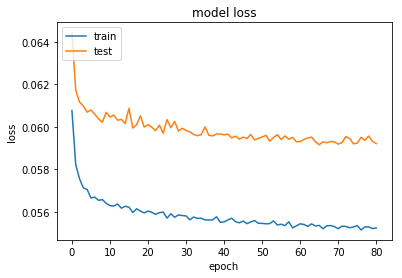

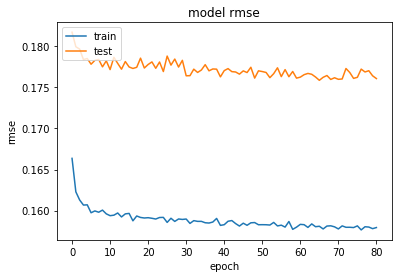

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

## Evaluate performance on validation data

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  42.698644399642944 s =  0.7116440852483114 min =  0.011860734820365905 h


## Evaluate metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05887085769639103
Delay 100 ms: 0.004725563684128885
Delay 200 ms: 0.013483157902972049
Delay 300 ms: 0.024813153816327572
Delay 400 ms: 0.037421480880513426
Delay 500 ms: 0.05065445723683491
Delay 600 ms: 0.06421861664488586
Delay 700 ms: 0.07792811587516946
Delay 800 ms: 0.09163923330157411
Delay 900 ms: 0.10522803960567734
Delay 1000 ms: 0.11859675801582664

RMSE
Average rmse: 0.12357007512230472
Delay 100 ms: 0.012344322856536897
Delay 200 ms: 0.02843188915148458
Delay 300 ms: 0.048885146799153886
Delay 400 ms: 0.07109323443566015
Delay 500 ms: 0.09391201920876428
Delay 600 ms: 0.11685437460855488
Delay 700 ms: 0.13956161437759032
Delay 800 ms: 0.16186706533780698
Delay 900 ms: 0.1836394774808402
Delay 1000 ms: 0.20473843570243375

SMAPE
Average smape: 14.372606817582616
Delay 100 ms: 2.360862916992301
Delay 200 ms: 5.486024964008483
Delay 300 ms: 8.544742226744196
Delay 400 ms: 11.383444086699065
Delay 500 ms: 13.96392795434289
Delay 600 ms: 16.328715394154514
D

(6068, 25, 3) (6068, 10, 3)


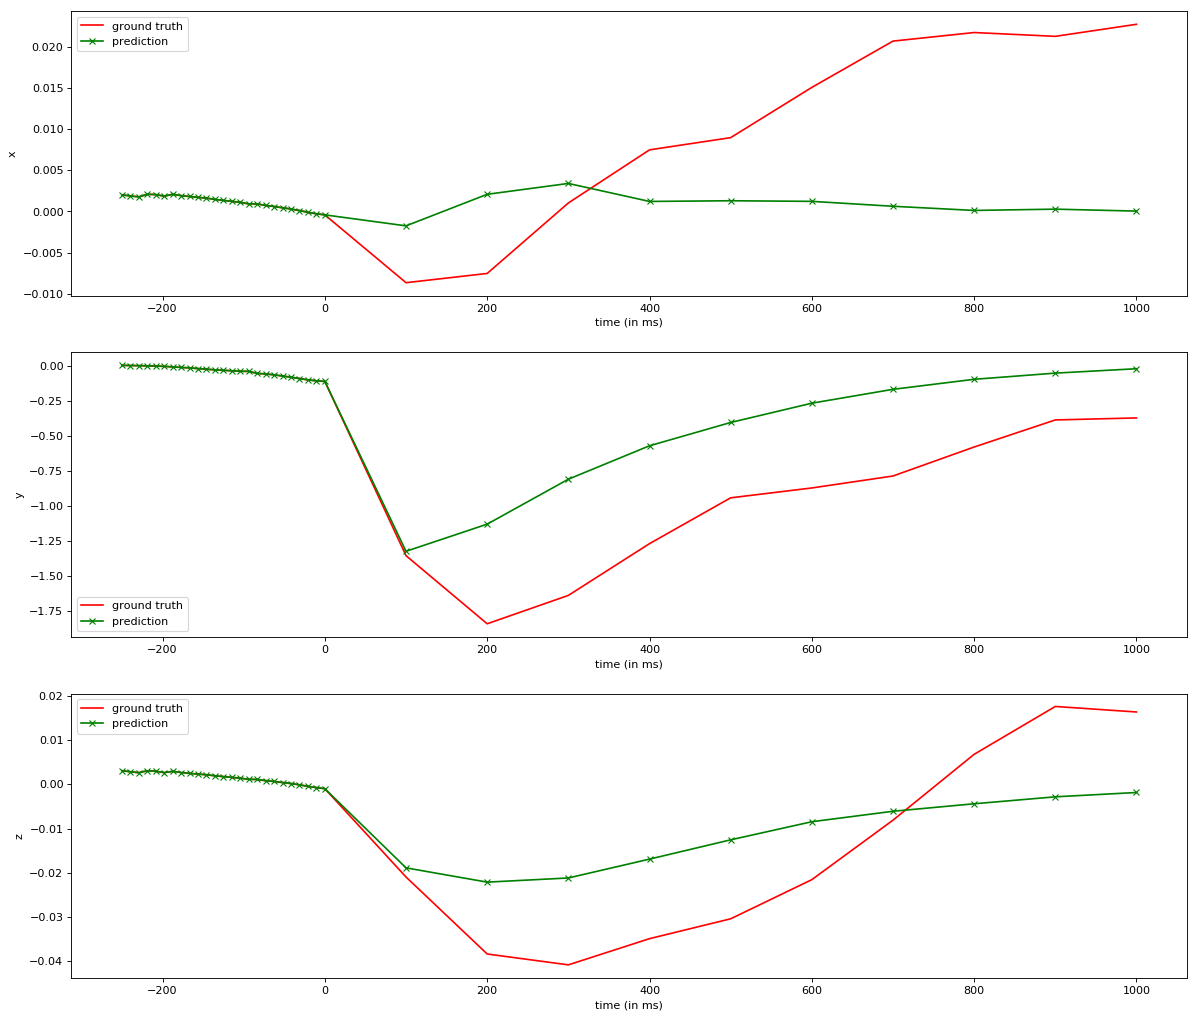

In [16]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')